<a href="https://colab.research.google.com/github/saraswathub/Hanzi_Pot/blob/main/StrokeSeq_POT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa1 in position 2: invalid start byte

In [ ]:
import json
import chardet

class HandwritingCapture:
    def __init__(self):
        self.letters = {}  # Dictionary to store strokes for each letter

    def add_stroke(self, letter, stroke_points):
        """Add a stroke to a letter"""
        if letter not in self.letters:
            self.letters[letter] = []
        stroke_id = f"{letter}_stroke_{len(self.letters[letter]) + 1}"
        self.letters[letter].append({"id": stroke_id, "points": stroke_points})

    def save_data(self, filename="handwriting_data.json"):
        """Save captured handwriting data to a JSON file"""
        with open(filename, "w") as file:
            json.dump(self.letters, file, indent=4)

    def show_data(self):
        """Display captured strokes"""
        for letter, strokes in self.letters.items():
            print(f"Letter: {letter}")
            for stroke in strokes:
                print(f"  Stroke ID: {stroke['id']}, Points: {stroke['points']}")

def detect_encoding(file_path):
    """Detect encoding for a given file"""
    with open(file_path, 'rb') as file:
        raw_data = file.read()
    encoding_info = chardet.detect(raw_data)
    return encoding_info['encoding']

def read_pot_file(file_path):
    """Reads stroke data from a .pot file and handles encoding errors."""
    strokes = []

    encoding = detect_encoding(file_path)  # Detect file encoding

    with open(file_path, 'r', encoding=encoding, errors='ignore') as file:  # Ignore decoding errors
        for line in file:
            line = line.strip()
            if not line:  # Skip empty lines
                continue
            try:
                points = [tuple(map(float, point.split(','))) for point in line.split(';') if point]
                strokes.append(points)
            except ValueError:
                print(f"Skipping malformed line: {line}")

    return strokes

# Provide the correct path to your .pot file in Google Drive
pot_file_path = '/content/drive//MyDrive/competition_POT/C001-f.pot'

# Read strokes from the .pot file
strokes = read_pot_file(pot_file_path)

# Organize strokes into letters (Simple alternating assignment: 'A' and 'B')
capture = HandwritingCapture()
for i, stroke in enumerate(strokes):
    letter = 'A' if i % 2 == 0 else 'B'
    capture.add_stroke(letter, stroke)

capture.show_data()
capture.save_data()


Skipping malformed line: 8   "W,{,*&$  *W>\QWSUOd?  $\[  kKOPtnorhmwkzwqmmjHe@cEfRrqokhhp  KPPFDX{  r  ivvs        SPR\rwrw~nuN  WZWP
Skipping malformed line: JHMrz{  {        }}l  Ov
Skipping malformed line:   +U$m(sDpGnIRJESxOI@x-1'$  -JYZ,-P^`[UNGFE=6.,.8FTt}}  4   a>cCbA\>M56462:5E;l7;;-  9CMqcD  s4gS\ndd_]?:h{r  \}d|rmf]XW  pkm  {rnkm        EwHwRTRN  Vqfu|wrq~{{j  GN  ]ZUUJ  Cc  (^|  x 

Found 60 .pot files. Reading files...
Incomplete point at stroke 0, point 110771 in /content/drive//MyDrive/competition_POT/C008-f.pot
Incomplete point at stroke 1, point 0 in /content/drive//MyDrive/competition_POT/C008-f.pot
Missing point count at stroke 2 in /content/drive//MyDrive/competition_POT/C008-f.pot
Read 2 strokes from C008-f.pot
Incomplete point at stroke 0, point 131418 in /content/drive//MyDrive/competition_POT/C011-f.pot
Missing point count at stroke 1 in /content/drive//MyDrive/competition_POT/C011-f.pot
Read 1 strokes from C011-f.pot
Incomplete point at stroke 0, point 120471 in /content/drive//MyDrive/competition_POT/C009-f.pot
Missing point count at stroke 1 in /content/drive//MyDrive/competition_POT/C009-f.pot
Read 1 strokes from C009-f.pot
Incomplete point at stroke 0, point 118323 in /content/drive//MyDrive/competition_POT/C007-f.pot
Incomplete point at stroke 1, point 0 in /content/drive//MyDrive/competition_POT/C007-f.pot
Missing point count at stroke 2 in /con

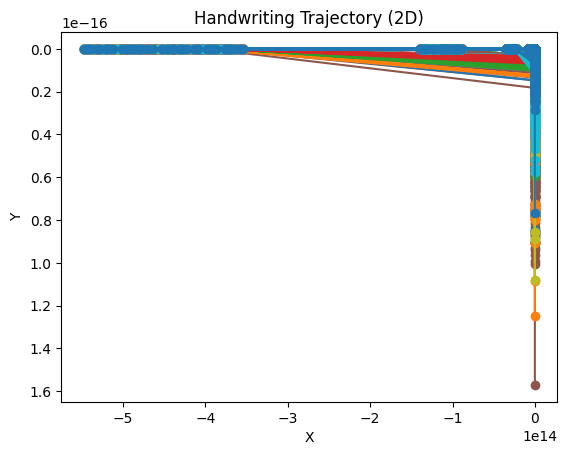

In [ ]:
import os
import struct
import matplotlib.pyplot as plt
import numpy as np

def read_pot_file_safe(file_path):
    """Safely reads a .pot file, recovering as many strokes as possible."""
    strokes = []
    try:
        with open(file_path, 'rb') as file:
            raw = file.read()
            offset = 0

            if offset + 4 > len(raw):
                print(f"File too short: {file_path}")
                return strokes

            num_strokes = struct.unpack_from('I', raw, offset)[0]
            offset += 4

            for stroke_index in range(num_strokes):
                if offset + 4 > len(raw):
                    print(f"Missing point count at stroke {stroke_index} in {file_path}")
                    break

                try:
                    num_points = struct.unpack_from('I', raw, offset)[0]
                    offset += 4
                except struct.error:
                    print(f"Corrupt stroke header at stroke {stroke_index} in {file_path}")
                    break

                stroke = []
                for point_index in range(num_points):
                    if offset + 8 > len(raw):
                        print(f"Incomplete point at stroke {stroke_index}, point {point_index} in {file_path}")
                        break
                    try:
                        x, y = struct.unpack_from('ff', raw, offset)
                        offset += 8
                        stroke.append((x, y))
                    except struct.error:
                        print(f"Error reading point at stroke {stroke_index}, point {point_index} in {file_path}")
                        break
                strokes.append(stroke)
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    return strokes

def read_all_pot_files(directory):
    all_strokes = []
    pot_files = [f for f in os.listdir(directory) if f.endswith('.pot')]
    print(f"Found {len(pot_files)} .pot files. Reading files...")

    for filename in pot_files:
        file_path = os.path.join(directory, filename)
        strokes = read_pot_file_safe(file_path)
        if strokes:
            print(f"Read {len(strokes)} strokes from {filename}")
            all_strokes.extend(strokes)
        else:
            print(f"No strokes read from {filename}")
    return all_strokes

def plot_strokes(strokes):
    """Visualize strokes in 2D."""
    for stroke in strokes:
        if len(stroke) > 1:
            x_coords, y_coords = zip(*stroke)
            plt.plot(x_coords, y_coords, marker='o')
    plt.gca().invert_yaxis()
    plt.title('Handwriting Trajectory (2D)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

def calculate_statistics(strokes):
    """Calculate statistics like average stroke length and velocity."""
    total_points = sum(len(stroke) for stroke in strokes)
    total_length = 0
    velocities = []

    for stroke in strokes:
        stroke_length = 0
        for i in range(1, len(stroke)):
            x1, y1 = stroke[i - 1]
            x2, y2 = stroke[i]
            distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            stroke_length += distance
            velocities.append(distance)
        total_length += stroke_length

    avg_length = total_length / len(strokes) if strokes else 0
    avg_velocity = np.mean(velocities) if velocities else 0

    print(f"Total points: {total_points}")
    print(f"Average stroke length: {avg_length:.2f}")
    print(f"Average velocity (arbitrary units): {avg_velocity:.2f}")

# Example usage:
data_path = '/content/drive//MyDrive/competition_POT/'
all_strokes = read_all_pot_files(data_path)
calculate_statistics(all_strokes)
plot_strokes(all_strokes)


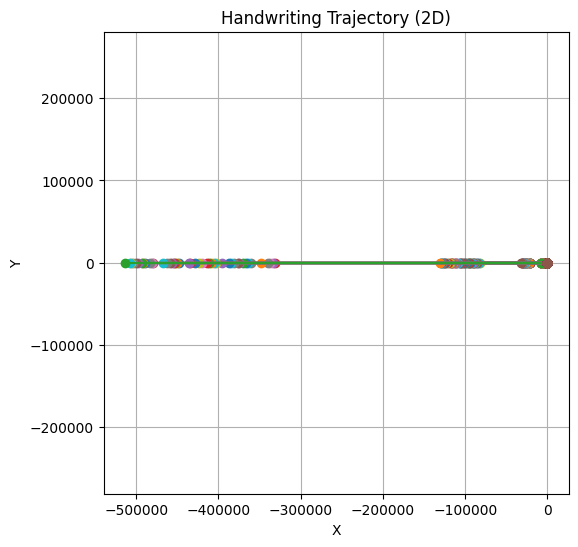

Stroke 0 code: ffgccaeaagccbgcfcbgeabbgeachdeaffdcbaffecbgccagcdcaeachg
Stroke 1 code: abbgeadbbaeaebbgfebbbagffeabagccagdebbgcfcaf
Stroke 2 code: cbhgdecafgcfgcegfabbgcdbageabeabaebgegcbbhecbgecaffebbbheafbh
Stroke 3 code: bbaeaebbaeaagccbhdgcfebbbffecbbfdcgfecbgcffcbbaf
Stroke 4 code: cbbgdcbagcbgcbbbhffbebbbggccbffebbggcbhdg


In [ ]:
import struct
import os
import matplotlib.pyplot as plt
import math


def read_pot_file(file_path):
    strokes = []
    try:
        with open(file_path, 'rb') as f:
            stroke = []
            while True:
                data = f.read(8)  # Each point is 2 floats (4 bytes each)
                if len(data) < 8:
                    if stroke:
                        strokes.append(stroke)
                    break
                try:
                    x, y = struct.unpack('ff', data)
                    if math.isnan(x) or math.isnan(y):
                        raise ValueError("Invalid point")
                    if abs(x) > 1e14 or abs(y) > 1e14:
                        raise ValueError("Outlier point")
                    stroke.append((x, y))
                except:
                    if stroke:
                        strokes.append(stroke)
                        stroke = []
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    return strokes


def filter_outliers(strokes, threshold=1e6):
    filtered = []
    for stroke in strokes:
        clean_stroke = [(x, y) for x, y in stroke if abs(x) < threshold and abs(y) < threshold]
        if len(clean_stroke) > 1:
            filtered.append(clean_stroke)
    return filtered


def plot_strokes(strokes):
    plt.figure(figsize=(6, 6))
    for stroke in strokes:
        x_vals = [pt[0] for pt in stroke]
        y_vals = [pt[1] for pt in stroke]
        plt.plot(x_vals, y_vals, marker='o')
    plt.title("Handwriting Trajectory (2D)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    plt.grid(True)
    plt.show()


def stroke_to_direction_code(stroke):
    code = ''
    for i in range(1, len(stroke)):
        x1, y1 = stroke[i - 1]
        x2, y2 = stroke[i]
        dx, dy = x2 - x1, y2 - y1
        angle = math.degrees(math.atan2(dy, dx))
        if -22.5 < angle <= 22.5:
            code += 'a'
        elif 22.5 < angle <= 67.5:
            code += 'b'
        elif 67.5 < angle <= 112.5:
            code += 'c'
        elif 112.5 < angle <= 157.5:
            code += 'd'
        elif angle > 157.5 or angle <= -157.5:
            code += 'e'
        elif -157.5 < angle <= -112.5:
            code += 'f'
        elif -112.5 < angle <= -67.5:
            code += 'g'
        elif -67.5 < angle <= -22.5:
            code += 'h'
    return code


# Example usage:
directory = "/content/drive/MyDrive/competition_POT"
file_name = "C045-f.pot"
file_path = os.path.join(directory, file_name)

all_strokes = read_pot_file(file_path)
clean_strokes = filter_outliers(all_strokes)
plot_strokes(clean_strokes)

for i, stroke in enumerate(clean_strokes[:5]):
    print(f"Stroke {i} code: {stroke_to_direction_code(stroke)}")


In [ ]:
import struct
import os
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Configuration
INPUT_DIR = Path("/content/drive/MyDrive/competition_POT")
OUTPUT_DIR = Path("./chain_codes")
PLOTS_DIR = Path("./plots")
DIRECTION_CODES = 'abcdefgh'

def read_pot_file(file_path):
    """Read .pot file and extract strokes with error handling"""
    strokes = []
    try:
        with open(file_path, 'rb') as f:
            stroke = []
            while True:
                data = f.read(8)  # Read 8 bytes for two floats
                if len(data) < 8:
                    if stroke:
                        strokes.append(stroke)
                    break
                try:
                    x, y = struct.unpack('ff', data)
                    if validate_point(x, y):
                        stroke.append((x, y))
                    else:
                        raise ValueError("Invalid point detected")
                except (struct.error, ValueError):
                    if stroke:
                        strokes.append(stroke)
                        stroke = []
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    return strokes

def validate_point(x, y):
    """Validate coordinates with enhanced checks"""
    return not (math.isnan(x) or math.isnan(y) or
               abs(x) > 1e14 or abs(y) > 1e14 or
               abs(x) < 1e-14 or abs(y) < 1e-14)

def filter_outliers(strokes, threshold=1e6):
    """Clean strokes with configurable threshold"""
    filtered = []
    for stroke in strokes:
        clean_stroke = [(x, y) for x, y in stroke
                       if abs(x) < threshold and abs(y) < threshold]
        if len(clean_stroke) > 1:
            filtered.append(clean_stroke)
    return filtered

def normalize_stroke(stroke):
    """Normalize coordinates to [-1, 1] range"""
    arr = np.array(stroke)
    if arr.size == 0:
        return []

    # Center and scale coordinates
    arr = arr - np.mean(arr, axis=0)
    max_val = np.max(np.abs(arr)) or 1  # Prevent division by zero
    return (arr / max_val).tolist()

def stroke_to_direction_code(stroke):
    """Convert stroke to 8-direction Freeman code with smoothing"""
    code = []
    for (x1, y1), (x2, y2) in zip(stroke[:-1], stroke[1:]):
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            continue  # Skip duplicate points

        angle = math.degrees(math.atan2(dy, dx))
        normalized_angle = (angle + 360) % 360
        idx = int(round(normalized_angle / 45) % 8)
        code.append(DIRECTION_CODES[idx])
    return ''.join(code)

def plot_and_save(strokes, file_path, save_dir=PLOTS_DIR):
    """Plot and save stroke visualization using Path objects"""
    plt.figure(figsize=(6, 6))
    for stroke in strokes:
        if len(stroke) < 2:
            continue
        x, y = zip(*stroke)
        plt.plot(x, y, marker='o', markersize=3)
    plt.title(f"Stroke Visualization: {file_path.stem}")
    plt.xlabel("X (normalized)")
    plt.ylabel("Y (normalized)")
    plt.axis('equal')
    plt.grid(True)
    save_dir.mkdir(exist_ok=True)
    plt.savefig(save_dir / f"{file_path.stem}.png", dpi=120)
    plt.close()

def process_file(file_path):
    """Full processing pipeline for a single file"""
    # Read and preprocess data
    raw_strokes = read_pot_file(file_path)
    clean_strokes = filter_outliers(raw_strokes)
    normalized_strokes = [normalize_stroke(s) for s in clean_strokes]

    # Generate direction codes
    codes = [stroke_to_direction_code(s) for s in normalized_strokes]

    # Save results
    OUTPUT_DIR.mkdir(exist_ok=True)
    output_file = OUTPUT_DIR / f"{file_path.stem}.txt"
    with open(output_file, 'w') as f:
        f.write('\n'.join(codes))

    # Generate visualization (pass Path object instead of string)
    plot_and_save(normalized_strokes, file_path)

def batch_process():
    """Process all .pot files in input directory"""
    for pot_file in INPUT_DIR.glob("*.pot"):
        print(f"Processing {pot_file.name}...")
        try:
            process_file(pot_file)
        except Exception as e:
            print(f"Failed to process {pot_file.name}: {e}")

if __name__ == "__main__":
    # Example single file processing
    sample_file = INPUT_DIR / "C045-f.pot"
    if sample_file.exists():
        process_file(sample_file)
        with open(OUTPUT_DIR / "C045-f.txt") as f:
            print("Sample output codes:", f.read())

    # Process all files
    batch_process()
    print("Batch processing completed")

Sample output codes: 
Processing C008-f.pot...
Processing C011-f.pot...
Processing C009-f.pot...
Processing C007-f.pot...
Processing C006-f.pot...
Processing C003-f.pot...
Processing C002-f.pot...
Processing C004-f.pot...
Processing C010-f.pot...
Processing C005-f.pot...
Processing C001-f.pot...
Processing C021-f.pot...
Processing C020-f.pot...
Processing C017-f.pot...
Processing C013-f.pot...
Processing C014-f.pot...
Processing C023-f.pot...
Processing C019-f.pot...
Processing C018-f.pot...
Processing C022-f.pot...
Processing C016-f.pot...
Processing C024-f.pot...
Processing C015-f.pot...
Processing C025-f.pot...
Processing C012-f.pot...
Processing C033-f.pot...
Processing C026-f.pot...
Processing C031-f.pot...
Processing C036-f.pot...
Processing C029-f.pot...
Processing C028-f.pot...
Processing C037-f.pot...
Processing C035-f.pot...
Processing C030-f.pot...
Processing C032-f.pot...
Processing C027-f.pot...
Processing C039-f.pot...
Processing C038-f.pot...
Processing C034-f.pot...
Pro

In [ ]:
import struct
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
INPUT_DIR = Path("./input_pot")
OUTPUT_DIR = Path("./chain_codes")
PLOTS_DIR = Path("./plots")
DIRECTION_CODES = 'abcdefgh'

def read_casia_pot(file_path):
    """Reads CASIA .pot file format (short x, y) into strokes."""
    strokes = []
    with open(file_path, 'rb') as f:
        content = f.read()
        idx = 0
        n_strokes = int.from_bytes(content[idx:idx+4], byteorder='little')
        idx += 4

        for _ in range(n_strokes):
            n_points = int.from_bytes(content[idx:idx+4], byteorder='little')
            idx += 4
            stroke = []
            for _ in range(n_points):
                x = int.from_bytes(content[idx:idx+2], byteorder='little', signed=True)
                idx += 2
                y = int.from_bytes(content[idx:idx+2], byteorder='little', signed=True)
                idx += 2
                stroke.append((x, y))
            strokes.append(stroke)
    return strokes


def validate_point(x, y):
    """Check for NaN and absurd values"""
    return not (math.isnan(x) or math.isnan(y) or
                abs(x) > 1e4 or abs(y) > 1e4)

def normalize_all_strokes(strokes):
    """Normalize coordinates globally across all strokes"""
    all_points = [pt for stroke in strokes for pt in stroke]
    arr = np.array(all_points)
    if arr.size == 0:
        return strokes

    # Center and scale
    arr -= np.mean(arr, axis=0)
    max_val = np.max(np.abs(arr))
    if max_val == 0:
        max_val = 1
    arr /= max_val

    # Reassign back to strokes
    normalized = []
    idx = 0
    for stroke in strokes:
        n = len(stroke)
        normalized.append(arr[idx:idx+n].tolist())
        idx += n
    return normalized

def stroke_to_direction_code(stroke):
    """Convert stroke to directional Freeman chain code"""
    code = []
    for (x1, y1), (x2, y2) in zip(stroke[:-1], stroke[1:]):
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.degrees(math.atan2(dy, dx)) % 360
        idx = int(round(angle / 45)) % 8
        code.append(DIRECTION_CODES[idx])
    return ''.join(code)

def plot_and_save(strokes, file_path):
    """Plot strokes with clear visual differentiation"""
    plt.figure(figsize=(6, 6))
    colors = plt.cm.get_cmap('tab10', len(strokes))
    for i, stroke in enumerate(strokes):
        x, y = zip(*stroke)
        plt.plot(x, y, marker='o', markersize=3, label=f'Stroke {i+1}', color=colors(i))
    plt.title(f"Handwriting Trajectory (2D)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    PLOTS_DIR.mkdir(exist_ok=True)
    plt.savefig(PLOTS_DIR / f"{file_path.stem}.png", dpi=150)
    plt.close()

def process_file(file_path):
    """Full pipeline for a file: read, clean, normalize, encode, plot"""
    raw_strokes = read_pot_file(file_path)
    filtered_strokes = [s for s in raw_strokes if len(s) > 1]
    if not filtered_strokes:
        print(f"No valid strokes found in {file_path}")
        return

    normalized_strokes = normalize_all_strokes(filtered_strokes)
    direction_codes = [stroke_to_direction_code(stroke) for stroke in normalized_strokes]

    OUTPUT_DIR.mkdir(exist_ok=True)
    with open(OUTPUT_DIR / f"{file_path.stem}.txt", 'w') as f:
        for i, code in enumerate(direction_codes):
            f.write(f"Stroke {i}: {code}\n")

    plot_and_save(normalized_strokes, file_path)
    print(f"Processed: {file_path.name}")

def batch_process():
    """Batch process all .pot files"""
    for file_path in INPUT_DIR.glob("*.pot"):
        process_file(file_path)

if __name__ == "__main__":
    INPUT_DIR.mkdir(exist_ok=True)
    batch_process()


file_path = '/content/drive//MyDrive/competition_POT/C001-f.pot'




In [ ]:
import struct
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration
INPUT_DIR = Path("/content/drive/MyDrive/competition_POT")
OUTPUT_DIR = Path("./chain_codes")
PLOTS_DIR = Path("./plots")
DIRECTION_CODES = 'abcdefgh'

# --- Utility Functions ---
def read_casia_pot(file_path):
    """Reads CASIA .pot file (with int headers, short coordinates)"""
    strokes = []
    try:
        with open(file_path, 'rb') as f:
            content = f.read()
            idx = 0
            n_strokes = int.from_bytes(content[idx:idx+4], byteorder='little')
            idx += 4

            for _ in range(n_strokes):
                if idx + 4 > len(content):
                    break  # Prevent out-of-range
                n_points = int.from_bytes(content[idx:idx+4], byteorder='little')
                idx += 4
                stroke = []
                for _ in range(n_points):
                    if idx + 4 > len(content):
                        break
                    x = int.from_bytes(content[idx:idx+2], byteorder='little', signed=True)
                    idx += 2
                    y = int.from_bytes(content[idx:idx+2], byteorder='little', signed=True)
                    idx += 2
                    stroke.append((x, y))
                strokes.append(stroke)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    return strokes

def normalize_stroke(stroke):
    arr = np.array(stroke)
    if arr.size == 0:
        return []
    arr = arr - np.mean(arr, axis=0)
    max_val = np.max(np.abs(arr)) or 1
    return (arr / max_val).tolist()

def stroke_to_direction_code(stroke):
    code = []
    for (x1, y1), (x2, y2) in zip(stroke[:-1], stroke[1:]):
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = np.degrees(np.arctan2(dy, dx))
        normalized_angle = (angle + 360) % 360
        idx = int(round(normalized_angle / 45) % 8)
        code.append(DIRECTION_CODES[idx])
    return ''.join(code)

def plot_strokes(strokes, file_path):
    plt.figure(figsize=(6, 6))
    for stroke in strokes:
        if len(stroke) < 2:
            continue
        x, y = zip(*stroke)
        plt.plot(x, y, marker='o')
    plt.title(f"Strokes: {file_path.stem}")
    plt.axis('equal')
    plt.grid(True)
    PLOTS_DIR.mkdir(exist_ok=True)
    plt.savefig(PLOTS_DIR / f"{file_path.stem}.png")
    plt.close()

def process_file(file_path):
    strokes = read_casia_pot(file_path)
    if not strokes:
        print(f"No strokes found in {file_path.name}")
        return

    normalized_strokes = [normalize_stroke(s) for s in strokes if len(s) > 1]
    codes = [stroke_to_direction_code(s) for s in normalized_strokes]

    # Save Freeman codes
    OUTPUT_DIR.mkdir(exist_ok=True)
    out_path = OUTPUT_DIR / f"{file_path.stem}.txt"
    with open(out_path, 'w') as f:
        for i, code in enumerate(codes):
            f.write(f"Stroke {i}: {code}\n")

    # Plot strokes
    plot_strokes(normalized_strokes, file_path)

def batch_process():
    for pot_file in INPUT_DIR.glob("*.pot"):
        print(f"Processing {pot_file.name}")
        process_file(pot_file)

# Example usage
if __name__ == "__main__":
    batch_process()
    print("Processing completed.")


Processing C008-f.pot
Processing C011-f.pot
Processing C009-f.pot
Processing C007-f.pot
Processing C006-f.pot
Processing C003-f.pot
Processing C002-f.pot
Processing C004-f.pot
Processing C010-f.pot
Processing C005-f.pot
Processing C001-f.pot
Processing C021-f.pot
Processing C020-f.pot
Processing C017-f.pot
Processing C013-f.pot
Processing C014-f.pot
Processing C023-f.pot
Processing C019-f.pot
Processing C018-f.pot
Processing C022-f.pot
Processing C016-f.pot
Processing C024-f.pot
Processing C015-f.pot
Processing C025-f.pot
Processing C012-f.pot
Processing C033-f.pot
Processing C026-f.pot
Processing C031-f.pot
Processing C036-f.pot
Processing C029-f.pot
Processing C028-f.pot
Processing C037-f.pot
Processing C035-f.pot
Processing C030-f.pot
Processing C032-f.pot
Processing C027-f.pot
Processing C039-f.pot
Processing C038-f.pot
Processing C034-f.pot
Processing C050-f.pot
Processing C052-f.pot


In [ ]:
import struct
import os
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Configuration
INPUT_DIR = Path("/content/drive//MyDrive/competition_POT/C001-f.pot")
OUTPUT_DIR = Path("/mnt/data/chain_codes")
PLOTS_DIR = Path("/mnt/data/plots")
DIRECTION_CODES = 'abcdefgh'

# Helper to ensure directories exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def read_pot_file(file_path):
    strokes = []
    stroke = []
    try:
        with open(file_path, 'rb') as f:
            point_index = 0
            while True:
                data = f.read(8)
                if len(data) < 8:
                    if stroke:
                        strokes.append(stroke)
                    break
                try:
                    x, y = struct.unpack('ff', data)
                    if not (math.isnan(x) or math.isnan(y) or abs(x) > 1e10 or abs(y) > 1e10):
                        stroke.append((x, y))
                    else:
                        print(f"Invalid point at stroke {len(strokes)}, point {point_index} in {file_path}")
                        if stroke:
                            strokes.append(stroke)
                        stroke = []
                    point_index += 1
                except Exception as e:
                    print(f"Error at point {point_index} in {file_path}: {e}")
                    if stroke:
                        strokes.append(stroke)
                    stroke = []
        if stroke:
            strokes.append(stroke)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    print(f"Read {len(strokes)} strokes from {file_path.name}")
    return strokes

def normalize_stroke(stroke):
    arr = np.array(stroke)
    arr -= np.mean(arr, axis=0)
    max_val = np.max(np.abs(arr)) or 1
    return (arr / max_val).tolist()

def stroke_to_freeman_code(stroke):
    code = []
    for (x1, y1), (x2, y2) in zip(stroke[:-1], stroke[1:]):
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.degrees(math.atan2(dy, dx))
        angle = (angle + 360) % 360
        idx = int(round(angle / 45) % 8)
        code.append(DIRECTION_CODES[idx])
    return ''.join(code)

def plot_strokes(strokes, name):
    plt.figure(figsize=(5, 5))
    for stroke in strokes:
        if len(stroke) > 1:
            x, y = zip(*stroke)
            plt.plot(x, y, marker='o')
    plt.title(name)
    plt.axis('equal')
    plt.grid(True)
    plot_file = PLOTS_DIR / f"{name}.png"
    plt.savefig(plot_file)
    plt.close()
    print(f"Saved plot to: {plot_file}")

def process_file(file_path):
    strokes = read_pot_file(file_path)
    strokes = [s for s in strokes if len(s) > 1]
    normalized = [normalize_stroke(s) for s in strokes]
    codes = [stroke_to_freeman_code(s) for s in normalized]

    if codes:
        out_file = OUTPUT_DIR / f"{file_path.stem}.txt"
        with open(out_file, 'w') as f:
            f.write('\n'.join(codes))
        print(f"Saved Freeman codes to: {out_file}")

    plot_strokes(normalized, file_path.stem)

    # Print sample Freeman codes for debug
    print(f"Sample Freeman codes for {file_path.name}:")
    for i, c in enumerate(codes[:20]):
        print(f"Stroke {i}: {c}")

def batch_process():
    files = list(INPUT_DIR.glob("*.pot"))
    print(f"Found {len(files)} .pot files to process.")
    for f in files:
        print(f"Processing {f.name}...")
        process_file(f)
    print("Batch processing completed.")

# Run processing
batch_process()


Found 0 .pot files to process.
Batch processing completed.


Found 60 .pot files to process.
Processing C008-f.pot...
Invalid point at stroke 0, point 33 in /content/drive/MyDrive/competition_POT/C008-f.pot
Invalid point at stroke 1, point 59 in /content/drive/MyDrive/competition_POT/C008-f.pot
Invalid point at stroke 2, point 90 in /content/drive/MyDrive/competition_POT/C008-f.pot
Invalid point at stroke 3, point 121 in /content/drive/MyDrive/competition_POT/C008-f.pot
Invalid point at stroke 4, point 147 in /content/drive/MyDrive/competition_POT/C008-f.pot
Invalid point at stroke 5, point 178 in /content/drive/MyDrive/competition_POT/C008-f.pot
Invalid point at stroke 6, point 205 in /content/drive/MyDrive/competition_POT/C008-f.pot
Invalid point at stroke 7, point 244 in /content/drive/MyDrive/competition_POT/C008-f.pot
Invalid point at stroke 8, point 284 in /content/drive/MyDrive/competition_POT/C008-f.pot
Invalid point at stroke 9, point 332 in /content/drive/MyDrive/competition_POT/C008-f.pot
Invalid point at stroke 10, point 372 in /cont

<ipython-input-7-54d28a22e84b>:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', len(strokes))


Streaming output truncated to the last 5000 lines.
Invalid point at stroke 2910, point 96793 in /content/drive/MyDrive/competition_POT/C030-f.pot
Invalid point at stroke 2911, point 96822 in /content/drive/MyDrive/competition_POT/C030-f.pot
Invalid point at stroke 2912, point 96861 in /content/drive/MyDrive/competition_POT/C030-f.pot
Invalid point at stroke 2913, point 96881 in /content/drive/MyDrive/competition_POT/C030-f.pot
Invalid point at stroke 2914, point 96921 in /content/drive/MyDrive/competition_POT/C030-f.pot
Invalid point at stroke 2915, point 96960 in /content/drive/MyDrive/competition_POT/C030-f.pot
Invalid point at stroke 2916, point 96992 in /content/drive/MyDrive/competition_POT/C030-f.pot
Invalid point at stroke 2917, point 97011 in /content/drive/MyDrive/competition_POT/C030-f.pot
Invalid point at stroke 2918, point 97025 in /content/drive/MyDrive/competition_POT/C030-f.pot
Invalid point at stroke 2919, point 97042 in /content/drive/MyDrive/competition_POT/C030-f.pot

KeyboardInterrupt: 

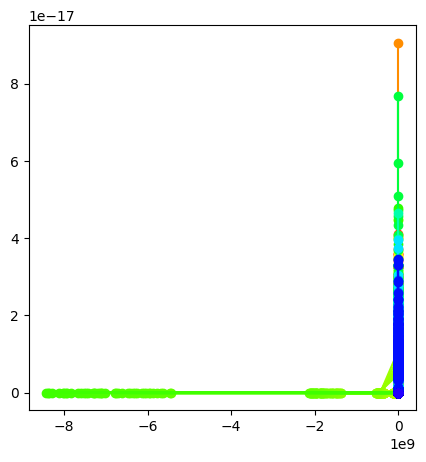

In [ ]:
import struct
import os
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configuration
INPUT_DIR = Path("/content/drive/MyDrive/competition_POT")
OUTPUT_DIR = Path("/mnt/data/chain_codes")
PLOTS_DIR = Path("/mnt/data/plots")
DIRECTION_CODES = 'abcdefgh'

# Helper to ensure directories exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def read_pot_file(file_path):
    strokes = []
    stroke = []
    try:
        with open(file_path, 'rb') as f:
            point_index = 0
            while True:
                data = f.read(8)
                if len(data) < 8:
                    if stroke:
                        strokes.append(stroke)
                    break
                try:
                    x, y = struct.unpack('ff', data)
                    if not (math.isnan(x) or math.isnan(y) or abs(x) > 1e10 or abs(y) > 1e10):
                        stroke.append((x, y))
                    else:
                        print(f"Invalid point at stroke {len(strokes)}, point {point_index} in {file_path}")
                        if stroke:
                            strokes.append(stroke)
                        stroke = []
                    point_index += 1
                except Exception as e:
                    print(f"Error at point {point_index} in {file_path}: {e}")
                    if stroke:
                        strokes.append(stroke)
                    stroke = []
        if stroke:
            strokes.append(stroke)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    print(f"Read {len(strokes)} strokes from {file_path.name}")
    return strokes

def normalize_stroke(stroke):
    arr = np.array(stroke)
    min_xy = np.min(arr, axis=0)
    max_xy = np.max(arr, axis=0)
    range_xy = max_xy - min_xy
    range_xy[range_xy == 0] = 1  # avoid division by zero
    normalized = (arr - min_xy) / range_xy
    return normalized.tolist()

def stroke_to_freeman_code(stroke):
    code = []
    for (x1, y1), (x2, y2) in zip(stroke[:-1], stroke[1:]):
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.degrees(math.atan2(dy, dx))
        angle = (angle + 360) % 360
        idx = int(round(angle / 45) % 8)
        code.append(DIRECTION_CODES[idx])
    return ''.join(code)

def plot_strokes(strokes, name):
    plt.figure(figsize=(5, 5))
    cmap = cm.get_cmap('hsv', len(strokes))
    for i, stroke in enumerate(strokes):
        if len(stroke) > 1:
            x, y = zip(*stroke)
            plt.plot(x, y, marker='o', color=cmap(i))
    plt.title(name)
    plt.axis('equal')
    plt.grid(True)
    plot_file = PLOTS_DIR / f"{name}.png"
    plt.savefig(plot_file)
    plt.close()
    print(f"Saved plot to: {plot_file}")

def process_file(file_path):
    strokes = read_pot_file(file_path)
    strokes = [s for s in strokes if len(s) > 1]
    print(f"Before normalization: {len(strokes)} strokes")

    normalized = [normalize_stroke(s) for s in strokes if len(s) > 1]
    print(f"After normalization: {len(normalized)} strokes")

    codes = [stroke_to_freeman_code(s) for s in normalized]

    if codes:
        out_file = OUTPUT_DIR / f"{file_path.stem}.txt"
        with open(out_file, 'w') as f:
            f.write('\n'.join(codes))
        print(f"Saved Freeman codes to: {out_file}")

    plot_strokes(strokes, f"{file_path.stem}_raw")
    plot_strokes(normalized, f"{file_path.stem}_normalized")

    # Print sample Freeman codes for debug
    print(f"Sample Freeman codes for {file_path.name}:")
    for i, c in enumerate(codes[:20]):
        print(f"Stroke {i}: {c}")

def batch_process():
    files = list(INPUT_DIR.glob("*.pot"))
    print(f"Found {len(files)} .pot files to process.")
    for f in files:
        print(f"Processing {f.name}...")
        process_file(f)
    print("Batch processing completed.")

# Run processing
batch_process()


In [ ]:
import struct
import os
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configuration
INPUT_DIR = Path("/content/drive/MyDrive/competition_POT/")
OUTPUT_DIR = Path("/mnt/data/chain_codes")
PLOTS_DIR = Path("/mnt/data/plots")
DIRECTION_CODES = 'abcdefgh'

# Helper to ensure directories exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def read_pot_file(file_path):
    strokes = []
    stroke = []
    try:
        with open(file_path, 'rb') as f:
            point_index = 0
            while True:
                data = f.read(8)
                if len(data) < 8:
                    if stroke:
                        strokes.append(stroke)
                    break
                try:
                    x, y = struct.unpack('ff', data)
                    if not (math.isnan(x) or math.isnan(y) or abs(x) > 1e10 or abs(y) > 1e10):
                        stroke.append((x, y))
                    else:
                        print(f"Invalid point at stroke {len(strokes)}, point {point_index} in {file_path}")
                        if stroke:
                            strokes.append(stroke)
                        stroke = []
                    point_index += 1
                except Exception as e:
                    print(f"Error at point {point_index} in {file_path}: {e}")
                    if stroke:
                        strokes.append(stroke)
                    stroke = []
        if stroke:
            strokes.append(stroke)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    print(f"Read {len(strokes)} strokes from {file_path.name}")
    return strokes

def normalize_stroke(stroke):
    arr = np.array(stroke)
    min_xy = np.min(arr, axis=0)
    max_xy = np.max(arr, axis=0)
    range_xy = max_xy - min_xy
    range_xy[range_xy == 0] = 1  # avoid division by zero
    normalized = (arr - min_xy) / range_xy
    return normalized.tolist()

def stroke_to_freeman_code(stroke):
    code = []
    for (x1, y1), (x2, y2) in zip(stroke[:-1], stroke[1:]):
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.degrees(math.atan2(dy, dx))
        angle = (angle + 360) % 360
        idx = int(round(angle / 45) % 8)
        code.append(DIRECTION_CODES[idx])
    return ''.join(code)

def plot_strokes(strokes, name):
    plt.figure(figsize=(5, 5))
    cmap = cm.get_cmap('hsv', len(strokes))
    for i, stroke in enumerate(strokes):
        if len(stroke) > 1:
            x, y = zip(*stroke)
            plt.plot(x, y, marker='o', color=cmap(i))
    plt.title(name)
    plt.axis('equal')
    plt.grid(True)
    plot_file = PLOTS_DIR / f"{name}.png"
    plt.savefig(plot_file)
    plt.close()
    print(f"Saved plot to: {plot_file}")

def process_file(file_path):
    hanzi_char = file_path.stem[0]  # Assuming filename starts with the character
    strokes = read_pot_file(file_path)
    strokes = [s for s in strokes if len(s) > 1]
    print(f"Before normalization: {len(strokes)} strokes")

    normalized = [normalize_stroke(s) for s in strokes if len(s) > 1]
    print(f"After normalization: {len(normalized)} strokes")

    codes = [stroke_to_freeman_code(s) for s in normalized]

    if codes:
        out_file = OUTPUT_DIR / f"{file_path.stem}.txt"
        with open(out_file, 'w', encoding='utf-8') as f:
            f.write(f"Character: {hanzi_char}\n")
            f.write('\n'.join(codes))
        print(f"Saved Freeman codes to: {out_file}")

    plot_strokes(strokes, f"{file_path.stem}_raw")
    plot_strokes(normalized, f"{file_path.stem}_normalized")

    # Print sample Freeman codes for debug
    print(f"Sample Freeman codes for {file_path.name} (Character: {hanzi_char}):")
    for i, c in enumerate(codes[:20]):
        print(f"Stroke {i}: {c}")

def batch_process():
    files = list(INPUT_DIR.glob("*.pot"))
    print(f"Found {len(files)} .pot files to process.")
    for f in files:
        print(f"Processing {f.name}...")
        process_file(f)
    print("Batch processing completed.")

# Run processing
batch_process()


Found 1 .pot files to process.
Processing C001-f.pot...
Invalid point at stroke 0, point 38 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 1, point 68 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 2, point 104 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 3, point 142 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 4, point 168 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 5, point 210 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 6, point 243 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 7, point 288 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 8, point 351 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 9, point 410 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 10, point 457 in /cont

<ipython-input-11-e5f06beafa10>:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', len(strokes))


Saved plot to: /mnt/data/plots/C001-f_raw.png
Saved plot to: /mnt/data/plots/C001-f_normalized.png
Sample Freeman codes for C001-f.pot (Character: C):
Stroke 0: bccgccgcgccgccgggcccggcgccggccggcccgg
Stroke 1: bccccggcccggcgcccggccgcccgcg
Stroke 2: afeabbafegdaefbadbageacaefecbafebg
Stroke 3: agfccaffgfgcaffbeabagcgbegfeabbhgcca
Stroke 4: bcggcgcgcggcggcggcgccgcg
Stroke 5: abgeagdbeaegeabafcgcbgcbagchceaggcbbheag
Stroke 6: accggggcggccgcgcccgcccgggccggcg
Stroke 7: abaecheagdbgcabeafgdbbfggcaeagccbgcgcbbfgfg
Stroke 8: abbhegfeacbgeabhgcbbgccadfeabagebbhffeabfecafeabbgeggccaheaba
Stroke 9: aggggccgccggccgcccgggccgcgccgccggcgccgggccggccgcgggcccggc
Stroke 10: bccggcccgcgccggccgcccgggcccgccgcccggggcccgccg
Stroke 11: agfeagcaaccbgfab
Stroke 12: bcccgccccgccgcgcggcccgccgccgccgcgccccggccgggg
Stroke 13: aggcaeagdbgcbagcbgcbeaggcbbbgcedbaffba
Stroke 14: accgcccggcccggcccgccgggccggcggccggccgcggcgcccgggg
Stroke 15: afgeacbgdffedageacafbgffcbbfefgeabeagchdceaagcbafcagcbg
Stroke 16: abbgcgbadbachcbhe

In [ ]:
import struct
import os
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configuration
INPUT_DIR = Path("/content/drive/MyDrive/competition_POT")
OUTPUT_DIR = Path("/mnt/data/chain_codes")
PLOTS_DIR = Path("/mnt/data/plots")
DIRECTION_CODES = 'abcdefgh'
STROKE_DELIMITER = '|'  # Special delimiter between strokes

# Helper to ensure directories exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def read_pot_file(file_path):
    strokes = []
    stroke = []
    try:
        with open(file_path, 'rb') as f:
            point_index = 0
            while True:
                data = f.read(8)
                if len(data) < 8:
                    if stroke:
                        strokes.append(stroke)
                    break
                try:
                    x, y = struct.unpack('ff', data)
                    if not (math.isnan(x) or math.isnan(y) or abs(x) > 1e10 or abs(y) > 1e10):
                        stroke.append((x, y))
                    else:
                        print(f"Invalid point at stroke {len(strokes)}, point {point_index} in {file_path}")
                        if stroke:
                            strokes.append(stroke)
                        stroke = []
                    point_index += 1
                except Exception as e:
                    print(f"Error at point {point_index} in {file_path}: {e}")
                    if stroke:
                        strokes.append(stroke)
                    stroke = []
        if stroke:
            strokes.append(stroke)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    print(f"Read {len(strokes)} strokes from {file_path.name}")
    return strokes

def normalize_stroke(stroke):
    arr = np.array(stroke)
    min_xy = np.min(arr, axis=0)
    max_xy = np.max(arr, axis=0)
    range_xy = max_xy - min_xy
    range_xy[range_xy == 0] = 1  # avoid division by zero
    normalized = (arr - min_xy) / range_xy
    return normalized.tolist()

def stroke_to_freeman_code(stroke):
    code = []
    for (x1, y1), (x2, y2) in zip(stroke[:-1], stroke[1:]):
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.degrees(math.atan2(dy, dx))
        angle = (angle + 360) % 360
        idx = int(round(angle / 45) % 8)
        code.append(DIRECTION_CODES[idx])
    return ''.join(code)

def plot_strokes(strokes, name):
    plt.figure(figsize=(5, 5))
    cmap = cm.get_cmap('hsv', len(strokes))
    for i, stroke in enumerate(strokes):
        if len(stroke) > 1:
            x, y = zip(*stroke)
            plt.plot(x, y, marker='o', color=cmap(i))
    plt.title(name)
    plt.axis('equal')
    plt.grid(True)
    plot_file = PLOTS_DIR / f"{name}.png"
    plt.savefig(plot_file)
    plt.close()
    print(f"Saved plot to: {plot_file}")

def process_file(file_path):
    hanzi_char = file_path.stem[0]  # Assuming filename starts with the character
    strokes = read_pot_file(file_path)
    strokes = [s for s in strokes if len(s) > 1]
    print(f"Before normalization: {len(strokes)} strokes")

    normalized = [normalize_stroke(s) for s in strokes if len(s) > 1]
    print(f"After normalization: {len(normalized)} strokes")

    codes = [stroke_to_freeman_code(s) for s in normalized]
    joined_code = STROKE_DELIMITER.join(codes)

    if codes:
        out_file = OUTPUT_DIR / f"{file_path.stem}.txt"
        with open(out_file, 'w', encoding='utf-8') as f:
            f.write(f"Character: {hanzi_char}\n")
            f.write(f"Freeman Code: {joined_code}\n")
        print(f"Saved Freeman codes to: {out_file}")

    plot_strokes(strokes, f"{file_path.stem}_raw")
    plot_strokes(normalized, f"{file_path.stem}_normalized")

    # Print joined Freeman code
    print(f"Freeman code for {file_path.name} (Character: {hanzi_char}):")
    print(joined_code)

def batch_process():
    files = list(INPUT_DIR.glob("*.pot"))
    print(f"Found {len(files)} .pot files to process.")
    for f in files:
        print(f"Processing {f.name}...")
        process_file(f)
    print("Batch processing completed.")

# Run processing
batch_process()


Found 1 .pot files to process.
Processing C001-f.pot...
Invalid point at stroke 0, point 38 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 1, point 68 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 2, point 104 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 3, point 142 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 4, point 168 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 5, point 210 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 6, point 243 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 7, point 288 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 8, point 351 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 9, point 410 in /content/drive/MyDrive/competition_POT/C001-f.pot
Invalid point at stroke 10, point 457 in /cont

<ipython-input-12-ddb0b3aea260>:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', len(strokes))


Saved plot to: /mnt/data/plots/C001-f_raw.png
Saved plot to: /mnt/data/plots/C001-f_normalized.png
Freeman code for C001-f.pot (Character: C):
bccgccgcgccgccgggcccggcgccggccggcccgg|bccccggcccggcgcccggccgcccgcg|afeabbafegdaefbadbageacaefecbafebg|agfccaffgfgcaffbeabagcgbegfeabbhgcca|bcggcgcgcggcggcggcgccgcg|abgeagdbeaegeabafcgcbgcbagchceaggcbbheag|accggggcggccgcgcccgcccgggccggcg|abaecheagdbgcabeafgdbbfggcaeagccbgcgcbbfgfg|abbhegfeacbgeabhgcbbgccadfeabagebbhffeabfecafeabbgeggccaheaba|aggggccgccggccgcccgggccgcgccgccggcgccgggccggccgcgggcccggc|bccggcccgcgccggccgcccgggcccgccgcccggggcccgccg|agfeagcaaccbgfab|bcccgccccgccgcgcggcccgccgccgccgcgccccggccgggg|aggcaeagdbgcbagcbgcbeaggcbbbgcedbaffba|accgcccggcccggcccgccgggccggcggccggccgcggcgcccgggg|afgeacbgdffedageacafbgffcbbfefgeabeagchdceaagcbafcagcbg|abbgcgbadbachcbheabeabhgcdbgcdfeabbgdaebg|abeaageagbgcgeabbagcheabg|acgccaeafgcbheaheabbgcafbgcbbeagcbbafbfg|agcbbbbbgefgcbeaheagcbeagcbbafcheabg|abbgdgdbagcbgcdgfabafdgcagdafbfgcbagchcgcbeaag|abgefgcba

Found 1 .pot files to process.
Processing C001-f.pot...
Saved Freeman codes to: /mnt/data/chain_codes/C001-f_0.txt


<ipython-input-13-9352efd40eca>:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', len(strokes))


Streaming output truncated to the last 5000 lines.
Saved plot to: /mnt/data/plots/C001-f_255_normalized.png
Saved Freeman codes to: /mnt/data/chain_codes/C001-f_256.txt
Saved plot to: /mnt/data/plots/C001-f_256_raw.png
Saved plot to: /mnt/data/plots/C001-f_256_normalized.png
Saved Freeman codes to: /mnt/data/chain_codes/C001-f_257.txt
Saved plot to: /mnt/data/plots/C001-f_257_raw.png
Saved plot to: /mnt/data/plots/C001-f_257_normalized.png
Saved Freeman codes to: /mnt/data/chain_codes/C001-f_258.txt
Saved plot to: /mnt/data/plots/C001-f_258_raw.png
Saved plot to: /mnt/data/plots/C001-f_258_normalized.png
Saved Freeman codes to: /mnt/data/chain_codes/C001-f_259.txt
Saved plot to: /mnt/data/plots/C001-f_259_raw.png
Saved plot to: /mnt/data/plots/C001-f_259_normalized.png
Saved Freeman codes to: /mnt/data/chain_codes/C001-f_260.txt
Saved plot to: /mnt/data/plots/C001-f_260_raw.png
Saved plot to: /mnt/data/plots/C001-f_260_normalized.png
Saved Freeman codes to: /mnt/data/chain_codes/C001-f

KeyboardInterrupt: 

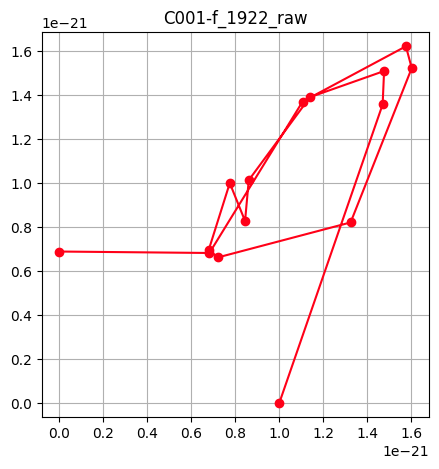

In [ ]:
import struct
import os
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configuration
INPUT_DIR = Path("/content/drive/MyDrive/competition_POT")
OUTPUT_DIR = Path("/mnt/data/chain_codes")
PLOTS_DIR = Path("/mnt/data/plots")
DIRECTION_CODES = 'abcdefgh'
STROKE_DELIMITER = '|'  # Special delimiter between strokes

# Helper to ensure directories exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def read_pot_file_with_tags(file_path):
    characters = []
    try:
        with open(file_path, 'rb') as f:
            while True:
                tag_bytes = f.read(4)
                if len(tag_bytes) < 4:
                    break  # End of file
                gb_tag = int.from_bytes(tag_bytes, byteorder='little')
                gb1 = (gb_tag & 0xFF00) >> 8
                gb2 = gb_tag & 0x00FF
                try:
                    char = bytes([gb1, gb2]).decode('gb2312')
                except:
                    char = '?'
                strokes = []
                while True:
                    data = f.read(8)
                    if len(data) < 8:
                        break
                    try:
                        x, y = struct.unpack('ff', data)
                        if math.isnan(x) or math.isnan(y):
                            break  # delimiter or invalid data
                        if not strokes or not strokes[-1]:
                            strokes.append([])
                        strokes[-1].append((x, y))
                    except:
                        break
                    # Detect pen-up (zero segment)
                    if x == 0 and y == 0 and strokes[-1]:
                        strokes.append([])
                characters.append((char, [s for s in strokes if len(s) > 1]))
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    return characters

def normalize_stroke(stroke):
    arr = np.array(stroke)
    min_xy = np.min(arr, axis=0)
    max_xy = np.max(arr, axis=0)
    range_xy = max_xy - min_xy
    range_xy[range_xy == 0] = 1
    normalized = (arr - min_xy) / range_xy
    return normalized.tolist()

def stroke_to_freeman_code(stroke):
    code = []
    for (x1, y1), (x2, y2) in zip(stroke[:-1], stroke[1:]):
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.degrees(math.atan2(dy, dx))
        angle = (angle + 360) % 360
        idx = int(round(angle / 45) % 8)
        code.append(DIRECTION_CODES[idx])
    return ''.join(code)

def plot_strokes(strokes, name):
    plt.figure(figsize=(5, 5))
    cmap = cm.get_cmap('hsv', len(strokes))
    for i, stroke in enumerate(strokes):
        if len(stroke) > 1:
            x, y = zip(*stroke)
            plt.plot(x, y, marker='o', color=cmap(i))
    plt.title(name)
    plt.axis('equal')
    plt.grid(True)
    plot_file = PLOTS_DIR / f"{name}.png"
    plt.savefig(plot_file)
    plt.close()
    print(f"Saved plot to: {plot_file}")

def process_file(file_path):
    characters = read_pot_file_with_tags(file_path)
    for index, (hanzi_char, strokes) in enumerate(characters):
        strokes = [s for s in strokes if len(s) > 1]
        normalized = [normalize_stroke(s) for s in strokes]
        codes = [stroke_to_freeman_code(s) for s in normalized]
        joined_code = STROKE_DELIMITER.join(codes)

        char_id = f"{file_path.stem}_{index}"
        out_file = OUTPUT_DIR / f"{char_id}.txt"
        with open(out_file, 'w', encoding='utf-8') as f:
            f.write(f"Character: {hanzi_char}\n")
            f.write(f"Freeman Code: {joined_code}\n")
        print(f"Saved Freeman codes to: {out_file}")

        plot_strokes(strokes, f"{char_id}_raw")
        plot_strokes(normalized, f"{char_id}_normalized")

def batch_process():
    files = list(INPUT_DIR.glob("*.pot"))
    print(f"Found {len(files)} .pot files to process.")
    for f in files:
        print(f"Processing {f.name}...")
        process_file(f)
    print("Batch processing completed.")

# Run processing
batch_process()


In [ ]:
import struct
import os
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configuration
INPUT_DIR = Path("/content/drive/MyDrive/competition_POT")
OUTPUT_DIR = Path("/mnt/data/chain_codes")
PLOTS_DIR = Path("/mnt/data/plots")
DIRECTION_CODES = 'abcdefgh'
STROKE_DELIMITER = '|'  # Special delimiter between strokes

# Helper to ensure directories exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def read_pot_file_with_tags(file_path):
    characters = []
    try:
        with open(file_path, 'rb') as f:
            while True:
                tag_bytes = f.read(4)
                if len(tag_bytes) < 4:
                    break
                gb1 = tag_bytes[1]
                gb2 = tag_bytes[0]
                gb_hex = f"0x{gb1:02x}{gb2:02x}"
                try:
                    char = bytes([gb1, gb2]).decode('gb2312')
                except:
                    char = '?'

                num_strokes_data = f.read(4)
                if len(num_strokes_data) < 4:
                    break
                num_strokes = struct.unpack('I', num_strokes_data)[0]

                strokes = []
                for _ in range(num_strokes):
                    num_points_data = f.read(4)
                    if len(num_points_data) < 4:
                        break
                    num_points = struct.unpack('I', num_points_data)[0]

                    stroke = []
                    for _ in range(num_points):
                        point_data = f.read(8)
                        if len(point_data) < 8:
                            break
                        x, y = struct.unpack('ff', point_data)
                        if not math.isnan(x) and not math.isnan(y):
                            stroke.append((x, y))
                    if len(stroke) > 1:
                        strokes.append(stroke)

                if strokes:
                    characters.append((char, gb_hex, strokes))
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    return characters

def normalize_stroke(stroke):
    arr = np.array(stroke)
    min_xy = np.min(arr, axis=0)
    max_xy = np.max(arr, axis=0)
    range_xy = max_xy - min_xy
    range_xy[range_xy == 0] = 1
    normalized = (arr - min_xy) / range_xy
    return normalized.tolist()

def stroke_to_freeman_code(stroke):
    code = []
    for (x1, y1), (x2, y2) in zip(stroke[:-1], stroke[1:]):
        dx, dy = x2 - x1, y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.degrees(math.atan2(dy, dx))
        if math.isnan(angle):
            continue
        angle = (angle + 360) % 360
        idx = int(round(angle / 45) % 8)
        code.append(DIRECTION_CODES[idx])
    return ''.join(code)

def plot_strokes(strokes, name):
    plt.figure(figsize=(5, 5))
    cmap = cm.get_cmap('hsv', len(strokes))
    for i, stroke in enumerate(strokes):
        if len(stroke) > 1:
            x, y = zip(*stroke)
            plt.plot(x, y, marker='o', color=cmap(i))
    plt.title(name)
    plt.axis('equal')
    plt.grid(True)
    plot_file = PLOTS_DIR / f"{name}.png"
    plt.savefig(plot_file)
    plt.close()
    print(f"Saved plot to: {plot_file}")

def process_file(file_path):
    characters = read_pot_file_with_tags(file_path)
    for index, (hanzi_char, gb_hex, strokes) in enumerate(characters):
        normalized = [normalize_stroke(s) for s in strokes]
        codes = [stroke_to_freeman_code(s) for s in normalized]
        joined_code = STROKE_DELIMITER.join(codes)

        char_id = f"{file_path.stem}_{index}"
        out_file = OUTPUT_DIR / f"{char_id}.txt"
        with open(out_file, 'w', encoding='utf-8') as f:
            f.write(f"Character: {hanzi_char}\n")
            f.write(f"GB Tag: {gb_hex}\n")
            f.write(f"Freeman Code: {joined_code}\n")
        print(f"Saved Freeman codes to: {out_file}")

        plot_strokes(strokes, f"{char_id}_raw")
        plot_strokes(normalized, f"{char_id}_normalized")

def batch_process():
    files = list(INPUT_DIR.glob("*.pot"))
    print(f"Found {len(files)} .pot files to process.")
    for f in files:
        print(f"Processing {f.name}...")
        process_file(f)
    print("Batch processing completed.")

# Run processing
batch_process()


Found 1 .pot files to process.
Processing C001-f.pot...
Saved Freeman codes to: /mnt/data/chain_codes/C001-f_0.txt


<ipython-input-16-8fc22d5bf3c0>:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('hsv', len(strokes))


Saved plot to: /mnt/data/plots/C001-f_0_raw.png
Saved plot to: /mnt/data/plots/C001-f_0_normalized.png
Batch processing completed.


In [ ]:
import struct
from pathlib import Path
import math

# Define Freeman direction codes (a to h for 0 to 7 directions)
DIRECTION_CODES = 'abcdefgh'

def read_pot_file(file_path):
    """Read the .pot file and extract character data and strokes."""
    characters = []
    with open(file_path, 'rb') as f:
        while True:
            # Read sample size (2 bytes, little-endian unsigned short)
            sample_size_data = f.read(2)
            if len(sample_size_data) < 2:
                break  # End of file
            sample_size = struct.unpack('<H', sample_size_data)[0]
            if sample_size == 0:
                break  # Invalid sample size

            # Read tag code (4 bytes, GB code in first 2 bytes)
            tag_code_data = f.read(4)
            if len(tag_code_data) < 4:
                break
            gb_code = tag_code_data[0:2]
            try:
                char = gb_code.decode('gb2312', errors='replace')
            except:
                char = '?'  # Fallback for invalid encoding

            # Read stroke number (2 bytes, little-endian unsigned short)
            stroke_num_data = f.read(2)
            if len(stroke_num_data) < 2:
                break
            stroke_num = struct.unpack('<H', stroke_num_data)[0]

            # Read stroke data
            strokes = []
            for _ in range(stroke_num):
                stroke = []
                while True:
                    point_data = f.read(4)
                    if len(point_data) < 4:
                        break
                    x, y = struct.unpack('<hh', point_data)  # Signed shorts
                    if x == -1 and y == 0:  # Stroke end marker
                        break
                    stroke.append((x, y))
                if len(stroke) > 1:  # Only include strokes with multiple points
                    strokes.append(stroke)

            # Read character end marker
            end_marker_data = f.read(4)
            if len(end_marker_data) < 4:
                break
            end_x, end_y = struct.unpack('<hh', end_marker_data)
            if end_x != -1 or end_y != -1:
                continue  # Skip if end marker is invalid

            if strokes:  # Only add characters with valid strokes
                characters.append((char, strokes))
    return characters

def compute_freeman_code(stroke):
    """Compute Freeman chain code for a stroke."""
    code = []
    for i in range(len(stroke) - 1):
        x1, y1 = stroke[i]
        x2, y2 = stroke[i + 1]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0 and dy == 0:
            continue  # Skip if no movement
        angle = math.degrees(math.atan2(dy, dx))
        angle = (angle + 360) % 360  # Normalize to 0-360
        direction = int(round(angle / 45)) % 8  # Map to 0-7
        code.append(DIRECTION_CODES[direction])
    return ''.join(code)

def process_characters(characters):
    """Process characters and format output with Hanzi and Freeman codes."""
    output = []
    for char, strokes in characters:
        freeman_codes = [compute_freeman_code(stroke) for stroke in strokes]
        freeman_str = '|'.join(freeman_codes)
        output.append(f"{char}\n{freeman_str}")
    return output

def main():
    """Main function to process the .pot file and print results."""
    file_path = Path("/content/drive/MyDrive/competition_POT/C001-f.pot")
    if not file_path.exists():
        print(f"Error: File {file_path} not found.")
        return
    characters = read_pot_file(file_path)
    output = process_characters(characters)
    for line in output:
        print(line)

if __name__ == "__main__":
    main()

“
cccdf|aahcd|ag|aaddfabddefggfccccccccg|bahecccfgf|bccccg|baacdd|aa
��
aacdefabcdefggbccccch|aahgfcccceffgcbccdg|aadce|bah
０
gaag|ccccccdfgaahg|cdhahggcceeebcddfgg|ahhdbaahgffeccccdfghhabag
ぐ
aagggedccccfffeeahhh|cchaaggcd|abcddeg|aahdhaahgff|dccccdffg|abbba
グ
acccg|aaagdcc|baag|haaf|bag|cdd|bbbb|cd
Π
dbcdgg|baaheccc|bhaaag|bccddfhaaag|cccd|bccddg|aahed|hahgf|dcccdef|baah
О
bcdde|aaagf|cdf|aadd|aahfeddddeghabccdhaggffdcbbbbg|cdd
ò
ccddefhbccgg|aaagfcccg|baadd|bahgg|bcccegahgf|cch|ccd|aaadeeaaaf|cccddfgaahgg
┌
gbccddfffaahee|abbcccff|bbcdehh|bccccg|aadehaafe|bbcdeegghaacddehahhg|cccgghaadeaee|abcdddhhaahff|hbccda|ccccce
��
dgaaahe|cbbgg|cddee|bbddd|abcccdhgggfdccdg|baaedce|aaddeehaage|cdegh|hahccggf|cccdghaaahgg|fbccddeg|ba
��
bcccdefg|hahddaahffbcccdg|bbbag|aaddeaaagffdcccccg|dddhhaaed|aahffffdcccaaaf|ccdd
��
gaaage|bhg|cdddfabbbcbgg|cddd
��
faaeddeeabbcccccgg|baahddcc|aahg|bccceg|baaaheccc|abdeefhahddaaahddeeagfeccccfghhhh
��
aahfe|cbg|bahhgdddd|bbcdfg|aaaahdddd|aaff|dccccddf|haaaddd

In [ ]:
import struct
from pathlib import Path
import math
import numpy as np
import matplotlib.pyplot as plt

# Define Freeman direction codes (a to h for 0 to 7 directions)
DIRECTION_CODES = 'abcdefgh'

def read_pot_file(file_path):
    """Read the .pot file and extract character data and strokes."""
    characters = []
    with open(file_path, 'rb') as f:
        while True:
            sample_size_data = f.read(2)
            if len(sample_size_data) < 2:
                break
            sample_size = struct.unpack('<H', sample_size_data)[0]
            if sample_size == 0:
                break

            tag_code_data = f.read(4)
            if len(tag_code_data) < 4:
                break
            gb_code = tag_code_data[0:2]
            try:
                char = gb_code.decode('gb2312', errors='replace')
            except:
                char = '?'

            stroke_num_data = f.read(2)
            if len(stroke_num_data) < 2:
                break
            stroke_num = struct.unpack('<H', stroke_num_data)[0]

            strokes = []
            for _ in range(stroke_num):
                stroke = []
                while True:
                    point_data = f.read(4)
                    if len(point_data) < 4:
                        break
                    x, y = struct.unpack('<hh', point_data)
                    if x == -1 and y == 0:
                        break
                    stroke.append((x, y))
                if len(stroke) > 1:
                    strokes.append(stroke)

            end_marker_data = f.read(4)
            if len(end_marker_data) < 4:
                break
            end_x, end_y = struct.unpack('<hh', end_marker_data)
            if end_x != -1 or end_y != -1:
                continue

            if strokes:
                characters.append((char, strokes))
    return characters

def compute_freeman_code(stroke):
    """Compute Freeman chain code for a stroke."""
    code = []
    for i in range(len(stroke) - 1):
        x1, y1 = stroke[i]
        x2, y2 = stroke[i + 1]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.degrees(math.atan2(dy, dx))
        angle = (angle + 360) % 360
        direction = int(round(angle / 45)) % 8
        code.append(DIRECTION_CODES[direction])
    return ''.join(code)

def process_characters(characters):
    """Process characters and format output with Hanzi and Freeman codes."""
    output = []
    for char, strokes in characters:
        freeman_codes = [compute_freeman_code(stroke) for stroke in strokes]
        freeman_str = '|'.join(freeman_codes)
        output.append(f"{char}\n{freeman_str}")
    return output

def normalize_character(strokes):
    """Normalize the entire character's strokes to [0,1] range."""
    all_points = [p for stroke in strokes for p in stroke]
    if not all_points:
        return strokes
    min_x = min(p[0] for p in all_points)
    max_x = max(p[0] for p in all_points)
    min_y = min(p[1] for p in all_points)
    max_y = max(p[1] for p in all_points)
    range_x = max_x - min_x if max_x > min_x else 1
    range_y = max_y - min_y if max_y > min_y else 1
    normalized_strokes = [
        [((p[0] - min_x) / range_x, (p[1] - min_y) / range_y) for p in stroke]
        for stroke in strokes
    ]
    return normalized_strokes

def plot_character(char, strokes, filename):
    """Plot the character's strokes and save to file."""
    normalized_strokes = normalize_character(strokes)
    plt.figure(figsize=(5, 5))
    colors = plt.get_cmap('hsv')(np.linspace(0, 1, len(normalized_strokes)))
    for i, stroke in enumerate(normalized_strokes):
        if len(stroke) > 1:
            x, y = zip(*stroke)
            plt.plot(x, y, color=colors[i])
    plt.title(char)
    plt.gca().set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.savefig(filename)
    plt.close()

def main():
    """Main function to process the .pot file, print results, and plot characters."""
    plots_dir = Path("plots")
    plots_dir.mkdir(exist_ok=True)
    file_path = Path("/content/drive/MyDrive/competition_POT/C001-f.pot")
    if not file_path.exists():
        print(f"Error: File {file_path} not found.")
        return
    characters = read_pot_file(file_path)
    output = process_characters(characters)
    for i, line in enumerate(output):
        print(line)
        char, strokes = characters[i]
        plot_character(char, strokes, plots_dir / f"character_{i}.png")

if __name__ == "__main__":
    main()

“
cccdf|aahcd|ag|aaddfabddefggfccccccccg|bahecccfgf|bccccg|baacdd|aa
��
aacdefabcdefggbccccch|aahgfcccceffgcbccdg|aadce|bah
０
gaag|ccccccdfgaahg|cdhahggcceeebcddfgg|ahhdbaahgffeccccdfghhabag
ぐ
aagggedccccfffeeahhh|cchaaggcd|abcddeg|aahdhaahgff|dccccdffg|abbba
グ
acccg|aaagdcc|baag|haaf|bag|cdd|bbbb|cd
Π
dbcdgg|baaheccc|bhaaag|bccddfhaaag|cccd|bccddg|aahed|hahgf|dcccdef|baah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65296 (\N{FULLWIDTH DIGIT ZERO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12368 (\N{HIRAGANA LETTER GU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


О
bcdde|aaagf|cdf|aadd|aahfeddddeghabccdhaggffdcbbbbg|cdd
ò
ccddefhbccgg|aaagfcccg|baadd|bahgg|bcccegahgf|cch|ccd|aaadeeaaaf|cccddfgaahgg
┌
gbccddfffaahee|abbcccff|bbcdehh|bccccg|aadehaafe|bbcdeegghaacddehahhg|cccgghaadeaee|abcdddhhaahff|hbccda|ccccce
��
dgaaahe|cbbgg|cddee|bbddd|abcccdhgggfdccdg|baaedce|aaddeehaage|cdegh|hahccggf|cccdghaaahgg|fbccddeg|ba
��
bcccdefg|hahddaahffbcccdg|bbbag|aaddeaaagffdcccccg|dddhhaaed|aahffffdcccaaaf|ccdd
��
gaaage|bhg|cdddfabbbcbgg|cddd
��
faaeddeeabbcccccgg|baahddcc|aahg|bccceg|baaaheccc|abdeefhahddaaahddeeagfeccccfghhhh
��
aahfe|cbg|bahhgdddd|bbcdfg|aaaahdddd|aaff|dccccddf|haaaddddefghhbbah
��
aabddehabbddeffggcccccdgg|ccbbbhggedddaaaffedddeghhhbbfe|bccdgg|baaaedccf|cbg|cdddeehaaaag
鞍
eaaahf|ccdccchhaahggfee|bcfg|baadeegaaahgfffecccccggfbaahhg|bbcd|bcg|aaaaddd|aaafg|ccddhhabbbgf|dccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38797 (\N{CJK UNIFIED IDEOGRAPH-978D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21329 (\N{CJK UNIFIED IDEOGRAPH-5351}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33334 (\N{CJK UNIFIED IDEOGRAPH-8236}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


卑
cccccdg|aaadedaaddeeaaahddcbag|cbde|bbbcegg|haaadd|faagf|ecccddghhbbf|cde
舶
cbdd|bcdefg|baaaddd|aaf|cccccddeghabbg|dccdd
嘲
bcddd|bcccg|cahgg|cddeg|bbhe|cbcdcef|baahedcc|cabdd|aag|cccddfahaaaggg
窗
aaf|cccccccccbfffahhh|ccd|bcdf|aaaadcce|aag|ccccddhhabbaf|eccde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22066 (\N{CJK UNIFIED IDEOGRAPH-5632}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31383 (\N{CJK UNIFIED IDEOGRAPH-7A97}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34507 (\N{CJK UNIFIED IDEOGRAPH-86CB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26635 (\N{CJK UNIFIED IDEOGRAPH-680B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蛋
eccccdf|aahgdccchg|baad|haaag|cccdefhahaf|bbahgcddegaaahge|cccefg|bahddc|aad|aaaag
栋
ccddghaagff|cccbhg|cdd|afe|bccddde|baaaed|aaaggfdccccc
钒
ccccdef|baadccfgf|gaabdddhah|cccd|bcdg|aaafdcd|aagff|ccdahhabagf|dccdd
赴
ccd|bccg|aaaagdcd|haaaf|ccddeghabagg|cddddefhaaagf|cccccg|dddhhaabba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38034 (\N{CJK UNIFIED IDEOGRAPH-9492}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36212 (\N{CJK UNIFIED IDEOGRAPH-8D74}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25329 (\N{CJK UNIFIED IDEOGRAPH-62F1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21898 (\N{CJK UNIFIED IDEOGRAPH-558A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


拱
eccddd|baagddcccfff|baddegaah|cdfahfe|bccdde|bbaaacghaggg
喊
cccf|aaagecdd|aaaddeeaahe|af|cccdfghhggahaabccggfcbccf
话
ccf|baahddd|aaaahgf|cccccdegg|abbae|cccdeg|aahecde|bahhggccdeeeaaaaef
及
aahgccgaagaafdccfeeeeggggahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35805 (\N{CJK UNIFIED IDEOGRAPH-8BDD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21450 (\N{CJK UNIFIED IDEOGRAPH-53CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26728 (\N{CJK UNIFIED IDEOGRAPH-6868}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26223 (\N{CJK UNIFIED IDEOGRAPH-666F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


桨
aahed|gaaahed|ahff|cbcccccde|agcaggccddef|aahgcccfffg|bccdeghhaeddbbgg|ccdd
景
haad|aaddehahgf|ccccde|ccdddghahdccfff|accddehafeedcbbbag|dddcd|bddddghhabbbaggbcbah|bbb
堪
cdde|bbddef|aaahdccf|aadeeaae|gaaahfe|bccdddefg|be|aag|cccdg|daahffdccff|bccddeghhhaaaaedccdffggbbcddhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22570 (\N{CJK UNIFIED IDEOGRAPH-582A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33098 (\N{CJK UNIFIED IDEOGRAPH-814A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28063 (\N{CJK UNIFIED IDEOGRAPH-6D9F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


腊
bbcddeffaaadehabbcccgg|cdhaabhg|cbaaae|ahgf|cccccdeg|bbbbba
涟
ccddehabccccg|baaddabdehaaagffcccddbbccdhghbaahgcccggg|bcdfhaeeecbbbgg|edccde
掳
cddf|bccdfg|haaaadccf|bbagcddeahgfffgbcccg|ddehhabde|aaaffffbccdddh|bbbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25523 (\N{CJK UNIFIED IDEOGRAPH-63B3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20882 (\N{CJK UNIFIED IDEOGRAPH-5192}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38476 (\N{CJK UNIFIED IDEOGRAPH-964C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


冒
ebbcccccccgggfddhhabbg|cdddeebccdfggghaaadcccef|bbhddaggffedcccdfggdddhaabedd|aahfffcdddfgghhabbbaah
陌
cccd|abccchhggghccdddeegbccggghbbaaahdcf|bbagdddhhahhffecccdggggddhabgee|baaaagfddccdehhbbbaa
虐
gbaahf|bh|ccddehhaafdcgffdbcdefhaagf|bccdddhhaggggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34384 (\N{CJK UNIFIED IDEOGRAPH-8650}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29922 (\N{CJK UNIFIED IDEOGRAPH-74E2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


瓢
cbbaahgf|cccccgfahhh|dccccggaaddaaddddaaagccgfg|cbccdddefg|accg|cccdfff
前
aahgg|ccccccccffghhhh|cccccdh|bba
劝
ccccccdg|baadcc|fhaaahg|fecccccg|bba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21149 (\N{CJK UNIFIED IDEOGRAPH-529D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30722 (\N{CJK UNIFIED IDEOGRAPH-7802}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25342 (\N{CJK UNIFIED IDEOGRAPH-62FE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


砂
ccccccg|baadcccd|faaaag|ahgddcbggffbcccdefaagf|ccccddffghaaagggg
拾
abaahe|cddghhbhgh|adhabbee|haaacgfccdefhahgff|cccdefhaaaggf
税
cccccddgh|bbbba
贪
ccddefghaahfee|bcccddf|gbbccdefghhhh|bbaaafedcfffcccdfgaagff|fcccccccddfaahgggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31246 (\N{CJK UNIFIED IDEOGRAPH-7A0E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36138 (\N{CJK UNIFIED IDEOGRAPH-8D2A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26742 (\N{CJK UNIFIED IDEOGRAPH-6876}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20255 (\N{CJK UNIFIED IDEOGRAPH-4F1F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


桶
aaahfedccggfcccefaagf|fccccdddchaaaggg
伟
aaagffcccfffghhhhaagfffccddfgg|haahddeggabbbag|cbb
习
bbccg|aaadeegaaahgddccccggghbadeaagf|cccccdf|bahhge|cccccddfg|aahdcdefgghabbbbhgf|cbb
邪
haaaff|dccdddchaagfff|cbccdghaaadeaahggffccdffghaaahg|aaccf|ccccdfgaaggff|dccdeaahggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37034 (\N{CJK UNIFIED IDEOGRAPH-90AA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23547 (\N{CJK UNIFIED IDEOGRAPH-5BFB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37326 (\N{CJK UNIFIED IDEOGRAPH-91CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


寻
baaahgff|fcccccccccffahhh|baaadcgffbbccddeghaahgf|dccdhaaagggg
野
baae|aadeaahgff|cccccddggdddhhabbg|baabecgg|cccdehabgf|ebcccdefaaaggg
影
daaf|cccccddffaahg|dbcccdghhaahcdfggcccccghabbbah
园
gaaaaeecccf|eccccggacddeeffgbbghcdddd|aagfffdcchahgeed|cceggaaadehaahgffcccdefhhaahgg|eccccccdefg|aahfcccbgfffaadhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22253 (\N{CJK UNIFIED IDEOGRAPH-56ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30651 (\N{CJK UNIFIED IDEOGRAPH-77BB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32844 (\N{CJK UNIFIED IDEOGRAPH-804C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


瞻
ebbcdfg|aaadccdff|cbghcdddeaaed|aadeahhff|cccddefghhaahhgg|bbbb
职
cdddhhhabe|baggedddhhaaadddggfedccddffhahff|bccdddhhaaagg
装
abcdddg|bcccfg|aaaaheccbf|bbaadd|aaaa
匕
aahgf|cccccccg|cddhabaahg|ccdf|bccdg|baahdcccbf|daaadd|aaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35013 (\N{CJK UNIFIED IDEOGRAPH-88C5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21269 (\N{CJK UNIFIED IDEOGRAPH-5315}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20372 (\N{CJK UNIFIED IDEOGRAPH-4F94}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


侔
aaaddde|bcccddg|aaaaedccgf|ebaadd|aaa
诎
haaagf|cccccccccbgfahhhhcdccghaaadcf|cbhhghdddhaaaedehaaadeaahggfcccdegghaaagg|ccb
郯
hbcdddefghabbcccdg|aaaadddf|bbcccdgg|baaaccc|aabddddaaag
馨
bbcceg|baaddfg|ecccccddhhbbbgg|ccccdeghhaedbbbbg|ccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35790 (\N{CJK UNIFIED IDEOGRAPH-8BCE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37103 (\N{CJK UNIFIED IDEOGRAPH-90EF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39336 (\N{CJK UNIFIED IDEOGRAPH-99A8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


莅
cbaaaaed|haaadeaahf|cccccddf|baaadeeabadeaadeeehaaaff|fcccccc
薨
hhhd|aaagffeccccgg|dddhhhbbhg|ccdd|bcdeg|bbaaahdccf|caaag|cccfhahe|ccddghaahggffeecccccf
甙
haaeedccdff|aaddeghahg|cccdghaeddbbbg|cccddg|bbaaahfdccdgg|aadddegaaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33669 (\N{CJK UNIFIED IDEOGRAPH-8385}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34216 (\N{CJK UNIFIED IDEOGRAPH-85A8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29977 (\N{CJK UNIFIED IDEOGRAPH-7519}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


喟
daahffeddccg|baddeaagggaccg|ccccdeef|bahheeccdfg|baadddehaaahg
岚
fghaafgffeccccgffaahhhhccdccdgbbcccdfg|bbaahedcccggf|aahffffdccchhgg|dccchhcbahf|chaabdddddfg|hbbaa
獍
baafecccffhhhgfahheddccccgggahccdefgg|habbaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21919 (\N{CJK UNIFIED IDEOGRAPH-559F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23706 (\N{CJK UNIFIED IDEOGRAPH-5C9A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29517 (\N{CJK UNIFIED IDEOGRAPH-734D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24774 (\N{CJK UNIFIED IDEOGRAPH-60C6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27986 (\N{CJK UNIFIED IDEOGRAPH-6D52}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


惆
gccccddeghbccccdeg|baaaeddccggf|gaaaahgffcchhhg|dccccggghaahdcbbaeeaadddefg|bbbbah
浒
ccccddefgh|bceeeaahdcccggffccddefg|bahddefghbccdefgghaaaadcddg|ccccddegg|bbah
灏
fahgg|ccccccg|ddhhhabg|ghhedddccccdggghhhccceff|bbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28751 (\N{CJK UNIFIED IDEOGRAPH-704F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23000 (\N{CJK UNIFIED IDEOGRAPH-59D8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32488 (\N{CJK UNIFIED IDEOGRAPH-7EE8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


姘
baaaagffccf|ebbccbccdddgg|aafdcccggg|bahgf|cccdg|ghaacdf|bbba
绨
aahgg|ccccccffhhhh|acccddeg|bbdde|aaahfdccbggffccdde
璋
aaahgg|ccccccfhhhg|cbbaggccddefghaaadhag|cccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29835 (\N{CJK UNIFIED IDEOGRAPH-748B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27032 (\N{CJK UNIFIED IDEOGRAPH-6998}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33255 (\N{CJK UNIFIED IDEOGRAPH-81E7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


榘
cddddfg|bccccgg|cbbahgggfedddcaaadeaaagg|cccce
臧
ccdef|aahedcbbbahgggfcdddehageddahgffccddef|aahhf|ccccddeg|cccddhhaggcbbgg|cbbbcc|cccddeg|aheeddcbbahgedddehadaagffcce
氚
ccbbahg|dddeaadeegaaaagf|ccccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27674 (\N{CJK UNIFIED IDEOGRAPH-6C1A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24384 (\N{CJK UNIFIED IDEOGRAPH-5F40}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25094 (\N{CJK UNIFIED IDEOGRAPH-6206}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


彀
baahddccfffg|ccccdef|dd|bbg
戆
ccddhabbcddefabccddhhahgg|cbbbaggdddhaedehaaagggggecccd
畎
faadehabbdeaahgg|cccccdef|haaddfhbbcdeffggcccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30030 (\N{CJK UNIFIED IDEOGRAPH-754E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38151 (\N{CJK UNIFIED IDEOGRAPH-9507}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40482 (\N{CJK UNIFIED IDEOGRAPH-9E22}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锇
faaeeabdehaaagggffdcccdf|baadehabcddfggccdd|cccbhhaddeffggaccccd
鸢
dbaaaagff|ccccggcddehhabbagg|aaaddehabdehagg|fcbcccccd|aaddeghbbdefgggbccccc
癜
aaagg|cccccccdggdddddhhabgg|cccdfhageeedbahgdddee|ccccghhaaadddff|ccccdeffhaaahge|bccddf|ahdccfff
虬
ccccdf|baaadcccggfaabbcddghaah|ccddhhaeeedcbbahgggddddeegabccgghaaadddff|cccdefgaahgfe|cbbccdff|aagccfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30300 (\N{CJK UNIFIED IDEOGRAPH-765C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34412 (\N{CJK UNIFIED IDEOGRAPH-866C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蟀
cccddhacdeghabddhahgg|caaadehbdddfhahggg|cccccddf|aadhabccdeffgccccc
舭
bahggfccccgg|dddhhabbg|aaaddhbdehaagg|ccccddefg|bbbgee|habdaaggfccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34752 (\N{CJK UNIFIED IDEOGRAPH-87C0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33325 (\N{CJK UNIFIED IDEOGRAPH-822D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


醢
aaddddeghabcccf|cbaadc|fahaahg|dccdfhaaeeeccbahgfedddde|hagaabccggaahdddf|cccddfgaaaeecccddggg|ahdccfff
霭
cccf|aadeehaahg|ccccccdhaaaghcchg|aaadeabddehaahhgf|cccccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37282 (\N{CJK UNIFIED IDEOGRAPH-91A2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38701 (\N{CJK UNIFIED IDEOGRAPH-972D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


靼
hbcdddhabddhadeaaaggffdcccahhggg|gcccdhaeeebbahgdddececccghaaddffebccddfhahfeecccdfgg|aahccfff
��
bcdddfg|cccccgg|ccdehaabaeeebbahgfdde|bccghaaaaddg|cccdffaaafeedccdfg|aahdccfffg
��
hbbccdeffbbbccddhhhgg|dcccdfaaeeecbbhhggddeef|bbcdfg|baahddddf|cccdeghageebcccdef|aaahccfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38780 (\N{CJK UNIFIED IDEOGRAPH-977C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
eaaaahfe|bbcggg|ccddefg|hccdddhaahgccccggfffaaaddehafffcccdefaaaahhgggg
��
gbbcccddf|baaagdccbbffggaaabddag|ddccahcgf|fgaaddaahgf|dbccddfaaagggg
��
ccddhaagcccgf|haaaddaaffecccdhhaahgggg
��
ccddfeaagee|dddfhhbbccdgg|haccfgghhaadhadeaaagfeecccg|ddhhhaabee|hhacddfhaacccdhahgffbbahg|fcddd
��
aaahgfdccdde|baadeaahfdccffffhaabcdeha|acddehaaahggcbhggcceeff
”
chgaaafee|bbg|ccdd|hbcdabcchcaaecccefg|bccccgggabaahdcccff|faadeagg|cccccddeeghaahgffdccdfghah
⒈
haaaeecf|cccccegghaaaadcddffffcaafchahh|cbccddhade|dddhhahdccf|gaaadagfeedcccddehagg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9352 (\N{DIGIT ONE FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65297 (\N{FULLWIDTH DIGIT ONE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12369 (\N{HIRAGANA LETTER KE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


１
cddddh|abcccccdfg|cccg|aaddehaedeaaahffccfg|ddhhabbbaah
け
acdddhhabcccdfg|cccghhabddehaadeaahgfffecccgg|cddeg|bddhaagffccccddfffaah
ケ
gabcccchhaaddefggdbcchhgg|dccaaagcf|fhaadaaffdccccceghaaahhggf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12465 (\N{KATAKANA LETTER KE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


Ρ
ccdd|bbbbghaaahddd|aahggeedccgacdddaahgff|bca
П
aaahgf|fccccccfhhhhg|ddcacccffaadafffccchaaagfgg
ū
aaaggf|gcccffhhhhaadddgebbcccegggaaddefg|bbb
┍
hbbcf|aahgdd|dbbaadehbddehaahffeeeeccg|ccccdd|aaaeddd|bbahfe|cccccefffaadddh|ddgabbb
��
dhahge|bbbg|cccdde|fhahhd|fbdddhhhabccff|haabdeghabddhhh|bcddhagccffebhegghgahaccdccccccccdcddfffggcbbf
��
dgddggbbcdddhhaahddde|bbccdg|cbaaheddce|daaahffccccdddhaadddhahhg|ecccafdcccfffffhaabdddhfecccdhaagggg
��
dabbg|dcccccefg|cccddhhbgg|cbcfghhaaaagdd|baaaebadeeahfeeeccchhg|cccccde|aaeddhhhhaabbee|bcccdffg|aabdddh|accddhabb
��
ghaggf|cccccccgg|ddhhabag|baaddegabbccccdfgghhbba
��
gaadde|abccccg|bbaadcc|aagg|fcccddfffhabccdfg|bahccd|aaggffdccddehhaagee|bcccddfghhaaahhgffdcc
��
gccccccfg|aabbdeeabdahhgggcccfggghhabadhabdafe|dccbbahgf|ba|beee|eaca
氨
ccddehaabccg|aaaddcde|ahg|cccddfghaabhe|dcccdfghahgffedccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27688 (\N{CJK UNIFIED IDEOGRAPH-6C28}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21271 (\N{CJK UNIFIED IDEOGRAPH-5317}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33046 (\N{CJK UNIFIED IDEOGRAPH-8116}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28526 (\N{CJK UNIFIED IDEOGRAPH-6F6E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


北
cccccccf|dbadhaaahg|cccccdghahgg|cccg
脖
fcccccg|fbaedehaddegaahhg|gccccccgg|aadegabcdehadd|aaagf|cccdhhaagfeccefghaaaah
潮
cccccceg|faaacddaahg|dccccahh|eddd|cbbcdfg|habbahgdcgffaaddhaab
幢
bbccdb|baaddf|ebccccddfg|abbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24162 (\N{CJK UNIFIED IDEOGRAPH-5E62}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24403 (\N{CJK UNIFIED IDEOGRAPH-5F53}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20375 (\N{CJK UNIFIED IDEOGRAPH-4F97}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32321 (\N{CJK UNIFIED IDEOGRAPH-7E41}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


当
bcdddhhaabddehaadeaagffdccbaahhg|cccgggbbbaadddgggbbcccddg|bbbba
侗
eccddeg|abcccdfgg|cccddfhaaaaeebbgdddfhhaahgeddebcccdf|aaaadcd|caaag
繁
eaaggeefbcccffahhhhhhgccggbaadddf|dbccccdeghbbba
副
ccdegg|aahcddef|abbbaee|dbcccff|aaahddccde|haaaffffccccdebhaabh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21103 (\N{CJK UNIFIED IDEOGRAPH-526F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36129 (\N{CJK UNIFIED IDEOGRAPH-8D21}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32597 (\N{CJK UNIFIED IDEOGRAPH-7F55}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27088 (\N{CJK UNIFIED IDEOGRAPH-69D0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


贡
ccddhhghaahddddefghaabbaee|gbbcdefg|haahdccdf|haaahffffcccddhae|dbbahhgff|bb|bee|ggdd
罕
bbggg|ccccchh|ccdhabg|dccdffhadedbbbahgggddddhaaahfe|bccg|baaahdddf|eaaaaa
槐
bbdddehabddhbcccdfgg|gddhaahgg|haaaddefggbbccdgg|bccccdfghaddffgghbbbaah
急
haaahf|dcddfg|bbbbe|gaaaggf|eccddfaaahfe|bcccdh|cccb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24613 (\N{CJK UNIFIED IDEOGRAPH-6025}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22870 (\N{CJK UNIFIED IDEOGRAPH-5956}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39048 (\N{CJK UNIFIED IDEOGRAPH-9888}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21208 (\N{CJK UNIFIED IDEOGRAPH-52D8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


奖
fagagaaaagfe|cbbbba|ccdddefgaagff|bccccccccgggghdddhhabbbee|ggcaah
颈
gaahgg|ccccccccggddhhhabbccddeefhaaaah
勘
dbaahgfe|cchhabah|dcddaacddeehaaahgffcccggddahbbddeeaaahg
辣
edccccdhaagffcccaghccddd|bbcccdefg|abahgdcccgffabddeahggcccdggggghbaaahgccgfadhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36771 (\N{CJK UNIFIED IDEOGRAPH-8FA3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24088 (\N{CJK UNIFIED IDEOGRAPH-5E18}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21348 (\N{CJK UNIFIED IDEOGRAPH-5364}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24125 (\N{CJK UNIFIED IDEOGRAPH-5E3D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


帘
ccddeghaabddhabcddfhahhg|ecccccccg|cbahgedcccffhaddehaahggghccccegg|hbaaaagfcccffghacdddeghah
卤
baadeefhhaabccgggbbeee|hbbccdef|abaaahgccgf|gbadddhaahff|fccccd
帽
gaaedhbcceggaadde|aaaecfffacddh|dddhabah
谋
ebbcccdg|baaadehagfddcfggghaaadehaagffeccch|bccdcaffbbhg|cccdd|abccdef|aaahgfdccffgbacdghhggccdgg|aahdcccffgadchhhf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35851 (\N{CJK UNIFIED IDEOGRAPH-8C0B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30111 (\N{CJK UNIFIED IDEOGRAPH-759F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28508 (\N{CJK UNIFIED IDEOGRAPH-6F5C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


疟
bbdd|gaadeghabccddehaaaaff|cbahgdddaadehaagfffeccccdg|cccd
票
cccddefaacddhabcdddeghaaagff|aahfe|ccaghhabbddeaafeddccccgggghaahccf|eaaffcddehaaag
潜
accdddgghbbcdfg|gaaahdcccdf|gaaaedeghaadeaaaee|bcccdf|aaaddde|gaaagffccdefaaed|aaage|gcdddfh|bcccdddhaaahggf
缺
gcccccchhhgg|ccccah|ccccbbahgg|eddc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32570 (\N{CJK UNIFIED IDEOGRAPH-7F3A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26432 (\N{CJK UNIFIED IDEOGRAPH-6740}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21550 (\N{CJK UNIFIED IDEOGRAPH-542E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


杀
ccf|aaadeeaagd|haagffdcccde|abbcdf|aaaahgdccef|gabbcggaaaddeaadehaahh|aadhabccdeffgbccccd
时
cbaahe|ccdghhbhh|cddaadefaaaeeeadeaaahgffffebcccdehaaggggg
吮
cccdgg|cddddefg|bbcccdfgg|aaadddffggccceg|cccdgghabddfgggbba
瘫
cbaahedddcccgg|caaadeghaaahg|eacccdfabcccdg|baahdccef|aabdeaaee|aaaddddghhhbccdfg|haahdccde|daaaaaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30251 (\N{CJK UNIFIED IDEOGRAPH-762B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


捅
gaaaafe|bbbbgg|ccde|cbcddddfhhbccdfgggaaaaedcgffcbbbgfddeeaaaeeeedefeebccbbahgggfcccda|ccccbagggfecdf
伪
aaaafe|bbhg|ccddd|abbhh|dddde|ccdeg|aaaaadccgggf|bcccdg|fddhhabagg|dccdhaafddbbgg|eccccd
媳
dcccbhggfeccah|cccbbahggedddeehaaahgf|ccccc
斜
ecccccbbahggedcccah|gccccbahhgeddddd|eaahgfe|fdabcccdegg|haaaddccfgaaahg|ccccccdgghaagggdc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25413 (\N{CJK UNIFIED IDEOGRAPH-6345}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20266 (\N{CJK UNIFIED IDEOGRAPH-4F2A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23219 (\N{CJK UNIFIED IDEOGRAPH-5AB3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26012 (\N{CJK UNIFIED IDEOGRAPH-659C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


驯
cccccbbbahgg|dcch|bcccbahhggfeddd|dccbbaahff|cba|bfe|caa|cccddd
冶
bghahed|abbccfggghahcdfggccccgg
颖
hbbcddefeeaaage|bcccdg|bcccccchggggdccccba|cccccbhgg|ccd
员
ccccdde|haafe|ccccccceg|hbbcddefhhhhhhccdg|baaadccf|aaggccdefhaahed|haage|cccccdef|cbcdddhahgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39535 (\N{CJK UNIFIED IDEOGRAPH-9A6F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20918 (\N{CJK UNIFIED IDEOGRAPH-51B6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39062 (\N{CJK UNIFIED IDEOGRAPH-9896}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21592 (\N{CJK UNIFIED IDEOGRAPH-5458}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


毡
bccccdag|cbb|bahhgdcccgff|aaaffccdffgahh
直
fbbag|dddd|bbccddfg|aaahdccggg|dcccccgg|fddhhabhg|cccddghaed|dbbg|ccd
妆
ebbbbh|cdd|bbccceg|abahccgg|dcccccccfg|cddhabhhg|ccddfggahfdddcbbbag|eddd|ghaaafe|ebcccdg|ccccg
乇
ecccbbbahhgf|cb|dee|daaa|cccdd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27617 (\N{CJK UNIFIED IDEOGRAPH-6BE1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22918 (\N{CJK UNIFIED IDEOGRAPH-5986}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20039 (\N{CJK UNIFIED IDEOGRAPH-4E47}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


俦
eaahddehage|ebbccccddg|bbbccdef|aaahdcccd|gaaahg|dccceffhahedddcbahhggfdddhaddaahgffdccce
诒
haddeage|bcccddeg|bbcdf|aaahddf|baahhgg|ccdghaedbbbhgddhadahhgecddd|ghaaggffebccddefaag
郾
aaddeaahgfe|bccdddg|bccdf|haaddehahhg|ccdhaeddbagggddeaadhagg|ddcccdd|abbccdef|bbaahecccfffabaaadhaa
鼙
dccddefaabdefhabcdddehaaaagff|haadeaafeecccddggghbccccfgggaaaddehahg|eccdhafeeebbagfddhaadhahgffccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20454 (\N{CJK UNIFIED IDEOGRAPH-4FE6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35794 (\N{CJK UNIFIED IDEOGRAPH-8BD2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37118 (\N{CJK UNIFIED IDEOGRAPH-90FE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40729 (\N{CJK UNIFIED IDEOGRAPH-9F19}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33660 (\N{CJK UNIFIED IDEOGRAPH-837C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34183 (\N{CJK UNIFIED IDEOGRAPH-8587}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24337 (\N{CJK UNIFIED IDEOGRAPH-5

荼
aaacdehaabcefffcccccccgg|dcccbaggfddccaa|hccbahggfdddddeeaagffcccddfgaaag
薇
faaahg|eccdfaahggfed|bcfgghabaaadeahgffecccddefgaahgg|gcccdabcccdfg|baahgd|bbcdff|aaahdccgf|aaabdedaggffdccccddefhabaah
弑
gbcddeghabddeghabccddehahgf|baaedcccgg|cccccde
啾
ecddehabccdddfhabccddeaahgg|cccddfhabddhafeeeebbcccdefg|bccddg|haaacccggfffaaafffchg|ccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21886 (\N{CJK UNIFIED IDEOGRAPH-557E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23708 (\N{CJK UNIFIED IDEOGRAPH-5C9C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29527 (\N{CJK UNIFIED IDEOGRAPH-7357}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


岜
dbbccff|baahdddf|ebbcccddffghaabbbggg|baaahddeabcccdefacdddehaaah
獗
eccdefhaafgbbeeaaedaahfeeebccddefg|abbbccdfg|cbaaahddcffffhaaagfeeccfgg|ccbf
惚
ecddef|bbccddeg|aaahd|bbccdg|aaaadcceff|eaadhahgffccccdefgghhabbaahh
浔
cccddeaaaeedcbggbccceffgabbbahhhhaccdddaadddefghabbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24794 (\N{CJK UNIFIED IDEOGRAPH-60DA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27988 (\N{CJK UNIFIED IDEOGRAPH-6D54}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28766 (\N{CJK UNIFIED IDEOGRAPH-705E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


灞
cbed|aaaaafe|cbccccccdggghabb
姹
cbccdd|aaheeddcbbbhgdddehaaeddehaahf|ccccdf|cbbccf|bcccddef|abccddfhagffeddbbhggddehaddhahfffccccf
绫
cccdde|ghaahaafeddbbagggeddedaaaeddeaaahfffbbcccdd|bcddehabcccccghhg|ccddhafedcbahgddhaafdddegaaaggffedcccf
璞
bbcdde|aahgeed|cbaggdddgaaddddaahgfffccccdef|bhggbhccddfhaddfahcddhhhg|bccdddehahedddcbahgcdehadaaffccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23033 (\N{CJK UNIFIED IDEOGRAPH-59F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32491 (\N{CJK UNIFIED IDEOGRAPH-7EEB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29854 (\N{CJK UNIFIED IDEOGRAPH-749E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27000 (\N{CJK UNIFIED IDEOGRAPH-6978}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


楸
fbccddefhabdhbccddehaaaahgff|fbbcdeaadeaffe|ebbccdef|ccccegg|baaaecccffffahffcccgg|ccccba
瓯
aaagf|cccccdgg|dddhhabbhgg|dbadaaagecccggcch|bbah
氡
haabddeef|ebbcccdeg|dccccccbhgfedcbahggf|caad|ccccfgg|bbahcbhhgg|cccde|cddd|bcddef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29935 (\N{CJK UNIFIED IDEOGRAPH-74EF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27681 (\N{CJK UNIFIED IDEOGRAPH-6C21}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27586 (\N{CJK UNIFIED IDEOGRAPH-6BC2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


毂
bbccddf|cbahedccggfcaaaddhhg|aaaafe|cg|aaahdehaagfffecchg|ccddd|aaaed|aaageedccggffhcdd|bbbg
肀
aahee|aaaddeehaaagf|dccccddfghhababccdhhhggfffabgg|cdd
畋
cbbbbgg|ddde|bbcceg|haaaahgccgg|ccccccceg|dddhhabhg|ccddhaafeeeccbbbggddd|hbcdeg|aaahdddde|bbccdggghaaahcceef|gaagfeccddehaed|aaagf
锉
bbahhg|dddd|bbcdfg|haahcdgg|cccccdfg|fddhhbbgg|cccdhageddbbbhgg|ddd|bcccbbahhggf|cb|ce|daaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32896 (\N{CJK UNIFIED IDEOGRAPH-8080}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30027 (\N{CJK UNIFIED IDEOGRAPH-754B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38153 (\N{CJK UNIFIED IDEOGRAPH-9509}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40488 (\N{CJK UNIFIED IDEOGRAPH-9E28}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鸨
dcccg|aaadehaedddbaahdccbfggccddeg|bbccgg|ccccdfffg
癖
cccdefeaahee|ccccdfg|cbcdeeghhh|gbccdddde|bbcdff|baaaahgccgff|aadehadedaaaaff|hbdddh|bbaf|bcccddhaafgg|ccdd
虮
gaagg|cccccddg|cchhabahgggghbbahgffccggggcddhabgg|ccdh|ccdddg|cdddef
蟊
ebccddecbaahedd|bbcbag|ccddh|baahgf|fdccccbbahgg|ccccdd|aaaf|fbbcccdagg|baddfghaagff|ccccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30294 (\N{CJK UNIFIED IDEOGRAPH-7656}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34414 (\N{CJK UNIFIED IDEOGRAPH-866E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34762 (\N{CJK UNIFIED IDEOGRAPH-87CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33327 (\N{CJK UNIFIED IDEOGRAPH-822F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


舯
ebhccd|bbcchghhhhgbaaffgcccefg|cbac|bccdf|ccccd|bbcddeg|bbaaddeghbccceg|baahhdddf|gbcccddf|bbbbah
醣
dbcdd|bbcegg|ccccdd|bbbcdfg|bbaaahcddd|ghaae|ccbcccdfgghabaaahhfdcdeeeaaaaffedcddh|bbbbg
霰
cbdeecbbcdgh|aaaagdddee|fhaaffeeddbccdeghhaaahgdcccdeeeaaaaffeedddghhabbbbg
鞅
ehhhaaaf|dcccccccccggffeehhhg|ccdd|ecbccdgghaaadcce|faaahff|ccccccggahdcdddegaahfe|eccddh|abbabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37283 (\N{CJK UNIFIED IDEOGRAPH-91A3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38704 (\N{CJK UNIFIED IDEOGRAPH-9730}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38789 (\N{CJK UNIFIED IDEOGRAPH-9785}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
hhhhf|cccddggahhgdcce|eaafeeedcddehhhbbbag
��
abbcccc|gahhhhh|ddcccccccfff|haacddh|bbcdeghabbh
��
eaaahf|ccccccddggcdhabagg|eaahed|ccccddg|aadccggff|cccccdfghbbbbaf
��
hahe|cbcccddgg|aaaccff|cccccdggggbbg
��
ghhfed|ghaaagff|cccccdgg|aaahfedccef|aaaddaaaee|ccddfhhcgabbbe
��
gcccccggahcddffbccchgggcbbaghdddehhaedeehafffcccdg|ccce
��
cbhggggcccccchggg|bddhhabgg|bab|bcccef|bbaacggff|bcccccdeg|bba
〔
bccdde|aahhgeedecccdef|bbbccdhhhgg|aahe|dbbcccddf|aaaahgccggf|bbccdegg|bbbh
⒉
dbbhg|ddddfhaaddeagfeccdg|ccccd
２
aahgeddecccdg|aaaddddhaahg|baaddff|cbcccdfgg|cchadcdefggbbbb
げ
aaahge|bbag|ccccdd|bbcdeaabcchggg|aahdddfffebbbcccdhg|cccddghhadddfg|abbbbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12308 (\N{LEFT TORTOISE SHELL BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9353 (\N{DIGIT TWO FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65298 (\N{FULLWIDTH DIGIT TWO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12370 (\N{HIRAGANA LETTER GE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ゲ
eaahg|fcccccccccbgfffhhhhhgaaaheeddcbbahgggdddefaahffffedccccg|dddhhaabfe|bcccdf|bbaahdcce|aaagffefccddefhaaahh
Σ
gcagggggfdcccccfghhh|ccccdhaahgbbgffccccegghhaaahdddefghhbbbag
Р
ccddfhaaedeeaddhaagfeccahhgg|eaag|dccccccccggg|ddhhabddeehaabgg
ú
bbccddeebbbcccggghaaabddeefggfecbcccdgg|cccchacdddfgghabbbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12466 (\N{KATAKANA LETTER GE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


┎
ghaaafffbcceggg|aaeeeccdfgg|fccccghhbadcccfffgcaadaagg|eabccgg|ccccc|aaaggfdccccdffahhh
��
daaahggfffdcccdddeeabccgggaaaaddddef|babdhabcdefgghaahg|baaahcccgggff|ccccdd
��
aagf|cccccggfghhhhhbahfddcccdef|ebcccccgg|haahfccff|aaddeehaahgg|ccccdg|bcccc|haaggffdcccccdeeffhaahh
��
accdddfhaaddehadeaaagfedcccbahgg|gccdddfghbbcccddfg|bbaahdccbf|caaaddddhhaag
��
haaafe|dccdghabhh|bcddfhaagfee|bbddedabbbbccdhhgg|acddehhbbbccdf|aaahhgdcccf|aaddeehaag
��
ccdddhaabbccddhhg|cccddehhbbbccdfg|bbaahdcccff|babddddhaaah
��
ebcdddf|bbccf|baaagedccdf|aaadehaaafe|bbccdfghaaagddff|cccce
安
cdddd|bccddgg|baaahdcccgffffgaaahgef|cccccc|aahg|fddcdd|bbccdf|baahgdcccccgf|aaddddehahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36744 (\N{CJK UNIFIED IDEOGRAPH-8F88}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33162 (\N{CJK UNIFIED IDEOGRAPH-818A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


辈
gbcccdddcg|caahfcccbfffghaaacddeag|dbaaag|dcccdde|ccffg|aaagdccdf|abcddhbbccdeffghhaaah
膊
egccddff|cbaadcccgfgaadhhg|bahgfdccccdffg|ccccefgghaaahccdff|aaadehaahggg|ccbg|ghaaaffccccdffaahhg
巢
bbbddd|bbccchgg|eaahg|dcccde|cccccggghhaaadcce|gaaddgabbccdfgahg|fahgfecccggffgggccccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24034 (\N{CJK UNIFIED IDEOGRAPH-5DE2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24202 (\N{CJK UNIFIED IDEOGRAPH-5E8A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25377 (\N{CJK UNIFIED IDEOGRAPH-6321}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


床
ebde|bbcccggg|cccdd|bccccdeg|baaahdcfg|haabddddhaabf
挡
aaaedddg|dcccccahabcffghah|fbbbhg|ddddgggabbbggg|cddd
恫
dbaaahgffecccffghhhhghabbaahheddccggggffccfg|aaaaadcccf|aaadeagg|cccccg|ccb
凡
ghccccgh|bba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24683 (\N{CJK UNIFIED IDEOGRAPH-606B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20961 (\N{CJK UNIFIED IDEOGRAPH-51E1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35206 (\N{CJK UNIFIED IDEOGRAPH-8986}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


覆
dccccceg|hbbahccddefhaahhg|baaafeccdeff|hccccdfg|gaaaahgccfg|aadeaaahgggggccccgg|cbc
共
ccccdeabcdefabcccdgggg|ccdddabahgg|cccccccch|cbbh
翰
faagffeccccddehahg|bcccdfbbccggadeaagfeebcccgabdeaaddafffccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20849 (\N{CJK UNIFIED IDEOGRAPH-5171}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32752 (\N{CJK UNIFIED IDEOGRAPH-7FF0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24458 (\N{CJK UNIFIED IDEOGRAPH-5F8A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30142 (\N{CJK UNIFIED IDEOGRAPH-75BE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


徊
haadehaccdgg|cbbag
疾
daaaahggfdddddhhaccchgaacdefggccdf
讲
ahf|dcccfg|dbaahe|ccccccdde|dcbbc|bbcdde
静
ead|dcccdd|bbahg|badddhabafe|bccddeebcbbchhecaaeeedbcdde|bcccccgghbbaaafcef|faaadddahg|edbabcdd|fhaahggf|dcccdefaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35762 (\N{CJK UNIFIED IDEOGRAPH-8BB2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38745 (\N{CJK UNIFIED IDEOGRAPH-9759}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22350 (\N{CJK UNIFIED IDEOGRAPH-574E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21862 (\N{CJK UNIFIED IDEOGRAPH-5566}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


坎
cbdddeefghaaeeedcbbahggddeaaafeeedcbcdff|haahcdd|haagg|faaaddhabbcdefggccch
啦
gbcccccccggggedddhhabgg|bbahgg|cdddehhbccdfggghaaaddgggcccc
敛
eaaggfffcccccfgahhhhhhgbccddebbbccdfghaaaahdddeff|fbbcccddggghhaaahdccfggbdehaahggggccbbagggfgbbadefghbaadeaafedccccgfedddhaabag
虏
haahggffffbcccddfghhhgaaadaadehaaagggfffccccdde|bbcddefg|baaahdccfffabddehaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25947 (\N{CJK UNIFIED IDEOGRAPH-655B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34383 (\N{CJK UNIFIED IDEOGRAPH-864F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35980 (\N{CJK UNIFIED IDEOGRAPH-8C8C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29279 (\N{CJK UNIFIED IDEOGRAPH-725F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


貌
aaaf|dccdfaaahfe|cccdddegghadehabcdahhggbbbhg|gcdddg|baaahhgffcccbbahg|ddddeg|ccb
牟
fhaagg|cccccccgg|ddddgh|bbag|cbahggccccffaaha
挪
aaahgf|fccccccceffghaah
撇
ccccdf|baahfdcdg|dccccddfghhbbbbbhg|aaahgggdccccgfhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25386 (\N{CJK UNIFIED IDEOGRAPH-632A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25735 (\N{CJK UNIFIED IDEOGRAPH-6487}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36963 (\N{CJK UNIFIED IDEOGRAPH-9063}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


遣
dccccfg|gbaaahggcdfggffabcdeeaabcdddehahg|baaahfeddccbaggccbahggddddehaaahfffccccfg|gdddhhhabah
炔
ebccfg|haaddeaafcccchgggabbddgaaahffffaaeggbcgccdf|fffaahged|cbbgfcbbahgdddeeahgffcccdggggddddhabbh
刹
fhahfe|abbggfcbahhhgddeeaahgfffddccgg|ddhhhaabbag
什
haaage|bbahg|cbahhgedddeaaahffffcccccdgg|ddhhaabagg|dcccde|bcdddef|ccddee


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28820 (\N{CJK UNIFIED IDEOGRAPH-7094}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21049 (\N{CJK UNIFIED IDEOGRAPH-5239}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20160 (\N{CJK UNIFIED IDEOGRAPH-4EC0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30636 (\N{CJK UNIFIED IDEOGRAPH-77AC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


瞬
aaafe|ccbbggg|ddddefhahfed|abbggcbbbbhhcdddedaahffff|ecccccggggfdddfhhbbba
滩
daaahgfe|bbbbhg|dccdde|aabcdefg|hbadccggabbdeaahgggccbbaggf|gaabddd|baadeagedcccgfeeddghhaabag
筒
hgbccfg|ahe|faabbcddef|hahdcdffgghbbahg|feecccbbbgg|dcdghggghefadddehhcg|bccdddh|bccbcee|cbcdeefaahdcfebaaeeaaggfffcbccdhaahfffbbagggfcd
尾
dddddhahgfccdde|haaagff|cccdddghhhabbcfe|gabbde|bbee|ebaahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28393 (\N{CJK UNIFIED IDEOGRAPH-6EE9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31570 (\N{CJK UNIFIED IDEOGRAPH-7B52}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23614 (\N{CJK UNIFIED IDEOGRAPH-5C3E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


喜
haadd|aaagf|ccdddde|bbbafe|bbcddf|aadefhahgff|cccdghaahg|bbbh
胁
hhhge|cbcccddggghaahhcceffabag|aahddaahgf|ccccbbbhg|ddddfg|ccbb
巡
fccccccdg|ddchhabhg|cahgf|eccccdefhahgccffghhg|hhhgge|cccccdghgccbh
也
dccdfg|gdddhabagg|ccddhaahggccddefhaaagffdcddegh|bbbbee|aafgacdddh|bdddeg|bccdddef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21916 (\N{CJK UNIFIED IDEOGRAPH-559C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32961 (\N{CJK UNIFIED IDEOGRAPH-80C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24033 (\N{CJK UNIFIED IDEOGRAPH-5DE1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20063 (\N{CJK UNIFIED IDEOGRAPH-4E5F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


硬
cbhggg|ccccccdg|hccddgabahggg|hcccdfggaagggccccg|cccccccg
圆
hhaaahff|bbbbhg|cccdadhh|cbbbee|aaadeaagf|dbcccdeghaahgggf
詹
cccddee|abbccddef|baagdccfffffaaffcchhhg|cbcddghh|bbcee|haacdehaggffeecccghaahggg
植
ccddhhhabbbee|aaadhaahff|bcccddfhaagggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30828 (\N{CJK UNIFIED IDEOGRAPH-786C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22278 (\N{CJK UNIFIED IDEOGRAPH-5706}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35449 (\N{CJK UNIFIED IDEOGRAPH-8A79}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26893 (\N{CJK UNIFIED IDEOGRAPH-690D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


撞
ehbbbcddehhabbccggg|cddddhhabbce|aadeaaff|ccccddeaahggg
夭
gaahgfe|gbbbbag|cdddaaheedacccddefg|fcbccdeghaaeddehaaahfeeccdff|caae|ecccccahhgf|aaddeeaaggg|eccccbccccccccgg|ggahgff|dcccccbbahggg|ddcdhg|ccbbb
俨
eaagff|ccccccdefggahhh|bcccggabbddeeaabffe|dccccggghabddhahggbcccghhbcdeaaeddefhaaagfffcccdggddhhabag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25758 (\N{CJK UNIFIED IDEOGRAPH-649E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22829 (\N{CJK UNIFIED IDEOGRAPH-592D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20456 (\N{CJK UNIFIED IDEOGRAPH-4FE8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诓
fbbdbbaggddddeaaagfgcccccgghacddabbccgg|dcccdeghabcdhbbccddehhaaaff|dccccdefgghhaadaagffccccddd|hhccccgggghaadcdefhaaf
鄄
gfgaahgfee|cccccccgggggeddddhaabaagg|baahgee|cccg|baaaahgdcce|fabafe|haaagf|ccccccccg|dccccc|ghabccdef|bbaahhdcg|cbaaddeghabahg
懿
ffhhaahee|bcg|aahdcdf|eaaddeeaaaaagf|dccdg|dccccd|cbceg|baaaahcd|daaahddeehaaahh
莶
faage|bbhgggedcddef|bbcdffg|aaaaagfdddde|cbaaeeefhaahddddeghaaaahf|cccccch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35795 (\N{CJK UNIFIED IDEOGRAPH-8BD3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37124 (\N{CJK UNIFIED IDEOGRAPH-9104}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25087 (\N{CJK UNIFIED IDEOGRAPH-61FF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33718 (\N{CJK UNIFIED IDEOGRAPH-83B6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34191 (\N{CJK UNIFIED IDEOGRAPH-858F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


薏
aaaaee|dccccddeg|cccefg|bbbaaahdddfgbccdefghhabbbbggcbhggccff
卟
hahfee|bcdefghhbahhabddcaaee|aaahfee|fgcccdghhaaaddgggcccgggggcdddhabbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21343 (\N{CJK UNIFIED IDEOGRAPH-535F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21974 (\N{CJK UNIFIED IDEOGRAPH-55D6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23733 (\N{CJK UNIFIED IDEOGRAPH-5CB5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗖
ccdddfhaaccccggghcccgggbaahdeggcccdfghhbbbbgggdcbggggccccff
岵
bcccddg|cbahccbee|gaaahff|ecbcccccdgg|gbbahccca
獠
gbbccdeedbbccfgg|cccdf|haaahddccggfebccddegghabbagg|ccbbhgggggcccefff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29536 (\N{CJK UNIFIED IDEOGRAPH-7360}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24756 (\N{CJK UNIFIED IDEOGRAPH-60B4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27955 (\N{CJK UNIFIED IDEOGRAPH-6D33}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


悴
fhaaadehaagff|bbccdefg|aaahddagedccddfhahgggbcb
洳
dcccg|haaacddaahfedccfggaabdehaafffffbbccgh|bbbag|dddefgbcgghaaaadddfgdccdfahffffbbhgggdddd|hbbccdefg|bbaaadccde|dbaadeaaaag
宀
eaaahffccccddfffhhh|gahddaagfeccfgfeaaeeedbccddhaaagffdabddd|aaaba|baah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23424 (\N{CJK UNIFIED IDEOGRAPH-5B80}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23052 (\N{CJK UNIFIED IDEOGRAPH-5A0C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32494 (\N{CJK UNIFIED IDEOGRAPH-7EEE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


娌
eaaadddefgggccbbbff|bbbac
绮
fhaaaff|ebbbhgg|cdddehaahgfffedcdddehhabcccdghaaahgffcccdhaahg
璨
gaahfe|bbgg|dcccc|ddddhh|bbee|aaafffecccffggcddaa|abbgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29864 (\N{CJK UNIFIED IDEOGRAPH-74A8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26932 (\N{CJK UNIFIED IDEOGRAPH-6934}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29940 (\N{CJK UNIFIED IDEOGRAPH-74F4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


椴
dbaafffebcccgfeddghhabafe|abbccggggaaadccf|eaabeeeadddhaaahg
瓴
faaddghabcccccffgghbaaddcdeeahgg|aaaffffcccfggdaafee|bbcggg|bbaadccf|aadeaaaeddddaaaaahg
氩
fhaagfggeccccfghhhhhhhaaee|ebbbbgg|cccd|dddhhh|bbee|haaaaffcccggfgaddcbaaaabg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27689 (\N{CJK UNIFIED IDEOGRAPH-6C29}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35315 (\N{CJK UNIFIED IDEOGRAPH-89F3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32895 (\N{CJK UNIFIED IDEOGRAPH-807F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


觳
cbccd|bceg|aaagcddd|ebccdde|aahdcgg|aadhhh|cccbbbaggfbbdddefhaacdehagcfdcaaabbbg
聿
bcddfg|bbde|haahgdcdffgccdd|dbbccddghaaafffcchhhbccccf
畈
dbbaggeddddehaaedeaadeahgffcccdegg|haahfdccdfgaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30024 (\N{CJK UNIFIED IDEOGRAPH-7548}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38154 (\N{CJK UNIFIED IDEOGRAPH-950A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40489 (\N{CJK UNIFIED IDEOGRAPH-9E29}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锊
dcccccdeeaabbccdhhh|gccccddeebccdggghaaaadcde|faadhaffffbcccdfgaahgggh
鸩
eaaggggfecccccddeffghhhh|hahfeedcccddgggccccdgfggghbba
癫
ebcccggghaaadehahfffebcch|dccbgdddfhaaafffgccccgggdddhhabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30315 (\N{CJK UNIFIED IDEOGRAPH-766B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34431 (\N{CJK UNIFIED IDEOGRAPH-867F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34779 (\N{CJK UNIFIED IDEOGRAPH-87DB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


虿
hhgeddd|daahgffdcbbahgcdddhaaheddhacdfefghgcabddhahh|aagggdcccfffghhhh
蟛
fgaaagggffccccfhh|dcccgghaadddefgbbcgggaahdddefffbbcdeaahgeedc|gadbcddddegh|bccbaahgf||fbd|aaah
舨
eaagg|ecccccccgfgahhg|hcdhaagggccddefahff|cdddhhhbbcee|bhcffghhabbcddeh|bcdddehh|bcddddef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33320 (\N{CJK UNIFIED IDEOGRAPH-8228}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37290 (\N{CJK UNIFIED IDEOGRAPH-91AA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


醪
ecbcef|cbaadde|aaagf|dcccccdefghahggg|ccbgg|cccbbhg|ddd|bbbcdeffg|haaagedcdef|aaaaddeaaahgffdcccfgaahg
霾
dccccdef|aaaddddg|dccccccdhhgg|dccccdghhaadde|bcghaddfggbccdddfghaahfeecdddhhhbccbahgf|bbdd|aag
鞑
dcccdefhabcchhhg|gccccdghaaedde|ahbbcfgghaccdef|cccdefhaaafecddhhhbccbafe|abddddcaaabf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38718 (\N{CJK UNIFIED IDEOGRAPH-973E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38801 (\N{CJK UNIFIED IDEOGRAPH-9791}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ccddhaddhahgf|hhhgh|gbbccdef|haae|dccccddf|bbccf|aaacccdff|eaabbdddcaaahggffddcccfgaahdddedaaah
��
fhacdddeghhaafedddfhaaaddahgffedcccccahgg|hacccddehaaedbbahgddehahfeeeedaabccdde
��
ccccddeghhafee|bbbhgdddehahfeeeebbcddef
��
ccccdddfg|cdbhh|ahhccfff|bbbhg|dddefabbcdeg|haaahdccd|badhaggf|dccccccccefffhaaahf
��
cbcdde|gaaagfe|aabcdg|haaaadccff|ccfgghabdeaedeeaaage|abcddeggaaaaddefahaadeaaeedeehhaagg|eaaddde|bbccfggghaaaaaeddgggccdghhbbbaah
��
ddbbcf|aaagdddde|hhaabeeeeaafe|bbcccdfg|haaaeccddff|aaaddeaaaah
��
aahgf|dccccdefgahhhh|gbcccfggaaaahddef|aadaabee|bbcddff|abaahgdcddef|fabaadddeegaaabag
〕
gfbbaaahffffccccceghhhg|aaadddahgccgfffgggcccdefg|accddde
⒊
babah|dddg|cccdd|fbbff|aaaahccdf|aaadeahhfeedccccefghaaggfecbba
３
cbbbag|dcdef|ccccdd|bbcg|aaaahddde|eccccgg|hhaaaddehaee|ccghaadeff|gccch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12309 (\N{RIGHT TORTOISE SHELL BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9354 (\N{DIGIT THREE FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65299 (\N{FULLWIDTH DIGIT THREE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


こ
eaaahf|dccccddhhgggddhabbaa
コ
cccddeghaabcccdgg|hbaghhddggg|cccd|bbcdfg|baaagcdde|aadaaafeeecccdehaaggcbccccf
Τ
fcccdg|caahdccgffggbbddehhhg|faaaddhaabccgfffgbbbccddeghh|accccdeg|bcccdde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12371 (\N{HIRAGANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


С
faahef|bbccdde
ǔ
hbhg|cddddf|bccccd|cccddf|cbbaadccfff|bbccdgg|gaaadhaahg|bbccdeghghaheeeddcbbggg|ccddd
┏
ccccde|baadccg|aadddhaahgf|cccccccccdggg|habddaaaccfff|bcccg|gcgcccddde
��
deccbbcccdeg|baahccd|hhaag|cccccdg|bbaahedccf|aadhaae|cccdeg|abahdcdf|baadddehhaaah
��
bccdf|cccccg|ccceg|bbaaagfdcde|baaedehaage|bccddf|bbaagccce|baaadddehaaa
��
gaaaededaaff|ccccdggg|aage|bcccdddg|aabbaahgg|eaacdeffgcbcdde|bbbcdefg|aaaadcd|daaahg
��
gaaahfff|ddccccceffghhhhh|gcccccccccffccahahdcde
��
gbcccddfhaaddhaadeaagfcccchhg|dccccccccggfedccbaahhcddee
��
caaahgf|ccccddde|fhbbccffgg|aahddcdf|aaadaaddaagffeccdg|bcccdddg|bbahgfccccggffaaabdhhaa
俺
edccccccdef|aaacccc|hahgg|dbaaahgecccdee|ebbccgghaahdccff|aaaddefaadd|aaaffffccccg|ccccdeef|bbaaaedccffgabddah
背
edccbccdeeabbcccdgggghhbbaahffcde|bcdfg|aaaadcdf|ggaaddehaadddaabffcccf|cccddef|dbahhdccfgfgbaadhaaa
渤
cddhbbgg|dddhabbgheeddcabdeee|abccdgghaaadcdffaaabeaaagffcccgffffaaafffe|eccddeghh|bbbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20474 (\N{CJK UNIFIED IDEOGRAPH-4FFA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32972 (\N{CJK UNIFIED IDEOGRAPH-80CC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28196 (\N{CJK UNIFIED IDEOGRAPH-6E24}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21557 (\N{CJK UNIFIED IDEOGRAPH-5435}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


吵
ffgbbcccdg|ghbbaacccdeefgaaagg|gbcccccgggfedcaagccdddd
闯
cbbagggfccccgggghaccdhabhgg|edcccccccgffedbaahccddee
党
faahff|eccccddhaahgfccdefghaaah
冻
baahgggccdfghahhggggccccggaddaaffgcccce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38383 (\N{CJK UNIFIED IDEOGRAPH-95EF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20826 (\N{CJK UNIFIED IDEOGRAPH-515A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20923 (\N{CJK UNIFIED IDEOGRAPH-51BB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28902 (\N{CJK UNIFIED IDEOGRAPH-70E6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


烦
aahgfffcccccdfgahhhg|gcccdhhabdehahcdeefbbcddff|hbbahdccgfadagg|fdcchaddcbagg|ddccddd
赋
cacbcccddfhhhaadchahfedd|habbcccghaaaccfgg|gdcccccccchh|ccggghcccceee|haadaddeagfffcceefff
钩
abcccdf|bcccddhabccccdeg|baahgffcchhgg|baaahdccbffffbcccde
撼
bbccdeee|bbcdgg|acccdegabdhahggcddefgbbcccgggaaahdcfgacdegaahg|ddddhaddbbgfg|dcch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36171 (\N{CJK UNIFIED IDEOGRAPH-8D4B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38057 (\N{CJK UNIFIED IDEOGRAPH-94A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25788 (\N{CJK UNIFIED IDEOGRAPH-64BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24576 (\N{CJK UNIFIED IDEOGRAPH-6000}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


怀
aaaggggfdccccdggddhaagg|ccaahgffcccdgggdaabgg|aaadhhabcdeffgcccccdg
汲
baahfee|bcccdhagff|aaddehagggdccc|bcccg
匠
fahfe|ebbcccddf|haaaadhageedebcccdhhhggfebggfdc
境
ccccccggfeddaaaabcdddd|gaaahgfffbccdeeaafe


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27762 (\N{CJK UNIFIED IDEOGRAPH-6C72}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21280 (\N{CJK UNIFIED IDEOGRAPH-5320}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22659 (\N{CJK UNIFIED IDEOGRAPH-5883}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30733 (\N{CJK UNIFIED IDEOGRAPH-780D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


砍
abccfggaaaahdcdffeaaadaaed|haaahfe|cbbccddf|aaaadafedccccdhgbahggfde
莱
aafgccggfddhabhgg|cccgghaaaddef|cccccdeg|abbccccghaahgg
脸
bccddeabccdgggcfgghbbaahdddf|fabcccceggghabaacdghahhggfg
鲁
ggabcdehabcdeeffgccccdgg|aahgfffdcccdehaggcccfggdchaabbbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33713 (\N{CJK UNIFIED IDEOGRAPH-83B1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33080 (\N{CJK UNIFIED IDEOGRAPH-8138}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40065 (\N{CJK UNIFIED IDEOGRAPH-9C81}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36152 (\N{CJK UNIFIED IDEOGRAPH-8D38}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


贸
haaadd|ghaaagggdcccfgghafff|dccddhhhabaaagg|gghhcdddhhabeee|agbcdddhh|ccdddgh|bccddeef
某
bbcdefgabdeaabcceggghbccddhabagg|gcbaaggcffffhh
懦
edbaahhgf|fccccffahhhhh|bbbhhcdgg|ccccdd|cfccghbcccddegghbaaddde|gbbcgggaadeagd|haabede|aaaeded|eaagfffffccccdffff
瞥
cgahhcddd|gaaaffffcccfgg|ddhabbgg|cccdhaddfgcccdgf|ddc|bbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26576 (\N{CJK UNIFIED IDEOGRAPH-67D0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25062 (\N{CJK UNIFIED IDEOGRAPH-61E6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30629 (\N{CJK UNIFIED IDEOGRAPH-77A5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27973 (\N{CJK UNIFIED IDEOGRAPH-6D45}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


浅
eaaffgccccddhhghhgbaahe|dcccddeggg|baadefgggg|cccbbaag|dddeg|cccc
瘸
fhaaaahgf|cccccdggghddhabhgg|baaddddefg|abag|dbbbhgffdcbahh|ddde|aaaed|cbbdg|aadehaee|cbbbggedddefhhaaaahg
沙
aahhaahggged|bbcccdffgghhhaacddefggggccbbbhgggg|edddeg|cccc
食
fbbcgggaaaaadddde|ghaaed|haabdddde|cbaafee|ghaaffff|dcccccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30264 (\N{CJK UNIFIED IDEOGRAPH-7638}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27801 (\N{CJK UNIFIED IDEOGRAPH-6C99}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39135 (\N{CJK UNIFIED IDEOGRAPH-98DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


顺
cbghhhd|egahaff|eccccccccccgggg|gbccccggggeeabcdahhhgdccbhgfeedddehhhabbbah
坛
haad|aaagfffcccggggddddhhabgg|cccbggaaadhaadhaadeaadhaafgca
统
gbcccdfg|ccdehhbbcccdfg|aaahedcggbaadeghaffffcccd|dcbbaaahgff|bbb|bbee|daaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39034 (\N{CJK UNIFIED IDEOGRAPH-987A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22363 (\N{CJK UNIFIED IDEOGRAPH-575B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32479 (\N{CJK UNIFIED IDEOGRAPH-7EDF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38115 (\N{CJK UNIFIED IDEOGRAPH-94E3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


纬
bbccd|bbcceggg|ddbaddccffgghabah|cccbbagggffeddcahh|dddeeghaaheddcbcghaadeehaeeedbbbahggggccddehaahg
铣
gbbbccdefhabbccdghhahheebccddgabddefggg|dcbbbaggffdcddg|cbcc
谐
fhhddd|hhhbccddhaccfffghhaaaedeadee|faaafef|faaabddfh|aaddddabbb
殉
cccddehaabcddeaabcddehaaagff|fbbhaddeeaahde|faahddehaaadedaaagffccccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35856 (\N{CJK UNIFIED IDEOGRAPH-8C10}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27529 (\N{CJK UNIFIED IDEOGRAPH-6B89}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39029 (\N{CJK UNIFIED IDEOGRAPH-9875}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26144 (\N{CJK UNIFIED IDEOGRAPH-6620}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


页
eaaddefgg|dcccbaabccdffgaahhhhccg|aaahdccffffhaaaddeaaahggggcccccdd|ghhaaheechagcfff
映
fahhdddfaagfffccccdgggddhabbegg|caaaeedbbbbhggfdddggaaagfffcccc
猿
ddcccccefg|gbaahhccde|eaaahgg|cccdhafdddeaaabccdefghaahggga
粘
gbbbddeghaeeccccddfgggghbbccdfhhhgggccdgghbahdhaagffccdhhhabbgggggccggghbbahcdggbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29503 (\N{CJK UNIFIED IDEOGRAPH-733F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31896 (\N{CJK UNIFIED IDEOGRAPH-7C98}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27542 (\N{CJK UNIFIED IDEOGRAPH-6B96}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22766 (\N{CJK UNIFIED IDEOGRAPH-58EE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


殖
gaaaggffcccfhahhggbbhhgffcchabdeaagffccffgahhh
壮
fcccccgggaaaedcffffaadaahddeaaaaeechaahfeeeccdhhabahggf|ccccddghhagggcccd
爻
fbcdde|bbccgghhabcaaaadcgggggcccdef|dccccdghhahgggg
俪
cccddefaabddhabccdefhaaahff|gaaddaahfffedcccccdeghhabbbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29243 (\N{CJK UNIFIED IDEOGRAPH-723B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20458 (\N{CJK UNIFIED IDEOGRAPH-4FEA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35796 (\N{CJK UNIFIED IDEOGRAPH-8BD4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37154 (\N{CJK UNIFIED IDEOGRAPH-9122}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诔
ffaahddefgggdehbcdcdgahfedcaaaccffhh|aaacggccdefgg|ccccdbbhaahggg
鄢
aadcdgg|dcbbbaahcffehahhg|gbaaahccfgghdccdff|bcccdhaaaahgggh
艹
aaaheee|cccdggghgccccgg|dabbdeehbccddeghahggggccccggaaddhaaffgcc
莩
hbccdf|aaaedeeghaaaaff|ccccd|cbbcccdehahggfggccccdgghhabbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33401 (\N{CJK UNIFIED IDEOGRAPH-8279}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33705 (\N{CJK UNIFIED IDEOGRAPH-83A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34169 (\N{CJK UNIFIED IDEOGRAPH-8579}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21489 (\N{CJK UNIFIED IDEOGRAPH-53F1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蕹
hccdddfg|cccddggg|bcccdfgghghaadeggbhg|ecccddefghhhhccdffghbahf
叱
fbcgaggaaddeafffeccccdefgghhabbbbg
喑
aahfffecccdffaaafedgbcccdfgg|ccccccef|ddca|bbbcc
岢
gaaagfffdccdefaaddddfgghabbbagg|dcaaecceggfgbbbcceghhhhhaahhcccgfgabbcdghhhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21905 (\N{CJK UNIFIED IDEOGRAPH-5591}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23714 (\N{CJK UNIFIED IDEOGRAPH-5CA2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29548 (\N{CJK UNIFIED IDEOGRAPH-736C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24864 (\N{CJK UNIFIED IDEOGRAPH-6120}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


獬
ffaaeeeeeabgccccbaggggggdcgaecggggffgbbg
愠
dbbaggg|dcccccceg|cddhbbggg|cccbgghadddhaaagf|cccdeg|bbbah
涑
fbccdddfggaaaddfhaaagccddee|fbccddefg|bbcccfcccchahhggg
宄
eabccd|hhhghccghaaaddeeeaaaggff|cccccde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28049 (\N{CJK UNIFIED IDEOGRAPH-6D91}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23428 (\N{CJK UNIFIED IDEOGRAPH-5B84}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23049 (\N{CJK UNIFIED IDEOGRAPH-5A09}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32495 (\N{CJK UNIFIED IDEOGRAPH-7EEF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


娉
ebccffg|aaaadddeeehaggffecccddeghaaaghbcch
绯
dccdhaagffebbfcaggg|hbcccccdd|faabcdd|hbbceghhhhaahgdde|ggaaadeaaafeedcceffgabdhhhabbce
璩
ghbdd|bbcdfghhhaaahdcdde|ghaafffeeccccddeghhccbbahgggf|ddddg|ccbbb
槌
aahffffcccefghhhgggfdccccgggggbbbaacdfff|aaadddaagggggggcccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29865 (\N{CJK UNIFIED IDEOGRAPH-74A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27084 (\N{CJK UNIFIED IDEOGRAPH-69CC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29951 (\N{CJK UNIFIED IDEOGRAPH-74FF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


瓿
gaaae|cccdef|aaahccgggfg|dccccdg|ccccccdf|haaadd|baahhhg|ghbbccfg|gcbccccccdeggg|gaaabcf|fbccccdfgg|abcdggg|gccccdfg
氤
cccg|aafccgffeaaahggfecccefaahg|gdaaaeddaadehaagff|dcccdeg|hhaahhgfffcccffghhaa
斐
fccccccggggbaaddegahdccdggaddehaaahffffgbcg|cbaaedadaaaggff|dccccccdgghhhaaggfcccfahhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27684 (\N{CJK UNIFIED IDEOGRAPH-6C24}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26000 (\N{CJK UNIFIED IDEOGRAPH-6590}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27795 (\N{CJK UNIFIED IDEOGRAPH-6C93}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


沓
ggaaadd|eaaaaffcdggcdehaabhgg|ccccdef|bbaaaaeccffffg|aaagfeccdhafe|cbccdfghbahddffaaahh
畛
haaddeagffccccddgfdddhaabhggfbbgggdcchh|cdddebbcde|ccbbaahff|dcba|ccefe|chhg
锍
gaaafe|facccdgghbbbahf|ccaahfddhabee|faaaaheeeaahdeaagffffccccdehhaaahgfeccfehhhh
鸪
acdddfhhabccdgg|aaadccbahhggf|dcccccdde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30043 (\N{CJK UNIFIED IDEOGRAPH-755B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38157 (\N{CJK UNIFIED IDEOGRAPH-950D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40490 (\N{CJK UNIFIED IDEOGRAPH-9E2A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30319 (\N{CJK UNIFIED IDEOGRAPH-766F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


癯
cddddfhacdehabddhahhgg|gbcccdddfg|aaahgdcccfffghhaagfedccdfgaheeedbccgghbahdcdef|aahahg
虺
bccdf|bbaahfdccccf|aadeaaccddhaaahg|hahddaahffcccggccdhhaggggccbaggccdgggbccddgabaah
蟪
aaahgccdf|eaaahfffccccddghaahgf
舫
bcddde|habbccdg|habbaaahdccgff|aahddeaaeeeaahe|ehghaahhgf|ebccccdeghhbbagf|ccbbaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34426 (\N{CJK UNIFIED IDEOGRAPH-867A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34794 (\N{CJK UNIFIED IDEOGRAPH-87EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33323 (\N{CJK UNIFIED IDEOGRAPH-822B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37293 (\N{CJK UNIFIED IDEOGRAPH-91AD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


醭
cccddefhaddeabccgghbcddhaaggahgcccfgfgccde
龀
bcccdhaahgee|cbccdgghabahggffgcccc
鞒
hahf|ccccfggecdhhaahg|baahgee|cccccdgggbaahhfe|ccggaddfageddbbahggdddeghahgggabahhgfcccggfaha


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40832 (\N{CJK UNIFIED IDEOGRAPH-9F80}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38802 (\N{CJK UNIFIED IDEOGRAPH-9792}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
haahgee|abccddfggghbaaheed|cabccghabddaaeebgdddhagg|gaaaggfddcccceeffgh
��
fbccgggaaddhagdccggaddfgaagff|cacccg|ddaahgfefbcbbggg|ccddfhaaddaaagfffccbhg|cddddfhbccdefgghbahdccdf|haaddeeaaahf
��
bbccdefghaaddeaadaagffccbbhhgg|ccccccdfgg|gbbaahgdcccggfgaabdeabddhaagg|eaahgcccgffgghccccdde
��
hbbccddghhaaahdddfhaadcgfffaadddaahg|haccddeabbccccdgggbccdagedcccgfaaddehabddefhahhg
��
gbbbdd|habccggghhaaaadeabcddefggcccgg|hccdddhabddehaddaahgfcccfgcddaabbf
��
gaabddhabbdeffggbccgg|hgcddfhhbcddhadaagffdccccgggdbahaabbdgg
��
eaagffdcccgfddhaggaagffecgfddaacdeeedahcdfgcchaeeccdhhabbagg
〈
daaaddddfhabccdgg|ghbahdccdeeahgg|abccdccbagffedcccccccddehahgffgbcccd
⒋
hcdddhhbbcccgghbcddhabcdhgaddahgfbccchgdcddfhbbccdcggaahdceffbadaaagg
４
hhahff|eccccde|bbbcdefg|baaadccfff|daaaddeeehaaadeaaed|fgaaahfe|fahgf|hbbccddef|bbccdfg|aaahdccefffbaaadeeadeaddeehaagff|gaagggeedcde|abbcdfg|baaaacff|faaadaadehaeeeeehaaaahf
ご
dhgahgee|hcccccfhhhhhh|gccccddehaddehbddehahggceddefhbcccefgggaaadccffaffcccddhaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12296 (\N{LEFT ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9355 (\N{DIGIT FOUR FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65300 (\N{FULLWIDTH DIGIT FOUR}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12372 (\N{HIRAGANA LETTER GO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ゴ
ddhcccddghhadddefgabbccdefgg|hbaaaheccccgfffaadeahgffcccdfg|bbccfggggaaahdehahgggccccdefhaaagbbag
Υ
cccccddfghhahdcdggghbbaggg|ccccccgg|fbbc
Т
gahggffedcccfhhhhh|dccbahgffchhgccccdddeehaddeeeabbccdffggaaahdccffbccdggggabccdg
ù
gbbbccggghccgghcccee


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12468 (\N{KATAKANA LETTER GO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


┐
gbbcde|dbcghhaaahddefggabccddfghabbeeeehaahgedhaahgfccffhhhhg
��
daaahggfccccggcdhabfg|ccccdgahgggffccahcdd|ghaaddeghabcccffef|acdccddeg|acccdddee|aaaccccdcddgg|cbbba
��
acdddeeghaabcccccdgg|haaaaddeahgg|ccccghabccdefhaaahg
��
hcccddfghbcccddffgg|hbaahdccbfffffhaaaaahggffecchhgg|cccccchhbccbhf|ebbcdefgg|haaahccdeeebbaaag
��
fbbcccdg|baahgccdd|faaahhg|ccbbahhgggffeccbhg|cddeghaddee|abbccgggghaaaaccffbccfg|ccccdf
��
hbbccg|aahdeghahge|bbccegghhaaahgdddefhaaggg|fcccdggg
��
bbccddefhaaeeabccccdgggbbccddfhhhhh|ccddhhhbbeeeegaadagffebcccdghahhgggg
按
gabbcde|abbccgghaaaaaddefffgbccddehhabbbee|cccccddehahhbcgaccecccccccccfef|fahde|hbbcccddehaagee|habbcccccdgacddfgg|habbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25353 (\N{CJK UNIFIED IDEOGRAPH-6309}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36125 (\N{CJK UNIFIED IDEOGRAPH-8D1D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27850 (\N{CJK UNIFIED IDEOGRAPH-6CCA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28818 (\N{CJK UNIFIED IDEOGRAPH-7092}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


贝
gbccfgghaaaccdffgggccccgg|cccdehaeebbhgddaaed|bccccggbaahdcceffeaaedaagfcccdffaahdeaah
泊
ebcddfghaaff|ecbcccccdghhahhgfeccccdgggddhaabaah
炒
gbccccgg|dca|bbaahccccfff|aahddfgccacdfhhh
创
fcddddfhhabbeeeehaaddaffffbcccdfhaaagggcgg|hcccccdfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21019 (\N{CJK UNIFIED IDEOGRAPH-521B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33633 (\N{CJK UNIFIED IDEOGRAPH-8361}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27934 (\N{CJK UNIFIED IDEOGRAPH-6D1E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21453 (\N{CJK UNIFIED IDEOGRAPH-53CD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


荡
ecccdef|cbaccd|eeahgg|dcccchabcdfffdcccghbb
洞
gaahgg|ecccccgggghccdhabg|dcccbhacddfggccddfgghhhbbbah
反
eaaggffecccffhhhhg|aaahddahhffeccefffbaahffchhbahgfecddeefaahgfeecdeffhaahgg
复
eebccdeghhaddfggbccccdghhgg|aahddahgfccddff|aaffeeccchg|baaahgffcddeeegaaaafeccdefgaaaggf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22797 (\N{CJK UNIFIED IDEOGRAPH-590D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21246 (\N{CJK UNIFIED IDEOGRAPH-52FE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25421 (\N{CJK UNIFIED IDEOGRAPH-634D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


勾
ghaadd|haaff|dcccccccff|eeaagfecccgghaaaaahhgfcddeefahfeccdffaahg
捍
daaaadedaaadeaahff|cccccddfghaabaee|abccddgg|bbaaadcffghaadaahg
淮
aaagff|fccccdffggghddhhabafg|dad|faaaahdaahggf|fcccccddghhhaabbaee|bbcdfgg|aaacccfgf|faaaeddeaaaaah
即
fgaahe|ccccddfg|baaaadccgfff|bccccdef|ccccdd|ghhaaedddhaaahg|cbbccdddfhaaafe|cbggg|aaaadeehaheed|aaaddeabcdffghaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28142 (\N{CJK UNIFIED IDEOGRAPH-6DEE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21363 (\N{CJK UNIFIED IDEOGRAPH-5373}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37233 (\N{CJK UNIFIED IDEOGRAPH-9171}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


酱
edaahhee|cbbccdg|aaabdeeaahgeeedbbccdehfbbaggddd|gaabbfgghaaaahddd|gaag
敬
bbcddeegabbcccdggg|dccddeaaaeeebbcghaaedaaaeeddaaaaddabccdeffghaaahh
看
haccddegcaaddhacddehhef|eaahee|bbcddhahgffcccccddfghaagghh
来
haaaadddegaaaadaaagffgbccdddhhabee|eabbccdggghaaahddeeefgaaaeaaahfe|bbccggggaaadeahgffdbcccdefaaahggcbg|ccccghhhaddeagffccddchhaaggbccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25964 (\N{CJK UNIFIED IDEOGRAPH-656C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30475 (\N{CJK UNIFIED IDEOGRAPH-770B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38142 (\N{CJK UNIFIED IDEOGRAPH-94FE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


链
gaagfdcgffeabcddfhahhhaahfcccgcdafdddfhabccggghabccddaedccfadeaaddhahggg|faaggfeedccbbagggfeccdddg|bcccd
麓
abcccddghbbddeabcddhahgg|gdccbhhddd|bbbccfgggbbaahcce|daaabdeabddaaaffffbcg
么
eabbcdefhaaafeeebccccdggggbbccchhhhgh|hhhhacccgaddghaaafffbcbhh|bcccccchabggggccde
拇
cbdd|eaahfff|cbbgg|ccddd|eabcddhghggchhacdggcccdhhbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40595 (\N{CJK UNIFIED IDEOGRAPH-9E93}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20040 (\N{CJK UNIFIED IDEOGRAPH-4E48}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25287 (\N{CJK UNIFIED IDEOGRAPH-62C7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31983 (\N{CJK UNIFIED IDEOGRAPH-7CEF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


糯
aaddeghhaccggbaadefhahgg|ccbbaahggdddhabfdcdhacdghahgbbgggccddhabcdehagccbh
拼
bccedaggagccccgaddhaffcccfhgh|bcbccbccccdgahgggbccdefg|hbcccdefghhbccccgghaccddhfcccgabdeaabddeaaahf
谴
ghhdddaaagffccdfffbbcdfgggaaahhdccefeaahgg|dccdghafeddbaggddehaddehagffcch
却
dcbbhhgdddehaahffe|abccccdeghabdhahgchgg|cddhabcdehahhgcee|bcbahgff|cbbaa|dde|gaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25340 (\N{CJK UNIFIED IDEOGRAPH-62FC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35892 (\N{CJK UNIFIED IDEOGRAPH-8C34}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21364 (\N{CJK UNIFIED IDEOGRAPH-5374}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


纱
bcccdfhdcahhggh|fcccchaadfgcdghhabbcde|haheeeecccchhggageccfffhabbbd
蚀
ebbccddefggaabbcccccgg|eaaaagdcfff|gaaafe|cbccfg|aahddd|aaahg
舜
bccdg|haadddhaaaff|bcccg|ccccddeahgggcccd
檀
gaahfd|gbcggaahbcddgg|cccfggaddhaaaaggggccbg|hccccdfeffg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32433 (\N{CJK UNIFIED IDEOGRAPH-7EB1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34432 (\N{CJK UNIFIED IDEOGRAPH-8680}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33308 (\N{CJK UNIFIED IDEOGRAPH-821C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27264 (\N{CJK UNIFIED IDEOGRAPH-6A80}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


痛
cccdef|baahcdef|bccccdggghhabbbgg|ccccdfg|aaahgccde|gaaaaddaagf|ccchahgccffffgcccddgg|bccddee
未
gbbccd|ghggg|ccccccggaaddfffcbccddgghhabbbag
洗
ghaahee|bbccdchgg|cccccgg|eadeaaeddehhahggggabbbhgedddfghaabcefgghaahdddefaaageddccbbbahgggf|cbba|bcee|caab
写
faaagfe|bbbhg|ecccdddefhgbccddhhhahdceffgggfeccddegh|bccddef|hbbacd|ecccccbahge|dcbbb|bbee|dbdc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30171 (\N{CJK UNIFIED IDEOGRAPH-75DB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27927 (\N{CJK UNIFIED IDEOGRAPH-6D17}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20889 (\N{CJK UNIFIED IDEOGRAPH-5199}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27739 (\N{CJK UNIFIED IDEOGRAPH-6C5B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25494 (\N{CJK UNIFIED IDEOGRAPH-6396}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


汛
cbbcddfgh|cahacccdffg|habaaagccgfff|cccddhghaaaahddegghbbbfee|haaaag
掖
dccccdghhahccffffgg|gcccddch|cccddde|gabbh
哟
dccccdghhbbbagg|fcccccddfghhbbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21727 (\N{CJK UNIFIED IDEOGRAPH-54DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28304 (\N{CJK UNIFIED IDEOGRAPH-6E90}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27838 (\N{CJK UNIFIED IDEOGRAPH-6CBE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


源
cccdgghhhbbbagg|cccdehabbdde|aaaaaaag
沾
fecccbcccd|bahhhghhhhbbaadhadeaahggfffcbcccddhhabbeeeeahaadeaahfffccdehhabbbf
执
fbbbhghhddddefhaagggffcccgggddhhaagggeccccdfg|hbagccgggfgabddegaaddhaaagg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25191 (\N{CJK UNIFIED IDEOGRAPH-6267}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21358 (\N{CJK UNIFIED IDEOGRAPH-536E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


状
dcbaahed|bbcccdfgg|gcbbbaadccggff|accccdg|gccccddefghaaaddeaaagg|dcaaagcdddeeaaahfffffgbcccgggghcccdd|abbccdgggbbaahcccfffaadeeaaae
卮
gaffe|cccdghhabbaahfg|cbaaddhbed|ggaabcddefgaaeecccceghhhahhccffgghhabccdeghaafeedcdggaddahfccdhabbcf
俅
hbccdddghhbccccdgg|cccccggaaadddeghhahgfeeeccgaaffe|eabccddhhabbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20421 (\N{CJK UNIFIED IDEOGRAPH-4FC5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35798 (\N{CJK UNIFIED IDEOGRAPH-8BD6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37150 (\N{CJK UNIFIED IDEOGRAPH-911E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诖
gccccceg|dbaaddeghaahedcccdgghbadddeegaaaffff|abbbccah|cbcde|bbcghhaahdddef|cddhhabbbee|cbcfgghaaaadehaaee|ccccghhaabdeegahggfffgdccccf
鄞
ghabef|cccdeghhaahg|bbbddaahfee|acbccdef|abaaadccf|ecaaeeeaadd|cdehhaaeeee|gaaahff|dcccdddghabbee|abcdddefhhahgfgccbc
艽
dcbddd|dccccceg|aaahdddffdcddhh|bbfe|cbdeggghaaaadaaaheee|ccccgghhaahdddeefaahggf|dcccccccef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33405 (\N{CJK UNIFIED IDEOGRAPH-827D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33661 (\N{CJK UNIFIED IDEOGRAPH-837D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34222 (\N{CJK UNIFIED IDEOGRAPH-85AE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


荽
ebahhf|ecccccffghhhh|ddcbbaggf|eccbh|ddcdd|bbccdefghaabbcccdgg|hcccccdhagdccggfghbabddfaaddaaahg
薮
ebcccdghahgff|ccccbg|cccddde|gccddefhhabbbccdggg|bccdhaagfdccfghaaadeaaddhaaaagg
叽
dcdddhhabbcccgg|hcccccahgffcbh|dddd|habcddefhhabbccdgg|bccdehafdccggffaabdehadddhaaaaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21501 (\N{CJK UNIFIED IDEOGRAPH-53FD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21883 (\N{CJK UNIFIED IDEOGRAPH-557B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23741 (\N{CJK UNIFIED IDEOGRAPH-5CBD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


啻
hccccdef|ccbaaeccfgffghbaabddhhh|dcccghhaadehahgfeedccccdfgg|abhdafeeccccdeghaaggg
岽
ccccdfaafeeeebcccdfggggbbccdhhhh|abccddfhahgfecccdhbhhadadedhaagffgccde
獯
dcbbahhhgedddegaahhgfffgbcccccgggacddaabfg|bccddeaaahfeeccccdeghbgghhacddabdd|efcaaaff|cccccdd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29551 (\N{CJK UNIFIED IDEOGRAPH-736F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24870 (\N{CJK UNIFIED IDEOGRAPH-6126}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28015 (\N{CJK UNIFIED IDEOGRAPH-6D6F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


愦
dabcdd|bbcggg|cccdeffhaahfe|cdghahhg|cdddabdd|fghhaaaffffcccc
浯
eaagdcgffffggabccddhhh|hahfccgfgbcddfahfdebcdeeegaahfeeccddghhbbhhhgfcdddaaedeeagfffdccdh
宕
bahgg|ccccccgggdhhabg|gbagggahggfccccefffgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23445 (\N{CJK UNIFIED IDEOGRAPH-5B95}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23090 (\N{CJK UNIFIED IDEOGRAPH-5A32}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32497 (\N{CJK UNIFIED IDEOGRAPH-7EF1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


娲
hahgf|dcccddfhhabccccdggg|badabbccdffgahh
绱
eaaahfffecccccffhhg
璐
aahdehhabccggggabaccdehahgg|cbbbahggeddhaadadeahfffccccddghaagcefaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29840 (\N{CJK UNIFIED IDEOGRAPH-7490}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27015 (\N{CJK UNIFIED IDEOGRAPH-6987}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29967 (\N{CJK UNIFIED IDEOGRAPH-750F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


榇
cahfcccdeffghhggcggaaahddcffbadeaaheedeaaeedcccgghhbbcccegfcbaadhacddhhaaddddgghbbbbahh
甏
daaahggfccccdfahhhggcbahgfdddfaaeadeaaagfffccddghhahgccdghaahg
氪
bbahgffccfhhhhaahfffecagggaccddefaaged|bccdef|baahgdccff|daaadeegaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27690 (\N{CJK UNIFIED IDEOGRAPH-6C2A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40785 (\N{CJK UNIFIED IDEOGRAPH-9F51}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27894 (\N{CJK UNIFIED IDEOGRAPH-6CF6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


齑
eaggg|ccccccdgfahhhhhhccddeghabghhhhcdhafggg|cccccccdcggaaaddddhaaah
泶
acdddeghadaadahgfecccbahhgg|caaahffecccbhgg|hccccdefhaaafee|cccdeggghhaahgccf|baadehaaah
畲
haafggdcccccffahhgg|bbaaahfffeeccbbgg|ccdddacdhhh|bbcddeegaaaaahfee|bccdfgg|aaaahddd|haaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30066 (\N{CJK UNIFIED IDEOGRAPH-7572}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38158 (\N{CJK UNIFIED IDEOGRAPH-950E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40491 (\N{CJK UNIFIED IDEOGRAPH-9E2B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锎
fabcddfghhabcddhabbcddefhaagff|baahggfffccccdghhhbbg
鸫
edbaahfeedcdhaabghhaccdabcde|ecdddeghhhabbbdeeedcaaafe|bccdffg|haaahdcdd|gaaag
翊
gbbbcde|haaaee|ebbcccccefgfgabbccdeghhhhh|haaeefbcbggggdddc|dddeggh|bbcddeghaaaage|bbcdg|abaahhdcddeeeaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32714 (\N{CJK UNIFIED IDEOGRAPH-7FCA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34428 (\N{CJK UNIFIED IDEOGRAPH-867C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34784 (\N{CJK UNIFIED IDEOGRAPH-87E0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


虼
daahffggcccgfahhhhahffcccfff
蟠
baaff|edbccccddgghabbba
舸
gbcccfggaaaaaddd|hhaaeddaafffccccgg|cddehhaaabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33336 (\N{CJK UNIFIED IDEOGRAPH-8238}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37294 (\N{CJK UNIFIED IDEOGRAPH-91AE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40835 (\N{CJK UNIFIED IDEOGRAPH-9F83}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


醮
ghaaee|dccccccdggghaahdccfffgghabbf
龃
cccddefghabbcccegg|bbadeaadeeaahggg|ccccddefhhabbffeecccgffadddhhh|bcdddaah
鞔
eaaahgfffffbccccdffeaaheedd|dbbcccceggghaaaagdcdeff|faaahfecccdehaaaedehaahfffccghgaccddd|faahheeddhhhhbbbagg|dfhaahgg|dcccbbahg|ccdg|ccbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38804 (\N{CJK UNIFIED IDEOGRAPH-9794}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
fbaahffe|fccccccfghgcchhh|hcccccdd|fabbfgghaaaaaheedd|ecccghaaddfggfcccc
��
fahge|dbcccddgggghahhccfghabbag|dcchaahgcccdeeebbccdefgghbbaahhdcceeeaag
��
ddccddghbbccccdgg|aaafgcccbaaggg|cccc
��
gaccddeghabccdhhgg|aghgahgggeecccbbahgg|ghgggcbd|dbcceff|bbaaahddfffgbbccddhg|abbbbaah
��
cccdddeghhaccgggaaagffgccbbahggddddfg|gbcbfe|dabcddd|daaageddddghacchhagffbbbaggggfddd
��
ccccdd|ccdde|bcccddg|aaahgg|cccdfgghageddd|gaaaagfffcccgffhhhh
��
eccddefghaabcddehabcddfghaaahhff|cbbaaagcfffaaddaahggggfcccgfaadddhh|accddeabh
〉
ecbcccdefhaggg|cccdd|habcdfgghaaahddd|baaaed|dccbbahhgf|dcbbb|bcee|baa
⒌
fhaaafe|ccccdgg|ccccgg|habdeeaabddaahhggdccgghaacdeff|gbccccddgg|bccccdeghaahhggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12297 (\N{RIGHT ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9356 (\N{DIGIT FIVE FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65301 (\N{FULLWIDTH DIGIT FIVE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


５
aaagggffccccdffgahhhgghcccggggaaahfdcccff|aaaddhaadddd|dghaabf
さ
ecccdefg|bahdccdf|gbaaaeff|cbbb
サ
gcbbhg|ddddefhbbbcfggghaahhccde|aaaeddhaagffcccdffaaag
Φ
cbbahh|ddd|gbbcdf|baahdccdff|aadddehaagfffgdcccfgahgg|caacdehabcddefggfdcccce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


У
caahggg|dcccccdfhhhgg|fbbbhggeddddfhbccddgg|bbaaahedcgggffeaaddeaagffdccccfaaagg
ǖ
abcccddfg|cbbaahccfffgbaacddhhgg|cccddfgggghabaaahgedccffffcaadeaadddhaaagg
┑
ebbbccf|caaahedddff|aaaddefaed|hhaaaaf
��
ebcccddg|haaahddghadaahccbbahhgfffffgbbaggcddhabeedddabggfccdhhhaaccdabbah
��
abddddfhhabccgggcccceggggbbahgccfg|fcbaaddehaadddhaaaff
��
eahfccfgghddghabgg|cbbggeddhhhbccdgg|bbahedcdfffaaadeaagffccfgaaah
��
ecccdddeeabbcccgghhggbhgggccdghhdabdd|bbaggccdgh|accddabbb
��
ccccddeehaaabbcccdchgg|bbbddhabcddgghabbbbagg|caaheccgbdeaafffgcccd
��
eaaahggcddfaedaaacffgh|bbbbghcddeghbccefgghbbbaadccffbadeaahgfcccdffgaaah
暗
daaacggccchafddehaabbeeee|cbbcghadeahgffcccdeeagcbbg
钡
bahhh|ddegg|ccccddeffgghaahgdccgfff|fgaaacddaahh
驳
faahfgfffcccfgahgg|cccbhggcdgg|cccdd|haaaagccffffaaddaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26263 (\N{CJK UNIFIED IDEOGRAPH-6697}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38049 (\N{CJK UNIFIED IDEOGRAPH-94A1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39539 (\N{CJK UNIFIED IDEOGRAPH-9A73}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36710 (\N{CJK UNIFIED IDEOGRAPH-8F66}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


车
gbbbahg|dddggg|dcccd|efbccgg|aaaahddde|ebbccef|haaaaddaaeecddfgg|accddchahgggg
吹
hahee|gbbbggggggccccddeeffabbcdebccchhggabddeahgccggfgccddfh|cccdef
档
gaahgfeefhgccccgggdhhabgg|ecbbaggcdfg|ccccdeghaaaahgccgfffeaadehaabhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21561 (\N{CJK UNIFIED IDEOGRAPH-5439}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26723 (\N{CJK UNIFIED IDEOGRAPH-6863}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20828 (\N{CJK UNIFIED IDEOGRAPH-515C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36820 (\N{CJK UNIFIED IDEOGRAPH-8FD4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


兜
cbaahedcccffghccddef
返
eahggffedcccdfahhghhhdcaaccff|edahggffdcccaahccgfffaccehahffcahg|ccccf
傅
hdgabcgghaddhccggaaaddeaahgee|fbbcccdgh|hhaaeeddcbbhggcbahfdddehahfeeddcccceghahhgffcbcdehagaff
沟
fcccdfh|bcccgg|bbaahddchaggcddefaahgffeccdhhahggcghgcccdffh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20613 (\N{CJK UNIFIED IDEOGRAPH-5085}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27807 (\N{CJK UNIFIED IDEOGRAPH-6C9F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26097 (\N{CJK UNIFIED IDEOGRAPH-65F1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22351 (\N{CJK UNIFIED IDEOGRAPH-574F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


旱
fabccdhaabccdef|eeggfedccbahcdffffgbcdehagchhhhgcc
坏
ddhbcccdfaddeabbccccggbbgg|daaaddadeagfgccccegghhahgfccfhhg
嫉
eaaaedhahggfeebcccdeghaaedhaagfeccffghhh
降
eaaaddhaggcddefaahffecccehaaggchggccfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23241 (\N{CJK UNIFIED IDEOGRAPH-5AC9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38477 (\N{CJK UNIFIED IDEOGRAPH-964D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38236 (\N{CJK UNIFIED IDEOGRAPH-955C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24247 (\N{CJK UNIFIED IDEOGRAPH-5EB7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


镜
hhhgdddhaagffccccggggddhhaabgg|cbaaeedccbbahcaagdddfaahgeecccdfghaahggffdbcddeahgha
康
ccccccccgggffdcbahhggccahaed|bbcfghaaaggccfeadaaddhaahfff|gbcccccg
赖
edbbcddehabcdddehabcddfhhaaaggggggbcbahgddhabdeabccdfghbahdccffadeeaabdeaah
恋
gbccccdghhggchacdefccdghabde|bbcdghaaagcdffgcbahgdddeeaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36182 (\N{CJK UNIFIED IDEOGRAPH-8D56}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24651 (\N{CJK UNIFIED IDEOGRAPH-604B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30860 (\N{CJK UNIFIED IDEOGRAPH-788C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29611 (\N{CJK UNIFIED IDEOGRAPH-73AB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


碌
gcdghhhacdddefhbccdgggghbaahffccdffcbgaahddefffcbbbgcddefhaaaeeeddheaggdeeddfbdbbahgffe|cbbbaah|ccdde|cbf
玫
ccdde|dcdd|bcccdg|cccgghaaahdccff|dcbbaaadehadeaadeaagfcdeffghaah
牡
cccddfghabbccccdgg|aaaaahgfedccdf|aaacdddehaaaggg|fcccbhhccfbaahh
诺
fbbcgghaaaddaafedcgggaaaddefhafffcbcbbh|gcbadcddefghhhbgg|hhacbbbhggffechhgacdddehaahfed|bbbbdggghaahdaafeedbbbhggcddefaaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29281 (\N{CJK UNIFIED IDEOGRAPH-7261}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35834 (\N{CJK UNIFIED IDEOGRAPH-8BFA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22545 (\N{CJK UNIFIED IDEOGRAPH-5811}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


频
bbbgg|ccccccdgghbcddghbhgggabbaahggfeccccfff
堑
haaacddff|abbgg|ccbbhggffeccbhhhbcdddddhhaeeddbbghbaahdeaabeeebbaggbcddeaaaag
鹊
aahfeddddhhaahhcdaedeeghaagffdcdfhabeaaffccffghhaah
傻
fecccccdef|gbahhdccffg|baddddhabcddghahggg|caadcddffghabggahabbbggffffccchhhgddddfhaaahee|bbbcfggabaaddhhaceedccbbbahgdddaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40522 (\N{CJK UNIFIED IDEOGRAPH-9E4A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20667 (\N{CJK UNIFIED IDEOGRAPH-50BB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35828 (\N{CJK UNIFIED IDEOGRAPH-8BF4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


实
ehhadcdeef|gabbbagg|cbbahgf|dcbba|dddee|ahaahfe|dbbcfgghaaadeaafee|dabbbgcddehaaahee|abccddfggghhaaaahdccbhhh
说
cdghaahgdddggghbbbbahg|haadhbbcddeffggabccccgg
痰
aaggfffdccccddefghahhgggccgghaaahedcffeaddaadeafeccbahgeeddhaabbahhh
偷
dccddefhabbbcccceggg|bbahhddbcccdhheahggdcbbff|bbbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30192 (\N{CJK UNIFIED IDEOGRAPH-75F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20599 (\N{CJK UNIFIED IDEOGRAPH-5077}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34074 (\N{CJK UNIFIED IDEOGRAPH-851A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蔚
ccbddd|bbcccgggg|dccdhaffedcbbahhgecddd|ccggbcccdddgghacbagccgfffff|fahgffcccdd|cbbcdeg|aaddefghhaahg
系
ccccdefabddehabcdeaahff|fbbccdefg|gbbahdcfffhbaddaaaggg|dcccccch
械
eaaddaahfeccdd|bbccddffgghaaahdcccfeaaahg|gcchaeebbgg|eccd
训
eafee|dcchhaabahhh|cdaaee|cccdeg|gbbaaahgdccffffgaaadeaaahggffgbcccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26800 (\N{CJK UNIFIED IDEOGRAPH-68B0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 19994 (\N{CJK UNIFIED IDEOGRAPH-4E1A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25317 (\N{CJK UNIFIED IDEOGRAPH-62E5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


业
dahhgggfeeabccccdefhhhhh|ebbbgggfccccdfgg|abdcddabbbg
拥
ffbbcdeffabbccccchhgcghaddehhabbeeehaaahffccgddhaabah
缘
fbaahhdcfgbccdhhhhaaafdcgfbceghbededddhbbcdggghbccddhagccegfgaaadehbddaaag
盏
fhaahcgg|cchabbgg|dcdghafe|bbggddde|bbccdeg|caahgdccfgf|baaagfffecdf|dbbcefg|hbahdddehhaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32536 (\N{CJK UNIFIED IDEOGRAPH-7F18}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30415 (\N{CJK UNIFIED IDEOGRAPH-76CF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26894 (\N{CJK UNIFIED IDEOGRAPH-690E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


值
gaaahgggfffcccffahhhh|aahhfedcccccchgahgfdcbbafe|aabbb
椎
ghbbcdeefebaaee|bcccddfg|abaheebcccggfagffeccbbbffe|dcbbbcc
氐
gaaahff|fccccccghhg|abaaagccgg|cccdde|ccccdefhahggf
俚
ebahaff|bbbhg|cccdde|ccddeeefhaaeeddabbaggcddefghbccdfgghhaaaaddee|bccceghhaadeffgggbcccce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27664 (\N{CJK UNIFIED IDEOGRAPH-6C10}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20442 (\N{CJK UNIFIED IDEOGRAPH-4FDA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35800 (\N{CJK UNIFIED IDEOGRAPH-8BD8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37155 (\N{CJK UNIFIED IDEOGRAPH-9123}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诘
dahgf|bcddhabbgg|dcdhaeedehahdeeaadaacdggccfgfdeh
鄣
bcddfghaagfeebbhgfddde|abbccdf|aaaahddde|dabbghaaacddffggfcccce
艿
dcbahggdddddghaaaddefaadeaabccdfggccggddh
莸
dcccddfghabcddfhabccddhaahgfff|gacbbahggddhahdddeahdhaabdffggccggdddegh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33407 (\N{CJK UNIFIED IDEOGRAPH-827F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33720 (\N{CJK UNIFIED IDEOGRAPH-83B8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34204 (\N{CJK UNIFIED IDEOGRAPH-859C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


薜
dddeghabcddehabccddfhahhgg|bccddhaaeebbhgfddd|acccdghhaddeefebbbcgghaadfggbccce
叩
baahffccddffbbccccggghbbaedcfgf|ehabaeeaabdehaedeeaaheddggh|abbbahg|eaaddee|bcccdfg|baaaddffggccddegghhabbbag
嗟
faaahgfffbccceffhhhhhhddhaeeecccdfgg|bccccbheeeddcbbcccccdgggaahdddeeaaaaa
岬
cccdde|gabbcccggghhbbahhgfffdcccdfgbcddffg|hbbahgdcccfg|bbaaehabadeeabeeaageedddghh|bbbaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21481 (\N{CJK UNIFIED IDEOGRAPH-53E9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21983 (\N{CJK UNIFIED IDEOGRAPH-55DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23724 (\N{CJK UNIFIED IDEOGRAPH-5CAC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


獾
cbcddegagaeddhhbccggadccefaaahg|fccccdegggghbahhcffffhaaddehaaaggffgccccegg|cccccd|fccddghhhaabbbcd
愕
ccccccbahadd|bbccgghbahdefhaafe|ccdgghbbbbahggbahhhbbgg
涞
eccccdfg|bbaadccgg|eaaeddehaahgf|ecccccgg|gcccccd|bcdghhabbba
宓
aaeddeehaadeahgffgggcccdd|abbcdefg|aaaaaeccfffaaddegaahgg|cccddeebbccdefgghhaaaaacddf|eaaeedccdghafeedcccdefhhhbbbbaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29566 (\N{CJK UNIFIED IDEOGRAPH-737E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24853 (\N{CJK UNIFIED IDEOGRAPH-6115}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28062 (\N{CJK UNIFIED IDEOGRAPH-6D9E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23443 (\N{CJK UNIFIED IDEOGRAPH-5B93}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


娴
faahfffcccccffghhahhedcbbgffffcccdefhabbddeeaaagffccdfhaaah
绲
cbcccd|cbaahcdffaaaddhahgg|ccccddgaaaahggg
璧
ccddeg|bbccdfgg|abcccdeg|baaahedcfffffgaaaffeccccdeghaahg
榈
accccdghhhaaahdccefff|hbbcddffghhaahccffeafffdccccdegaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23092 (\N{CJK UNIFIED IDEOGRAPH-5A34}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32498 (\N{CJK UNIFIED IDEOGRAPH-7EF2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29863 (\N{CJK UNIFIED IDEOGRAPH-74A7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27016 (\N{CJK UNIFIED IDEOGRAPH-6988}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


甑
cccddefhaheddeegabbccddgg|abbccchaade|cccccegghaadccd|haag
氲
ccccccccdggg|cdddhhabbbhg|dccgaheecccddggg|abcccdhace|cccccdfgghaabahddeaaagf
斓
ecbbbahgcddddegaaaee|habbccf|abaaddcffggbcddeh|bccccdeehaaed|hhaheeed|cbaaaffffcccdddghhaabahg
淼
abccde|bccggggghbcccdd|bbfgg|aaaahheddccf|gaaaeeedbccchbfeeedccdhhhabbbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29969 (\N{CJK UNIFIED IDEOGRAPH-7511}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27698 (\N{CJK UNIFIED IDEOGRAPH-6C32}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26003 (\N{CJK UNIFIED IDEOGRAPH-6593}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28156 (\N{CJK UNIFIED IDEOGRAPH-6DFC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


畹
faadeehaahgfe|ebbcccddfgg|haaahgfeeccdg|cccdddfgaaagf|ccddghabbhfg|ccccfggghaaaadccaadddfhhadddfgghabbbg
锏
daaadeghbccccfg|bbaacddfghaahgggggccccdff|hbbaahdccfffghaahfedcchaee|dbcccggaadehaaa
鸬
ddccg|cbbacccddeaaahgg|haahdcccfgfgcccdde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30073 (\N{CJK UNIFIED IDEOGRAPH-7579}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38159 (\N{CJK UNIFIED IDEOGRAPH-950F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40492 (\N{CJK UNIFIED IDEOGRAPH-9E2C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


竦
ecccdeg|aaadccffffggaaaaahgfdchaed|dbbccghaaddeaahgg|dcddfhbbcccdggg|bccccdehafedcgggabadeegabddhaah
虻
fccabccdcccbghhgghedcccceggg|aaaaedccefffgghaaafffccdhaaeddbcfgaahdddfggaaaahgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31462 (\N{CJK UNIFIED IDEOGRAPH-7AE6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34427 (\N{CJK UNIFIED IDEOGRAPH-867B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34798 (\N{CJK UNIFIED IDEOGRAPH-87EE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33339 (\N{CJK UNIFIED IDEOGRAPH-823B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37295 (\N{CJK UNIFIED IDEOGRAPH-91AF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蟮
gfaadccceff|fgghhaa
舻
faaahgfffecccffhhhhhdccbahfed|ddcbbccdggghhaaahdcdfffaabdeeaaddaaagffccce
醯
eecccgggaaaddeeaabeeddbbhhaacdddfggcch
龅
egccddghaabddefhaabdaaaggfccahgggcccbbahgcccffgaaba
鞯
gebccdefecabcccdhhggfccccggghhaaahgccggffaahgdcaeecbccggghbdeeaaaaa
��
ccccghabddegaafdccggabdeaaafffghbcccggg|heccccddfghhaddhaahggccdfghhbba
��
hbccdddhhhhbbbee|abag|dddddeg|cbccccghhcegbahhggcccddegghahccfgabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40837 (\N{CJK UNIFIED IDEOGRAPH-9F85}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38831 (\N{CJK UNIFIED IDEOGRAPH-97AF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
eaadddffhhabbccdggggabacdfgahgg|gbccccchaahhfeee|caaafffccccahgfdd|faaagf|ccccdggcddhhabhh
��
ccccdfg|bbaahddehaahggf|fdcccccdghaaagffbbagg|cbbccddfghaahgff|aaagf|dccccfhahggfd|fgaaahfff|ccccccccggcddfhhabbbah
��
fbcddefghabcddefabbcddehaaagff|dccccdefghhhaaddhahgffcccddghghbbag
��
gbbccdeefhbbbcccddhhgg|gabcccchaafffehaagfff|cccaahggffd|fhhahfff|fccccccccggcddhabbbg
��
gcbadddfgghhcbbgfe|aadddfgg|cbbahgg|ggaddefhaabbee|bbccggghgafeeedggacccdddghahgcccef|dfgaadcgg|fbeedeadehaeddddeeaaaahf
《
gaaahedcccffgh
⒍
fecccccccfgg|cbaaahgfdccggffffbadabbddehaahgg|cbaaheddccfffg
６
fecccccgg|aaaahcdeehaahgg|gaahdcceff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12298 (\N{LEFT DOUBLE ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9357 (\N{DIGIT SIX FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65302 (\N{FULLWIDTH DIGIT SIX}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12374 (\N{HIRAGANA LETTER ZA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ざ
gbcccdeghadaadhaffchhhgghahgfdccgff
ザ
gaahfdcgfg|bbaaddefhabccggggaahdddgfeccghhbbbbah
Χ
ggbccgggbaaageccfffabbdeadehahfee|bbccfhahgdcceefggfeehaafecdgh|hccccffeaccccdd|chahhcccchg
Ф
gfcddfgaabdghadeaahgfeccahhhggg|acccddeeebbeggabbaahdddffefgaaedchaafeeecdhaabbbaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12470 (\N{KATAKANA LETTER ZA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ǘ
dcbbddeeabbccgggabaahdcddef|gaaedcgaafeeeddccddhhbbaahh
┒
gcccdddfhbbccccegghhahedccgfff
��
aaaddehadhaafffgccccddehaaggcbbh
��
daaafffdcdeghaaggfdcfggdhabbbg
��
eccccdfghaddefghhhabee|ggbbbbcdeaaaf
��
gaaahee|bbhg|gcddddefhahddehaaahhfeccggf|ebccccggaaaeddde|eaeeagfffccceffgaaddeaaahf
��
ffegccggg|hddhhabbbhgg|baaeeffeccbahhgggccdddefhaadeaagffeccdgg|ffccccghaadddefffbaaaeahgffeccgfaaadeaaaa
��
edaaaddehahgeedcdghaagfcbhgg|cbaahhedcccgfffg|cccccde
岸
gaaahggf|eccccccggggcdddghhabag|cbaahg|edccccddfghaaggggcccdgdhhhaabbaah
倍
dcddef|ccddgghbcccggg|cccccdfgg|hbbaadcccgff|haaeedcceggaddehaag
捕
fcccccccfggggdddhabgg|ecccccccdfgggabaahfccffffgaaaaahd|cccdggbaddehhaa
扯
ccbccd|hhhhhhgcaagg|dcccdghaahggfedccgggdcg|aba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23736 (\N{CJK UNIFIED IDEOGRAPH-5CB8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20493 (\N{CJK UNIFIED IDEOGRAPH-500D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25429 (\N{CJK UNIFIED IDEOGRAPH-6355}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25199 (\N{CJK UNIFIED IDEOGRAPH-626F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


炊
fbbccddeffbbbcccgghccccdggg|baaahgdcccgff|aaafe|cccffggghabdddehhah
刀
eaaahfe|cccccdhaagg|accddfgabbcccdgggabbahdccgff|aaabdhahg|dcagccffe|dbcddef|bbccdddhaahgggf
抖
dggcahggffccccdeffhhgggbbccdeffbbddfhaahgggf|dccccccc
范
hcccdefbbbcddefhhaagggffccccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28810 (\N{CJK UNIFIED IDEOGRAPH-708A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20992 (\N{CJK UNIFIED IDEOGRAPH-5200}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25238 (\N{CJK UNIFIED IDEOGRAPH-6296}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33539 (\N{CJK UNIFIED IDEOGRAPH-8303}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


付
fgaabddhacdeffgfdcccccdegg|cbaaaddaaggfgcccccggaafeeeecddhhhabaa
苟
daaad|cbcdfgggaaaddefghaaaeddbbaggdddeaaah
憾
bbccddeghabbdddeabcdddeghaaagfff|haaee|cccggaadeaeeeddbbbhgggddddeghaaah
欢
edccddefhahee|dccccccddegggbbccdhhhhhaed|bcccghadhaeeeecbbhgggccddddehaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20184 (\N{CJK UNIFIED IDEOGRAPH-4ED8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33503 (\N{CJK UNIFIED IDEOGRAPH-82DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25022 (\N{CJK UNIFIED IDEOGRAPH-61BE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27426 (\N{CJK UNIFIED IDEOGRAPH-6B22}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


级
aaahddeaaahgfffcccgghcdddefghhabccdefg|dcaaedccgffefaabddefhaahg|aabbddeabccddefgggcccch
蕉
fgaahhf|ccccccgggdhabgggcc|cbaddeghhabbbee|gbbccdegg|ccaaaaecccgffabeeabdhaaah
径
eghaaaaddeaadehaahggffecccd|habcccdfghaahffffbbaagdcccgffhaaafedcbaahg
慷
ghbbccddeghhhahggfcccefghhhh|bahgfffecccddfgaahgdcdefffeabcdebddaahgfccdeggghhabbbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34121 (\N{CJK UNIFIED IDEOGRAPH-8549}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24452 (\N{CJK UNIFIED IDEOGRAPH-5F84}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24951 (\N{CJK UNIFIED IDEOGRAPH-6177}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蓝
fahggg|edcccddeffggaahh|ccccgg|aaaadehahggg|eccccccdfghaaaaggggcbah
炼
cccddfghabbccdgghhahgfccdfghaagfdccgf|daacdefghbbdeahggggdccdchaabbah
露
fhaaffffccccddghhhgg|gaaeddaaahggg|ecccbhg|ccdddf|habbbcddefg|aaahdccf|babddaaah
枚
hcccdfg|cbahdcccgf|bbaddabdddhahhg|faaaddaggfdccch|eddddhhbbccefgg|haaaaeddccdf|caaaddaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34013 (\N{CJK UNIFIED IDEOGRAPH-84DD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28860 (\N{CJK UNIFIED IDEOGRAPH-70BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38706 (\N{CJK UNIFIED IDEOGRAPH-9732}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26522 (\N{CJK UNIFIED IDEOGRAPH-679A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


亩
eccccccdfg|cbaaaadddg|febccccdddfghhaabbbgg|gaadddaaggfdcccaghhdcdddefhhbccdfg|abahdccgffaabdeaaag
哦
edaahgffgacccccgccddabbhhggggffbhggfffcccdfgghaaahg
贫
ccddefhhadeaadeagffchhg|gcccdhaaeecccdefgghhbbahfedccahdhaddgghbah
嵌
fgbccccdfg|cbaahhdcccggffghacdhhgghabbhggffcccdfhaaagf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20137 (\N{CJK UNIFIED IDEOGRAPH-4EA9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21734 (\N{CJK UNIFIED IDEOGRAPH-54E6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36139 (\N{CJK UNIFIED IDEOGRAPH-8D2B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23884 (\N{CJK UNIFIED IDEOGRAPH-5D4C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


榷
ccccddefhaeefccccdgghahhefcahhdaadddeggghbbbah
啥
bbbccddeffbbccdhgghhcccdhaafeecccddfgghhaahgfedccbhdaabddeggghbbbbhh
识
fhaaaddddgggg|cccddhabfg|eccdhaabdehaabffcccdf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27063 (\N{CJK UNIFIED IDEOGRAPH-69B7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21861 (\N{CJK UNIFIED IDEOGRAPH-5565}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35782 (\N{CJK UNIFIED IDEOGRAPH-8BC6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30805 (\N{CJK UNIFIED IDEOGRAPH-7855}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


硕
ebbbcddefgaaaeedcbbgggccdddghaaaggg|gdccbahhgffchhhddhaaddeefbccghbhhdcdffchhccg
潭
cccccdg|abahddhagffeccdghhhbbbbbgg|dbaahhfe|cbcghabdeaaffedcbagghddddhaaaah
投
hbccdghabbddhabdeaagfccccahhggghhaaheeccccdegggaadhacddeahhgggccghbcdhadddfghbbbbdf
味
caahfe|cbccccdggghabcdabdeaagg|ccchhhhbbccddeaadddggbbbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28525 (\N{CJK UNIFIED IDEOGRAPH-6F6D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21619 (\N{CJK UNIFIED IDEOGRAPH-5473}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38553 (\N{CJK UNIFIED IDEOGRAPH-9699}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


隙
dcccccccghhabggf|fbbaggddefhaagffcccgggddchahgghhahhdcccgghbccca
卸
fccddghabddehbbccdehhahhh|faheeeecccccccdffggghaaddgabdeahgggccbhhhgddhabdddfgabbbf
讯
fhaag|dccccccghaahg|dddghhbccccdg|ccdghabfeccggggffaadeabddfhaaaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21368 (\N{CJK UNIFIED IDEOGRAPH-5378}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35759 (\N{CJK UNIFIED IDEOGRAPH-8BAF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21494 (\N{CJK UNIFIED IDEOGRAPH-53F6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


叶
cabbag|dddef|bbce|aaadhaaff|ccccddg|bccccdhahggh
佣
f|baaaddhabddeeffgcccccdgg|bbccdhhabbbh
远
fhaadcccdgggbbbggggbbgggbaahggfecceff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20323 (\N{CJK UNIFIED IDEOGRAPH-4F63}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36828 (\N{CJK UNIFIED IDEOGRAPH-8FDC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26025 (\N{CJK UNIFIED IDEOGRAPH-65A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


斩
eaaaahggffccdefaahhgg|gcccdhafed|dcccbghbddhaadaadhabcceffgahggg|ecdchaaddbgg|ccccdd
侄
gbbbcccdff|cbbaadccd|ahgg|faaaeeedcccdhaggffgecccddfhahgggf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20356 (\N{CJK UNIFIED IDEOGRAPH-4F84}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38181 (\N{CJK UNIFIED IDEOGRAPH-9525}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22239 (\N{CJK UNIFIED IDEOGRAPH-56DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锥
fbbcddggaabdeaagdcccggabddaafffgbbah|ccbbbhgfdddehaaaeee|ccggaahddcfg|eccccggghbcccdefhaaedaadeaaggffcdcffgaaah
囟
dccccfgaabddefgaaaeeeedccbcghadeaaeddaacddeabcdffghaahggg|ggccdhabdebbbggggfddde
俣
eaaeeedddcccdhahgggfecchhhgahddghbcghaddfffcccddfghhbbbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20451 (\N{CJK UNIFIED IDEOGRAPH-4FE3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35801 (\N{CJK UNIFIED IDEOGRAPH-8BD9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37169 (\N{CJK UNIFIED IDEOGRAPH-9131}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诙
ccccef|haahcggf|faahhgedddddccghabhgfffebcccchacd|baaah
鄱
ecddhhabdddehadefaagfecccbaahhgg|faaaeeeeebccfghaagggfffdccccdfhaahgg
芏
hahee|dcccccddfgghaaahgffeccccdde|bbcdfggaahgcfg|eaadeabdehaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33423 (\N{CJK UNIFIED IDEOGRAPH-828F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33659 (\N{CJK UNIFIED IDEOGRAPH-837B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34181 (\N{CJK UNIFIED IDEOGRAPH-8585}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


荻
gggbbcddefabddhabbcddeghaaahff|caahhfe|cbbccddeghhhaahfffccde|cbcddfgg|haaagedccgf|haadhabdeaaa
薅
gfahfffcccccccfahhhhhhgaaddeghhabbbggaaddehhabcdee|aaadfgghbbbbhggghaaddefghabbbah
叨
fccccdeg|hbaadccddeahgg|dcccccdegghhhacdgbahg|cccccdeghaggccggbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21480 (\N{CJK UNIFIED IDEOGRAPH-53E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21949 (\N{CJK UNIFIED IDEOGRAPH-55BD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23723 (\N{CJK UNIFIED IDEOGRAPH-5CAB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


喽
hcccdefghhahdcdefgahgg|dcccddfgghhahcffaaah
岫
edahgfffeccddfghabbee|ghaaagfffdccffhhaah
舛
ahffcccfgahggggcchhhabdcbbeeaaaggfecccgddhhaabagg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33307 (\N{CJK UNIFIED IDEOGRAPH-821B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24867 (\N{CJK UNIFIED IDEOGRAPH-6123}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28064 (\N{CJK UNIFIED IDEOGRAPH-6DA0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


愣
bcdd|abccdeg|ahahccfffaaaaddhabdeahggfccceghhahg|bcccccggaaccbhggfdddaaagffccccgdhhabbah
涠
ccccefg|haahdcbageddedhaaahggfffcccggddghhabbbah
宥
ccdghhhaacddhaaeedcggadddehahffffcch|dcccchhccbeddeghaagf|dcccccggggddghabbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23461 (\N{CJK UNIFIED IDEOGRAPH-5BA5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23057 (\N{CJK UNIFIED IDEOGRAPH-5A11}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32525 (\N{CJK UNIFIED IDEOGRAPH-7F0D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


娑
cddfg|bbcdefg|haaaagdccffffghahgffdccbahhg|bccddeabbccfgghhaahddefggbccdefhahgggcccd
缍
gccccdgg|ahdcbaeddehaagfffbcccggfdhaahggccbhggcccffff
瓒
cccffggcdhhabggg|caahgfgfcddcccdeghhaaahgddhaedddabccddefg|haahgccfffaacdeghaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29906 (\N{CJK UNIFIED IDEOGRAPH-74D2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27086 (\N{CJK UNIFIED IDEOGRAPH-69CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29971 (\N{CJK UNIFIED IDEOGRAPH-7513}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


槎
haaddehabcdeeffggbcccdf|hahg|cdfghabbcdeg|hbaahdcgfghabbddaaeddefhaaaahffccdefahgg
甓
abcccdf|haaaddehaggffcccdeghaggcccag|cdddfhhbbccgggaaddhahgggccccbahggf|aadddhg|bbbc
攵
ccccdghaggfdccccggg|hcccdg|bcccdddf|ahccgghaadaadhhgggfcccbbaggg|aabddggg|ce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25909 (\N{CJK UNIFIED IDEOGRAPH-6535}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26044 (\N{CJK UNIFIED IDEOGRAPH-65BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30710 (\N{CJK UNIFIED IDEOGRAPH-77F6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


於
chcccddghhhagccccccggfghaabcddahgggg|cccccbbhggg|baaddgg|bbc|accddhaaddd|edgg|ccbaahcffghhaah
矶
accdefghhabbccggg|ccddhhccgfgaadehaheee|ggfcccbgggf|daaacdegg|bccc
疃
dbbcdd|ccccg|aaahgdddde|gbccdeggghaaaaaddeehhabee|bbccdegghhaaahdddefgaahg|cbaaddeghbbccfggggbbaaaddfgabcccddghhhbbbba
锒
bcccddfgaabbccchhgghfcdddghhacccgg|bccccagggggcddde
鸲
dcaaccddefg|ccddhhabbff|ggdcddghhahdccccffgh|aaddd|deaff|cccccbahg|ghahf|dcdefggg|bbce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30083 (\N{CJK UNIFIED IDEOGRAPH-7583}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38162 (\N{CJK UNIFIED IDEOGRAPH-9512}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40498 (\N{CJK UNIFIED IDEOGRAPH-9E32}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


穸
gaaaaffeeedccggg|cccee|aahgcdddddhaage|dccccbaahgf|bbb|ddee|bccee
蚨
dbaahge|ccccdde|gaahdcggff|dbbcccdeeaaagggf
蠖
hbaahggffecccddfgahhg|caaafe|dcccccdff|bbahdcfggcccccbgahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31352 (\N{CJK UNIFIED IDEOGRAPH-7A78}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34472 (\N{CJK UNIFIED IDEOGRAPH-86A8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34838 (\N{CJK UNIFIED IDEOGRAPH-8816}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


舳
bbccddefghhbcddhabbcdddfhaahff|cccg|baaagcce|haabdeaagfedcchaahcfffgcccdhaggccccehabbf
醵
cccde|baadhahg|ccccghbbadaadd|gaaahee|eaaheedcccgaadcgeffg|addeaacdeffgccccc
龆
acccdegghaaaaddggccchhgg|ccdhhahccgfghabddagggfeccccbahggff|aacddeg|cbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33331 (\N{CJK UNIFIED IDEOGRAPH-8233}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37301 (\N{CJK UNIFIED IDEOGRAPH-91B5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40838 (\N{CJK UNIFIED IDEOGRAPH-9F86}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鞫
ccccg|aahfdccfff|haaagf|cccdghhabbbdde|aahfe|ccccbaahggf|cbb|cbee|bbb
��
dbaaaddeffgabbcccfgg|haaaadccfffghbbccff|cccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38827 (\N{CJK UNIFIED IDEOGRAPH-97AB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
cccccdf|bccccdcaahhggf
��
gaaaahff|ccccg|bccccdff|baeaabcddhaahh
��
bbccdeghaahddffcccffghhdcch|bba
��
dcdhhahcdeffgffccccdehhhgghhffaaheedccdggg|ccccfg|ggabbdeabddhaaahh
��
aabbcdeabbccgggggbcbbaahhfeeddccccdfg|ccccfg|aaadeabddhhaaahg
��
haaaeddddhaaaah
》
aaahgf|cccccbbaahgg|eabbce|aaee|haahgfe|bcegggaahdccfgfecdf|aabbah
⒎
cbcddfhahggcbf|cccddghhaahfcdfgghabbbbb
７
cbcce|bbaahgddd|cbbhhhfeccddfgaahd|abccdeffaaccdddhhggfccgggghcccgfffh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12299 (\N{RIGHT DOUBLE ANGLE BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9358 (\N{DIGIT SEVEN FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65303 (\N{FULLWIDTH DIGIT SEVEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


し
hccccade|bcddeghhhbbahgg|baddaafe|ddehbbcccgg|fgaaggfdddcccbahg|dddg|cbc
シ
dddde|bccccggg|bbaaafgfeddcccbbaggg|dddeg|cccbc
Ψ
eaaeed|bbcde|aaddddhaaaag
Х
ddcccccdcfg|dbb|aahcccffffggcccdefghabccdgg|baaaffgcccbagg|cddeg|cccbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ǚ
cbcccdefhbbcccccdggggadaaaaddaahgfgccccddhaaaggccf
┓
hagfe|ccccff|haedd|ahagg|aaed|daahgf|cccdghhaggggcbba
��
aaahffe|ebbbgg|cccdde|aabccccgghh|gaaahgeed|cbbhgacdddeagffffbcccggggdddhhahe|abbccdefg|haaahgccde|eaaahffcccdefhaag
��
ccccf|aaaahddef|hccccdeg|acccccfg|haahhcccbhggff|bbcg
��
faahfe|bbhghcdddhahffffgccccgggfcddhhabfee|bbbcdf|aaaaadccde|aaahgff|eccddffhaahf
��
haage|cbbgggacddehaaahgffdcegg|dddhhaaabbfee|abcdg|aaaahccef|feaahgfffedccdeghaagg|faaahfdccggbccdehhhhhaahhfdccffgbcccddfhhhh
��
aaahffhbbcccgggddhhabhgf|cbbbag|cccghaagfefbbbfffggcdddf|caaahgg|cccccccggfddhabdd|haaaaahffffdccdhhhbbb
��
eaadddhhbbccdfg|baaddefghagggcccdfggghahhgccbhggf|fbbbh
胺
fahddddhhaddaddagffdccbahhggggbccdggaahgcccbagf|gbbbcc
狈
ggbbccddg|hahhfedddcbccdhhahff|baaaahdccgfffhaaggcbahhg|dccbaheeebgfeddddfhgbbddhabddeaahhecccefffcccfgdahabbag
卜
ecccccggghhbahgcccbaggff|fbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33018 (\N{CJK UNIFIED IDEOGRAPH-80FA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29384 (\N{CJK UNIFIED IDEOGRAPH-72C8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21340 (\N{CJK UNIFIED IDEOGRAPH-535C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25764 (\N{CJK UNIFIED IDEOGRAPH-64A4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


撤
cbagg|fcccccccdggghbcccddhabg|bbaedehabcdegghhaaahfdfgcccddhhhbbbh
捶
gaahge|bcccccdgghaaahddfgghabbbbbcf
捣
cccddfghabcddefabcddefgaaahgff|gbaahee|ccccdggghhahcddefgghhbbbah
斗
fhage|cbbhgghcccddeffabbcdbbccccdbgghdbaabddfhahgfeeebccdggaaggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25462 (\N{CJK UNIFIED IDEOGRAPH-6376}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25443 (\N{CJK UNIFIED IDEOGRAPH-6363}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26007 (\N{CJK UNIFIED IDEOGRAPH-6597}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36137 (\N{CJK UNIFIED IDEOGRAPH-8D29}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


贩
hbbccdfg|aaahfddegggffcccddeggghhabbbggg|ghaafggghhgddecccccdgghgcdfghabbba
阜
daagfffbccccdfghhhhhhaaddeghaffeccccdeghahgggf
狗
fbccdgghaadffccghgahheeedccccghccdegghbbbg
悍
gbbbcdefbbcccegaefeedbcceffaacdddhaaaaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38428 (\N{CJK UNIFIED IDEOGRAPH-961C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29399 (\N{CJK UNIFIED IDEOGRAPH-72D7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24717 (\N{CJK UNIFIED IDEOGRAPH-608D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


环
aaafff|ccccdeghhg|dccdghahf|dccccdg|haahccffff
挤
aagf|bcch|ccccdd|hhaabbcddeeeaaaeeebccdefghhaaahccfffg
椒
eccddefhaheeecbcccfgghhhahhccfff
痉
fabccccccggggaaahccffggabcddehhg|dcdddghaeedccceggghaaaagdccffff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25380 (\N{CJK UNIFIED IDEOGRAPH-6324}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26898 (\N{CJK UNIFIED IDEOGRAPH-6912}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30153 (\N{CJK UNIFIED IDEOGRAPH-75C9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31968 (\N{CJK UNIFIED IDEOGRAPH-7CE0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


糠
ecccddefhaaadaaffeeebcccddefg|abccddfhahfeedcbccdffghaaahfcccfffg
婪
gaadhaabddeeffghbcccfgg|dccddhaeebcccdffg|hahgcccgfffg
练
baddcgg|cccccbabbfg|cccddaaeeeccdfgghaaagccfff
路
dcddgghabccccdfg|bccdghaagff|dcccccdfg|aahgdccbfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23146 (\N{CJK UNIFIED IDEOGRAPH-5A6A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26757 (\N{CJK UNIFIED IDEOGRAPH-6885}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


梅
cbcddffgaabbccccdgg|dccddehafddecccdff|aaahgcccffff
姆
accddhhabbddabcddehhhg|bcccddfhaaahfedccefghhhaahgccffff
欧
caahfbaefee|dbccdd|hbcccddgghahhcccffg|abcccddfhhaaedbbbfg|ccdd
品
caaafe|eabbbhgggccddddfgbbcccggfbaadeabdhhggcccggg|haacdehaddhaahgf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22982 (\N{CJK UNIFIED IDEOGRAPH-59C6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27431 (\N{CJK UNIFIED IDEOGRAPH-6B27}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21697 (\N{CJK UNIFIED IDEOGRAPH-54C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27424 (\N{CJK UNIFIED IDEOGRAPH-6B20}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


欠
fccccccdfggg|haaadeabddhhaahgg|abccggg|aaaadaadddehahf
确
cccdg|haaaddhaaggg|ccccccgggggabdeaabddhhhg|cccbcgg|hbaaddabddehaah
煞
haccaahhgggcddbbbb
史
ccccddg|baahgccgfgabcdhhh|aaaacdfgbccfgahfffccccefhaahggh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29022 (\N{CJK UNIFIED IDEOGRAPH-715E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21490 (\N{CJK UNIFIED IDEOGRAPH-53F2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26388 (\N{CJK UNIFIED IDEOGRAPH-6714}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


朔
ggahgfe|eabbcccddghaaahgf|gbbccccffggbbdeabcdhhgcfgggabdehadeaaag
谭
cccccdfghbccdhhggfcccggbddaacdhhgggcccgghadhabdddaag
头
ghabbcdef|bahdccc|eeaaaahgggfaahffcccghbhfg|acbb
畏
bbcccdfg|haahhcccggffhadhhhg|bbcdaafeddccghhadefggccce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35885 (\N{CJK UNIFIED IDEOGRAPH-8C2D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22836 (\N{CJK UNIFIED IDEOGRAPH-5934}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30031 (\N{CJK UNIFIED IDEOGRAPH-754F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25103 (\N{CJK UNIFIED IDEOGRAPH-620F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


戏
bbcdddeeecahaeeed|faabcccdeg|bbcccdehahghcdfff|bccccddgghhahfddefghhabbbh
蟹
gbccddffbbbccgghaadeaacddeffggfffccccdcgggghacccc
逊
aaadddadehaaddffgggfccccggg|ccccccc|fbbghahdddggccddgghhaabbbh
曳
daff|dcbbagg|ccddhgddhhh|bbddeeaahcccggfccdde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34809 (\N{CJK UNIFIED IDEOGRAPH-87F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36874 (\N{CJK UNIFIED IDEOGRAPH-900A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26355 (\N{CJK UNIFIED IDEOGRAPH-66F3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33219 (\N{CJK UNIFIED IDEOGRAPH-81C3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33489 (\N{CJK UNIFIED IDEOGRAPH-82D1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36759 (\N{CJK UNIFIED IDEOGRAPH-8F97}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


臃
eaahhd|bccddg|aaaadccbfffgabccddg|ccccdefghaabdaaahg|dcdg|bbddeaahgccgfcccde
苑
dbcccdfg|ebaccdgfaahg|eddghhabbdeaagdccgfgeccdd
辗
hccccdehhaeedeaadhacccbaggf|bcddddhhhhabbcddahedccggfccdde
址
ecddfg|bbcddd|fghaaahccbffffcccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22336 (\N{CJK UNIFIED IDEOGRAPH-5740}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36861 (\N{CJK UNIFIED IDEOGRAPH-8FFD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32996 (\N{CJK UNIFIED IDEOGRAPH-80E4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20444 (\N{CJK UNIFIED IDEOGRAPH-4FDC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


追
ccdddhabddehabcdhhg|acccdddhhbbdeefhaahgdccbffgccdddf
胤
haaagffffcccccddhahhgggcdhaeddbbbff|gccdde
俜
daaggff|cccccggdhbagg|ghahggffeccccdggfdhaafed|aagffcccdegg|ccddabbb
诜
fbbcddeeabcccghccdhhacddeaahccccfgfccde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35804 (\N{CJK UNIFIED IDEOGRAPH-8BDC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37167 (\N{CJK UNIFIED IDEOGRAPH-912F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33418 (\N{CJK UNIFIED IDEOGRAPH-828A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鄯
dccbbhhhcddefaaaggf|dcccccccgdaaaahg|ddddghhbdddhahgdccbffgccdde
芊
ebaaahg|fdcddfghhabbde|bbccdg|ghbaahhdcffeaahfccdefgaaahg
莘
ebcccdgg|ghccddhh|hdcddhhbbddeehaahgccgfgccddf
薹
eaaaefcdfhagbbeef|deeaaahdccbgffgccddfg|dccbbaahff|abbcc|babee|dddde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33688 (\N{CJK UNIFIED IDEOGRAPH-8398}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34233 (\N{CJK UNIFIED IDEOGRAPH-85B9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21499 (\N{CJK UNIFIED IDEOGRAPH-53FB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21950 (\N{CJK UNIFIED IDEOGRAPH-55BE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


叻
gccccccccff|dcdg|aabahg|aaaahgfffgbcccddffaaheeecccahgghbcccdd|bbcgghaaaddddf|dcccccdghhabbbbh
喾
bbhghaddeghahffffggcccgggcdddehhaadd|aaff|eebccccgghabbcdddeeeghaaheeeddddhhhhabbah
岱
gaaahed|aaaedegaaahgff|fccccccf
夥
dhaff|eeccccdfghaeddaaaffcccddehhahgg|dbaaahfgcccffhhhgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23729 (\N{CJK UNIFIED IDEOGRAPH-5CB1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22821 (\N{CJK UNIFIED IDEOGRAPH-5925}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24820 (\N{CJK UNIFIED IDEOGRAPH-60F4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27998 (\N{CJK UNIFIED IDEOGRAPH-6D5E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


惴
gaagf|fccccccccgggcddaaaggg|dcccddfg|gaaaahgcccbbhggf|abhg|dcccc
浞
gccccee|bahgddefhhahggf|gccccccdfghaahgfgbcgg|dccchabddghhhabee|ghaaaaddeadaaafffgccccd
宸
fabccddehhagfbchgggggbcccggg|cccdghhhaddfghhabbbee|aaaadeghaddhaggffgccf
娣
egbcdddfgabdeaddaagffccahhggg|fcccdghaadddeghhhabbbeee|haaaadaadhahggcccdf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23480 (\N{CJK UNIFIED IDEOGRAPH-5BB8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23075 (\N{CJK UNIFIED IDEOGRAPH-5A23}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32502 (\N{CJK UNIFIED IDEOGRAPH-7EF6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29882 (\N{CJK UNIFIED IDEOGRAPH-74BA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


绶
egbcccccegg|aahdcccbahggfff|bbbgf|cccd
璺
bccdddfghaahfe|dbbcccdgggggahbbbcccdefghhhggccccdggggabaahhgcccbagggf|abbbggg|cccd
榉
edbbahg|ccccccdeg|hccdabhg|dccccdghhhadddefgh|abbce|aaaeddeaaadaaafff|fcccccde
攴
fdaccddefaacddgabbccddfhaaafff|ccccchhabddehhabbceeegaaadadeahffghbccccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27017 (\N{CJK UNIFIED IDEOGRAPH-6989}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25908 (\N{CJK UNIFIED IDEOGRAPH-6534}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25941 (\N{CJK UNIFIED IDEOGRAPH-6555}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26054 (\N{CJK UNIFIED IDEOGRAPH-65C6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


敕
fbbbccd|hhg|haaadeggdccbahbcceffghaag
旆
dcddhabcddfabccddehahhgg|gbccddhbccddhabccddfhhahggggghccchhbcddefghbbeeefaaadaadehaaaggffcccg
矸
cccccdeeabccdehcccdgggaaahdccbbhgfffgabbggfcccdb
罘
fgaaaeddaaeeaahggffgccddhhaabcbeeehaaadaagffcccce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30712 (\N{CJK UNIFIED IDEOGRAPH-77F8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32600 (\N{CJK UNIFIED IDEOGRAPH-7F58}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38163 (\N{CJK UNIFIED IDEOGRAPH-9513}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40497 (\N{CJK UNIFIED IDEOGRAPH-9E31}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锓
ffcccccdg|abaaaheccccbaggffffaadddfggghhbbbah
鸱
hccdddhccccdfggg|caaadeaaddhaaddeffgggfccggggghcccccf
穹
aahdehabcdgghhbbbd|abbcdfgghaaaddde|faaahh
蚍
faaaaedddegaahggfcccddhhhbbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31353 (\N{CJK UNIFIED IDEOGRAPH-7A79}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34445 (\N{CJK UNIFIED IDEOGRAPH-868D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34835 (\N{CJK UNIFIED IDEOGRAPH-8813}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33332 (\N{CJK UNIFIED IDEOGRAPH-8234}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蠓
gahfee|dcbcdff|aaaadccff|eaadhahfg|gccccgg|cbbc|gccddefhahfedcbbbgggfccddd|gegcdeffghaageddcccceggagdccggfe|gccbbcef|dccd
舴
gghbcccdde|bbaahdccccfffgaabcdddhah|caahdaaggfgccccdggghabbah
醴
daahhee|dbccceghagfffahgccegg|aaaaddfgfecccdffg|bbbbdf|ggaaahfe|bbbgggcccbaahggddhadhabccdeffhaahg
龇
eaahffccfhhhhghaaddaagg|cccccdggghabbbbbg|d


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37300 (\N{CJK UNIFIED IDEOGRAPH-91B4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40839 (\N{CJK UNIFIED IDEOGRAPH-9F87}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38819 (\N{CJK UNIFIED IDEOGRAPH-97A3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鞣
hahhg|cccccceeghhhh|hadddefhaddhaaccffff|cccccdgg|ccccccc
��
ccdgahgff|ccccddehhagfedcefggahhg|eaad|bceg|aaadehhafe|cccceg|aaaahdcdfffhaggeecccddfghaaag
��
fbbcccdg|ghaaadddgg|cccccgg|aafe|cccgghaaaddaaee|cccefg|aaahdcf|aaahffecccdefghaa
��
gccccdefg|haaaheddadehaaccbbhgff|haaadeaadhaabdeefffgggbccccgg|bccccccb
��
faaaae|ccdeghbhhh|bcdhaaeed|edddhabccdhgghbbaahgfccceffhhh
��
dcddehhabbccdggghhaagfffcccghbbbagg|ccbb
��
bdddfhbcccdgg|bhaaee|baggfcbahgdddefhaddhbccdefggaaahgf
��
cccccef|baahhdccefgabbcddeahg|baaddefghcccdgghaadddfggabbh
「
ecbbcddedbbbcccdgghgaaee|bbbgbaahgddhadhbbcddffggaaaa
⒏
abcddeefabbcchghhdcccefaheebbhgdddaaaheee|dbccdeggaaadcdd|feaaagf
８
abccddfhaabddehabcccgggcbbagg|gaaahedddcghaddeaaeedcccggaaahdccdffgahfccdeghaaahg
じ
gbcccdeeggaaddhabcccgghhcdhabg|bccdddfhbbccggghabaahhffccccgbbbagg|ccbc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12300 (\N{LEFT CORNER BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9359 (\N{DIGIT EIGHT FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65304 (\N{FULLWIDTH DIGIT EIGHT}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12376 (\N{HIRAGANA LETTER ZI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ジ
gghaahdeeeaaddhaaccffggbcccceg|cccccb
Ω
faaahged|cccdef|baaahdcccgfffaaddahggffgbcccccgg|cccc
Ц
gcbafecccfahhh|haadagffdcccdeg|bccccdehhahgggg
ǜ
dahgffcddfagfecccffghhgggbahfedcccfffgbbcccdggghhahdcgfffhaaddeahgg|gbcccccccdgg|ccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


└
gbcccdeefaahgfed|fecbccccdefg|accdddgggabccceghhahhgfccfghhhgf|bbbcddghhaccch
��
bddddddfhhaee|bbahg|dddeghbcefadeefccefffaaaaddehaafeffhbhh|eddf
��
ccdccddddehhabbdee|hbbbbggfdddddehaheebccddghhagfddcef
��
ebccdef|bbahdccccggfghaabddhhg|aaahfdccccdeff|gbbccccdfgg|gaaaccgf|haaaedhagg|cccddg|bbccc
��
fcccccddfg|baadccccfffhabcdhhhg|bcccddhafeeeedcccdddfg|abccddhhaccddggaahgfdccfhh
��
ghbccdddfgghaaahgeeed|bcccddggg|abcccddgghaccccdgggghahgfccdffghhhh
��
ghbcddefhaahfeeecbccddefg|hccdefghabbccddghhahhgffccefahfe|bcbcccdeggghhaaahdcffgggbccddgadeaabbg
案
haaddehagg|eccccdhgafe|ccccdeghaabaagg|cccccc|bbcce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26696 (\N{CJK UNIFIED IDEOGRAPH-6848}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22791 (\N{CJK UNIFIED IDEOGRAPH-5907}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21754 (\N{CJK UNIFIED IDEOGRAPH-54FA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25507 (\N{CJK UNIFIED IDEOGRAPH-63A3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


备
gaahe|bcghaadeagee|bccccggghaaaafdccfffcaaahffbccdfhahhggg|fccccgggccff
哺
gaahfe|bcg|cbbaaaeddeeffaaffffccbg|cccccdd|bbcddegh|acddefghbabcccdgg|ccccdhafee|dccfgggaahgcf|eaaceeaadageeedccccccegghhaadddefghabbahg
掣
eacccdg|bbahdccdgg|dccccccddeghhhbbbgg|cbaahhfffcccbbahgg|cbcde|haaaeed|ccccccccdfgghbaadddafffbcccde
锤
ggggbcccddg|hhaagd|bbccdfg|haaafccdfffaaaedehaehahefeedcbccddfgghhaaahgdddfgghbbbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38180 (\N{CJK UNIFIED IDEOGRAPH-9524}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36424 (\N{CJK UNIFIED IDEOGRAPH-8E48}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38497 (\N{CJK UNIFIED IDEOGRAPH-9661}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29359 (\N{CJK UNIFIED IDEOGRAPH-72AF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蹈
ecddff|bbcccggg|haaddeecccfgf|gbbcccggggabaaadcccff|gaadehahgggggccccccg|bcccccd|fhaahggfdcccefahhh
陡
ecccddefhhabccdfgg|hbbaahhgfcccffhhg
犯
acdddgabccccdggg|daaahcdeehaaed|gaagdceeagd|haaagfffecccg
父
eddddghhhhabbee|bbbbfg|dccdd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29238 (\N{CJK UNIFIED IDEOGRAPH-7236}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22434 (\N{CJK UNIFIED IDEOGRAPH-57A2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28938 (\N{CJK UNIFIED IDEOGRAPH-710A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26707 (\N{CJK UNIFIED IDEOGRAPH-6853}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


垢
fhbcccdg|eahgccgfffhabccddfhhhhg|ccccdghafeddccbcdffgg|baaahddcdff|gaadaaedeaaeeeeccccghadddefggaabbbbh
焊
ghcccdghaddddfhhbbbbcdfgghaahddfgg|ccccddfghhaabbbhg
桓
ggbbcddde|abccdfg|aaahdddde|fchaafed|bcfgghaaaaddhahee|bbccefgghaaaahdccde|gaahfffbccdeghaah
几
gbbcddfghabccccdfhhggggccgbbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20960 (\N{CJK UNIFIED IDEOGRAPH-51E0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30977 (\N{CJK UNIFIED IDEOGRAPH-7901}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38742 (\N{CJK UNIFIED IDEOGRAPH-9756}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25179 (\N{CJK UNIFIED IDEOGRAPH-625B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


礁
fgccabddfghabbddeffgggcccgg|haccdghbccggghahgccfhhgg
靖
eaabdddhgg|cccchabgg|aaahdccgfbabddaaahf
扛
acddfhabcdeabbccddehhhg|ghaaaedcfgfgbccghaahcefffgaadeeaahggggfccccchh|cccccd|fghaagfedcffhaha
栏
dccccdefg|haahdccdfegaagg|dccdhhabccdfggghhaahhgggfdccccfahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26639 (\N{CJK UNIFIED IDEOGRAPH-680F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31918 (\N{CJK UNIFIED IDEOGRAPH-7CAE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36162 (\N{CJK UNIFIED IDEOGRAPH-8D42}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37238 (\N{CJK UNIFIED IDEOGRAPH-9176}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


粮
gbccdffg|haaahcc|ehhhaagg|baagff|cbbbggg|dccddf|cbfgggaaagfccf|caadeafeedccdghahhdcfffghabccdghaggffgccdfghaabbh
赂
fbccddefg|baahhfdccccd|ebaaagg|haadddfhbccfggggbaaafdccffaaeeaabdehaddehahffeeeccbbbhgggffccddgg|bbbb
酶
bbcddeffhaabbcccddhhgggghccdhabdddeaahgfcda|bccccdddggh|hbbbbf
母
ggaaddeefaaeccefhahggggg|gccccdghaededbcgg|cccdd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27597 (\N{CJK UNIFIED IDEOGRAPH-6BCD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40485 (\N{CJK UNIFIED IDEOGRAPH-9E25}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32856 (\N{CJK UNIFIED IDEOGRAPH-8058}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27465 (\N{CJK UNIFIED IDEOGRAPH-6B49}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鸥
dchahgf|cccccdggddhabbbgg|dcbahedccfffabddeahggfffccdghhgcbbbgg|dcaaddaahgfccdegh|bccccchahggg
聘
ecccddhhadehabdhafccbbhhgggg|gaaedccgadahgffcccdghhcccahahhgafaccccccccdeefg
歉
ebbbahgdfaadeadhagffcccc|ebbcggghaaadddffffbbhggccddfaaahgg
雀
eebcddebccgggheaahedcfadeahggffdccdghhhgbagg|bbaahfddahhggfdcccddfgg|cccccdhaagggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38592 (\N{CJK UNIFIED IDEOGRAPH-96C0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31579 (\N{CJK UNIFIED IDEOGRAPH-7B5B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30690 (\N{CJK UNIFIED IDEOGRAPH-77E2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28865 (\N{CJK UNIFIED IDEOGRAPH-70C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


筛
fhaaadd|aaaahfff|dbccccccg
矢
ccccchahgge|eaafd|aaahg
烁
gbaahgf|ecccccccccgggggdddhabbgg|caadddhahffeccccg
谈
haahggg|dcccccccgggcdhhabgg|dcccccdahgggcd|deaahhfdd|haahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35848 (\N{CJK UNIFIED IDEOGRAPH-8C08}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36879 (\N{CJK UNIFIED IDEOGRAPH-900F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32963 (\N{CJK UNIFIED IDEOGRAPH-80C3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


透
eaaaee|dccdeghbhg|dcddaaddd|fhaadeaagfffbccdg
胃
eaaaeeedeedfgccccdeggg|aaahgecccffffghhbbadahh|cbahddaagfeccccc
细
baaadddeeghaagg|ebcccccggaage|eccccdg|abbbbahhgf|cbaadaggfffedccc
懈
ghaaahhfe|ccccdef|haahe|cbcfggabddhhgg|dccbbbhgg|dddef|cccd|cbbaahhff|caab|cccee|ehah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25032 (\N{CJK UNIFIED IDEOGRAPH-61C8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36805 (\N{CJK UNIFIED IDEOGRAPH-8FC5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33099 (\N{CJK UNIFIED IDEOGRAPH-814B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


迅
fahdd|hagg|cccccccggg|ccddhabbbahgg|cbahhddddaaagfffcccce
腋
eaaaedcddfffaaaeedbccgghhccccgg|eaadeabdddfhhhgg|ddhdebbhgg|cccd
痈
accde|haaaeedbbagggdddeaaahfe|bbcgghhaahdccdf|faaadeabeddeaaahggffdccceg|dccghaadddeghhhaabeee|haaahfecdehaahee|dcbccbghaddfgcccddfg|hbbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30152 (\N{CJK UNIFIED IDEOGRAPH-75C8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24895 (\N{CJK UNIFIED IDEOGRAPH-613F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23853 (\N{CJK UNIFIED IDEOGRAPH-5D2D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


愿
debbccdef|abaagfdccgffffghbbagg|dccd
崭
ggabccccdg|aaaahhcccbgffff|hbbbbbagg|fccccg|cccgg|dcccccff
指
hbcccdhhbbdehabdaahffccchhhgg|gdcccccdfgg|bbaaedccggfffabbhg|dcdd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36184 (\N{CJK UNIFIED IDEOGRAPH-8D58}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39319 (\N{CJK UNIFIED IDEOGRAPH-9997}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


赘
ccccddfgg|haaddehagfgdccce|dbbccdefghaaahfffcbghcccfg|bbbaahfedcccdeghag
馗
cccccccdg|cbaahdcccgffhaabddahh|cbaahedcccdegahhg
俑
gccddgabbcddehabbcddhhahhg|dcccccccdgg|aaaahfedcfffgbbbgg|dcde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20433 (\N{CJK UNIFIED IDEOGRAPH-4FD1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35807 (\N{CJK UNIFIED IDEOGRAPH-8BDF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37177 (\N{CJK UNIFIED IDEOGRAPH-9139}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诟
fcccddhahgfchhcdd|dbbbccdefg|haaahdcfffgabbhgg|dcdd
鄹
gbcdd|habbccghh|faagfe|eccbg|ccccdeefhaahfeeddghhhbbbee|gaadeagff|edccccdefhhaaggg
芨
aaahgff|fcccggdhhabgg|gbahggedccddffhaahgg
莞
fbaahfeeecccdhahhh|hhcccddabefeeecbdeehaheee|cbcgfggaaadaafe|dcbbccffghhaaaahdcefebbcfghaadeaahh
薷
gcddefggbbbccdeg|hbbaaaedccdf|eaadeaed|gaaff|ccdddh|aabde|haafffcccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33448 (\N{CJK UNIFIED IDEOGRAPH-82A8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33694 (\N{CJK UNIFIED IDEOGRAPH-839E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34231 (\N{CJK UNIFIED IDEOGRAPH-85B7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


吒
dcbccddefaaaaee|bbcbgghhaadeeaae|cccdggghaaaahdccfff|habbcdefg|aaddeehhaag
喔
ggbcddeefcaaaee|bcceghaadeaeee|cchhhaaddef|gbccgggadabbee|cabbbcddef|aaaaahedcgfffadhabbf
岣
dbbbhgddehaaddegaaddeghaaagfccdd|edddghhabgggbbaah|cbbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21522 (\N{CJK UNIFIED IDEOGRAPH-5412}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21908 (\N{CJK UNIFIED IDEOGRAPH-5594}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23715 (\N{CJK UNIFIED IDEOGRAPH-5CA3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


飧
dcbbahghedddefaaahggffccccgggdddhhaabbhg|ddcbahghddhaaadeaaddhahgfccde|dggcccehaabbgbhhabg
愀
ghaaggf|edccccfghhh|dchahdd|dccghaddehabbee|dcccccgghaahhdcfffeccgghabcddefaaah
涓
ghgccddhhbddaadaagfdcbahgg|gcdhhaaheeddcbbghabcdegaagfe|ccccccfggghaaahdcgfffbbccdgghaddhhag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39143 (\N{CJK UNIFIED IDEOGRAPH-98E7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24832 (\N{CJK UNIFIED IDEOGRAPH-6100}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28051 (\N{CJK UNIFIED IDEOGRAPH-6D93}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


甯
gghhdd|hahgffcccbgggggdddhhhabagg|dccddefhahee|cceghaabdegaabfe|bccdefg|haaaadccgff|abccgghhabddhaah
娓
ebccdf|aaaadehahgfffecccddefhbbccdefggghaaahdcdddefaagf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29999 (\N{CJK UNIFIED IDEOGRAPH-752F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23059 (\N{CJK UNIFIED IDEOGRAPH-5A13}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


绺
aahedccfffffbcddfghabdadeaagdccgffbccfghaagdddegaaaah
韪
gbbaahdccggffebccggadeaadeaaafdccfffghccdgggadehhhg|gcccchhbcdfccddegghhabbbf
楦
baahgffcccfhhhhhgfcccdgg|aaa|hhbcccffffgghbcccdghaadddfhhabee|hbbcdfghaaddhaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32506 (\N{CJK UNIFIED IDEOGRAPH-7EFA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38890 (\N{CJK UNIFIED IDEOGRAPH-97EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26982 (\N{CJK UNIFIED IDEOGRAPH-6966}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


旮
ghaahgf|fccbbbbaggffccdddgg|dcbbc
敫
dcccdddeh|bbdd|haaed|bbcccdef|habaacddefaahgg|gcccbaccdd|dcggh|ebgef|cccbbaahcffhhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26094 (\N{CJK UNIFIED IDEOGRAPH-65EE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25963 (\N{CJK UNIFIED IDEOGRAPH-656B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


旄
ffbccddf|cbbahdcccgfggabbcdhhg|dccchhadddefghabbaaeee|ccccdgghahdddefgaahf
砀
hbcdefhhaaage|bcccdgg|aabcchhh|bcccdghahgdd|hhaaacddhaaahggg
罡
abdd|abbcccdefg|aaaadddd|facddegaadehagfffffeccccdd|fhbbbcgggaaadddddeffghaaaggggbbcagg|ggccccff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26052 (\N{CJK UNIFIED IDEOGRAPH-65C4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30720 (\N{CJK UNIFIED IDEOGRAPH-7800}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32609 (\N{CJK UNIFIED IDEOGRAPH-7F61}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38164 (\N{CJK UNIFIED IDEOGRAPH-9514}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40502 (\N{CJK UNIFIED IDEOGRAPH-9E36}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锔
fefahgff|dcchaaaggfee|cbcgghadehagffdcccdeffaahh
鸶
gaahfeeefbbbbgggcccdddefhabccefggghaaaaedddff|eeaaadehahfeeeccghaaadccfffggcddhaaffghbccdghhabbbh
窀
faaagggggccccgdhaaagg|dcccghabcddfhhabfee|bbccefgghaahdcdeefdaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31360 (\N{CJK UNIFIED IDEOGRAPH-7A80}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34443 (\N{CJK UNIFIED IDEOGRAPH-868B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34814 (\N{CJK UNIFIED IDEOGRAPH-87FE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蚋
bbcg|baaadehahgffccccdefghagffcbbg|ccdeghhabbcddeeaaeddccegghaaahddeffaaah
蟾
edcccccddgg|ccaaa|daaccccffffggbbcccddfghabddeghhabbee|eabbcdfghabddeaah
舾
ecaaddfhaabcddeffgccccgg|aaaed|ebbghabddeehabeeeedccccgghaadcfffffabbahgddehaedcch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33342 (\N{CJK UNIFIED IDEOGRAPH-823E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37306 (\N{CJK UNIFIED IDEOGRAPH-91BA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40840 (\N{CJK UNIFIED IDEOGRAPH-9F88}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


醺
bbcdddhabbdeegaddaahgggedchhggghccchacdddfghbbeeeebccgghaadcdfaah
龈
ddddhhabbfeccd
鞲
dccccdhaddefhhabdeeeeeabbcccfggghaaadddffgaaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38834 (\N{CJK UNIFIED IDEOGRAPH-97B2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
dedccdghhbcdddfhabcddhaaagg|dccddghhabcddeehaeedcccgggghaaaaddddefghaaah
��
fbaahgg|cccccggdhabhgg|eaahdccgffadeaaffffedcccdhhggffbbbgggddde
��
dccccdgggghabaddhafdcghaddfhaahfffccg|aaaahddcccffadhahgfffccccghfbbbgggdcde
��
aaadd|aaedddehahgf|dcccccccccgggggdcdhhhbbagg|dbaaddaagf|dcccccccdg|ccc
��
eaahfe|dcbbcceffg|haaaahhdccff|eaaabdehahgfffdccccdfggabbbb
��
ebcddefhaaee|dbbcccdddf|cbaaahfdcdefffaaddeeafff|ccccccdggghhbbb
��
gcbahggddfaadefadeaaafeffggfcgdd|fggddhhbhaggbgghabee|eabahggddfhageeaabdeedaedd|eefgaafff|fcacccccccbbfcddggh|haabbhf
」
gahfgbcccccfhhgg|dahhedd|bcccdggghaaaddcdfefgaabdehaahggfedccccdddgghbbag
⒐
haaaee|ddcccccdg|cccccfg|cbaeeabcdddghahhgggccbbahggfeccccgg|bccdhabba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12301 (\N{RIGHT CORNER BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9360 (\N{DIGIT NINE FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65305 (\N{FULLWIDTH DIGIT NINE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


９
ahef|ccccccggddhhabbhg|eahe|bbcdfg|baaahdccg|daaddehaaagg|dccccccdefggghbbbf
す
daaaeeecccddeaaa
ス
aaeeeddccdegaah|ecchafe|bbbf|dcccd
��
eaageeddccccghahgggggaaahgdcccgfgggcccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


Ч
ghagff|bcch|hccccdddffggaaaafedddh|abbaeeeccgffghdcah|bbbef|bbce
ü
gaahgf|dbcbcccchg|agcccccbaahggggfedddcg|cccd|haahgf|cccccdg|cdd|hahf|dcdchhhabbbbah
┕
dccdddhhabcccdggg|aaahgf|cccccggg|cccccddeffbaaadee|dccdegh|bbbaa
��
gaccdddegghbccdeg|abaahddccg|babedeeabdehaaggdcceeffghhg|bbaahhddeadacfffh
��
hccccdddghh|bbdde|bcccddghhaggcbbf
��
cbcdd|fbbcdgghhaaahccde|fbbcccggadhabbddd|ccgghaadddd|ehaaaa
��
hbaaddefaahfedddaaccffff
��
caaddcccfgahhhggccccdgggahhgdccbggfffbbh
��
eaaedcdeeaedcffaaddddehhhaaacdbbba
肮
haaahggfccffhhhghbagffccghccdefgaheeccdhhabbag
惫
daaaaedddefaecgggaadffgbccceghbbbg
补
eahafafgaahffcdghggcccddefaheddhhbbbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32942 (\N{CJK UNIFIED IDEOGRAPH-80AE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24811 (\N{CJK UNIFIED IDEOGRAPH-60EB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34917 (\N{CJK UNIFIED IDEOGRAPH-8865}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24443 (\N{CJK UNIFIED IDEOGRAPH-5F7B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


彻
hcccddehaddehaaddaahffdcccahhgg|gddccahgccgffggcdhaggcbah
垂
ecdghaahdccffffg|abccccdghaggcbh
倒
cbccddefaabbbccdgggdccaccfffgggabccddhhagcbh
豆
eaaaaeee|cbbhggggccd|hcccdhhahdcccfffgabcdefgghaaahdcddeefaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22402 (\N{CJK UNIFIED IDEOGRAPH-5782}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20498 (\N{CJK UNIFIED IDEOGRAPH-5012}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35910 (\N{CJK UNIFIED IDEOGRAPH-8C46}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39277 (\N{CJK UNIFIED IDEOGRAPH-996D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


饭
gaafffcccccdefghhhhgggcchacccffffgabcccgghahdccdffaahh
腹
hbaaahgffffcccccdfgaahgggggaaeeecccdggahheedd|ccccefgghaaaagccdeeaaff
构
faaafgf|fccccccccggdaaaggg|dcccbahccggcdhagcbba
汗
fccccgghaaaedddegg|dccccccdegghbbbhg|dcchagccgfggccdefhahghcch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33145 (\N{CJK UNIFIED IDEOGRAPH-8179}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26500 (\N{CJK UNIFIED IDEOGRAPH-6784}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27735 (\N{CJK UNIFIED IDEOGRAPH-6C57}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36824 (\N{CJK UNIFIED IDEOGRAPH-8FD8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


还
aacccccdgghhahgccffghbcccdghhhabddhhg|dccccfgghacdfggbaagg|hccccddgghhahgcfggbbbf
脊
fhaaaffcccdefacghaahdeegaagedee|gfbcccdeeeefaaeeedbbbaggddeaadeaafffdcccdd
焦
aaaeeefccbbbhggggcccddeffaadddggg|cdcdhabaggg|hcbaahgfecdbcccfgggabaahcddffaaahf
竟
cccccgg|baahgccdd|faaagg|aaahgggdccdffcbccccdfg|haaaagccde|ehaaaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33034 (\N{CJK UNIFIED IDEOGRAPH-810A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28966 (\N{CJK UNIFIED IDEOGRAPH-7126}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31455 (\N{CJK UNIFIED IDEOGRAPH-7ADF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25239 (\N{CJK UNIFIED IDEOGRAPH-6297}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


抗
fahhed|ccceghbahh|cbcddaaee|aaggfccdffhhggahedccdghaahgfffeccghaaadggccc
拦
gcddgg|bccdfg|aaahgffccddffebccccdfg|haaahfdccd|ffaaaa
凉
abccdde|abbcdghhhaagffccddeffbbcccdefg|aaahdccde|faaaa
鹿
hhabbdefabccddeffgahhgggaaaheeecccddg|bccccdhhaggbbbggg|ccbbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25318 (\N{CJK UNIFIED IDEOGRAPH-62E6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20937 (\N{CJK UNIFIED IDEOGRAPH-51C9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40575 (\N{CJK UNIFIED IDEOGRAPH-9E7F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38665 (\N{CJK UNIFIED IDEOGRAPH-9709}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


霉
fccccghabcddgg|dccdhhabbbggg|ebahgfffcccdefgbbbccdfg|aaaahdccd|fbaaa
墓
eaaaaffffecccdfgaedeebbcdgadeegaebbahgcddeghaaagg|gcbaaggfcdhaddddggggbbbf
殴
faagg|cccdd|fabcccdfg|bbaaaahddd|egaaaah
乒
fbdf|abaaahddefghaahggffggcccccdfgaaaaggccdde|abbccfggghhaaaadddffcbaghcddefhaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22675 (\N{CJK UNIFIED IDEOGRAPH-5893}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27572 (\N{CJK UNIFIED IDEOGRAPH-6BB4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20050 (\N{CJK UNIFIED IDEOGRAPH-4E52}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26538 (\N{CJK UNIFIED IDEOGRAPH-67AA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


枪
cbafbcgghaedddee|haaddde|bbbceghaaadddde|bbccddffg|aaaahdcccffggaaacddaaaa
裙
hbcddh|bbceedddfgh|abbbee|hbbcccdff|aaaadde|ebaaah
晒
fgcccccdf|daaadcccgfffgaabbccddefghhhhhhhafcghhadccageddhaaddfggghbbbaah
使
fhaahffedcccdefffabcccefg|abahdcd|eaaahg|ecdhadddbbbgg|ddcd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35033 (\N{CJK UNIFIED IDEOGRAPH-88D9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26194 (\N{CJK UNIFIED IDEOGRAPH-6652}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20351 (\N{CJK UNIFIED IDEOGRAPH-4F7F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26031 (\N{CJK UNIFIED IDEOGRAPH-65AF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


斯
aahfe|aadccdde|aaddhaffdchhgg|haaaddefghbccgggaahddggeccdfgg|abbbbah
坦
cccccdf|caaaeccccgffffhaagg|dcccdf|dcbcef|baaaddehhabddehaaahf
凸
cbccdfghaaaadefgaahgfe|eabcdddefg|acfgcddehhbbccdgg|bccdhahfddcccgfabddeaddhaaag
喂
ghaddaagfffeccdef|gghbbccdgg|baaaddeffhaaahhgggcccchggggcccfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22374 (\N{CJK UNIFIED IDEOGRAPH-5766}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20984 (\N{CJK UNIFIED IDEOGRAPH-51F8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21890 (\N{CJK UNIFIED IDEOGRAPH-5582}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30606 (\N{CJK UNIFIED IDEOGRAPH-778E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


瞎
fhaage|ccccddfgg|bccccdfghahggdcbhgg|fbbbbccg
泄
dccccccgghaaaddeaabee|cccfggghhaaahdccgffggcccccdhhabbggggcbgggggcccffff
压
cbcdd|cbcghhhaaaaaddde|caadeefccbbbcdgghaaadccdf|fhaaeegaadddehaaage|cddeehh|bbbdd|aaaahdcccffcdd
夜
eddddf|bgfahfgccffhhhhggaaagfcccghaddhahgffcccdefhahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27844 (\N{CJK UNIFIED IDEOGRAPH-6CC4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21387 (\N{CJK UNIFIED IDEOGRAPH-538B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22812 (\N{CJK UNIFIED IDEOGRAPH-591C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24248 (\N{CJK UNIFIED IDEOGRAPH-5EB8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


庸
fhbcddfghadeabccccgggghbcdddhabg|aahhffcccdhbdaaggffcccdghahhgg|ggdccccfgg|bbbah
怨
eahedddddaaffcccggggbcccgfaacddhaahhhhdccbbahgfdddh
展
gaahhgffccccfahhghhccghaddfhacddahccfffghccddf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24616 (\N{CJK UNIFIED IDEOGRAPH-6028}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27490 (\N{CJK UNIFIED IDEOGRAPH-6B62}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22368 (\N{CJK UNIFIED IDEOGRAPH-5760}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27603 (\N{CJK UNIFIED IDEOGRAPH-6BD3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


止
fcccchgggddhabbagghhaaddegghhbbcddedghaafffcccdehaaahgff
坠
gaggf|cccccccccggg|ddddhhaabaagg|bccde|cccegggaaaahccef|aaadaahff|edbbcccdfg|aaadcd|fbaag
毓
dcbcbbhhg|ddddhaaaddddehaaahgfffeccccdhhabbb
俟
cbccde|ebbcccfg|aaahddddd|fhhabdegagfeeecccccdgggaaaaddddefffaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20447 (\N{CJK UNIFIED IDEOGRAPH-4FDF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35808 (\N{CJK UNIFIED IDEOGRAPH-8BE0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37187 (\N{CJK UNIFIED IDEOGRAPH-9143}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33412 (\N{CJK UNIFIED IDEOGRAPH-8284}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诠
ecccccdf|aaaaahddd|faaadaae|ebccccddeg|bccccdghhahggffgggcaaggfcfhhh
酃
eaahgdgaddggggbbfg|fgbcccdgggaaaadcdggfbbcccddg|bbcccccchaagggg
芄
fgaagf|dccghabbahh|ddaaaffe|eecbcccd|bcfgghhaaahddcd|faadeehhahgfeeecccdfg|baaddehaaaah
莨
dcccggg|aaadggcccccdghhhhg|fbcdd|bccdgghhaaahdcde|gaadagfeebcccdgghaahdddeffhaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33704 (\N{CJK UNIFIED IDEOGRAPH-83A8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34224 (\N{CJK UNIFIED IDEOGRAPH-85B0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21526 (\N{CJK UNIFIED IDEOGRAPH-5416}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


薰
ggbccdg|haahddhahfffeccde|dbccccdghaahfffcbgg|ccccdg|ghaagee|ccbbhhg|ccdde|hbbbcceefghhaabcdfhaaggcccggaacdehdeee|dcddeghabccdegg|bccdddhahedccggfehaaadehadeaaah
吖
gccccccccgg|ecdhhabhggg|gccccgghhaaadccddf|faaagggfdddhabfee|ccggaahdddg|dcccdfg|bbbbba
喙
eghaaae|dcccbbah|ddcdddfebbcdfbccdggcdghaddhahgg|ccccdgghabcdeaaeeeddhacccggghacddghaggeddcggg|fhhaabbdeeaacddegaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21913 (\N{CJK UNIFIED IDEOGRAPH-5599}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23745 (\N{CJK UNIFIED IDEOGRAPH-5CC1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22820 (\N{CJK UNIFIED IDEOGRAPH-5924}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24846 (\N{CJK UNIFIED IDEOGRAPH-610E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


峁
ccccef|haaahdddcc|faahgffcccdeghaagfe|bbccghaaadde|dbccddghhbbbbbah
夤
eebbahg|dddg|cccddefghaaffeecddfg|bccdeghahggfg
愎
gbbcddefgahffe|cccccde
涔
abcddeghaaabddehabccdegaaahhgff|eahggfffccccdeggahhhgeahgdccggggaadhah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28052 (\N{CJK UNIFIED IDEOGRAPH-6D94}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39582 (\N{CJK UNIFIED IDEOGRAPH-9A9E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23104 (\N{CJK UNIFIED IDEOGRAPH-5A40}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32507 (\N{CJK UNIFIED IDEOGRAPH-7EFB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


骞
baahfeedbcccdfgggaadddhahgg|ecccdddf|bbccdfggghhaaahcdeffgahgggffdcdhaaffeeedcccdef|ccccdeghahggggcccdhgccg
婀
faaedeeaahggffccccdeg|hbbbbgg|dcccggggaadcdgfbcccddg|bbbba
绻
ggghaagf|fcccdefgaahddddeaaagffcccdefaah
韫
gaaaaddhhbcccfgggaaadcceeaaggg|faaggfccdghadeahggffccdhhaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38891 (\N{CJK UNIFIED IDEOGRAPH-97EB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26979 (\N{CJK UNIFIED IDEOGRAPH-6963}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26095 (\N{CJK UNIFIED IDEOGRAPH-65EF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29261 (\N{CJK UNIFIED IDEOGRAPH-724D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


楣
ebbccccdf|bbbcccccdeg|baahgdccgf|gaaddhaah
旯
hcccdgghaaabaahdddf|bbccceggghcbaaahccdf|eghaaaggffdccccdfgaaffffeccccddgaagggf
牍
dcccccdef|ccaa|cahhddcccfffff|aahgdccghaaddeahffffecccdegaahg
旃
gahgg|cccddfhhagffeccccdffahgg|eaahdccbahggf|dccccde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26051 (\N{CJK UNIFIED IDEOGRAPH-65C3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30729 (\N{CJK UNIFIED IDEOGRAPH-7809}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32607 (\N{CJK UNIFIED IDEOGRAPH-7F5F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38165 (\N{CJK UNIFIED IDEOGRAPH-9515}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


砉
ecddde|bcccg|aaaahgcce|fgaagffccdeghabahffeedccdddfg|bcccccdghahgffggcccddhahggccf
罟
bcccdefhabcccddhhhhg|gcccdghadeaahhfeedcccdefg|baaaddaagffecccchhggg
锕
faacdddefg|abaabb|dbbagg|edcch|bccdddde|gaadehaagfeddccddehhhhabbbbaf
鸸
gaaaggf|ecccccccgggcddhhbgggghaaahhgfccdfghahdddhaahgffeccghahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40504 (\N{CJK UNIFIED IDEOGRAPH-9E38}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31366 (\N{CJK UNIFIED IDEOGRAPH-7A86}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34476 (\N{CJK UNIFIED IDEOGRAPH-86AC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34826 (\N{CJK UNIFIED IDEOGRAPH-880A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


窆
eaagg|ccccccgggggdddhaabhhgg|deaaahfeddccccbbhggg|caaaddaaba
蚬
fgcccccgaddagccgabddahfffcccg|dcdddfghaabddeaaafeeeccccdefg|aahdahgfedcbaahhh
蠊
gbcggaadaaggfffccccddeghahfeddccchaadfggccddhhaabbg
艄
accddfhhhabcedd|haaaddhaaeddcdghaggbbaggghcbhggccfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33348 (\N{CJK UNIFIED IDEOGRAPH-8244}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35925 (\N{CJK UNIFIED IDEOGRAPH-8C55}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40841 (\N{CJK UNIFIED IDEOGRAPH-9F89}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38836 (\N{CJK UNIFIED IDEOGRAPH-97B4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


豕
gaaff|ccccdeghagfccfgahhgggggacccggaahccffeghaacdeahfedccbahgggcah|cccbbahggfdca
龉
fgcbcdeeabbccdhghcdhahfeddhhbbfeddhagccdffdddhhabfeefeccggcgafbcbcccchgfbbbggggedcde
鞴
eahhgf|ccccccdggdchaaggfccggaaagcccdf|faaadhaaafeddcccahhggggfccah|cccbbahg|dccc
��
fdddghadehaedhaffdccbahhhgg|dcccdgggaabddhaee|dcccgghhaahccggggcccddfghhbag
��
dbcddeefgaaaahfeddddcbccghadeaaeddaaddabbccdeffghaahgg|edadhaabcddeffggccccch
��
gggcccccdggggghhaaaahgedcccgffgaahfeddcgaddaahgfccdeegaaahgf
��
feabccfgg|baaahdcdfffeaaaddhagfffcccgfghaahfedghhbahh
��
gcbccddefhaahfedd|bcccgaahccfehaadehaffffcccgffffdgeeahahhdddfeedddhhhabaee|aagcccddgaacchagfbaagffdddf
��
hbccdeffhabcdddfhhabccddehaaahgfggcccggg|acbbhgggfcccfff
��
ecccddg|bbaahgfccccd|ebaaahg|dcdddfg|bbbedeeehaahfed|bbccdfgghaaahdddfgghaaa
『
gcccceg|habaahgdddf|eaaddeef|gbbbcfghaahdddde|ebcccddfgg|gbbaahhccfffaaddahgg|dcdddfhacddhaggcdggg|bcccccdfghhbbbf
⒑
ebddeegaabcccdffgahggg|gbccdhhacddhhaggcggghaccccddfghhhhggccbcf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12302 (\N{LEFT WHITE CORNER BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9361 (\N{NUMBER TEN FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12378 (\N{HIRAGANA LETTER ZU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


：
fbccdeebbcccdeggg|cccdhaedddccdgghaahgff|eaaahgfdcccgfffgbbaagfedcbbahhh
ず
cccdghhaaddghadehahdcccbaahgf|gbbbfcdd|eebbahddhhgchgghbccddghabahg
ズ
gbcdddfhaaahgfeecddfhhahgggfccccdhg|hccccddhhabbc
��
hbcdde|bccdg|haaaaaahhddde|eghaadeaadhaahgfffebcccddd|ghaabccfgghaaahdddddfgaaahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


Ш
edaaahddfgffdcbbacccdfhhhhh|hccddfhaadhahgggcggg|cccccdeghhhabgf
ê
aaaadd|dbccccegg|cbaahdcccgffgghbccddgg|bcccdefgaaadeeaaahgg|dcccccagggcddhaaddehaagf
┖
feaaaddeffgaaaaheeedcchhhbcfgffgghhaabddhabddahhgg|dcdhaaeedbagggfddddd|dccbaaahhf|dab|bbfe|daaa
��
dccccccaahhgfggd|dghaaahdd|hhahh|daabddhbcddefffgccccccah
��
eaahfff|ccccdef|hbcccdgghahddfffecaaeehaeddaaafffdcccgg|dbbahddaadehaacfggggccccg
��
ghcdddghhhabbeef|abcdeaadddefabbbccdfggaaahdcddeeeaaaf
��
dcbbcdd|abbcchhg|febbcccccehaaagf|eacdhabcccdfffaddhhhcbaaggggcah
��
gbbcddeefgabcdggaaaahccdd|eaaeaaedddgfaaaaeff|ggeecccbbhg|hbcccccccgg|daaccddhhhbbcee|eabcddeeghaabe
��
fccccccghagf|caddfhbbccddfffgadbhggccgg
昂
dbbccddfg|hbaaccddfffaaahhg|gaahfe|ebccccdggghaahgee|bccggaddehhgg|cccbbbbhg|dcdddg|ccbb
焙
ddccccgg|aaaaddde|fbbcdddfg|bbbde|haahddhahffecccc
埠
aahg|dcccde|cbcdg|hbaaaahddd|aadeabdaaafffcccef|ghaeggghhbcddg|bbbded|aaaahgcccgffgbccddhhahfdccfgbcddghhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26114 (\N{CJK UNIFIED IDEOGRAPH-6602}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28953 (\N{CJK UNIFIED IDEOGRAPH-7119}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22496 (\N{CJK UNIFIED IDEOGRAPH-57E0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28552 (\N{CJK UNIFIED IDEOGRAPH-6F88}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


澈
eaaafgcccfhhh|faahgeeddeeccccgggaahhgedddbbbcgghacdeahgg|dccbbagggfedcddfgg|ccccc|dbccbbaahhge|cbbb|bcee|caa
春
faahggfccccfffhhgggfccgghaaaafdccdf|caaeddhadddfgaaaadeahfffffcccdf
岛
gbbccceg|aaaaahddd|daadeehaaed|gaaaaadddeaahffbccccf
逗
ahccggg|edcdhhabbfg|cbaahdd|ccccddefghhhaedd|dbcccghadehhgg|fcccbbbagggfdddefg|cccdd|dbbbbaahgf|dccba|ccee|ehaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26149 (\N{CJK UNIFIED IDEOGRAPH-6625}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23707 (\N{CJK UNIFIED IDEOGRAPH-5C9B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36887 (\N{CJK UNIFIED IDEOGRAPH-9017}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27867 (\N{CJK UNIFIED IDEOGRAPH-6CDB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


泛
fhcccggg|eddhhabg|ccccccggghbaaaheddcggffdcaadeaaagedd|ehaaahddeaaagf|ebccccceg
负
ccbbbhgg|dccccccggg|cbcddeghhbhgg|dcccdfghghaagecdff|ehhaabedhaaedddhaaadaafffccg
购
aabcdeffabccchggggaaahdddeaafffcccdf
汉
dbbbcd|gabbbccghhhdeaaaeddddggghccbbbbhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36141 (\N{CJK UNIFIED IDEOGRAPH-8D2D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27721 (\N{CJK UNIFIED IDEOGRAPH-6C49}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32531 (\N{CJK UNIFIED IDEOGRAPH-7F13}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缓
ehaahee|bccccdddfg|bbbde|haahhccbffgghcddeg
己
ebaahgf|dcccccccggggcddhhabgg|accdfhageeddedbcccdfgg|aaahcbahhh
胶
gacdegghbbccdgg|cbaaagcccgfffffgaaaggffefbfcdd|gbbbgf|dccddefhaahgedd|dcbccccdfgghbaadccbahhhhh
竞
eeeaaggfdcccdfghahg|eccccdhaaed|cccgadeaaeeedccghaadddeffeegadeehahbccddeefg|ehaacddehhh|gahghghaacddgfgbbcc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24049 (\N{CJK UNIFIED IDEOGRAPH-5DF1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33014 (\N{CJK UNIFIED IDEOGRAPH-80F6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31454 (\N{CJK UNIFIED IDEOGRAPH-7ADE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20130 (\N{CJK UNIFIED IDEOGRAPH-4EA2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


亢
efcbcccdg|dbbaahdcdd|edahg|dccdhahged|cccghadeaeeeedccghaaccdde|fadeghaaahacccdeff|eeaadehaag|aghcdddeg|fcbbbc
篮
fbccddeffaaaddd|fcbbghaadefaagede|dccbbbccgaacdddeefedhaaeedfeaacddeghhaaghgahabccdeegg|haadddeghahhg|hhhcdgde|ggdcbbcbg
梁
fbbcdd|eaaaaed|eccceggaddaee|dccccegghaaadce|haaaddeaadeegaahgffffcccddhhaahggg
潞
gagff|ccccddfhahgeeecccdbhgggbcccff|edddh|abbgg|cbadddehaabdefffgbccccah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31726 (\N{CJK UNIFIED IDEOGRAPH-7BEE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26753 (\N{CJK UNIFIED IDEOGRAPH-6881}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28510 (\N{CJK UNIFIED IDEOGRAPH-6F5E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29028 (\N{CJK UNIFIED IDEOGRAPH-7164}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


煤
eaaccccdgg|cccdhabbggg|cbbddabbccdfffgaaahh
暮
baaaeddeghhaadefaaaggf|cccccceg|cddhhabagg|daahdddaaddhahff|dccccdfghahhggff
藕
ecccdggghaadeaaeedddefhhaaaeedcgghaadfff
坪
dccbcd|bbccgggghdcccccggaaaahdhahggfcccd|bbccddf|hbahdcdd|aaaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26286 (\N{CJK UNIFIED IDEOGRAPH-66AE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34261 (\N{CJK UNIFIED IDEOGRAPH-85D5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22378 (\N{CJK UNIFIED IDEOGRAPH-576A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21595 (\N{CJK UNIFIED IDEOGRAPH-545B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


呛
ffbcccddf|aahdcc|ebahhgg|fcaaagcccffff|bcccddegghhbbaahdcddefaaaa
群
ecccde|dbaaccd|eahgg|dcccef|cbaaafeccd|faaaheedd|aage|dccgghhaaahhecccffff|abbccddghaaaggggecccdeg|bbbh
珊
egaaahff|bbbbhg|dccddd|hhbbcddfhaabbcccgg|ccbahdccbfffffghabccddgg|bbaddffaah
屎
aaabfe|cbbbah|ccddeffbbcdcbccggg|dcbaahedccffff|ccccgggabcdddhaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29642 (\N{CJK UNIFIED IDEOGRAPH-73CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23630 (\N{CJK UNIFIED IDEOGRAPH-5C4E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25749 (\N{CJK UNIFIED IDEOGRAPH-6495}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


撕
aaahgg|gdccccccchgggfedchaaahg|ccccdfhadhaagggccdgg|bccccdgghhbbbba
毯
haaaed|haafff|dcccccggg|dddghhaabbaaf
秃
eaaeddehaaahggfeeffcccggggcddhhbbag|ccccccdfg|haadccdd|faaa
魏
edcdddgghhbcccdeg|cbaahfdccfgffggcccdfgggghbbbahdccefaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27631 (\N{CJK UNIFIED IDEOGRAPH-6BEF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31171 (\N{CJK UNIFIED IDEOGRAPH-79C3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39759 (\N{CJK UNIFIED IDEOGRAPH-9B4F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


虾
fdddh|bbccde|aaahee|cbcddggg|hbaahdcccd|ffbaahg
泻
fddghbbcde|baaaed|bbccggaadeehaaged|bcccggggaaaccdefffcbbbhggbccddeffhaaagf
押
gahdd|gabahggggacffhccc|hhhahhdd|caabcccdeefg|faahdd|eahhhgg|fabcccdggbaaddefghhaabbade|ccccdfgg|hbbaaaddddffaaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34430 (\N{CJK UNIFIED IDEOGRAPH-867E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27899 (\N{CJK UNIFIED IDEOGRAPH-6CFB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25276 (\N{CJK UNIFIED IDEOGRAPH-62BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28082 (\N{CJK UNIFIED IDEOGRAPH-6DB2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


液
fgccccccdhgg|ddaa|dbaaahfedccfff|dbdcdffgaaaaeeefcbcdefhaahfe|haccdghh|h|hacddddhhhabbcc
雍
bccdeaabccgggg|haaaageccfff|bccccefg|baadcdffgaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38605 (\N{CJK UNIFIED IDEOGRAPH-96CD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38498 (\N{CJK UNIFIED IDEOGRAPH-9662}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34360 (\N{CJK UNIFIED IDEOGRAPH-8638}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


院
dbcdd|bbbccggccceg|hbaaahdccffffghaaahggf|dcccdd|abcddfg|aaaadddeefegaed|faaaahhg
蘸
faahgf|dccccdefgaaaheeedbccchg|hbccccdde|edca|bbfg|cbahfffccdefgagfeeddcccccgggaccdff|ddca|bbb
趾
hbbcdeefghaadhabcccgg|hhdddaabgg|dccccdfgghaahgdcde|eaaadeaahffe|cccdghaahdcffffggabbcccddhhagf|ccdghhhabag
缀
ddcbccef|bbaaaddefg|bcccddfhabbcccccdggg|acdhagfdccef|gaaadeabddfaahg|fghhhgghafggcdhacde|edfg|dcaaccffahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36286 (\N{CJK UNIFIED IDEOGRAPH-8DBE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32512 (\N{CJK UNIFIED IDEOGRAPH-7F00}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


睾
eaahgeccffgghcccdh|baccggggaabaddhaee|dbdg|haaahddef|acccddhhhabbg
俸
ecccdff|baaccc|eahgg|fccccceg|caadccde|ebbaggdddeghaaaagffcccdf|faaaddefaahe|ccdeg|bbhggfabbbgg|abbbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30590 (\N{CJK UNIFIED IDEOGRAPH-777E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20472 (\N{CJK UNIFIED IDEOGRAPH-4FF8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诤
dccccdef|caaadcdd|gbbahgaddddehaaafffdcccdde|fbaaadd|aaaabe|dddhhh|bcbbaggbbcbbf|ebbb
酆
ebccddeghaaeeeedccccdfg|cbccdddhhaadccffaaeahgfefcccdhhhggcbbaagggggfcde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35812 (\N{CJK UNIFIED IDEOGRAPH-8BE4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37190 (\N{CJK UNIFIED IDEOGRAPH-9146}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芎
ecccdgghhhaccdddfhabcccg|bbbaahdccdffaadhahfffecccccdfgahhgffbbhggggcch
莺
fahhggfecccccddfahhhgh|fbaahhdcdffabddeahfffccccdeghhhgffcbbbhgggfdda
藓
fgccccccccgggdddhabgg|haaahcgffadeahgfffcccdehagffbbbggggdcdd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33422 (\N{CJK UNIFIED IDEOGRAPH-828E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33722 (\N{CJK UNIFIED IDEOGRAPH-83BA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34259 (\N{CJK UNIFIED IDEOGRAPH-85D3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


吆
cccccccegg|haadcccefhaahgg|gccddhaahededccbgadeahedaadhabcdeeffgg
嗪
ebcccdefhahhdd|cbaabbcgbaaddhaaaheeddaabddfhbbcdeefggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21510 (\N{CJK UNIFIED IDEOGRAPH-5406}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21994 (\N{CJK UNIFIED IDEOGRAPH-55EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


岷
eaahgffcccgddhabbgg|ebaaahed|dbbccgggbaaaddffaadeaff|efbfehaaafef|gbbbcccgg|cbccccccc|gfggccccccgg|gddghhhabbce
夂
dcd|ccdddegg|geagcccccchg|dcccddghaaaddddd|hbbcdefg|abaahccgf|ffaaaaahgfeeccdghabahfe|hhaabf|ecccdg|bbbhg|cbaadddaaagfeccggffh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23735 (\N{CJK UNIFIED IDEOGRAPH-5CB7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22786 (\N{CJK UNIFIED IDEOGRAPH-5902}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


愫
efccccggggdddhhabahgg|ebaaaed|dcccccfg|haaagcdfffeaadehaaacdddehaaahf
浜
fghaahf|dccdeghaaahgfeccdffahee|hahdddggggcbbggggghcbaahdddefg|bbbag
搴
fabcccdf|bbaahcdd|ehaahgg|eaagf|dcccegg|cbccccddeffgbbahhfeedddfhhabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24875 (\N{CJK UNIFIED IDEOGRAPH-612B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27996 (\N{CJK UNIFIED IDEOGRAPH-6D5C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25652 (\N{CJK UNIFIED IDEOGRAPH-6434}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


婧
fbbahg|cccccdeg|cccddhabgg|fahf|fccccccgg|cccccddffhaahfeddccddgh|abbbah
绾
eebbcf|caaadefhaahggfgfccccdhhaaggbcgg|bahgfeddccdfghaahg
韬
edccccde|bbcccdeggghhbafedccdghahgg|cccccbaaccdefggefgf|cccahbcffdfgahae


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23143 (\N{CJK UNIFIED IDEOGRAPH-5A67}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32510 (\N{CJK UNIFIED IDEOGRAPH-7EFE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38892 (\N{CJK UNIFIED IDEOGRAPH-97EC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


楹
fccccdeabcccdghahgfe|ecccchgg|cccccdefaahedcdgh|bbah
旰
cabcdde|cbcg|aaaheddd|dbahff|fcbccccdddg|bccccdeghaaghcba
牒
gaadddeffgaaagddabcffggg|ccccccdfhaggbbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27001 (\N{CJK UNIFIED IDEOGRAPH-6979}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26096 (\N{CJK UNIFIED IDEOGRAPH-65F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29266 (\N{CJK UNIFIED IDEOGRAPH-7252}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


旌
fccddhabddhabcddehhahhg|daahedccdfaaahg
砗
dcccccdf|gbaahdddeffaag|ddcdhabccdgg|abcddehaafeeeeddccdgghhaahddaahgfcdf|abbbf
詈
dcddhhabbccgg|gcaaaddffhaahgffe|bcccddg|baaddhagfeedbcccdegghaabbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26060 (\N{CJK UNIFIED IDEOGRAPH-65CC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30743 (\N{CJK UNIFIED IDEOGRAPH-7817}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35400 (\N{CJK UNIFIED IDEOGRAPH-8A48}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锖
aahgffccccdfahhg|dddddgghabcccdefg|caaadefhaafeebcccdggghaahadahgffbccddeg|bbbg
鸷
ddccg|gabaaccdefgaggggabbccddfabcceffghahhgggdccccaggg
窈
hahged|edbbccddegg|bbccff|bbaahdddd|faaaaadeaaafe|aaacddfhabbcddeeffaaaafg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38166 (\N{CJK UNIFIED IDEOGRAPH-9516}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40503 (\N{CJK UNIFIED IDEOGRAPH-9E37}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31368 (\N{CJK UNIFIED IDEOGRAPH-7A88}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34461 (\N{CJK UNIFIED IDEOGRAPH-869D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34843 (\N{CJK UNIFIED IDEOGRAPH-881B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蚝
bccccfgccgggg|ggbccccccggg|hbahhcdefhaaeeccccdghadaggedchabbbf
蠛
dcaahhfe|edccccccddfggghhhaahgfed|bccccccdegggbaaaccdd|fhaahg
艉
cccceg|dcabaccde|bahg|cbahfedd|ccbaaghdddeaahggffffeccccdeffgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33353 (\N{CJK UNIFIED IDEOGRAPH-8249}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40574 (\N{CJK UNIFIED IDEOGRAPH-9E7E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40842 (\N{CJK UNIFIED IDEOGRAPH-9F8A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鹾
fbaaahhged|bbbaghggdddefhahgffeccccdeffgh
龊
acccdhaacdffccdghhacccddegeccbbahggff|dbbb|cceeee|cahg
骱
dddaaheddccdefgggbaddghahhgggggaaahhgfffdcccdffbbccegghaabddhagg|dcccddfg|baaahggdccffggabdddhaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39601 (\N{CJK UNIFIED IDEOGRAPH-9AB1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
daaaahgf|ccdeghaagee|bbbccgghaahddef|ccccggg|abcccdeff|cbbahghhcccdddeghaa
��
baaahee|bbggggedcdddffhaafffffcccdeeffbccdgggabadefghaahggggccccdfg|bbhheccgffaaddefhaaa
��
fbaacfff|dccccccde|cbccefggabahhddefgaahgg|gcccccdegg|cbbaagccfghacddaaf
��
cdcbcccdgg|baaadeahggggffecccccdehhagggccgg|ghaahgffccdfg|cbccefgghbaaddhahggggggcccddegg|hbbaahhdccfgffadhhhg
��
fahhgffeccccffhhgg|baahedddccccddef|cccccdhhggbagg|fbbbf
��
ebbhhhddddefaagggfccccggdhabahggg|bahgfffdcdeffebbccdeggabbaddhaggg|ebbcccdfg|bbahhddcgfggacddehaag
��
dbceedbbbbcccccghhahggfdccccddfgbccdfghhbaddhahhgg|eeccccdefg|caaaahfdcggfffhabcddeaaah
』
d|gedhhhaagdddfgaddaabccdfggg|dbaaeee|eccccccdfgg|bcccchhagcbggg|dccbbf
⒒
eaaaddfffbbcccddggg|ccccccccaahffeehagfffbbaacd|cccddf|bahccahhg
；
gdccccccgg|aaacdefhhahgggghbbaaddeefgffbccccgg|fccccchgfehgaagff|aad|cfhbccffg|haaahccahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12303 (\N{RIGHT WHITE CORNER BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9362 (\N{NUMBER ELEVEN FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65307 (\N{FULLWIDTH SEMICOLON}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12379 (\N{HIRAGANA LETTER SE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


せ
ffbbaahgffcccffgahhg|acdddhhadehafefcccdef
セ
eahedeecbcccdgghaaahcddeefeaaab
��
fabbcddfgabcceghhabccdehaddehagffccdee
Щ
dbccdhaddehaaageeebcccdde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12475 (\N{KATAKANA LETTER SE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
gaaaaeeeeeccbbhggcddeffhbcdddghabcccdghhcccbahgggdde
┗
ebbcccddg|gbaaccdeeeeahgg|ccccddhhacbhhgggcbbbhggdddfhhaagfffeccc
��
dcdghhaccccchhhdddcbbahgfddeegaahgffcccd
��
fhhgffccccefghhggggfbcceggggghaahccdde|ghaadde|ghbbccdfggaahdddeffabccccfgggaaahdcffabcdefaaahhg
��
ffbcdefbcccccghcccggggaaahddfffaacddefabbcghaaaddef|cbccddegg|haabahhccgffaccdeehaah
��
caaaed|cccdggg|haaahcdef|aaaffcdfgagfe|bbbcccehhaahggggg
��
baagff|dcdcccccbahhg|edddfg|bbbc|bccg|dcccceff
��
acccdddfhhaabcccccdgg|hcccccgaahgggcdddde
盎
gbbbccdeffgbbccccgghhhgaadeaahgecceeabccdegggghabaaacddd|faaah
被
aaahgggfdcccccgggcdhhbffghhhcbgg|dcdddef|bbcdgggbbaadccde|eaaagfddghafeeedcccdegg|abcccdghahggff|ccccdhaggcbah
不
fcccdh|ccccddeghabcccdgg|bbbcccccgg|baaagdccggffffbbcegghaddhbddahf
郴
gccccccggg|dddhabbahgg|dbacddfhacccgg|habbbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30414 (\N{CJK UNIFIED IDEOGRAPH-76CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34987 (\N{CJK UNIFIED IDEOGRAPH-88AB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37108 (\N{CJK UNIFIED IDEOGRAPH-90F4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


椿
fbcddffabbbccgghhcddgghbcccegg|bccddhagdccff|haadeaddeghaaaaah
祷
eahgff|ccccccdfghahghhhbbddeabccdgggbbbba
痘
egaadddfgggcbbgg|dcccbhhacdgfcccddfgghhabbh
坊
eaaeeccceggggecbaaddehaagg|faaddabcccdggg|bbbaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26943 (\N{CJK UNIFIED IDEOGRAPH-693F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31095 (\N{CJK UNIFIED IDEOGRAPH-7977}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30168 (\N{CJK UNIFIED IDEOGRAPH-75D8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22346 (\N{CJK UNIFIED IDEOGRAPH-574A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


富
fgahheeahdefggccccggggddhaabffg|gbaaahed|bbbccdefgg|aaadccfffaadaacdddd|haaaf
够
ehhhaceeeff|gggbccccdeffghhaaddfhabbcddehaaff|gabaddeabcccccgggghbbbe
夯
habdddghadefahddd|gahhhggg|efghaadd|bbhggfbaageddfhaedeeaahfffeccceggghaaadddghhbbaahg
换
faahggffcccfahhhgggfccchaacddeebbcghaaddggccdeghaagffffcccdghabbbaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23500 (\N{CJK UNIFIED IDEOGRAPH-5BCC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22815 (\N{CJK UNIFIED IDEOGRAPH-591F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22831 (\N{CJK UNIFIED IDEOGRAPH-592F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25442 (\N{CJK UNIFIED IDEOGRAPH-6362}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蓟
cccgghaadaaeeeedccbcghaaedeahhffgggdccceeededbbaahggee|bbbbb|cccde|eaf
交
gbcccdeg|gaahccd|ehahgg|fcccchadddde|bbcgghaccde|eghaaff|ccccccdgghhabbaaa
净
edc|cbbcddefgaaahee|ecbccccddfggfbbccddfghaahh|dcccccchaddde|ccbbcgghaahcdeee|aaaff|ecccccddghhaabbbaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34015 (\N{CJK UNIFIED IDEOGRAPH-84DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


炕
gfgbbgh|cccddddd|haaaddeedaaaff|ebcccdddghhcbbdfe|gfghhacdd|heghhcdddhhabcccefgh|ghadddah|cddddg|hhcddef|gggbbbg
阑
dddbagg|dccccccddg|bcdgabgg|edccchadddefgfgcbcccghaadddf|ggbbcccdddeeaahgee|fcccccddghhabbbba
粱
fhbbcde|abbcccggggcccchaaddeefabccegghahcdefggccdddeeaaaff|gbccccdghbbbbah
禄
ecbccdd|dbccdfgghaaaahdcde|ggaaage|dcbbccccghaaaeef|faddehaaggffffccccc|bbcdde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28821 (\N{CJK UNIFIED IDEOGRAPH-7095}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38417 (\N{CJK UNIFIED IDEOGRAPH-9611}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31921 (\N{CJK UNIFIED IDEOGRAPH-7CB1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31108 (\N{CJK UNIFIED IDEOGRAPH-7984}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


没
fabccddhabgeh|ecbcccddfghahggccfg|eaaahfdccgfff
幕
eghaahhfee|ccbh|ccccdd|dcbbddeaaaheeddcccdefghaaeeeeccdddg|abcddegg|bcccddehahgggg
呕
fccccccdgggggcddhhabbgg|dbbaaheff|ccchh|cccde|ccddee|gaaaheeeeccdfhaaagfee|abccddefg|bccccddeg|bbccddeahgggh
苹
faaahff|ccgg|ccddefhaaagee|ccgghaaaedddf|faafgeccdghaaeedddghhabbbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27809 (\N{CJK UNIFIED IDEOGRAPH-6CA1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24149 (\N{CJK UNIFIED IDEOGRAPH-5E55}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21589 (\N{CJK UNIFIED IDEOGRAPH-5455}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33529 (\N{CJK UNIFIED IDEOGRAPH-82F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


腔
degaahddfghbcccddggggaaddeegaaagg|haaagefcggghccddehaaeeecccghaaddeefgaaagfedcdghafddddhhabbf
然
fcfg|aaaddeeghhahgf|ccccddgghahhgfggbcgg|cccddggbbccfgghaaaccdfffaadehaadd|eeahddehaddeaggfffgccbg
苫
haadeee|cccdgahgg|habdaaeed|haaafefcchghbcdddeegaaahee|ecbccbgggaaaedcddefffcbaffcddfgaahedeedcdhhabaag
驶
gggggaccddfghhbbccccdfgggaaahdccefff|ebadeaeed|faaaddeedbadde|ehhaafffeccccde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33108 (\N{CJK UNIFIED IDEOGRAPH-8154}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28982 (\N{CJK UNIFIED IDEOGRAPH-7136}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33515 (\N{CJK UNIFIED IDEOGRAPH-82EB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39542 (\N{CJK UNIFIED IDEOGRAPH-9A76}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嘶
hfffebccccdhgg|eaahcccbahhgff|gcccdgggdbbcccdggbadcefffgaaadeadd|egggaddeefaaddeedaaafffdccccf
袒
bhfgccchggechabagg|gccddfgbbccefgggbbaagdcfffbadehaadd|faddeehaaaddeehaagffcc
突
ebbaggggfcccgg|acdddhabagg|dccdfgghbbcdfg|abaagdccggf|eaadehaced|faaddefhaaddeehaahfffggccccd
位
ffccbcdddg|hbaadcde|daaadeaaahddd|daabghdddefg|gacdddegaaahfeecdhhhabcccaahgff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22070 (\N{CJK UNIFIED IDEOGRAPH-5636}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34962 (\N{CJK UNIFIED IDEOGRAPH-8892}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31361 (\N{CJK UNIFIED IDEOGRAPH-7A81}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


匣
gbccdef|haaaddeg|bcccccggg|hbcccgg|aaadccffaadehaahfe|abbbahhgccdegg|accccdefaahdeccdgg|bbcccdegaaahggg
谢
gggccccgg|dcddhhhaabbahg|dcbbahg|ddddf|ccccddfhaage|ebccccdefg|bbcccdghaaggh
鸦
ebcccdefhabccdegghfaahfffccgh|bccccdd|bbdeeeehaahfeeccddefhhahhged|ebbbccddfg|accddefg|hbbccddhahhggg
一
fbaaaagffe|ccbcccccdg|aaaaggcccdggghbccddehabbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21283 (\N{CJK UNIFIED IDEOGRAPH-5323}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35874 (\N{CJK UNIFIED IDEOGRAPH-8C22}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40486 (\N{CJK UNIFIED IDEOGRAPH-9E26}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


踊
eaagg|fdcccccdcfahhhgggaccgggaaahdccde|faaaggfeeccdgabgfdccefggaahgg
曰
dccbbhhhedcdfg|cccdddfhaahge|dccccdfg|bccccbbbahgg|eabccegghbaaahdccef|fahfffecccdhaaaggfdccffgaaahh
栈
bcccddg|cccddef|bbccccgg|cccccbahgffdcbg|ccdde|aahgdd|hhbbddegabddehahccdffghcfgacdddhhhaabbff|ecccddgghahgeddccbbfg|dcdd
只
ghhbcccccggdhhhbbhggg|fahhggffcccggcaahggcccdgg|accddgabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36362 (\N{CJK UNIFIED IDEOGRAPH-8E0A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26352 (\N{CJK UNIFIED IDEOGRAPH-66F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26632 (\N{CJK UNIFIED IDEOGRAPH-6808}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21482 (\N{CJK UNIFIED IDEOGRAPH-53EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


谆
dcccgg|baaddddehaggg|ecccccdefghaaggcgg|edcccccdfg|hbaaahecccgfffgbbcggabddaadeaaaf
鼗
gbbcccdggg|habaaaagdcccggffffbccdgggabddehacdd|ghaaahhg
倩
ahgcgbcdghhbcccdghaggcdd|hhabaccabahed|hghahfeecddefhaaghgggghbccghacbaedd|hhacddfgggghbbbaag
诨
fcccccggddhhabgg|gccdhade|dccaagff|fhahgdccccgffffaaagfedccbbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35846 (\N{CJK UNIFIED IDEOGRAPH-8C06}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40727 (\N{CJK UNIFIED IDEOGRAPH-9F17}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20521 (\N{CJK UNIFIED IDEOGRAPH-5029}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35816 (\N{CJK UNIFIED IDEOGRAPH-8BE8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


刍
egaadeehaadehaahgggfffccccdggg|bbadhaabdegaaggfcccdd|faaaahdcdeeeghaadehahhee|dccbbaahff|cbaa|ddee|daah
芑
eahfffffdcccddeffgaaeeefccccgh|cccccbh
莼
eaaagddd|bbceggabaaaddcfffaadeaahgfffbcccdgahgcee|debcbbbbaaahff|cbaa|deee|eaaa
藁
gabccccccccccggg|eaafcccggffgaaaddhaahgg|dccdehhaeeccdehagff|fbaahgcccffffgaafdccaahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21005 (\N{CJK UNIFIED IDEOGRAPH-520D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33425 (\N{CJK UNIFIED IDEOGRAPH-8291}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33724 (\N{CJK UNIFIED IDEOGRAPH-83BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34241 (\N{CJK UNIFIED IDEOGRAPH-85C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


呋
cccccccdeg|haaahdcdfg|feccccdghhabbaggg|cbahggfedddehhaccceggg|hbbahgdccccggffffgaaabcdehaaa
嗷
daadddhaahgffecccccggggcddhabahgg|dddcbaaaggfffeccbh|ccdeg|gaaaccccddghahhdccffgbbhf
峄
fhcccdddfgh|abbbbdd|aaaddhahhedcccdegghaaahggghdbbbhg
饣
ffbagg|fbcccdgg|accccddabhg|dcddghhhbbdd|haahdddhaahffeddcccdfghagggbcag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21579 (\N{CJK UNIFIED IDEOGRAPH-544B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22007 (\N{CJK UNIFIED IDEOGRAPH-55F7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23748 (\N{CJK UNIFIED IDEOGRAPH-5CC4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39267 (\N{CJK UNIFIED IDEOGRAPH-9963}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


慊
cccccdeebbccdeghhbaheeedcccddfhaaahg
浠
gbcccdehabccddahhgbaahdegaadeaacfggcccff
寤
ebccddeefabcdhggggccchaddd|ddcccccchaggff|faaahdccgfffffaaaagfedcbaah
婊
hcccdeaabcdehabccdefghahgg|ghccdddghhabbcdeeghhaadhaeeecdhaahggcbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24906 (\N{CJK UNIFIED IDEOGRAPH-614A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28000 (\N{CJK UNIFIED IDEOGRAPH-6D60}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23524 (\N{CJK UNIFIED IDEOGRAPH-5BE4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23114 (\N{CJK UNIFIED IDEOGRAPH-5A4A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缁
gaaahde|gabcgh|bccdd|ebcghaahdddee|faahffecccdeghahffccdfgaaahgg
杌
ebaahgfdcgghdahhgfccbbahffe|dcabbccdggghaaadccfffeaaaadeeaahh
榛
cbacccgg|cccdaabbfg|aaahddcchgeagffccbaheeedbbbcccefggghhbbaahdccdfeffaadeahg
昊
efaaadehaddhhaaagbbagg|dcddefghbcdgghaadccffahggffcceghabafeecccdeghhg|abccddhabahggggccccagcbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32513 (\N{CJK UNIFIED IDEOGRAPH-7F01}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26444 (\N{CJK UNIFIED IDEOGRAPH-674C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27035 (\N{CJK UNIFIED IDEOGRAPH-699B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26122 (\N{CJK UNIFIED IDEOGRAPH-660A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


牖
dbcdddeeabbccdgghccghhhaahedccff|fcaaffccghaagffccccdefhaahg
旎
dbccdeebbccdggghcceggaadccfffecabdeaaafeedcbhggfeccbhhh|fcdccbahggfedcdf
砘
gcbced|fbccgghaaahddeff|ebaaddehaddeaagffcccd|fbbcgbahddeeeaaagg|fdcddghbbahgedehhaaed|fabbbccdegghhbaaccdeehaabh
罨
ghbbcddfgbccgghhaadddaagfecccdfffcbbcccgggaaadccefeahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29270 (\N{CJK UNIFIED IDEOGRAPH-7256}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26062 (\N{CJK UNIFIED IDEOGRAPH-65CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30744 (\N{CJK UNIFIED IDEOGRAPH-7818}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32616 (\N{CJK UNIFIED IDEOGRAPH-7F68}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锘
ecdddhhbbccgggghcbbahgggcccggghbccddhabah
鸹
ebahggggdccccgggghcddabaa
窕
faaagfe|cbbgggccdddefaaagffcccfbahhhgaagfccdhabagggg|ccbba
蚧
fgaaaagffgccccbbaggf|fcbbcbcceggaaddefhacdddeahhggghhhccddggg|fcccde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38168 (\N{CJK UNIFIED IDEOGRAPH-9518}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40505 (\N{CJK UNIFIED IDEOGRAPH-9E39}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31381 (\N{CJK UNIFIED IDEOGRAPH-7A95}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34471 (\N{CJK UNIFIED IDEOGRAPH-86A7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蠡
gahgf|fdccbbbagf|bbccgbaddhafd|eghhhhg|acccccdde|edabccc|dccbbaaagg|cbba|ccee|daab
艋
ebbaahfeeccdef|fcccghhahddeff|eccabcddeghahhh|cccade|edbcddeghaabbcccgg|abccdghagfedccfghbaadefaaddhaaahg
趸
ggccdddeghhhabbcdggg|ccbbahgggeedddde|ggabbbdfg|baaddddg|dcccccdghhbbbh
龌
ggcccddefabdefhbbccccdgg|dbcf|dccccegghaaddeage|ccccgg|aaaahedcgg|dcccddfgghabbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34849 (\N{CJK UNIFIED IDEOGRAPH-8821}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33355 (\N{CJK UNIFIED IDEOGRAPH-824B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36280 (\N{CJK UNIFIED IDEOGRAPH-8DB8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40844 (\N{CJK UNIFIED IDEOGRAPH-9F8C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


骰
gaaahdd|haaahggfggcccd|dccccdeghhaagfffccgg|cccg
��
ebahhgf|cccccdfghhhg|fdcccggggabddfhaabccdeefghhbbbah
��
fgaaahggf|dcccccdg|cccccdf|gbaaadeabceaadddhhaabceeeehaaahgffecccddfhaahh
��
eghaagg|ccccccdgggcdhaaggccgg|hbbahdccbbahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39600 (\N{CJK UNIFIED IDEOGRAPH-9AB0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ccccccbggggghhaaagdccggf|efhaaaffccdgaahgg|gaaahggfdddghabbdeeeaaaagdccggffhccffg|abahddfgbahg
��
efgaahdddhaggfddccdgggdddghabahgg|ffaaaaffcccdghhhccbbagfddefg|cccccd|bbhgccbahggddd|ceeeghabbcdeggghaadccdef|aaaadehaahg
��
ghhddd|hhaaggg|dccccdg|gcdddhabahgg|dccccggadehahgfedcccgghhbbbbahg
��
ddahhe|ccdhhbhhh|cddaed|gaaahge|cccccdg|cccffffefaadahfed|aaahfe|dcddghhhabbbaa
〖
eccccdg|ccaahdcccff|eaacdddehhahg|dcccccccef|hbbacchaagg
⒓
dccccghhacdfggdccghhgggcccgggggaaahddcccbahhg
＜
fbbcddeghbbddhabccddehaahgff|gbcddfhaaeedccggcccdffggfdddh|bbbbce
ぜ
ebbbcdde|abcccchggghhdddegghbcccdff|cbbaadccde|fbcdefhaaagddehahgeedcccghacgggfg|haccddeghaadebbgg|dccch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12310 (\N{LEFT WHITE LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9363 (\N{NUMBER TWELVE FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65308 (\N{FULLWIDTH LESS-THAN SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12380 (\N{HIRAGANA LETTER ZE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ゼ
gbcccdefhhbbcccdgccggahcccaah
��
faaaddddegggghccbbggg|edcabcdeefggccbaacccccffghaahg
Ъ
faaacccgg|dddabbgg|aahddeecccbahhffff|hbaddefgaaggffdccc|ccccddd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12476 (\N{KATAKANA LETTER ZE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
accccddefhabcddfghaccddhhagg|fhbaadhadehaggccccddd|fbbcdghaahddggfccdehhhbbaah
┘
eebcdddghabbdfaabccddhahggg|gbccgghhaaadhaaeedeaaahfee|ccchgh|cccccdfg|daadeabdefhaaahg
��
ghaaaaeed|ggcccccddeeaaeee|ccccdfggaaadcfeeaaaff
��
daahgf|cccccdfgfeahggcccggggabddehabbccddefghhabbaah
��
edcbaaad|dccccfgghhaaaddfg|gdcccccdgggddchaaggg|dcaaaee|cbbgghaaadegggggccccgggccddfhhabbbh
��
cbcccdfghafahffggbcccddfgaaffgdccffgaaahgg|gbbcdghbbdehaaeddddaaahfeedccgggbccccggfbaacddeaabddhagg
��
fhhaaffe|dcccgbbahhhaafgaaddddhabfed|caaadeaaddhagffccccggcddghhabbahhgg|fcaaffffdccccgggccddfgaaahge|ddbbccdefg|habahdccf|eaadehaaahg
��
dhhdghccddfhhbbccdgg|ccdddhagedcgffaadehadeaaee|gaaaagfffeccccggddhabbbhgg
凹
gccccccgg|haaaddhhabccdefghhabbf
奔
gccccghhaadeegaaaahdccefffaaaedaaahe|dbbbaahhgfe|bah|bbddde|eaaa
布
gbbbcddeeghaahee|bcccccdggffhabcchhg|ddccccdgggadhahhfeccdehhabbaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20985 (\N{CJK UNIFIED IDEOGRAPH-51F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22868 (\N{CJK UNIFIED IDEOGRAPH-5954}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33251 (\N{CJK UNIFIED IDEOGRAPH-81E3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


臣
ebcdefhbbccgccgghaaddhbbccddefgghabbaah
醇
fcccbbhahfdccffaadhfffcccdghahgcbagggghbaaddefggccf
导
ecaaccdgggg|cccdhabfgg|hbcccdgaafedcccddgggcbcdeghgcgaddhagffcddhhbbhh
都
edcddghbbddehabcddeahggggcccccgggaaddhabcdddefgghabbbagf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37255 (\N{CJK UNIFIED IDEOGRAPH-9187}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37117 (\N{CJK UNIFIED IDEOGRAPH-90FD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33459 (\N{CJK UNIFIED IDEOGRAPH-82B3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芳
faaaggfgecccfahhhhhddhaeecbbagfddhabcccggghaccbh
讣
dcccccdfggghbaaaddccbbahhhg
辜
gcccccfff|gaabcddhhhgcccbbhggffffgccah|badddde|chhgabccddfgg|hbaahdcceffffhabcddeaaah
杭
eaaaddeaafffeeccbccdefhaagggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35747 (\N{CJK UNIFIED IDEOGRAPH-8BA3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36764 (\N{CJK UNIFIED IDEOGRAPH-8F9C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26477 (\N{CJK UNIFIED IDEOGRAPH-676D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24739 (\N{CJK UNIFIED IDEOGRAPH-60A3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


患
caaee|bbbahggfdcdde|hbbccdefghhaahddeggbcfgghaaahcdffgahgfccddfghaaedddceaaaff|dcccccccggg|cccfffh
技
dbaahggfffccccdffahhhhhgahgggdcccghabcddefgbbbahh
郊
hgfaccfffaaacdhhhccbbahggfdddddeefabccdffghaadccffgaagfedcchaaeedd|dghhaaaffefccccggghhbcccdefaaheddghhaabaahh
炯
eahhdddeghaaaffccggdddhaabdeeaaaadehabbceefghaaahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25216 (\N{CJK UNIFIED IDEOGRAPH-6280}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37066 (\N{CJK UNIFIED IDEOGRAPH-90CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28847 (\N{CJK UNIFIED IDEOGRAPH-70AF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32771 (\N{CJK UNIFIED IDEOGRAPH-8003}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


考
hedddghhhbcccdggg|abhgfgcccdhahdddefgghbbbah
兰
efdcccccddf|hhhaadcgggbcddaahhhhh|eeccbbbgf|gabcdddee|daadaahfedcffghbcddddh|abdf
良
bccccddefaahdd|bbbg|dcddhhbbbcdfg|hbcccg|dccccgg|gccccccgffe
录
dccccccccggggdcdhabgg|faahddhagfffcccggfdddhabeee|haaddehabccdeffgaaage


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20848 (\N{CJK UNIFIED IDEOGRAPH-5170}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33391 (\N{CJK UNIFIED IDEOGRAPH-826F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24405 (\N{CJK UNIFIED IDEOGRAPH-5F55}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30473 (\N{CJK UNIFIED IDEOGRAPH-7709}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


眉
cbcddeebbcccegghacdhaafedbaggfdddhccdgg|bccag
募
dfhbddd|fbcgghaaaddddf|ehaafffgccddgghhbbde|haagdccgfffgccfghhbabaddddfghaag
偶
ggbbddd|dbcegghhaaaadcdde|hahffccgfgdbhabggg|fbbcdd|ghaahcddffgghcbbbaa
萍
hcccdefghbbcccdhahhgfcccch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21215 (\N{CJK UNIFIED IDEOGRAPH-52DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20598 (\N{CJK UNIFIED IDEOGRAPH-5076}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33805 (\N{CJK UNIFIED IDEOGRAPH-840D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32652 (\N{CJK UNIFIED IDEOGRAPH-7F8C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


羌
edbcccddeffhabbcccdegghhhaaaddeaafeccdfhaagghh
燃
fccaahedcfgadahggfffdccchahggccgg|ehaaddaahgfffccccddg|bcccccdhaaagggg
杉
eaaadeeaageeeddcbbcddaahggffddd|ddbbbaahhff|cabb|bbcee|chha


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29123 (\N{CJK UNIFIED IDEOGRAPH-71C3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26441 (\N{CJK UNIFIED IDEOGRAPH-6749}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


始
edaaddeghbbdefffgbcccchgghhaaabdaafedccggdhaabbff
思
eacddgg|dccchabggg|faahgffcchgaahhdcdddegggbbah
碳
bbcddeghabcddehabccddefghaagg|eccccdegaahgf|dbbhggg|ccddddghagggg|dccccccggcddhhabbbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24605 (\N{CJK UNIFIED IDEOGRAPH-601D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30899 (\N{CJK UNIFIED IDEOGRAPH-78B3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


图
fbcdddehabcdeghabcddefhahgg|bbaddhageeedcchahgggg
渭
eaaaggffdcddfhaahee|ccccghaaeeaheecbahgfddeaaheeeddhaaagccffebccdfh|bbbccghahdcfbahg
霞
ebbahhgffccccggdaahgggaahgfdccbggfggcccdeh|aaccdgggbhccdehaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28205 (\N{CJK UNIFIED IDEOGRAPH-6E2D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38686 (\N{CJK UNIFIED IDEOGRAPH-971E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


屑
haaahffe|cbbbbahggccddeaaagffcccdghhhabbbb
鸭
dcddehhabccdeggghhahgfedccdhabddaahffcccghaahg
壹
bbcdd|bbccghaaagdefgaabdefabbccdffgaddhhccddabbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23633 (\N{CJK UNIFIED IDEOGRAPH-5C51}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40493 (\N{CJK UNIFIED IDEOGRAPH-9E2D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22777 (\N{CJK UNIFIED IDEOGRAPH-58F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蛹
egahhcccagffghccccddfg|abbccccggggggaahdcceeaaaf
约
eaafe|fgbcbhhgggcdddeaaeeeaabbagdhaaahfffcccddhhhabbahg
占
hbaaeee|dbbahggddehahgffccccddghbbagggg|haaddegcccegghacdggcdghbbbaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34553 (\N{CJK UNIFIED IDEOGRAPH-86F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32422 (\N{CJK UNIFIED IDEOGRAPH-7EA6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21344 (\N{CJK UNIFIED IDEOGRAPH-5360}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


旨
fgaahgfd|bccghhaaddhahfffbaggccddffgabggaaadddgggfcccdghhhabaa
准
gccggaaahdccfffaadddehahgfcccf
丶
gaacddggadfaaddfhagfeccbahhgg|ecccghaaaddcgffeadehhaagfcccch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26088 (\N{CJK UNIFIED IDEOGRAPH-65E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20022 (\N{CJK UNIFIED IDEOGRAPH-4E36}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


偌
ghccdddghhbccccdgg|aaaddhfeecccccghadhhhgadhaddaaccdefghbbag
诩
faaadhagffeccggddhaabhgg|bcccddeefbcgaaddeeadhbccffghbcddehhcdabcf
奂
fgaahgacddhccdgg|hbccddhhaeedccggghccccbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20556 (\N{CJK UNIFIED IDEOGRAPH-504C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35817 (\N{CJK UNIFIED IDEOGRAPH-8BE9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22850 (\N{CJK UNIFIED IDEOGRAPH-5942}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芗
cggaahcggfccccddhhhccchbddhhabddegaagfccccgddhhaabbggf
菁
fahhdcfggccddfghh|abcccggabdhabee|bbffhaaddefccaahcfaahg
藜
dbacdfgg|cccdhabbbagg|dccddeebcggaaddeffgaddeabccdffghabcddehhddabbbbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33431 (\N{CJK UNIFIED IDEOGRAPH-8297}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33729 (\N{CJK UNIFIED IDEOGRAPH-83C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34268 (\N{CJK UNIFIED IDEOGRAPH-85DC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


呒
faahhedccccdfggghhadcfbahg|eaaaddaahgfcccb
嗉
gcccccdg|cbcccg|ccdeabbfgaeddddbcghhabddfgfccbhgfddefgaaaaahgf
峒
fgbcccdgg|gbcccdg|aaaddegghhabbceeahgffccdefgaaaahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21586 (\N{CJK UNIFIED IDEOGRAPH-5452}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21961 (\N{CJK UNIFIED IDEOGRAPH-55C9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23762 (\N{CJK UNIFIED IDEOGRAPH-5CD2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


饧
ecccccccdffggeddhhabbddehaahgfedcchhbbbag
慵
aaeedccdhabhg|abbddabdegaaahdeagfffcccbbahggfedddefgg|abbchf
浼
fgccccccdgg|ccaaaahhccccfffghabcdggbahdcfbddhaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39271 (\N{CJK UNIFIED IDEOGRAPH-9967}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24949 (\N{CJK UNIFIED IDEOGRAPH-6175}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28028 (\N{CJK UNIFIED IDEOGRAPH-6D7C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


寮
dcbahghddegaaafeeehbbcceggghaaadcfbddagcbhcceeed|dbbcddhbgbahbbcgg
婕
febbbahhhddehaaheahdcfeadeagfffcccggghcccfffdddhhaaabbe
缂
ebcccdfgadeahgfeeefbbcccddfgg|cccccdgggahgccbfgaddehabe


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23534 (\N{CJK UNIFIED IDEOGRAPH-5BEE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23125 (\N{CJK UNIFIED IDEOGRAPH-5A55}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32514 (\N{CJK UNIFIED IDEOGRAPH-7F02}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


杓
ehaahccggg|bbbbagg|eaafdcgfbdeaggffeccdghahgfbbhggggcddf
榧
fhaaadddgg|dcdhabbgg|aadahfffccccg
昙
gbccddhabddhabcddahgg|gaagee|cbccddggghaahhgdddbbbccgghabcddehhgggfeccccbhggddddgg|bbcca


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26451 (\N{CJK UNIFIED IDEOGRAPH-6753}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27047 (\N{CJK UNIFIED IDEOGRAPH-69A7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26137 (\N{CJK UNIFIED IDEOGRAPH-6619}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


爰
eaaaeefbccbhhedcdddefcbccghhadeaggfecccdefhaaggcgf
旒
dggaaaaggf|fcccccccccggdhaabgggggcddghabdhaafed|cbbgggccbbhhgddhhaaagg
砑
efaahee|cccdgghabaahgcddef|fgabbbahhhdddgaahggg|gfdcccggddhhabaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29232 (\N{CJK UNIFIED IDEOGRAPH-7230}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26066 (\N{CJK UNIFIED IDEOGRAPH-65D2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30737 (\N{CJK UNIFIED IDEOGRAPH-7811}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


罴
gadfghbcccdgghacdddehhahgghbaaaheeccdgggaheccgghbcdeaaggggccbbagggfddhghbcccde
锛
faaddghabccccgggbaaacccffaagg|gccddeghaddhhaaaffedddabbagggdcbahgfdddfgaaahhh
鸺
fcbaahgf|ccccccccgffghhhhhg|hggahgf|fecccdeghaahfeccgfggdcbhhhabaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32628 (\N{CJK UNIFIED IDEOGRAPH-7F74}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38171 (\N{CJK UNIFIED IDEOGRAPH-951B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40506 (\N{CJK UNIFIED IDEOGRAPH-9E3A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31398 (\N{CJK UNIFIED IDEOGRAPH-7AA6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


窦
faahfgffdcccffhhhhg|gcddfghhabddfhaahfeedddccabbgfbbgcdeehaaahgg
蚣
faahfeeecchhahhcdaaee|cbbcccgg|cchaa|aahccgfffghbccgggbbahhcdffbadeahg
蠹
ghccddghbcccgg|hccddghadhafeddcbggfcbbhhdddhaaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34467 (\N{CJK UNIFIED IDEOGRAPH-86A3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34873 (\N{CJK UNIFIED IDEOGRAPH-8839}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33359 (\N{CJK UNIFIED IDEOGRAPH-824F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


艏
ebbagghddehaafeedabbccddfgghabahdcgffabbdeahhgcbgcdddefhaahhccgffcddef
跫
edbbccghhhghabbaahdd|ecbccccdgggahddcghabcddhhgg|dcccbbahggffedccddfg|cbb
黾
ggbbahhdee|ccbbhggfcdddeaaahgffedddhabccdghbdabccdffahhgf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36331 (\N{CJK UNIFIED IDEOGRAPH-8DEB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40702 (\N{CJK UNIFIED IDEOGRAPH-9EFE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39607 (\N{CJK UNIFIED IDEOGRAPH-9AB7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


骷
eaahggf|ecccccccdhgcddhabgg|dcccgggcccg|cccdbbfffffgghahe|acccdggaaaahccdffecbhgcdefgahhh
��
ccccdfh|dcbhg|dcdhbbbgggcbbahee|dddfhhhbbdddeffhaaaahecccccgfaadegaahgfeeabahggfeccdg
��
fhbbcgghbcddeehagecccgbaddhaagfccgg|habaadcahgggffdcbbaggffdddddfg|bbbaa
��
ecccgg|hhaaahddggfccccddghhhbbbgg|aaadahggffcccbbagggeddfggghbbcc
��
gcbcdgg|faaadddgg|edbcccdfgg|bbcccdeghahgggg
��
fcabcccdehabddfhadhahgfcccahhgg|gabbcdeaabcddgghbbaaggg|edbaaadccgffbaadeaagggfccccggfbaddaaah
��
daade|dccdghabhhgggcdabdd|habhghddddeghaahgeeecccdggggbbahdcffbddaahgcbggccffff
��
dccccddfhbbccaggggghhcccghaddhaggcccc
〗
eccddeghaccgggghhhabddehaabcddefgghabbahggg|gaaahedcfadeahgggfdcccgabdeaah
⒔
fghhggcccddfgghbccccdfgggghbaahgdccbfffaagfedcccbahggccgaahdcdffgccccdfgghhabcbhhhgg
＝
gcccdhhbbdehaagfeddddabbggfdcaahhgeddehahgggccggcccffg
そ
ggccdgacdgdcggaedddahgggfeccccbbbaggg|dddddf|bbccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12311 (\N{RIGHT WHITE LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9364 (\N{NUMBER THIRTEEN FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65309 (\N{FULLWIDTH EQUALS SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12381 (\N{HIRAGANA LETTER SO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ソ
ffbccd|gfbbbbccbhgggaahgggffedccdfghaaggdccfhhhggfaahhfedcccghcccf
��
ecbccd|bbbccgggccgahcdcgfecccdddfhhabbbgg|baahdhggffecccbbahgfddddfgg|cbbb
Ы
gbcccdffeabbccccggcccgg|ccb|cahhaccccffffgaccccdggggaaahccffaaaddaaaf
��
efaaaddhabbdddeghabbaggg|dcbaahgcfadehahgggfdcccccffgadaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12477 (\N{KATAKANA LETTER SO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


┙
cccdddgghabbbccdgg|haaae|bbcgghaaadcdffeaagcdgaaadeeaaaeedccggaadcffffahfedghaaedefhhaahgf
��
ecbbahggdddfhaedeeaadeaahgfccdeaaagffdccbaahgfcdddf
��
eabcccccccgfgghbccddhhhhgchaadddfgbdeaagfcdffgaah
��
ggbccccccefgbcddghhcchhabcdgbbfeeccgffbadddhhhhaaddcaba
��
ddbcdebbcccfggghhbbahedccdeghabaahh
��
fcbaaddgaadaacccfhafdchhgghaaedcccggahcdefagfdhaadeaaaeecghacdfagfcdehhadeaahgf
��
gbaahfeebbbgggdccdffbcccdggfdbccdgghchhbccdefgbdeaaahggfcccffhaah
敖
gbbcccdgfccdhbchaddefgbbecfaaddfhhhhaaddbabbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25942 (\N{CJK UNIFIED IDEOGRAPH-6556}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33519 (\N{CJK UNIFIED IDEOGRAPH-82EF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


苯
ebdcgagcccfghbbccdfghhgccghabccdeggbddehaaggfecdghhabbhf
步
gcccceeabbcchaaddeaahgfcceg|cccd
辰
faaae|dccccdfghahgff|fahecghhacccbh
唇
dccccccdfgfbccdehhhgchhaccdggbcddeehaahheedddccbbccdegggaaacccfffgbccdeghhhabccddfadegaaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36784 (\N{CJK UNIFIED IDEOGRAPH-8FB0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21767 (\N{CJK UNIFIED IDEOGRAPH-5507}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21040 (\N{CJK UNIFIED IDEOGRAPH-5230}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30563 (\N{CJK UNIFIED IDEOGRAPH-7763}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


到
eaadeaabcdefffcccccddgg|bcchaccdefghbaheee|fhbcccceghaaahdhahgffccg
督
eaaaaee|gbbaghggcdeefgbcdhaccdggg|bccdhageccggffaadaaeafe|ccddeghhabhgggbbhhbbhg
方
eaahggg|cccccccgggddhhabbggg|cbaahggggdccccggfdahggggbbbbddcaahddfgghcba
附
fggaaaddeghabbccdegggabbddhaagg|fedccddghhaabbccdefg|bccddhagedcccbggffghabaddhaadehaaafee|abcccdeghhbbaaggbbhhhbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38468 (\N{CJK UNIFIED IDEOGRAPH-9644}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33735 (\N{CJK UNIFIED IDEOGRAPH-83C7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33322 (\N{CJK UNIFIED IDEOGRAPH-822A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


菇
bbcdddfghhabccccgg|ccddhagedcggfegaadehaadaabee|bbccdeeghhhbbgggbbahh|bcbbg
航
fccccccceff|abahhccggfffgaaacddhahg|hbcddeghabddhaabeeebbbgg|dcddf
唤
ghggabbceeeefhaahcddhaabeeeefbbbbgggccdde
冀
cbeefhaaahddehhhabbddeebbbfggcddg|bbbddhaabddefggccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21796 (\N{CJK UNIFIED IDEOGRAPH-5524}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20864 (\N{CJK UNIFIED IDEOGRAPH-5180}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27975 (\N{CJK UNIFIED IDEOGRAPH-6D47}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31384 (\N{CJK UNIFIED IDEOGRAPH-7A98}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


浇
bcccddeghbbbccghhbaddhaggfcccbbffeehaadghhabbcccaaahgg
窘
ffaaccddfggddccaaahccffahhhhhabddahgfeddhaabeeeccgg|cccc
拷
fgaaadddggghcchbbbggg|gaaaaddahgfecddhabbfeeecccdgg|bcccb
澜
dbccdeg|hbbaaccccddeefgaaagg|eaafeddcbbhgbahggddddd|ghhabcfgggaaaaahhdddfffabbaggddeghaaheeaahgdfehadeahgeefccccccdgahgfbbaggggabahgfcffhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25335 (\N{CJK UNIFIED IDEOGRAPH-62F7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28572 (\N{CJK UNIFIED IDEOGRAPH-6F9C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20004 (\N{CJK UNIFIED IDEOGRAPH-4E24}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


两
eaggecccdfgahhgggbbbggbahgddddefbccghaaahddfffbccgggaaaaddeffggbcccddgg|bccccaahggg
陆
bbcddehhabdegabddehhaagfeccccbahhgg|habcddhbcdddehaaedbbbgg|ddccdd
媒
ebcccccdggghaaaddaaggfeecccddgghhabbbgg|eaaddaahhgffcddghaabeeebccefgghhbbcccg
慕
fcccdfghaabccaggg|haaahddaggfccbbaggffeeeddbaaaddhhbccdghaahggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38470 (\N{CJK UNIFIED IDEOGRAPH-9646}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23186 (\N{CJK UNIFIED IDEOGRAPH-5A92}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24917 (\N{CJK UNIFIED IDEOGRAPH-6155}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27812 (\N{CJK UNIFIED IDEOGRAPH-6CA4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


沤
feecccdeg|gabbahccgffgabdhaaggaahhdahggfcccccdfgaahhgcbbgg|bbaadefgggccccdg
平
dahhg|fdcccccccffgghhgghccddhhabdhhabeddcbhggdd
墙
dcccdegghhhaadddefhbbbcdfg|baaahdccffffaddaahgggffccccdf
冉
eccccdhhhhadefgccchhggg|gcccdeghaddhhadbbbgggdcde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22681 (\N{CJK UNIFIED IDEOGRAPH-5899}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20873 (\N{CJK UNIFIED IDEOGRAPH-5189}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


山
ccbccddeghaabddeabccddgghahgg|gcddefghbbbcddghhbahdccffaddeagcddfghaagedccghaacggffg|hacddhaedcbbaggg|dccch
式
aabddddhhabcddeabbcddhhahgg|gcccddfghaadehaahfdabbbaggg|dccdd
私
bccdddghabbef|abcdhabaghbddaacddd|egabbccdfgghaahdccfffaadeahgffccdffgaddhhabaahgggcbggcccffff
探
gaabddaahgfffdccbhhdddhhabddabcccdefghhghddhaedbbbgggccccdg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH-5F0F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31169 (\N{CJK UNIFIED IDEOGRAPH-79C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25506 (\N{CJK UNIFIED IDEOGRAPH-63A2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24466 (\N{CJK UNIFIED IDEOGRAPH-5F92}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


徒
edbaaddd|bbbccdfggghhaaahdccffffgabccdfgg|bccddegaaadehaagg|gcbahdagggfccchhcdhabddabcdffggaaahg
谓
eaahgffeccddghahgfcccdfahgg|faaaddaggfecddhhbeeedbbccdeggghabcccg
辖
gahgfeedccdfhagfcccfahgghhccddfhhabddeabeedbgggcdf
薪
cccccceg|abaccdffaahgg|fccccbhhggghcccccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35859 (\N{CJK UNIFIED IDEOGRAPH-8C13}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36758 (\N{CJK UNIFIED IDEOGRAPH-8F96}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34218 (\N{CJK UNIFIED IDEOGRAPH-85AA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21568 (\N{CJK UNIFIED IDEOGRAPH-5440}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


呀
fbdd|bcgggaaaahddef|gbbcccddfhhhaabbee|cccdfg|haaaaddeahgfccdd|gbbcegghhaaahddd|gaahg
医
ccaahgggfcccccdeffghahhggg|dcbbbcggghaaahedcefffaadaafeddchhahcfgcccdfghahgfcdghhabba
咏
fhahgggfccfgahhghhcddhaaebbggddehadeaahgfedcbbahgggfcddddg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21307 (\N{CJK UNIFIED IDEOGRAPH-533B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21647 (\N{CJK UNIFIED IDEOGRAPH-548F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36234 (\N{CJK UNIFIED IDEOGRAPH-8D8A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25112 (\N{CJK UNIFIED IDEOGRAPH-6218}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


越
hcegggccbahggdhhhhhcccbbhgggddddfhhcddefhbbccdgggghhaahgccffabddaaah
战
gfcaahgddaaffdccggdhaabgggggcbaahggeccdfghafedccgggaaahddfgaahf
纸
fbcddfgghhabcdddehhbcccdggghbahfccdghbddeahgfdccbahhhgg|caaadaahgccfffg
捉
fbadegaabcdffggccccgg|acddhaecghccah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32440 (\N{CJK UNIFIED IDEOGRAPH-7EB8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25417 (\N{CJK UNIFIED IDEOGRAPH-6349}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20127 (\N{CJK UNIFIED IDEOGRAPH-4E9F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20467 (\N{CJK UNIFIED IDEOGRAPH-4FF3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


亟
ghbaahggffcccdefghaedddhabbcccghhccddhafccgfhaadeeaaddefhaahggggcbbahgfccbbahgfddddfg|cccf
俳
dahddddahahgg|ffccccccdhaahgbhgghaahccbggfgbccccdd
诮
ehaagf|dcccbaggggccddfghaahcegdccc
劢
fahgfffcccccgffeahhgbahggcddghaaahfed|ccbbcghacddfffahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35822 (\N{CJK UNIFIED IDEOGRAPH-8BEE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21154 (\N{CJK UNIFIED IDEOGRAPH-52A2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33433 (\N{CJK UNIFIED IDEOGRAPH-8299}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33793 (\N{CJK UNIFIED IDEOGRAPH-8401}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芙
eaaahgfffedccgddhaaddd|acbacbccdhabgbhbbg
萁
haahhggggecccdffahahggaaafd|haaadcffeabdegahgggfcccgggahfeeddehabaahh
藿
fdcccccdg|hbbbhhdcffgadeaabddehaaahgg|eaaadd|aaahgcfeabdeeahgggccgahheecddghhaaaah
呓
habccdddefhaaheedbbghbcccddefghaagggghbcccggggahdcffbadeaafedcahacfffccdehaagggcdhhabbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34303 (\N{CJK UNIFIED IDEOGRAPH-85FF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21587 (\N{CJK UNIFIED IDEOGRAPH-5453}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22047 (\N{CJK UNIFIED IDEOGRAPH-561F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23780 (\N{CJK UNIFIED IDEOGRAPH-5CE4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嘟
abbcdefhbbccdgghbahfcccdhaahfeddccccgaadehaah
峤
gacccddeghabddfhabccdefggaahgg|gaaahggfccdhhaeddcbccgghaahdcdffaahh
饨
aaeecccdhhadddeffbbccdgggghaahhdcccgfaddeaagfcccgg|aabbcdddefghbcddfghbbcdeghhahddaaagfccccd
憬
fgbaddcccggccchhabbbggggggccccccgggg|hbbahcdffbadehabddeaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39272 (\N{CJK UNIFIED IDEOGRAPH-9968}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25004 (\N{CJK UNIFIED IDEOGRAPH-61AC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28003 (\N{CJK UNIFIED IDEOGRAPH-6D63}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35120 (\N{CJK UNIFIED IDEOGRAPH-8930}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


浣
gaaahggdccbbggffeeedaaahgffccgghccbbbhhgghcccgg|dbccc
褰
gaaaheeeefhabbbggggddcdddghabdeabdeaggffccggddhhabbgggggfaahgfechghccddeghbaggedddcdgaahcddeffgbbdehaaf
娼
eehaaffeeffcchhg|hghbcddggddeghaabeecccdhhccg
缃
ghccccggggaaahfdcdffgaaggddhhadeghabfedccghhhbccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23100 (\N{CJK UNIFIED IDEOGRAPH-5A3C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32515 (\N{CJK UNIFIED IDEOGRAPH-7F03}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26462 (\N{CJK UNIFIED IDEOGRAPH-675E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27067 (\N{CJK UNIFIED IDEOGRAPH-69BB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


杞
ccddfghabcccgghaahfeecbghcccddffhhaaaagfeedddccccggbaagccddfffgaaddehaaah
榻
ddddhhabafeeddcchhaccg
杲
ggabbcddefhaahhgeeeegbccccdggfbccdghhhddhaaeeccdghaccce
虢
ebcddefabbccccchhahhgggfccbbaggf|ahgfeebcggaccaahhhccdddegg|ccbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26482 (\N{CJK UNIFIED IDEOGRAPH-6772}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34402 (\N{CJK UNIFIED IDEOGRAPH-8662}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26070 (\N{CJK UNIFIED IDEOGRAPH-65D6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26027 (\N{CJK UNIFIED IDEOGRAPH-65AB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


旖
faaddfhaafff|dcccccddegg|hbcccdf|aaaahdcfffaadghaagggfdccc
斫
cccfgghhhaaaddeggdcccd
罱
gaaaf|cccdhhaaahhgccahe|abbccddg|dcaaadcccfffgabbdhhhaagcgggfgcccdd
锝
ghhahed|cccccdfgghhccbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32625 (\N{CJK UNIFIED IDEOGRAPH-7F71}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38173 (\N{CJK UNIFIED IDEOGRAPH-951D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40510 (\N{CJK UNIFIED IDEOGRAPH-9E3E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31392 (\N{CJK UNIFIED IDEOGRAPH-7AA0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鸾
gccdefg|abbcdeeagfddcccccgggfhaadeghaahfeeeabbhghcccdd
窠
ecddddg|bbbeee|eabbbeeaadddf
蚪
cccddeffabbccccchghcaagedcfhadddehaggggfcccdffffghaaaaddhaaaaf
蠼
gbccddefgbbdddghabccccceggghacdddfabgg|eaahggffccegfedahaahgfcgfeddaadhagfdccgfddhaabbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34474 (\N{CJK UNIFIED IDEOGRAPH-86AA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34876 (\N{CJK UNIFIED IDEOGRAPH-883C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33370 (\N{CJK UNIFIED IDEOGRAPH-825A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


艚
fgcccccgg|cccccegghhaaadefghabbfeeccabcdeahcdeeeccggedfhhabbahg
踅
gddehaabdeaaddfaagfdccbahhhggggcdddfghbcdghhaadcfffabdddehafeedcchaacddffggccd
鼋
ccddhhabbccddggghaahddeggghabbba
鹘
fgacccddfhbbccdghhhhgfaaaffcccagffe|ccccgadeaagfdccgfaadeaabdeeaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36357 (\N{CJK UNIFIED IDEOGRAPH-8E05}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40715 (\N{CJK UNIFIED IDEOGRAPH-9F0B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40536 (\N{CJK UNIFIED IDEOGRAPH-9E58}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
cccdeefghabcddefhacddgaahgggf|caadehaahgffcccdgg|dccce
��
dbaagffecahggfeedd|cbbbcggaadddehagfccceffghahhgggdaahhgdddccdghbcccbh
��
eaaaeeedcgccfffeebaagggdddeehaahfed|cbbcfgggaaahdcdffaaddeaag
��
gaahf|fcccccccgffedaaahgbahgffccgffedbahedeaadaagecccgfeedcaaabbg
��
ggbccddfghabddhbbccddeaaahgffggghhgeddchhcch
��
ebbagggggcccgggghhccdhabhhg|abddaaggf|eedcccddggghabbbbbbde|abbbcdddehaahg
��
fccddeebbbbcddgghhhbbahddcfffeeaaaadeahfee|dcbccdggaahddefghhaaddefghbbbag
【
ddeaadhafffecccddfggghhabbbceff|fbbddhaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9365 (\N{NUMBER FOURTEEN FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65310 (\N{FULLWIDTH GREATER-THAN SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12382 (\N{HIRAGANA LETTER ZO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


⒕
fddcaacdddeghaabdeeahgcdgahhgggfgaaecccgggghcccdddf
＞
gaaahgfee|hbgcbhg|cccddefhaddeaaagffccgg|abccccdgg|abcbgggcccff
ぞ
eehaaff|ccccdd|fgaabghabddeagfecdghaccbahhhgg|dcbaaahgff|dccdddffhbcccghabdddeaafddcghbcbahhh
ゾ
deaaaffffcccccbhggggdddehbddehabbdeeahfeccdfgaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12478 (\N{KATAKANA LETTER ZO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
eccccddfg|bbahedcgggffcbbddehabcdeaahhg|gaaadeaaddehaggfccddeggabbccddggggaabahhccgfgabdhaaaa
Ь
gggbbccdfg|aaaahdddffgaaadeaaaeee|dbbbcdfg|haaadccdffaaacdddehahggccdgggaaahdccffabddehaaa
��
ggbcccgahddefghabbccdggghaaddcffaagfcdhaabdhaagg|gcccdhaeeeccbbghadeaafdcgddhaabahh
┚
fggbbbcddeefghaaeeeeedcbbbdghadeaafdcgeddhaabbgg
��
cgcccccccggfdaahhghgfdcdhaaedddcccghabdeaafeccggdchabbag
��
eeecbbahggddehahggfgcccggfdahghaadabdehaggggccccdffbccegggghaagccfhabddefghhab
��
ebhgaddhaagfgcccggdaaahgggaaedddccccgbahdccgffaacddeaggggfedccddgghbaahh
��
gaccddehabcddhabccddehhahggggaaaddghbadegaafccdeaaaa
��
eggaaahfff|ecccbccccccggggcccffgghaahf
��
fghghahacde|edcbhggggccdddefgbcdhaaahgdcgfccggbdhaahg|dcdaaecbbhggfddddfggbcdeehadefgadeaaahededbbbcgggaaaddeeefaahh
熬
ecbcfgghhabaadddfffgaadegaagedegaaaeeeeebbhaadefhafedcgfdaaabbdf
本
gahddeghhabcddeahgfcccdehaahhg|daaadddefgbccgghaaddgfecccdfgghabbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29100 (\N{CJK UNIFIED IDEOGRAPH-71AC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31807 (\N{CJK UNIFIED IDEOGRAPH-7C3F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23576 (\N{CJK UNIFIED IDEOGRAPH-5C18}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


簿
aaaadddehaadeghaaggggfdccccde|fabbccddfggghaahdcffabddhhggg|gecccdhaaddhaahcffaddeahgfedccffgh
尘
faaffdcccdefhhhg|gddhaedbbbhggdddeaaaheddbccggadddfffebaadegaagfddghhhdccbaahh
淳
dhaafffccbbgggdcddefffcbcddeghhhhaaahdcccgfffgcccdeghhhabcddhhh|gddadbbgggggddddf
稻
fccddfghhadefhadehagfedccbhhggggghccddhaedcbhgfddehaaaaeedcccghahddfeabdeegafedhhccbaahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28147 (\N{CJK UNIFIED IDEOGRAPH-6DF3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31291 (\N{CJK UNIFIED IDEOGRAPH-7A3B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27602 (\N{CJK UNIFIED IDEOGRAPH-6BD2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32938 (\N{CJK UNIFIED IDEOGRAPH-80AA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


毒
gcdcdfg|accddeghhbbccccddggg|hghbaaddfhhaabddehahfdcdehhaaf
肪
cccddghaaeeeeebccccgggbccddhhhhhaaaaddehhabdeeaahfdccghaahhh
妇
dcccddefhaeeecbbbggcccddeghaaaggg|faaadeaadeeaahggfffccddghbbcdegghaahhdccffacdhaabh
咕
ebccdefghaagfeecbbbaggcddeeaaahfeeeebcccgaddcdffgaadehagfeedcffhhhabccdhahhggff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22919 (\N{CJK UNIFIED IDEOGRAPH-5987}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21653 (\N{CJK UNIFIED IDEOGRAPH-5495}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22741 (\N{CJK UNIFIED IDEOGRAPH-58D5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30186 (\N{CJK UNIFIED IDEOGRAPH-75EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


壕
gabcdeefghaaddbaahdeaaeeedabbcghaddeeaafedcccddhabcccdhaaggggh
痪
fedcbcccgghhhggcccdhaaddehaahcffadeaaagfdccceffghh
季
bbbaggecccgghcddhaaahggggccccceggbaahfccccgffff|gcccgaadcegfefdcbafg
骄
edbbcdd|fhbbchghaaddddfffgbdddhhabccddde|aaahfdcgffeadeeaaahgfeddefghabccdgggaadddeefaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23395 (\N{CJK UNIFIED IDEOGRAPH-5B63}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39556 (\N{CJK UNIFIED IDEOGRAPH-9A84}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25578 (\N{CJK UNIFIED IDEOGRAPH-63EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28900 (\N{CJK UNIFIED IDEOGRAPH-70E4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


揪
ddbaaahggfecccccfhhhhhgaaddahgdccgedcaabggdbagggccccccggcdghabbbah
烤
fbccddeebbbghaaddefgeddcddghhabbcdeeaahcccbagggffdccddf
谰
dcddaabddfaacddehhaahggg|cccccahggccg
辆
gfaahdcccdfggaaddfhahgg|hccccdghadcdghhbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35888 (\N{CJK UNIFIED IDEOGRAPH-8C30}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36742 (\N{CJK UNIFIED IDEOGRAPH-8F86}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25134 (\N{CJK UNIFIED IDEOGRAPH-622E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38209 (\N{CJK UNIFIED IDEOGRAPH-9541}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


戮
cdccccccccgggfffeabcdefabcdehhaagg|ghccccccgggadeaadeaaddeeedcbahf
镁
cccccggahcdeghabbaaa
木
accchaaddghbde|gbbbahggcccdggghaaccdhbah
啪
faahdccbahgg|edcccdde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26408 (\N{CJK UNIFIED IDEOGRAPH-6728}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21866 (\N{CJK UNIFIED IDEOGRAPH-556A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20973 (\N{CJK UNIFIED IDEOGRAPH-51ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34103 (\N{CJK UNIFIED IDEOGRAPH-8537}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


凭
dbbcdefbbccgghhhaaaheddbbccdegg|abbahgdcccgff|cccccddgghbbcccdeffgaddehaaahg
蔷
ggaaaaaee|bbcccddeg|baaahdcgfaddfahgfccccdfhhgcbggg|faadhahgfeccddeggghabbcccahggh
染
faahaaaaaggffdccgbccbaehhddhabgggggccccbbahg|dddghabedbagggdcdd
删
hacccccggg|acdccccggghbahdcfbcddehaha


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26579 (\N{CJK UNIFIED IDEOGRAPH-67D3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21024 (\N{CJK UNIFIED IDEOGRAPH-5220}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31034 (\N{CJK UNIFIED IDEOGRAPH-793A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21496 (\N{CJK UNIFIED IDEOGRAPH-53F8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


示
fhaaddefebccccdghaaggfcffdd|gaaahaba|hbbahg
司
fbahddecccghaahgeee|baabce|ahahfe|ffcccccdg|haaaahddffeahhgedcdeghaeddehhaahccgffdccddd
叹
gccccdghhahdcdfghbahgffcchhbee|cbbcccgghaahcddeeeefaaaa
途
fbccdefgaaed|dbcghabddefaaahfedccgffeahhggahggffcccdgghabbccaahggggggcba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21497 (\N{CJK UNIFIED IDEOGRAPH-53F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36884 (\N{CJK UNIFIED IDEOGRAPH-9014}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23561 (\N{CJK UNIFIED IDEOGRAPH-5C09}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26247 (\N{CJK UNIFIED IDEOGRAPH-6687}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


尉
ebccdeghaheedcccfggbccchhcghaacddfghhbbbag
暇
febaahgfedccbahggfedd|bbcdghabdehaggfeccceffaahhggccahcccfffabahgddeghaagfccgfddhabaah
芯
daaahhggfffccdfghhggdcahccgffgbccfghahcdffaaah
丫
gghahhgffcccfghhhgcccgbaadccgffbdhabcddefhaaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33455 (\N{CJK UNIFIED IDEOGRAPH-82AF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20011 (\N{CJK UNIFIED IDEOGRAPH-4E2B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25558 (\N{CJK UNIFIED IDEOGRAPH-63D6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27891 (\N{CJK UNIFIED IDEOGRAPH-6CF3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


揖
ghcddaageeecccfgbccddfhhhhhcggaaccgfbdeabbddehaahg
泳
aaaadefaahfeebccddeghhahhgfcdegbcghaaddefghaahh
跃
fdcchadefcccaccefhhhggccahcccffcghabcdddhhhg
站
feaahffeedcbbagggdcdd|bccdeghahcccggffbbahddehaaggffdcccgdhabahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36291 (\N{CJK UNIFIED IDEOGRAPH-8DC3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31449 (\N{CJK UNIFIED IDEOGRAPH-7AD9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24535 (\N{CJK UNIFIED IDEOGRAPH-5FD7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25305 (\N{CJK UNIFIED IDEOGRAPH-62D9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


志
ffaadddefhaffffeccccddfghhaaahhedccfffbccfggaaddhhaah
拙
eaaccccccccgacdfgaahgfccccefgghaahhccgfacdefabdddhaahhf
鼐
fgbbccccdggaahddhahggfdccghabbgg|aahhddccbhhgffaaddfghaaahg
倬
ggbbbgggbbhhgdddeaddehaabeee|haaddeghaagfffcce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40720 (\N{CJK UNIFIED IDEOGRAPH-9F10}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20524 (\N{CJK UNIFIED IDEOGRAPH-502C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35824 (\N{CJK UNIFIED IDEOGRAPH-8BF0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诰
fbbcddfbbccccgccgghbaadccgfabddegaabdefhaaahg
劬
gaahdeeecccghhccccdfgggfcbdddefabddhcddeghabedfacfffaadddhhhhddhabbah
芫
faahggffdcccfahhhhhhgaaahedcccahhggfffaaddhaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21164 (\N{CJK UNIFIED IDEOGRAPH-52AC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33451 (\N{CJK UNIFIED IDEOGRAPH-82AB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33765 (\N{CJK UNIFIED IDEOGRAPH-83E5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


菥
ebbaagfcccccfgfhhhhhhacdehaaffedcccddggghaahhffccdfccggadehaah
蘧
daaheeedcccbahhhgffaaadegaabaah
呔
eddccccdfgggaaahfdccgfffebdeeadehaaafedddhhabbbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34343 (\N{CJK UNIFIED IDEOGRAPH-8627}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21588 (\N{CJK UNIFIED IDEOGRAPH-5454}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21969 (\N{CJK UNIFIED IDEOGRAPH-55D1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗑
fggbbcccgghadddeadcghaddeeaaaffccah|aabcahhedcccbbhhggfffeadaahf
峋
ffbccbggaabcddeegaafdcgaddeehhaafffbcgh|abaaddhaeccccdggabahgffcccdfgccghabcddefahh
饩
gccdhabddaabdeahhgfdcccbahhggg|faadhabfeccceffghhahggfedccdfffccghabddhaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23755 (\N{CJK UNIFIED IDEOGRAPH-5CCB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39273 (\N{CJK UNIFIED IDEOGRAPH-9969}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


憔
dccddghbcccggghhcccdgggaaahdccffbdehabddfabdeaaddhhhabbaah
渚
hhbcdgghaahhgdccfffccdeghhabcddefaah
寰
ffcccggffedahhhgccggbahcgffadeabeefadeaadghhhabahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24980 (\N{CJK UNIFIED IDEOGRAPH-6194}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28186 (\N{CJK UNIFIED IDEOGRAPH-6E1A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23536 (\N{CJK UNIFIED IDEOGRAPH-5BF0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


婢
fbahgggfccccgggcdhabggggaaheddccbagggffdaddhhg
缇
haadeaffeeecbcccddgghbagfecccddeffabcggabdddeaahggbhggccccfffa
杈
gccbahgffccccfhhhcghabcdddeghaabdeddcccdgghbahgcccbgffabdaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23138 (\N{CJK UNIFIED IDEOGRAPH-5A62}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32519 (\N{CJK UNIFIED IDEOGRAPH-7F07}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26440 (\N{CJK UNIFIED IDEOGRAPH-6748}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


榫
fbccghhaadddeaaeee|cccddefggghabbahhdcgffacddeaahg|ddcbaccdfdgacchaccfhaaaah
昃
fbabcddfg|ccddabbgg|dccccghaccddefgaaeeddcbcccefgghaagdccgffeaacdddfhaba
刖
fccddfghbbcccdfggghabahgddhabdehahgffccddghabbeeeehaadaagfeedcbbaahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27051 (\N{CJK UNIFIED IDEOGRAPH-69AB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26115 (\N{CJK UNIFIED IDEOGRAPH-6603}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21014 (\N{CJK UNIFIED IDEOGRAPH-5216}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


炀
bbahhddgaaeaahgfffcccccddfghhabbbee|ebcddgggghaadcccfffaadhaabdeeaaah
砭
fecbbbbaahggddddehaaeddeghahggffdcccddhhhabbcee|haaadaffeccbaahhhh
罹
ecccdefghabbdddefhabccdehhahggghccccghabddehabee|ccccdfgggaahdccgffabddeaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28800 (\N{CJK UNIFIED IDEOGRAPH-7080}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30765 (\N{CJK UNIFIED IDEOGRAPH-782D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32633 (\N{CJK UNIFIED IDEOGRAPH-7F79}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锞
dehahgfffcccdffhhhhhhggaaeeeccdfgg|bbbggddehahgedcchaaagffdccddfgg|hcccccgaagcfccddfhbbah
鹁
fcccghafccccdaffghaahhgg|gcccccgaaccgfbdhabddahggcghahccgffbdefabdghagfed|fggccddhbccghcddhahdcgfabdefabdeaaedeaahfdddfghcbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38174 (\N{CJK UNIFIED IDEOGRAPH-951E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40513 (\N{CJK UNIFIED IDEOGRAPH-9E41}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


窬
faaagfccffhhhhhaaddefhaggffcccdghabaah
蚓
hhaagffcccffghhhahbcdghafeecccdggghhabbcchhggfeddccccddfhaahggffcccc
缶
gggbccddghacccccgggghhaahacdddeghhabffeeccccdefgg|bbccbahhgffedcccddfghahgfgccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31404 (\N{CJK UNIFIED IDEOGRAPH-7AAC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34451 (\N{CJK UNIFIED IDEOGRAPH-8693}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32566 (\N{CJK UNIFIED IDEOGRAPH-7F36}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


艟
gaee|ccbbbggfcbaageddd|ghabchhaaddfffbbhecdefgahddhaagcdeffgabceahgfedcccghagbbggaahgcccffbahg
蹙
dcbbhghgbbahhedddd|ghabbccggghhaaahcdd|fhbbccdggaaahdfgfbcddghghcccbaahhgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33375 (\N{CJK UNIFIED IDEOGRAPH-825F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36441 (\N{CJK UNIFIED IDEOGRAPH-8E59}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40717 (\N{CJK UNIFIED IDEOGRAPH-9F0D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鼍
fbcc|gghhhgcaaacddfhagggfffcccddghhbbbaah
骶
fbbccdeffabbcccddhhgabddaahgffcccdghabbbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39606 (\N{CJK UNIFIED IDEOGRAPH-9AB6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
dcbcccddehabcddeabccdhaahgggccchabdddaahfddgfecdhagfffccbaahggg
��
eehaaggfffdccccghahhg|fddccbahcgfffbcdhhhh
��
fhaahhgfee|bbbahgggdcdde|dbcccddfg|aaaagdccggff|ggaaaaddaggffecccfggdddhhabcdddehaaahh
��
ghccddhhaadefhadaagffdcccbahggghgdccahdccffgbccdghha
��
gccccdgghhaadccdef|faaahgffecchhaahfeccdffgahhh
��
eeabaaadccdffeaaadeaaagffdcccdeghabbccdfgghhaaaahdcdefaaah
��
ggbcccccdghagggfccbggcccfgg|hbcdddhahghccdfgfeedddghhabffeeccccghadcdffgghhbbbbaah
】
dcdddeahabbccfgg|bccddaahhggcccddf|fdddghhaabefffdccdghaahddddfgghbbba
⒖
gbccddfghaheedbbhgghcccddefghaaahgg|dddahhfgheccdd|ecddfhhabgffeccghafdddefgghbbah
？
ebddeegabccggghhddaahgbccddefeddhhabbffccdegghahdcdfggabbbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12305 (\N{RIGHT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9366 (\N{NUMBER FIFTEEN FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65311 (\N{FULLWIDTH QUESTION MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12383 (\N{HIRAGANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


た
faahhccdef|fecaaadhaahgffcdddeghhabbcdegghaaaadddffabaahhgg|abaddhaaabcdeffggccccg
タ
dfffggfahadcggfedbaahccffghaahgghhddcahggccdggddehabbfeeccdghhagddfghbbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ecccffgghhaadddfghaahhg|hcccccdefffdbbccghaahdddefffcccdegghhaddhhbbeeeeebccfgghaddeffbaahh
Э
fgccccdefgggghaabddghahggfgaafcccggfgghccccdfhh|bccccdeggghbahccdeeaaaagf
��
feaaaffffedccgggaahdddbbbf
┛
fdccdg|gbbadccdeefahgg|gdcccccghbddghabaaeeeecccggaaddefgaaah
��
ddaaaedddghhaafffccgg|bcccccbh
��
efaahgffecccceffgaahhggggeccbggddcbahhgecccbbhhggddddeggabcddfggbccgggghaaahdccffaacdehaah
��
fhaahgfeccgddhabahggggfeccbbahggfdcahhgccbbhhgfeddefhbccdefghbccggaahddcefghaadeahhgg
��
hcccdagfgcahhdcccdeffgaahdefgahgddcccahhggg|fbccceggahcccahhhh
��
ecbccccggg|eddhaahhggaaaddcgfaabdahggffdcchaagcbgg|ghbadagffdccdefg|acccchaahhgggh
��
caaadddaaagffcccccfgg|hccgggccceffg
翱
gaaahgffdccccfgghahgg|egaahhfeccgggccccfffhabdeaadhaddhabbfffefgbbcccdefhaahg
笨
ehfggeef|ahghahgffeffccccggg|gbccccggabdeadhabdddhhabgffbbcddfhaagg|cdcaahdcccggfggcccde
部
ggaagfffdcccceghhhggchacdgfccdfghabbaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32753 (\N{CJK UNIFIED IDEOGRAPH-7FF1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31528 (\N{CJK UNIFIED IDEOGRAPH-7B28}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


晨
fgaaadddeghabcccdggabcddhahgchacddefgcccdeghhhabbaah
纯
fhaacdaabdeaaggfecdddeghabcccefgghaaedcffaadeehabdaaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26216 (\N{CJK UNIFIED IDEOGRAPH-6668}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32431 (\N{CJK UNIFIED IDEOGRAPH-7EAF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


悼
gabcddefghaafeeedbcccddfgghhhabahedcfeaaddeahgffccccffaacdddefahhdaabbah
犊
fccccccgffedaahhhhdddhafeeeedcccdefggg|habahhddcffabddeahhgfecgffdaadddhhddabahh
房
ebbahgddhaaggffccccfahhhggdaaeeccddfggghahhcfehaadeahggecccfbaddhhhhdddbbaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24764 (\N{CJK UNIFIED IDEOGRAPH-60BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29322 (\N{CJK UNIFIED IDEOGRAPH-728A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缚
edaaahgfgdccccdefgahhageddcdgaahhhhh
箍
eaaggfdccddgbhhhhhcddaaeeccghacbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32538 (\N{CJK UNIFIED IDEOGRAPH-7F1A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31629 (\N{CJK UNIFIED IDEOGRAPH-7B8D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嚎
ecccddeghaaaaeeedcccdghaacbaahh
豢
dcbbahgggcccggcdhabggghacdaaedeccdghhabccbaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22158 (\N{CJK UNIFIED IDEOGRAPH-568E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35938 (\N{CJK UNIFIED IDEOGRAPH-8C62}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


伎
faaaddaaaggfeccchddhaaagddchaabccdfffggg
娇
gbaahhgffcccdfhhhhaacdeahgggfffecccghcddehaaddchabcddggga


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20238 (\N{CJK UNIFIED IDEOGRAPH-4F0E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23047 (\N{CJK UNIFIED IDEOGRAPH-5A07}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


究
ebbahgggccghcdabagggaadhahgfeccgcddhaeddhabccdefff
靠
cbccccde|haahhddehhaaggffccccdcfgccggaadehahfdcgffbeaddhhgccgadhadhaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31350 (\N{CJK UNIFIED IDEOGRAPH-7A76}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38752 (\N{CJK UNIFIED IDEOGRAPH-9760}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


揽
gaahgffccgghhhaaahgdccffccgghaddhaag
量
aaagfe|dccbbbhhggggccddefhaagfdccbffbcghaddhaaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25597 (\N{CJK UNIFIED IDEOGRAPH-63FD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


驴
gaaagg|edcccccccgedcahahgghbaahgdcccgfcccgabddhaa
每
fbaahggg|eccccccccgffebahhggcggahgecccgfffaadahggfcccffahdddhabahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39540 (\N{CJK UNIFIED IDEOGRAPH-9A74}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36276 (\N{CJK UNIFIED IDEOGRAPH-8DB4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29942 (\N{CJK UNIFIED IDEOGRAPH-74F6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


目
fgaadddfhhabcccgghbddhaaggghcahdaahgggccddhhahgcddeeeeccgghahddffffccbbhgcddeegaaaahg
趴
dccggg|haaeddccgfebaadeahgffcdffaacddehaabaggg|haaadegabccccggahdddggbcccegghbbag
瓶
gahdhagfcccffhhgggccdfgabcdeahggfcch
强
ghaaggfeccdeaaheddccghaahddeffebcccghaaccbahhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29924 (\N{CJK UNIFIED IDEOGRAPH-74E4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29053 (\N{CJK UNIFIED IDEOGRAPH-717D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


瓤
dgbccccfggabcdddhhagggggecccehbcddhahgccgghbccdhabbah
煽
gbbaaahgdccgffbcghabdddehaaag
士
dccceeebbccdggccggbaaadcffadehageddaacfgccdehaaggchbbag
丝
gaaaahgffeccceffcccggaaadhabhfeccddeghhhbbcccdaaahgggh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 19997 (\N{CJK UNIFIED IDEOGRAPH-4E1D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28845 (\N{CJK UNIFIED IDEOGRAPH-70AD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28034 (\N{CJK UNIFIED IDEOGRAPH-6D82}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24944 (\N{CJK UNIFIED IDEOGRAPH-6170}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


炭
fccddefhahfddhaaggcchcccdghbbhgg|gccggccffg
涂
gaccdddeefghbbceghaagddfefcccdghadeehabbeeeebccggabddeaaah
慰
fccddfhbbcdghhcgggbaaadcfhacdeaggfccffhaaeddhhabbbg
峡
cccegghaaeaagffcdbccgaahfcccffaadehahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23777 (\N{CJK UNIFIED IDEOGRAPH-5CE1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38156 (\N{CJK UNIFIED IDEOGRAPH-950C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33469 (\N{CJK UNIFIED IDEOGRAPH-82BD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38129 (\N{CJK UNIFIED IDEOGRAPH-94F1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锌
ffbcccdggbaccddghaahghdccgaddeaahgffcccddfghabccddggggaaaccffabcdeaag
芽
daaahfddcffadhageebcccdhhhgfbbagggedddefhahgffcccdegaahhgf
铱
dchahgcgffadahgffcccdhhhgfbbahggddddddddfbccbbahhfe|baba|ccdd|eaaa
涌
caahggfffccccddghhgghcdhadecccdggahdccbahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28044 (\N{CJK UNIFIED IDEOGRAPH-6D8C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38053 (\N{CJK UNIFIED IDEOGRAPH-94A5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28251 (\N{CJK UNIFIED IDEOGRAPH-6E5B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25370 (\N{CJK UNIFIED IDEOGRAPH-631A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


钥
cccccdeg|haahdddfaahhg|eccdehaagedecccdfghhaahdcbbahhgf
湛
cccdd|gbbcghaadddefffbccddeh|abbcddeeaaahfeccdffaaaaahg
挚
gaahdcdhaagccghahccbhggffbedd|dccbcbbahhgff|ccbba|bceee|daaaa
卓
dfghabddhbccddeffgaahhgggcccgabhggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21331 (\N{CJK UNIFIED IDEOGRAPH-5353}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20060 (\N{CJK UNIFIED IDEOGRAPH-4E5C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20495 (\N{CJK UNIFIED IDEOGRAPH-500F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35827 (\N{CJK UNIFIED IDEOGRAPH-8BF3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


乜
ffaaahhgfecccfgahhggh|hccccddeffabbccgghaaadddffccdegg|abbbcddeefahfecddfhaahg
倏
ffaahgffcccffhhhgaaedcgaahgffcbbggg|dcde
诳
gggbcdgg|gbahhccdddehaag
劭
ggaagffeccccdefgahhggccdgggahccdeedaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21165 (\N{CJK UNIFIED IDEOGRAPH-52AD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33464 (\N{CJK UNIFIED IDEOGRAPH-82B8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33752 (\N{CJK UNIFIED IDEOGRAPH-83D8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34309 (\N{CJK UNIFIED IDEOGRAPH-8605}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芸
ebbcdde|fcccggggghaaaaccdee|fabddeehaheedccdfg|hbbccdhaagffggggagccgaddeadddfgghbbbhg
菘
faahffg|ccccccccggdhbbgg|dbaaahggffedcccddeffbcccddgghbbahccdeeedhaaahg
蘅
edcbcgg|ghhaddhaahhggggccccgaddeaaed|ehaahgfeeecccceghbbhgg|bbbbh
呖
fbdd|gbcfgghaaadddee|gbcddegh|bbee|haaadehafeecccddfg|cccceghahggffeedd|cccdfgaagfgccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21590 (\N{CJK UNIFIED IDEOGRAPH-5456}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21995 (\N{CJK UNIFIED IDEOGRAPH-55EB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23781 (\N{CJK UNIFIED IDEOGRAPH-5CE5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗫
faaahgfe|edccccgg|cccccddeeeaaffffecccdde|habbcggghaaaadddfaaah
峥
efgaahdd|ccccdfg|gaadcccgffffghccccddgggg|cccccdddefhadeefhahgg|dccccdggaahdhaggfccddeghabccddgghaadcdeffaaah
饪
hgbcdfaeecccddfggghhahhgfcdhhaagfccfgahgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39274 (\N{CJK UNIFIED IDEOGRAPH-996A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24999 (\N{CJK UNIFIED IDEOGRAPH-61A7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28103 (\N{CJK UNIFIED IDEOGRAPH-6DC7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36423 (\N{CJK UNIFIED IDEOGRAPH-8E47}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


憧
fbcccddffgabdhbbccccdeg|cddhhabhg|dcdghagee|ecbccde|aahhgggfeccdhagedccfahh
淇
gaaagg|dcddeg|bbdd|aaadehahgeddhaaccfffh
蹇
aaahfefeccccddghhhgg|gaahggg|dcdhhabbeee|ghaaddagedddhaabcdefgg
婵
ecahffccdfgahhgg|caahggfgdcddhhbbceeeehhaadehaagfeddchaacdeffg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23157 (\N{CJK UNIFIED IDEOGRAPH-5A75}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32520 (\N{CJK UNIFIED IDEOGRAPH-7F08}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26473 (\N{CJK UNIFIED IDEOGRAPH-6769}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27053 (\N{CJK UNIFIED IDEOGRAPH-69AD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缈
ccccgggaaddeahgedccgaddeeafffcgg|haagffcddghhhabdefhagdahddhabbccdeefgg
杩
fggggggcccdgggghabaahccffgaacdehhhgg|baahgffeccddhabbdefahdgaddhhabccdeeffggh
榭
eaaeffeccccfghhgadagggffccdeghhabbah
昕
eahee|ebcccddhahhhddcbadd|gbbcccggfdhaagaddhaahgfcccghabbaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26133 (\N{CJK UNIFIED IDEOGRAPH-6615}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32927 (\N{CJK UNIFIED IDEOGRAPH-809F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28828 (\N{CJK UNIFIED IDEOGRAPH-709C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30748 (\N{CJK UNIFIED IDEOGRAPH-781C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


肟
fheaghggcdddghhhbccccgggg|hbcdhhabcdefadhhadhhaagccbhg
炜
gchgggcccggddcabggaacddhaagfccghabbbaf
砜
habbcdee|bcgaahdde|eagffedccggghaccddd|habccghaaadddefgcccdghhhbccbaahhhg
羁
cecaahffccdeghaaadhadaagfeccgfeaaahggcahdggccccdghbbbbhf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32641 (\N{CJK UNIFIED IDEOGRAPH-7F81}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38175 (\N{CJK UNIFIED IDEOGRAPH-951F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40514 (\N{CJK UNIFIED IDEOGRAPH-9E42}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31400 (\N{CJK UNIFIED IDEOGRAPH-7AA8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锟
gaaaheeeeebcccddehahggfgcaaagfcccgfabcdeaahg
鹂
faahedccddhhbghhccaeee|haaahfeeeecccdhhahffffgaaaahfdccfgaddhaaaahg
窨
ehhhgffccccdfahhhhafeddcgadddhaaagf
蚩
eahhffcccdffaahggg|cbahdcccbhhhgff|bbahhgfdccgfgabcdeaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34473 (\N{CJK UNIFIED IDEOGRAPH-86A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32578 (\N{CJK UNIFIED IDEOGRAPH-7F42}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33384 (\N{CJK UNIFIED IDEOGRAPH-8268}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36457 (\N{CJK UNIFIED IDEOGRAPH-8E69}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


罂
ghaabdddeghbccggaacddefhaggggdcaeecccceg
艨
dcccccccdgggbahhgdccgfbdehabcdeahgggghfaagfedeccggaaggfgaahgedccggbdaahhgf
蹩
ggbcccdfg|hcbahhcffgacdddhahhggbcdhafedcccdf
隹
fecbccdfghhhgchhbbcddefaahfeedccggghhbbbccdegahgggh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38585 (\N{CJK UNIFIED IDEOGRAPH-96B9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39610 (\N{CJK UNIFIED IDEOGRAPH-9ABA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


骺
gahddegagedhaaccffff
��
gaahffffeccgahggccdhhhacdeabbfed|abccgghaaddddfffbaggggcccddefhaaahg
��
fbccddhaahgfeebagggacccdd|ghbchbcgg|abbbccdddeg|baaadcccgffabddahh
��
dbccde|gccdggghhaaaahddde|fbccddeg|abccdd|haaaddehhagfffccddgghhabbbgg|dccccghahddfffgbccdefggghaabcchahggg
��
daaggfe|ccbahgg|dcddeffghahdddffgfbbbahg|hhgcbbagfgedcdeh|ddddefgaaaadehahhffcddhhhabahh
��
ghaaafg|dccdddg|bbbee|aaaaggfecdeaadeaggfeccdegaahgf
��
accdde|bbcdfg|abaahcddfffaahffcdehahfeeedcccdgg|bcccdgahgffggcccddghaggccbgg|cccdehbbddgahgfccccce
��
ccdddfghbcccddgg|bccdfghbbcgghaaaagcddff|fahggfccddghbahfeeecccdefg|bbccccceghaaggfgfdccdehagcbh
±
dcbccdcdfghaaddggccccchggfcghaddehagggcddfhaaafeeedcccghaddfgcccdhhhabbaah
⒗
ggccccccbggffedchhgggdddfhbcccdgghbaahccfffffahffcghabeecccdgghbbccdhahggcddhabgbcbag
＠
fbbcde|fabbcccggchaccddeghahggcddefhaaahgeeedccghadfeccdfghabbf
だ
haahggf|dcccccdgghhhh|fcccgg|aaaaahdddf|faaadhhahggggcccb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9367 (\N{NUMBER SIXTEEN FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65312 (\N{FULLWIDTH COMMERCIAL AT}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12384 (\N{HIRAGANA LETTER DA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12480 (\N{KATAKANA LETTER DA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ダ
gaahgdccgcfeeaccggaaaggg|efhghaafed|gbbccccdhhahgfccghh|ccccbbbagggffdccb
��
efahhgggffdccddfghahhgggfedcccddfggggaahgcgfhaagffdccdeg|hdcdeghhbbddd|haaaaah
Ю
gcccccf|dbbahhcccgffgghaagfffdcccdgggcddhaabbbdddefhaaaa
��
faaagfccdefggaahhh|baaddaahgfdccdeefffbbccdfgghhbaahdddggbbaaag
├
ffaahhggffdccfahhhhcdhaeeeccdde
��
hbbbdddeeehaafee|bbccddgggg|bccdefgaheddebccccgggaaacddhaddhbddfgabcdefgahgggg|gbacddehabcdefggbcccccd
��
ffaccccccgggg|dcaaa|cbhcccgfffgggcbccdefbcchhaddahgfeccddffccdggaddehaahh
��
dbaahggfedccccdfghhhggg|gcddhhadcbbghcddfghaaahh
��
faaggffcccdffghhhhhhhcccddhaedbbgcdddfghaaahh
��
gdccccbdgaacddeagg|gaaaed|dccghabcddeaggfccccgddhhbggchgccefff
��
ecbcggggbaacdddfghaahggffcccccdgaaahggffccgg|cbbahffeecccgghbccdehahfdd|cbbcdff|aaahdcdfffgaadeaah
袄
fgbcccdefg|cbbaahfdccgfbbdddhggaahgffeccgg|ccccddfhahgeddbbccefg|abaahgcgffedaacddeaaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34948 (\N{CJK UNIFIED IDEOGRAPH-8884}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23849 (\N{CJK UNIFIED IDEOGRAPH-5D29}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24598 (\N{CJK UNIFIED IDEOGRAPH-6016}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24561 (\N{CJK UNIFIED IDEOGRAPH-5FF1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


崩
ghcbcdeffaaaaeeeedbbbggddehaaddaagfccdefg|aahgfd|cbbghabddeehagfffccccggddaaabah
怖
dccdfgg|abacddffgaahggggaahgfccffahhgghhhdcchabecbgcdefhaaahg
忱
ghaedd|hag|gcbbggggbccddegaaahfeeeccbbbahhcddeaahgffgccccggdehaabbah
蠢
eccbbaaahfeddbahddefhahhgfgccccgggddghhaabbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34850 (\N{CJK UNIFIED IDEOGRAPH-8822}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29420 (\N{CJK UNIFIED IDEOGRAPH-72EC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


道
fgaaage|abccghaaddeaahgfffgcccgddhaabgg|fcccchhadeccggadgcddghhhabbbe
独
ghaaaeeefccbggggcccdd|gbcccghhccghhcdhabbegeaaed|cbccghaaddffbahgccdeffhaaaahh
防
eaaagffeccccgfedbahaagfcggfedabcddeaagffccddehaabfgcdde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38450 (\N{CJK UNIFIED IDEOGRAPH-9632}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21648 (\N{CJK UNIFIED IDEOGRAPH-5490}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20272 (\N{CJK UNIFIED IDEOGRAPH-4F30}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35946 (\N{CJK UNIFIED IDEOGRAPH-8C6A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


咐
gaahhffcccgfbahhhgggfcbhgdehhadhabddehaahh
估
dcbahhgfccccffhhhgggfcbahgdddhaadehabcddeaahh
豪
fbbaaechabbhhdhaaceeeccgcahhcdhabffaedeaabcdghaaddeffecbagcdeehaaahgf
焕
ghbbccccccgg|abahg|daahdccffffggcbahhedd|bbcchghaahdde|ebbggdddefhaahggfefgbcccggfddhhhabbaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28949 (\N{CJK UNIFIED IDEOGRAPH-7115}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31085 (\N{CJK UNIFIED IDEOGRAPH-796D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22204 (\N{CJK UNIFIED IDEOGRAPH-56BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32416 (\N{CJK UNIFIED IDEOGRAPH-7EA0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


祭
eaabaggg|cddddeghhadehaaddehaaahg
嚼
fabccccde|ebbcchggcccfg|ccba|caacccagffff|aaahhfdd|bbcdf|aaaaddde|ebbaggccddefhaagggffccccggggfdddghhabbah
纠
efacccdd|aabbcchgfcccdfgg|hbbahh|caadccgffffghaaaahgee|ccccfghhaaaadcceffeedbbahggcddefgaahgffcccccggddfhhhabbgg
坷
fgaaagfecccfahhgggfcggcbahhhccddhbbffaeddbbghaacdddefgbcccddfg|bbbccddhhaggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22391 (\N{CJK UNIFIED IDEOGRAPH-5777}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35272 (\N{CJK UNIFIED IDEOGRAPH-89C8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26238 (\N{CJK UNIFIED IDEOGRAPH-667E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21525 (\N{CJK UNIFIED IDEOGRAPH-5415}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


览
edcccccfg|cccfg|dcdhbbgbfedddabcghaahdddffgccccdgghbbccdghaagggffh
晾
ggcccccgffdbahhgggaheddcahacddeeaaggggccccdfedaahhggcchhddeccggahdddggccdfhhabbbf
吕
cddghhabcddehabbccdddehagggccggccbgghacddfhabbgfbafeddbcghaaahdgccddghbbahh
美
dbhhbbgggbcccccggg|hccddeaaabggggcbbahgcdddfhhbddehaabdddefhaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32654 (\N{CJK UNIFIED IDEOGRAPH-7F8E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30566 (\N{CJK UNIFIED IDEOGRAPH-7766}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29228 (\N{CJK UNIFIED IDEOGRAPH-722C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


睦
ebccdeffbbccggcccggccghhcdabbffaeddcbcgghacdeffdcbagcddefhhaaf
爬
faahhgedccdggfadddehhaagg|edccdhaahgcdfaddhaffccccghhaffbbahgggddde
评
hhahgggcccgffdahgggcccdhaahgcffaddaffeccdgghaagcbahggghaabdddeabcdeffgcccccf
抢
fgaahggfffccccdffahhccddfghaadccffaaddeaffecccdghhagfbbgcccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25250 (\N{CJK UNIFIED IDEOGRAPH-62A2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22756 (\N{CJK UNIFIED IDEOGRAPH-58E4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34923 (\N{CJK UNIFIED IDEOGRAPH-886B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 19990 (\N{CJK UNIFIED IDEOGRAPH-4E16}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


壤
gbbcdefhahfeeebbccddefgg|hbcccdahggddcfgacddeaggfecccggbaahgfbggggbbahdhabcceefffbccde
衫
eebccdeegahhgccfegaabddeahggffcccchhagcbbhgadeehaabccdeffgghcccdf
世
ddbccdefgaahdccdfaadeahgffeccgaagfbgcccdefggghhbaagfcccccgfhacddehaah
死
eccccdefabcccchgcdhahccfadeagfecccchagbbbggfecce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27515 (\N{CJK UNIFIED IDEOGRAPH-6B7B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27748 (\N{CJK UNIFIED IDEOGRAPH-6C64}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23648 (\N{CJK UNIFIED IDEOGRAPH-5C60}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21355 (\N{CJK UNIFIED IDEOGRAPH-536B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


汤
ehhhgffccffehhghbagffeccbbhgccddefhbccghaaahddfaadccgfccde
屠
gbbbaahfe|ebbbagg|dcccdd|abbccgghaaaddde|ehaadccgffcccdde
卫
ebbcdd|dbbfgghhhaaadddd|eabcddefg|haaddehahgfccd
侠
ddhhaahgdfgaahffffdccccdggahgfffgddccdahhabcddef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20384 (\N{CJK UNIFIED IDEOGRAPH-4FA0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27427 (\N{CJK UNIFIED IDEOGRAPH-6B23}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29273 (\N{CJK UNIFIED IDEOGRAPH-7259}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20381 (\N{CJK UNIFIED IDEOGRAPH-4F9D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


欣
ccdddddghabbbccdg|baaaddehaagfffcccccahfcdeh|dddd
牙
ebabcccgg|cccdhhabbagg|ghaaddhagffdcccccdfhaaggfgdccdcbah|bcdddf
依
gfghaaaaee|cbbcccdef|habbaadccggffgccccfgg|ccccdfgaddehhaaagg|ccchabddehhabbfeeeegbccdfgghhaahddffaaaag
永
gbbhgggcccccgg|hcccdfabahgg|gedccdghaddeghhbaaeeeeccggghaadfaahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27704 (\N{CJK UNIFIED IDEOGRAPH-6C38}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23731 (\N{CJK UNIFIED IDEOGRAPH-5CB3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32509 (\N{CJK UNIFIED IDEOGRAPH-7EFD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25527 (\N{CJK UNIFIED IDEOGRAPH-63B7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


岳
dcbbcdeabbccdgghaaaffeebbhgggdccddeffebbccfghaaaddeeeghaadccgfgfcccdfg
绽
ffaahhfecchahggfeedd|bbccdggadhaggfccceffahgggaahdcccggfghcccdd
掷
eahffeeedcccdfghaahgefcccccgfdaabbbe
桌
efgaafeedcdgffedcbhhaaacdefffcbbhccdddeebccghaaccfffaaafcdeghaahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26700 (\N{CJK UNIFIED IDEOGRAPH-684C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20073 (\N{CJK UNIFIED IDEOGRAPH-4E69}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20526 (\N{CJK UNIFIED IDEOGRAPH-502E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35830 (\N{CJK UNIFIED IDEOGRAPH-8BF6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


乩
accdddfhaabdefaaddefaaahgfdcccbaahgg|eaaafeedceffcccghaaacdefffbbcghbbddee|dbcfghhaadccffeaaahffccdehaaaahh
倮
ddahdaaefecbbbahgggccdddeeffhhaaaeeccfffffccghadcdffbcdghhbcee|dcabbcggaadccffehaaffccdehaaaaa
诶
eaddeghabcdfgghacdaaeeehaaddeegabccdggaaddeeahggaddhbccggaddhhae
劾
gccggaaccffahfcddhabdhabddeaahgdccdefccgfedhaabaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21182 (\N{CJK UNIFIED IDEOGRAPH-52BE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33470 (\N{CJK UNIFIED IDEOGRAPH-82BE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22535 (\N{CJK UNIFIED IDEOGRAPH-5807}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34345 (\N{CJK UNIFIED IDEOGRAPH-8629}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芾
ggccccdccddfhabcccccgggggcccgghaadcdffagfcddghabeeedbcdefgghahdcffafcccdfhaagggggcccegggbaahcdfahgcddfhaagg
堇
dccdhahggccddeffccddfhaaahggfcbbhghcddaagcdddeegaaahgfecdeghhaahgf
蘩
eghhaahgffeccccffgghahhgaaedccdffffcbhhccddffdbaahgedcccghaaacdfaagfcdghaahhg
呃
ccccef|cbbahgcccfgabcdhhhhaaaahdcccffggccccdef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21571 (\N{CJK UNIFIED IDEOGRAPH-5443}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21996 (\N{CJK UNIFIED IDEOGRAPH-55EC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23810 (\N{CJK UNIFIED IDEOGRAPH-5D02}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39275 (\N{CJK UNIFIED IDEOGRAPH-996B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗬
fbbhhhddefhaahgfffcccggfedchhabdddeghaahgfecdhabbbah
崂
bbccddefbbbcdghccddgggggaaahgedccgffabddeeabdeaaah
饫
ghhaaggfccggfdaabaggggaahgffcddeghaafedcghagdddfghbbbg
憷
fcccccdgfcghhdecddhaabgg|ccceggggbaaadccffdbhccddefhaaafedcdefhahgdccgaacgfffb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25015 (\N{CJK UNIFIED IDEOGRAPH-61B7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28101 (\N{CJK UNIFIED IDEOGRAPH-6DC5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35591 (\N{CJK UNIFIED IDEOGRAPH-8B07}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33004 (\N{CJK UNIFIED IDEOGRAPH-80EC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


淅
feabbcddhhghhcddfghbbeegabcdeabccddefhaaahg
謇
fhaaaahhdd|bbbcccdggghhccgggahggedccggffaadehagfccfggaadeaaahh
胬
ddaaaddaggfdcffbaahgccaggccdefaahgfccggdabah
缋
eaadeaagfeccffaaahgccbggccceefbccddfghahdaahgffccccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32523 (\N{CJK UNIFIED IDEOGRAPH-7F0B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26533 (\N{CJK UNIFIED IDEOGRAPH-67A5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27092 (\N{CJK UNIFIED IDEOGRAPH-69D4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26112 (\N{CJK UNIFIED IDEOGRAPH-6600}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


枥
eaaadhaggecccgfgcddehahggccaacgfccdghdhhhaabefccffghaddfhhaahdabb
槔
eaafedcahahcdaeeefccddefaaaebbbggdddefgggcdaahffee|ccccdghaacgcdhagccf
昀
faaahgfecccddeffhhhgbcggbahdcffaddaaggfcccfaaddhaaahg
肜
ccccddefhaebbhggdddfggchaeffe|dcccdffgghaaacgcccdghahgcbc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32924 (\N{CJK UNIFIED IDEOGRAPH-809C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28822 (\N{CJK UNIFIED IDEOGRAPH-7096}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30749 (\N{CJK UNIFIED IDEOGRAPH-781D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


炖
ecccddeabcccdgcdhaedbbaaggfddefghcdaafffeddccccccfghhaadccggggccdhagbbhg
砝
gggahfdcccfggaddhahggggabcdggaadccfbadeahgfdccgcabdahggf
罾
faahfffccfggdhhabbee|haabbdehbbbcddeffgahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32638 (\N{CJK UNIFIED IDEOGRAPH-7F7E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38178 (\N{CJK UNIFIED IDEOGRAPH-9522}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40516 (\N{CJK UNIFIED IDEOGRAPH-9E44}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锢
fgbcccgg|haaaeddcfffaabdeahggfdccfffcbaaddaaahg
鹄
gcccccdghahdghbcccdgggbaaddfaffccdhhabdeaahgggggcccgghaaddcgfeaddhahggcdffaaddaahgf
窭
eccdddeaabddhabbcccdghbbagggcccchaaggggh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31405 (\N{CJK UNIFIED IDEOGRAPH-7AAD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34486 (\N{CJK UNIFIED IDEOGRAPH-86B6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32580 (\N{CJK UNIFIED IDEOGRAPH-7F44}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蚶
ffgaahgfe|bbcbhgggggcddddeghadeaagfccffagacggccfffh
罄
gaahfffedcbbagggecdddghahhgccggfeccdeaaahdccggfccddhhhaaahddcccgfcccde
衾
fhaaaee|cccghhadeaahggccdefghabbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34942 (\N{CJK UNIFIED IDEOGRAPH-887E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36277 (\N{CJK UNIFIED IDEOGRAPH-8DB5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38588 (\N{CJK UNIFIED IDEOGRAPH-96BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


趵
fhaaee|bbcbghhaaaddhaagfcccahggcddeaafcgggddghhabah
隼
eaaahee|cbcccddfgghhahccgfbaggccggggahdcccffbbaf
骼
faaahfeeeeedccccddffg|hhaaahddccdgghhahgccffff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39612 (\N{CJK UNIFIED IDEOGRAPH-9ABC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
daaee|ebbcccdefgghhaaahgedbccdgggaahdcffgg|cbaadccggfgccccde
��
eaaadddehabccdfggaddhaggg|dcaadecchaaggfdcgffddhabba
��
efaaeeeeebbccdefghhahgcccbgfgcccdg
��
haaddhhaagffcfahggcbggcgfff
��
hhccdddfhhabbccgghg|gaffgfahdddedcbhhaadaaahgfffgcgghccdde|dgaaahfefgcccggddhhaabf
��
gcdddgghabcccggghahgedbcccggahhdcfgahggcbhggccgfffg
��
cccddegghabbccddgghcahddaagffdcgfeaaaggccbaggccffff
×
gccdeeffaaheeccccgbbccdddhahddaagecggfbaaggcbbhggccccffgh
⒘
bccccdfhaeedcbghccdddefghaaaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9368 (\N{NUMBER SEVENTEEN FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65313 (\N{FULLWIDTH LATIN CAPITAL LETTER A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12385 (\N{HIRAGANA LETTER TI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


Ａ
fbghcdddfgaaggfccfahhhgggchabebbgcddefghaabbahg
ち
dcbceebbbccegghhaahecccdeghhhbahdccbffgccde
チ
egaadcffeaabdeahggfccgffaddehhaacddaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12481 (\N{KATAKANA LETTER TI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


α
dcaahedcccgggcccddee
Я
eaahfecccggbadddghaahgg|gccddfghaeddcahggcddefhbaacee|cccghahccggcccdeghagcbah
��
dcccccfggggaadddghahghhccgaahdccffaddefaaggfedccfgbaaddehaaah
┝
gabcdddeghhabbccceggghaaeddebcccdgghahcccgffgbbccddfhhaahggcaabc
��
fbbghahgfdbccdgghhbccgggaacdefaabcdeeahgggacbbhgddhaabddhhaafdccghabcbahg
��
dbcccddefaadddghbccddfghaaahgfffggghbaahffeebbhggcddeehaahgfdccdghaggfcccfgbaahh
��
fgccddeefabbdddefhaabcddeghaaaahggf|gaaggccdghhabggfccdffggaah
��
dcddefhadddhhabdeaagcchhhggghhabcddhahgedecccdeggghggbbgdddhaadaagedcgfeaabddeagfcccbhgghccggddhhabag
��
ghbccdeghaagfe|eecbbccddggdbbahgcddehadeaahdcffadaaffccdgggccfgfdddhhabbah
��
edddde|bcccgg|gecccchggddhabbff|ecddhhabeeeeghabcdddfaaccddeghabagf
傲
ffbbbccdehabbcccccgghachabcdehaccddfghaaaggfff|fbaggfcchagfcccfhaah
绷
ggaccddgbdddeecbggghaaeedfgcddhaabdeee|dbccccghadgcce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20658 (\N{CJK UNIFIED IDEOGRAPH-50B2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32503 (\N{CJK UNIFIED IDEOGRAPH-7EF7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25830 (\N{CJK UNIFIED IDEOGRAPH-64E6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


擦
cdddhhbbcdeefgbaaahddeddccbaggfcahgddeghaahhggg|gddchaeedbbgggfccca
沉
eccccccdfggghabaahccgffacddahgh|hcddddghaaddehaaeeddcbbggfdcbahggcddehhaaaah
戳
fgdddghabddehaabdagfeccbahhggghccdddeghaaccdfhabbcddfhahgfffgghaahgdchaagcccccefaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27785 (\N{CJK UNIFIED IDEOGRAPH-6C89}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25139 (\N{CJK UNIFIED IDEOGRAPH-6233}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30423 (\N{CJK UNIFIED IDEOGRAPH-76D7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


盗
ffccddfhaaahedcggccbffeedbbahhhbcdddehcccbbaahgfff|cbba|bbeeee|dchaa
读
febbggccdggghcddhabgggaaggfccdhaahggfdccggfddaabbcf
妨
edddhbbdeabcdehaggg|gbahgeedccchabagffdcccfgddhhaabba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35835 (\N{CJK UNIFIED IDEOGRAPH-8BFB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22952 (\N{CJK UNIFIED IDEOGRAPH-59A8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22134 (\N{CJK UNIFIED IDEOGRAPH-5676}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


噶
dccbbaagghddddeghaahggffccccggaahhgg|bcddhahcccdcgffadaggfeccchhgfbbahgg|dccf
沽
fggbcccccghhhghhdcddehaageddddcbbhhabcddeefahfdccggfddchaabah
毫
dcccecdbcdeeabcccdhghchdcccfgccddfghaddedfdahfffcccggdhaabag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27837 (\N{CJK UNIFIED IDEOGRAPH-6CBD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27627 (\N{CJK UNIFIED IDEOGRAPH-6BEB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


涣
ebbcddefhbbcghaadcfgcddhabbddehbagddddeehaaggfccdggddhaabbhg
剂
eccdefgaahccfhabdeaffcccdhhgfbbhggg|ccde
搅
eaaafe|gbccdfgg|gaaaahccgfgcccdehaahggchhbbaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28067 (\N{CJK UNIFIED IDEOGRAPH-6DA3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21058 (\N{CJK UNIFIED IDEOGRAPH-5242}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25605 (\N{CJK UNIFIED IDEOGRAPH-6405}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


玖
dggaahhgffcdghaagfdccfgaahhgfaaheddddcccdeggabahhccgfggccdghbggccabba
苛
edccccgghbaaaddcgffaadeaaegaaafeecbccghhaadddffaadeeaaahgfdccdfaadegaaahh
懒
ffcccccdggggbbaahdccgfacddhhaahggggcdcaaeddccgadeeaafffedcggdhaabagg
亮
cfeghbedd|ghaaaeeebcgadeghaeeeeeccbghaaagddeeffbbccghaacbaahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29590 (\N{CJK UNIFIED IDEOGRAPH-7396}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33499 (\N{CJK UNIFIED IDEOGRAPH-82DB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25042 (\N{CJK UNIFIED IDEOGRAPH-61D2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20142 (\N{CJK UNIFIED IDEOGRAPH-4EAE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


铝
fgbbccdefbccchghcdhadcbcgghaddehafdcgfcdhhhabbbah
昧
eabahhggffdccdffhhhgaagfccdhbbafffebahhcddeghbccgaaagedffadeaagfdccgedhaabccdf
牧
ffffaahedebccdghcccgggffgaacddefabddhhhggahdddcbahhccdeffghcccgg|fggcccccb
帕
dccdddghhhbbcccddgg|baagf|gccccddghabfff|eeabahhg|ddddd|bbdfgghaahddcdfffgadegagdcgfdchabaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38109 (\N{CJK UNIFIED IDEOGRAPH-94DD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26151 (\N{CJK UNIFIED IDEOGRAPH-6627}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29287 (\N{CJK UNIFIED IDEOGRAPH-7267}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24085 (\N{CJK UNIFIED IDEOGRAPH-5E15}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


屏
ggbbccddffghahfeedccccdfggbbcccdhhhhhhaaaddhabbcdeeffgh
橇
ghcdefbcd|fcbbgggfcccgghbcdddaabgg|fbaahgggcdhbbagfffbbbbah|ccddd|haabcdfgghhaaahdddgfadefahgdccgfedaabb
攘
cabccde|eabccfgghhaaaaaecddddefffbccddfghbbdhgggfaadccgfgbddhhhaagdccfbcdhaaeeecdddhhabaeffbccddeghhhaabccddefhabdddefg
闪
fgbbcccdeffhabcddeaaddhaaahgggggfbbcddaabccdefggh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23631 (\N{CJK UNIFIED IDEOGRAPH-5C4F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27207 (\N{CJK UNIFIED IDEOGRAPH-6A47}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25880 (\N{CJK UNIFIED IDEOGRAPH-6518}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38378 (\N{CJK UNIFIED IDEOGRAPH-95EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


柿
edcbbcdeefbbccgghhahfffcccddghbcceef|fabaa|bcddddd|acdacccccccccggaadcffaeaagfdccgfedabbhg
肆
faaaddhabccddeeffgg
塘
ebbbahgfccdfghhhgcghahdcffahgecdghahgedeghahddeehabfeebcdghahddeffahhg
土
ffhacddfhaaddeghaadhagfdcccbaahgggggaagffccdehhageffdbaaahhdddefbcghaahdfaadeafedcgfdaabbdf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26623 (\N{CJK UNIFIED IDEOGRAPH-67FF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32902 (\N{CJK UNIFIED IDEOGRAPH-8086}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22616 (\N{CJK UNIFIED IDEOGRAPH-5858}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22303 (\N{CJK UNIFIED IDEOGRAPH-571F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


瘟
ccccdefhahgeeeebbcccdefgg|aaahedcffbccdchhghggcaagdcgfgbcdhhffd|hhhabcdddghhabeefgcddeghhaabcddeehhabccdeefg
狭
cbbahhfddddgaaahggffcccgfeaahgcddeghabcddefhahgggccce
辛
dcbaahhgdedcccdghhaeccfbahggahggcccefff
蚜
fhaaahggfeeedccfghhahccffgaahggcbbhggccefbbcdfaadeabccdgahggbbbhhgfeddg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30239 (\N{CJK UNIFIED IDEOGRAPH-761F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29421 (\N{CJK UNIFIED IDEOGRAPH-72ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36763 (\N{CJK UNIFIED IDEOGRAPH-8F9B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34460 (\N{CJK UNIFIED IDEOGRAPH-869C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


伊
edcbaaahedcccdghhhgdcccffahgcbbhggceee|bbccdghabgbaaghbbag
恿
faagcceahcccccdggfedaahdddhahccggffcdde
粤
fhhgffcccdeefghahhaagfeccbhgccdefhahdccghahgdcfffaddhaaahg
樟
fgahfdccffgaaddhaahggahhggfcgfffdahhgbahggfcccggdcabbbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20234 (\N{CJK UNIFIED IDEOGRAPH-4F0A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24703 (\N{CJK UNIFIED IDEOGRAPH-607F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31908 (\N{CJK UNIFIED IDEOGRAPH-7CA4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27167 (\N{CJK UNIFIED IDEOGRAPH-6A1F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


至
fhaaggfcccggfeddcaaggbahgggfccgfddabccf
琢
daaaddhabcgadddeghagggcbahhgddefhaagfgccggeddaffddccccdghacdfaahghaaccdfhaagccg
亓
gaaahhgedccdfffdbahhccdffecbahgcddhaagfccffeaahghaggfcggchaabba
倭
ddccccfgghcccggghcdhabbgaddddabbcchhacgfdcddegaaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33267 (\N{CJK UNIFIED IDEOGRAPH-81F3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29730 (\N{CJK UNIFIED IDEOGRAPH-7422}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20115 (\N{CJK UNIFIED IDEOGRAPH-4E93}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20525 (\N{CJK UNIFIED IDEOGRAPH-502D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诹
gacccdddghhhabbcdeeabcdefhabccddefhaahgg|haadhabccdeffggccce
哿
gbccddg|haaaddehabcdefg|aaaddcffeahhffccdfgabddaahgg|fecbbbahggdehaggcccgffdaeeedcdgaadcgbahggabcdehaaafcccg
芰
eabbcddebbccdghhbahggccgfecahhhgbhhgfcggfcbaaaaa
萘
edbbcdeabccgghhccddeghaaedbbccghaahddfffbbghbcdfabdefhaaeeeedabbadeaaagfedcgedhaabbbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35833 (\N{CJK UNIFIED IDEOGRAPH-8BF9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21759 (\N{CJK UNIFIED IDEOGRAPH-54FF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33456 (\N{CJK UNIFIED IDEOGRAPH-82B0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33816 (\N{CJK UNIFIED IDEOGRAPH-8418}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34326 (\N{CJK UNIFIED IDEOGRAPH-8616}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21537 (\N{CJK UNIFIED IDEOGRAPH-5421}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21972 (\N{CJK UNIFIED IDEOGRAPH-5

蘖
ghhdddeghabccfg|aaaahddghabddehagfdddd|eccghaaddffcdghhabbahg
吡
fbcdeeaahedbaggddegbccdfgggaahddffaaahf
嗔
hahgffccfhhhgcdhhbcddefgabcddehaabcddefgabahg
崃
efaaheddcccegabdehaaahgg|ggccdghabcdeefabddhabcddefhaabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23811 (\N{CJK UNIFIED IDEOGRAPH-5D03}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39276 (\N{CJK UNIFIED IDEOGRAPH-996C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25044 (\N{CJK UNIFIED IDEOGRAPH-61D4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28126 (\N{CJK UNIFIED IDEOGRAPH-6DDE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


饬
fhhaahfe|ccbbhghccddefgaaahgeccdfbaahdedehaabdeffcdghahddddfgghbaahh
懔
aaaheedcffchhabcdefffffgbcdhhccagdddeddhhabbddeeffbbcdeaabcddefhaahh
淞
fghffgcccgadeehaagfedccccdccccdhaaahgffgccdhbbahgg|fcccddfghabbeeefgabbbcdfhabcccdefgabaagg
辶
ccddeghaabdeaaddehaggdccbbahhggg|fccdgghhhabbdeeffggbbcddghbbcddeefhabahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36790 (\N{CJK UNIFIED IDEOGRAPH-8FB6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23210 (\N{CJK UNIFIED IDEOGRAPH-5AAA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32524 (\N{CJK UNIFIED IDEOGRAPH-7F0C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26503 (\N{CJK UNIFIED IDEOGRAPH-6787}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


媪
ffccccccgggfedageggggggggggghcdhgh|gehhccdhabbceeffgcccfabcddegabaagf
缌
fbbhgfdddehaddfhaadefhagffcccdefg|accdeghabbdefecccefhabddehaaah
枇
ecbccccgghghgbbahgffccdfghaahgddddghhbbaeeccdhhahdddfgghbbaah
榱
fhaahfccffaaadeaahfeedcccdfggbbahghbcddehabbaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27057 (\N{CJK UNIFIED IDEOGRAPH-69B1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28805 (\N{CJK UNIFIED IDEOGRAPH-7085}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32915 (\N{CJK UNIFIED IDEOGRAPH-8093}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28829 (\N{CJK UNIFIED IDEOGRAPH-709D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


炅
fbaabddgaabbcdeffgcccdgg|abaahhgffeccdhhahgeeddfhhabedcdghaahdcdfggbbg
肓
dccccdhaggbcggghcccggg|hccddghhbbddefgbccdefhabcdddfghabahh
炝
hhccddghhbbedefhhbbddehabcddfhaaahggf|ghaadefghbccgghaadeggcchabbbf
砹
gbbcgg|aadeeghadahccbgfgcccdde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30777 (\N{CJK UNIFIED IDEOGRAPH-7839}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30413 (\N{CJK UNIFIED IDEOGRAPH-76CD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38186 (\N{CJK UNIFIED IDEOGRAPH-952A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40518 (\N{CJK UNIFIED IDEOGRAPH-9E46}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


盍
ffccddeg|bcdee|cbcdeeaabccdeeghaaah
锪
edcccdefdbbcccggggffeaadcchafcghaadefgbccdddeeffbbbcdffghhaahdccgffeaagffcdfghahg
鹆
eaafedccefgbbddhaaahgg|hccdfhhbcdeahgcdde|cbbccdefg|bcccddf|abbcdfghaahggghh
窳
dhaaffdccccgfeaahghbadcahgcbagbcddeefgccddefbcgghahccfaaggdchhaaaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31411 (\N{CJK UNIFIED IDEOGRAPH-7AB3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34500 (\N{CJK UNIFIED IDEOGRAPH-86C4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32581 (\N{CJK UNIFIED IDEOGRAPH-7F45}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34949 (\N{CJK UNIFIED IDEOGRAPH-8885}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蛄
faaaddfhabccddhggacdddehaaahgg|ccdhbcddeaagcddde|fbccddggg|hbcccdeg|bcccchagggh
罅
fggbcccdghacdfgchhhhgggdcbaahfedcbhgcbahhaccddefgfdcdedddccghhaadcffagcdfgaaahh
袅
edddccghaafghedcdhggcaggghabceeffccdde|ecccdghahhccfaafccddffhaahgg
趿
ggbccddffhaaheedbbggffdcdgh|hbbbccgggggcccgff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36287 (\N{CJK UNIFIED IDEOGRAPH-8DBF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38589 (\N{CJK UNIFIED IDEOGRAPH-96BD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39617 (\N{CJK UNIFIED IDEOGRAPH-9AC1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


隽
bbcddefhaaheeecccddggebccdghhhadcdhgfcggaaddggcdddd|efabcccddgghhaahcdffaaagffcchhgg
髁
ebccdffhbbccccdhgggghhacccdhhbbdehaahggcddfffdcccghbcccdfg|bccccchahhggfd
��
dcadaaggfffdcccdeffecahhhhggbahedcbhhabcgffdccc|fedecccccc
��
bccdeaedcdghhbbbbh
��
gaaeefffbccccdghghccbbahggg|dddddg|cccb
��
faaahfff|edccdhhccbagfdgg|ccccccccdd|eeaahfeedcccg|abbcccfgggfbaaeabddefhhaah
��
dcccdgg|gbaddehahhgg|eaahffgcccchggcbbbagggfedcdeg|cccf
��
eaaeeeefcdghhabbahh|fdccabdd|haahggffedccdhghhccbbahggf|eddddeg|bcbb
��
cbcde|ddccccghhaaahhdde|fccddef|bbbcdd|haabbddeehabcddffffccccgg|haccdddhabdddeghabfee|eccccdegghhaadehaaddhaffccddghhaahg
÷
gaaadddfabddeffgccccchhg|ccccghaaddefghaabaffe|dbcbccccdghaddaahgffecccddeegaaahgg
⒙
eaaaffdcceghcbbahgfeeddfg|ccccddehaaagffcddhaag
Ｂ
ffaafffdccccfghhahhggfffcccdgghcbbbahgggfedcddeg|bbccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9369 (\N{NUMBER EIGHTEEN FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65314 (\N{FULLWIDTH LATIN CAPITAL LETTER B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12386 (\N{HIRAGANA LETTER DI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12482 (\N{KATAKANA LETTER DI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ぢ
ghaabddghabbdeffgccccdggghaahggffdcccdgghaccbbahggfdddde|ccbb
ヂ
ffhaaggfffccccggdhagggcbahhgdddefhaahgggfdccggedaedegaaageddccbahggfeddfg
β
ghbbbaggeddddehaahhgffccccggfddhabddehagfedcccbbaahgfedddg
��
fcbaahgfdccdffahhggfcbbaahgcddaahggffccggdhabdehaggfdccbahhggfdde
��
eaahee|dccgghbahh|ebcdddfhhaee|gbbhgdddehaahgffcccggfddhhaabbedeegaaaggeeddbbbaggffeddd
┞
cbcdeebbccggghhabcddeaahhffeecccddffggghhahedcccffgccdghahdccffbbchhhcbaah
��
eabddehabccdefggccccg|eaheccfffdcccghaaccffgg|ggffcccddghabceee|gbcccccccgaaah
��
eeehaaagff|dccccchghccccdegggabccdeadeehaahfeedcccdee
��
gbcccchahhdeehaaddeehahgfeeccdde
��
ggcccdffghaadeeghadeaagfeecccddggg|abaddehabccdeggghaadfgcdhhbbbah
��
ddccddeghaaeeeeeccccddfg|accddehaaddehafeccddee
��
ebbahggggcccgggbcddhabbgg|hcchhadefhagfeccccddf
奥
ggaahfgccccdfgghhhhaddefgccccdgggg|ghcccccbhggffdbhggg|geffghaaacd|hfaadccgfgccddeg
甭
ccccchadd|cccdefg|aaaadccfefffgghbbbbhgggcdddf|haaaaa
猜
dchaaddefffcccdfgg|eccccccbahhhgedchhhg|eaacd|eghaaccghfcccdd
陈
gaccdhh

<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22885 (\N{CJK UNIFIED IDEOGRAPH-5965}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29997 (\N{CJK UNIFIED IDEOGRAPH-752D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29468 (\N{CJK UNIFIED IDEOGRAPH-731C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38472 (\N{CJK UNIFIED IDEOGRAPH-9648}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


绰
eeaahfffgfeccgeaahhhghfaaggfdccgfddaeeefgabcdefaaaheeecccddfg|aaaaddefhaheeffbbccagghacccd|eddcccccbahgfdcbhhhhgfdccbahgggffeddca
德
ghabddefghabcccgabdddghahggg|faaaedcfadeaagdccfggabdddhhhhacddeabbh
堵
gaaahfeecccffffdcchhadddeffffdbaahcddee|babcdghhacdeeahgcggabddaffbah|bccdghabddeghhbee|ccbcghhabcddehaah
仿
ecbghaaacdddaagdccghabcdddeaagffffbbbg|bcccdghabcddehhbafee|bbccegggghaabdddehaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32496 (\N{CJK UNIFIED IDEOGRAPH-7EF0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24503 (\N{CJK UNIFIED IDEOGRAPH-5FB7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22581 (\N{CJK UNIFIED IDEOGRAPH-5835}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20223 (\N{CJK UNIFIED IDEOGRAPH-4EFF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嘎
gccdggaaaddgfcccddghabbcgg|acccddhhabcdddeghbbbcee|bbccgg|haaddehhabbh
孤
ghccddefgaheee|cbcccdegg|haahdeaagfffcbggg|bcccdd|gcccbahhhgffccbhhgcccbbahgggfdccd
郝
eccccceeabbccggchbcddeagedccggaddehafffecbhg|cccdhabcdeeghabbeeecbcggabccdeaahg
宦
hccccddefhaabddeehaabcccgbggggaaahgdcfeadagfccgfbdddghhhddbbbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22030 (\N{CJK UNIFIED IDEOGRAPH-560E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23396 (\N{CJK UNIFIED IDEOGRAPH-5B64}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37085 (\N{CJK UNIFIED IDEOGRAPH-90DD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23462 (\N{CJK UNIFIED IDEOGRAPH-5BA6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


悸
faahgeccffaaabdeeaagfdccffhabcddfhhhhhabcdddbaa
铰
efhabdhabcceffgccccegg|haaddhaahggfffdccdeccfgaaagfccgccccg
韭
fgaahdccgfbbcdeghhaffccffcbahddddghabeeecddehhaccddehhhbbcddfgg|ccaahfffffcccbahgffddddeg|bbbbh
柯
eacdefgfdccbabccdffgahggggbccdhhbbdehafeccccde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24760 (\N{CJK UNIFIED IDEOGRAPH-60B8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38128 (\N{CJK UNIFIED IDEOGRAPH-94F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38893 (\N{CJK UNIFIED IDEOGRAPH-97ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26607 (\N{CJK UNIFIED IDEOGRAPH-67EF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缆
edccccahggaadeefhaafdd|dbccdggaaahdddefgaaaag
谅
hcdddehaddehaaaddeaggfcccbahggg|eccbhhhaddehaaed|dccbgghaaddhaah
侣
cccccddgghhbccdegg|hccghhaadeeghaaddddccgghaddhaah
寐
dcccddfgaaeeccdefgghhhaagdccgfggh|hcccddhhaddeafedcchhggfbbbagddf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32518 (\N{CJK UNIFIED IDEOGRAPH-7F06}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35845 (\N{CJK UNIFIED IDEOGRAPH-8C05}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20387 (\N{CJK UNIFIED IDEOGRAPH-4FA3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23504 (\N{CJK UNIFIED IDEOGRAPH-5BD0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


穆
ffhaddefhaahfeeccdddghhhbbccddhhccddehhabccddghcdcadecghaacffabeefaeaafedcchabdddfgghbbbg
怕
egaaadehahhgfeeeedbcccddegg|cbbahgddaaagffcccggfddhaadddhaagfdccbbaagffdddg
坡
gbccdghbcdeabcddehhaaagggg|ecbbahgggdddeghaahgffgccccggddhaaddeaahgedcbbbaggfdddd
锹
gbaaaddffffeebbcccgggghccccbggfdhggccbahgfddhgg|feadd|cccccccccbbaahhgff|dcbaa|ccee|eaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31302 (\N{CJK UNIFIED IDEOGRAPH-7A46}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24597 (\N{CJK UNIFIED IDEOGRAPH-6015}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22369 (\N{CJK UNIFIED IDEOGRAPH-5761}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38201 (\N{CJK UNIFIED IDEOGRAPH-9539}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嚷
hhcccdggadadeahcbbaff|bbahhdcfffaddhagdccgfabcdddhhhaaddabbe
陕
dccdeg|bbcddeghaabbccdgg|hcbbahdcfeadeahgggccgfaabddeghaaah
事
ccccddeehaaaahgeedd|fgcccccccefghahhgedabccddhgcbaggg|acddabbcddfhaagfcce
寺
dcccdddefabbccddhghbabddefffbbccccdggg|fgacccccbbahffedahgg|efhaaahge|eedcbbbahgff|cbba|cddedhaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22199 (\N{CJK UNIFIED IDEOGRAPH-56B7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38485 (\N{CJK UNIFIED IDEOGRAPH-9655}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23546 (\N{CJK UNIFIED IDEOGRAPH-5BFA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


搪
fecbcccdhabcddgaabccdddhhggg|ddbaaedcgfcacdeaagfecccfhabddeehhhhhdddbaab
吐
cccdddffgaaafeeddccghcccdf|fedbbaahdddeeabccdhaahffcagccc
温
fgghhdeg|dccddeaahheeebccgghccdefffedchabdddeehhaacdeaacddeaahgffcccefffh
下
gabcddefhaeecccghccfff|edccbaaahabdddhabdddefaabcdeefggaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25642 (\N{CJK UNIFIED IDEOGRAPH-642A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21520 (\N{CJK UNIFIED IDEOGRAPH-5410}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


新
eccccdeabcchghcdhahfecgbcdefffedccahabbccddheaafgcccgddhhabbbahh
崖
fhaaeechhfeaahgfcccdggghhaaaddegfccccdggbbbbf
衣
faadeagfccddffhbcccghaaacddeaahgg|gccccceghahggg
勇
eaahggffcccfahhh|dccdhagedddccchabdehahfddcggfedhhabbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23830 (\N{CJK UNIFIED IDEOGRAPH-5D16}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34915 (\N{CJK UNIFIED IDEOGRAPH-8863}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21191 (\N{CJK UNIFIED IDEOGRAPH-52C7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


月
accccdg|habaccefffahggggffcccdefhahgg|gcccgabddeghhhbbfee|dcccffggaahdddfgahgg
章
eeaagffgccdffghhhhhhecddfhaaedcccaahgfccg
致
ebaaffcdhhaggfdccefgaahggg|hcdddaaedcaahggcde
茁
abcccddehhabccccdfg|bbccchhabeeeecccccfgaahhgggddd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31456 (\N{CJK UNIFIED IDEOGRAPH-7AE0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33268 (\N{CJK UNIFIED IDEOGRAPH-81F4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33537 (\N{CJK UNIFIED IDEOGRAPH-8301}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芈
gaddhhabgee|ecccccdeghaaffgccdf
俾
fabcdddehbbbccgg|hccddhaeedcccghaahggccde
诼
aaccdhabcddhbddhaahgg|hbccddhhabfeeedcchaggggcde
勐
ebccdeffcbbccddhghhcddhacgabeeccghahgcdf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33416 (\N{CJK UNIFIED IDEOGRAPH-8288}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20478 (\N{CJK UNIFIED IDEOGRAPH-4FFE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35836 (\N{CJK UNIFIED IDEOGRAPH-8BFC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21200 (\N{CJK UNIFIED IDEOGRAPH-52D0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


苈
fhaahhgfe|fbbbgg|dccdde|abccfggaaaahgcdef|gccbghcdddehahgeeeecccdhaahddefghbbf
萋
ecbcdfggghaaaddhaggggfeccccdfahhggffcgg|ccbccdggggaaahccfffaagddhhahfdadehagccdeefffecccggfddhabbhg
蘼
edccccdfgg|abaaaddf|ebcbahhcddegaaahgdeccddeghhhahcdffgghbbah
呗
cccdddeghhabcddehabcddehaaaagff|dccccg|bbaaahcddff|ebbhghcdeehahffeeccccdfghhhahcdfggbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33480 (\N{CJK UNIFIED IDEOGRAPH-82C8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33803 (\N{CJK UNIFIED IDEOGRAPH-840B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34364 (\N{CJK UNIFIED IDEOGRAPH-863C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21591 (\N{CJK UNIFIED IDEOGRAPH-5457}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗦
dabccddehaadefaddhahgffdcccbahhggg|accdfg|bbaagdddef|gbbaggcdehhaahfeeecdeghhaahhcddfgghbbbbh
崧
gbcaaeeccdghabhhgg|bccdaed|abbccdgghaaahcdef|ebbhgggcdddefhaahfeeeccdfghaaagcdefghabbg
饴
dcabbbcaacddgcchacfffahggbcggghbaaahccdef|faaaggdccdgghaedghbdddefhahggcde|ffcccccgfcddhhabbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21990 (\N{CJK UNIFIED IDEOGRAPH-55E6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23847 (\N{CJK UNIFIED IDEOGRAPH-5D27}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39284 (\N{CJK UNIFIED IDEOGRAPH-9974}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


懵
eeahhbccddeeaaadddhbccccdggghaccddfaabhgg|dcccdgggaaagddceffffaaabdeaggffcccfgghaddhaabbcf
渎
fgggaahee|eabcbhgggfcdde|fabcddffbccdggchhhadddeghabbeee|cbccgggghaaaddfghaaah
迓
efbcdefgabcccgggccghacdddeghabbeeefbbccdfgghaaddfgaaaf
媛
ghhaabcddegfedccbahbccefghahggggffcchhbcddegghabbbfe|ecccccghaacfgaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25077 (\N{CJK UNIFIED IDEOGRAPH-61F5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28174 (\N{CJK UNIFIED IDEOGRAPH-6E0E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36819 (\N{CJK UNIFIED IDEOGRAPH-8FD3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23195 (\N{CJK UNIFIED IDEOGRAPH-5A9B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缏
gdddfhhaccddfhabbcdefghaaggggggcchhabcddghabbeeeeebccdfgghaadhhaahg
杪
gffaacgggccdhabbgg|hcbaaaddggdcbabcffahgf
槁
abccdefeaaahee|bbcccdeg|baahgffcccgfbahhgggbbaahgffcccdgggddhaabbag
曷
hggaaahgddcccdggbaddehaahgg|daaadddgg|cccbbabccefhaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32527 (\N{CJK UNIFIED IDEOGRAPH-7F0F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26474 (\N{CJK UNIFIED IDEOGRAPH-676A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27073 (\N{CJK UNIFIED IDEOGRAPH-69C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26359 (\N{CJK UNIFIED IDEOGRAPH-66F7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


肼
baabcdddehabccdfgggaddeghahgg|aaahddgggdccbahccefghaah
炻
edgcbccdgghaaadeaahggfdccdfgahggcbggghaaddfgccahaccdeffghhaah
砺
fbcghaacdefffcccchaccdffahhg
盥
fcccfghhhabbddehahggcccgabccdeaaed|haaacdfffdcchhacefahhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32956 (\N{CJK UNIFIED IDEOGRAPH-80BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28859 (\N{CJK UNIFIED IDEOGRAPH-70BB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30778 (\N{CJK UNIFIED IDEOGRAPH-783A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30437 (\N{CJK UNIFIED IDEOGRAPH-76E5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锫
dccccdfgg|gaaaccddghaahgg|hacddehaaeecccdfggbahgfccgfeahhggbaahgffcccgdhabbahh
鹇
egcccccccccgcaaccdefgaaggg|baaahddgedccaaccffahg
衤
faahffccccdggahhgggggdccggghaaaaccffffeeaadeehagfeccdfgaaaddehaaahg
蚵
ddaahcddffffbbdegabbddaggccccgghabbbaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38187 (\N{CJK UNIFIED IDEOGRAPH-952B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40519 (\N{CJK UNIFIED IDEOGRAPH-9E47}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34916 (\N{CJK UNIFIED IDEOGRAPH-8864}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34485 (\N{CJK UNIFIED IDEOGRAPH-86B5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


舐
dbaahfff|ecccccdfgbadehaffcccdgbccdfghhahdddefggbbbhf
袈
fhaaagffccdffaahgddeffebcdefbddehahgfdccdhhabbahg
趼
ccccdefhbddehabccdeghaahggff|haaaeeecccdfghhahccfffg
雎
ebccccdfgggaahccfgabddeghahggghcccghagccgfaacddfhhhhadddbbce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33296 (\N{CJK UNIFIED IDEOGRAPH-8210}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34952 (\N{CJK UNIFIED IDEOGRAPH-8888}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36284 (\N{CJK UNIFIED IDEOGRAPH-8DBC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38606 (\N{CJK UNIFIED IDEOGRAPH-96CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


髀
eebcccfggghccaacccgffgbbddfabcddhahggg|faaahffcbbhggcddfghaaahgeeeddbccccdggaagdccfggcccdhagcddaabahg
��
gghhhggacccdggaacdgfdccccchhggfbcggaahccffabdeeahgeecchadfcbhcdeghaahdaadddefghbbbag
��
fghbcddeghaafeebcccchggccdde|fffccbah|bbcddddee|habbccgaaddeeaahggfcccddfghaggbbh
��
fbbccdeffgabccccgghhaaaefbaaggcddffabccdefbccgfgaaeedccdgghbahdccgfgccdgghabgchabbbbgf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39616 (\N{CJK UNIFIED IDEOGRAPH-9AC0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
fgghaahhfee|hbbgg|dccdd|cbbceg|haaahccef|dacdeeahee|cbcfghhaaahddfffcbhccdddeghaaadd|dahaadddefggbbaahh
��
dggbbccdef|haaaahdcef|eaaadeagfedd|dbbcghaddefffddbbhggcddehahdeahdddefggabbaag
��
ebcccccccggdeaahhgdcghaahddcfgffeaadeaged|dcccbghaadcdffecbaaggcddegafdeaddeghbbag
��
bcdebbccghccgggbbaahddffeaadeeaafededccghaacdefcbagcdefhaadaddffgghbbah
∶
eebbcddffbcccdghggcgaahdccgffadeeaee|cbccggghaaaaddffffeecbhggaccdefhadaadddeffggabhg
⒚
eahhff|dccccccgg|ccccde|ccccddeaaheeecccdghaahhg
Ｃ
gaaafe|dcbbhgggcccddeeeeabbchabccghhccdehafdcgahhaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9370 (\N{NUMBER NINETEEN FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65315 (\N{FULLWIDTH LATIN CAPITAL LETTER C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12387 (\N{HIRAGANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


っ
eabccddefghahggeedcdfhaaahgfee|abccdfgg|habaaadcfffaabdeaadeaaahh
ッ
gbbcddefhhaaadchhaahgg|eaahddefagfedccccchggahgfcccbbhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


γ
gggccccgfeddchhgbccdhaaedchahhg
��
ehaafe|bbbgggccddefhaaahhfffccddddhhbbagg|dccccdd|dgghahee|dccccg|cccf
��
eaahhggfe|fbbccccdeffghhhhgahfeecbgggcccddeeebbcdffgghaahhcefffgaaaggffccddfgagg
┟
fffaahgee|ebgg|ccddddfaahddefaaddgaaeeeaahccggfgbcccdffhhhh
��
eccdehaddefhabddahgffdccbahhhgg|gaaahffedcbgggcddfbbccdfgghabaahcccffeaaagfcdehaaaahh
��
ddaaadeaadeaahggfeccccdghaahggg
��
fbahddeghabdeaaahdffbcccdefhhh
��
fcdddfhaaddfaaddhagfccbahhggggaahfedchggccccdefgg|haahddeggdccccf
��
ehhhgfecchhagccggghhhacddefgccccf
��
ebaahgee|ccbahgggbcccdegahfee|ebcccddg|ddccccbbahgffedddegggghhbccf
懊
fccccdfg|ggbaahccffaddhaedddccfggghahccffabddfabddeghhaahg
泵
dccccggghaadefggcccggg|bccfggaaaccafffaabddahddd|bbcdefggghhaaahdccgffedabdehadeaaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25034 (\N{CJK UNIFIED IDEOGRAPH-61CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27893 (\N{CJK UNIFIED IDEOGRAPH-6CF5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35009 (\N{CJK UNIFIED IDEOGRAPH-88C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


裁
hahdddbbhggbahfddehaaddhaabccgffgahdaggggccdgabccggaahcfadeeaagfeedccghhabccbaahhhh
趁
ahfddcahgcbahhhbcdefgcccdeeebbcdghhacdffccfghbbbahg
疵
gcccdegg|cccccdhhaagcbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36225 (\N{CJK UNIFIED IDEOGRAPH-8D81}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30133 (\N{CJK UNIFIED IDEOGRAPH-75B5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


得
fahhdccgfbdddaahggg|gbccddhacdddghaabbh
睹
eccbgahhfffccccccgddghaahggdchaebbgg|ddcde
访
faaahgffccccgffhafhegefggggfdccdghahedcchaaahgffffaahgdccgfghaaggfdccbbaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30585 (\N{CJK UNIFIED IDEOGRAPH-7779}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35775 (\N{CJK UNIFIED IDEOGRAPH-8BBF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35813 (\N{CJK UNIFIED IDEOGRAPH-8BE5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


该
eaahed|bbccddfg|bbahhdcccggfffghbbcccdefg|ccccddefhaadehaahgg|ddccahddcccbahgffaahgcccgfagfedccbahg
姑
ggaaahgeddccggfeedcbhhacddeffchdddcghaheedcbccdehhagfffaahdccffaahgdccbhhgg
好
fbbahggffdccgggghcddhhabbbgg|aahgfffccaagfecaddhagfccggdhabbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22993 (\N{CJK UNIFIED IDEOGRAPH-59D1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22909 (\N{CJK UNIFIED IDEOGRAPH-597D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24187 (\N{CJK UNIFIED IDEOGRAPH-5E7B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


幻
abccdefabbccgchhccddaaddfgghbbba
济
gaaahddgfbccdfgaahgfefbcccddefg|hbcccfg|aaaadccgffabbdeaabdeeaag
矫
faahdcggggcccchabbbff|gabccccgaahggfddcaddhaddd|gaaahgfffggdcgggeddhbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27982 (\N{CJK UNIFIED IDEOGRAPH-6D4E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30699 (\N{CJK UNIFIED IDEOGRAPH-77EB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20037 (\N{CJK UNIFIED IDEOGRAPH-4E45}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


久
deghaccddeghaddehabddaahgfedccbahhggggcbbahgdddhaadehaadehaaaggffeeccgdahffccdhhabah
棵
gaaccddghhaahdecccddfhaahgffffgaahgfcccffffahgfdccbbahh
烂
fcbahhgdddghaahdeadeaaagfccddeeehaaffccddfhabbbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26869 (\N{CJK UNIFIED IDEOGRAPH-68F5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28866 (\N{CJK UNIFIED IDEOGRAPH-70C2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25769 (\N{CJK UNIFIED IDEOGRAPH-64A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


撩
eebccceg|abaahhcccgfffaabddehahg|eaaddagggfdcccggchabbah
旅
ggbfbfffg|fbbeefd|efbbccghaahddde|fccdegagggccccfffffghaaecgg|ghhaacdefhahggfffccccgddhabaaa
妹
fgccddefhafbffgg|gbaddeg|haadddefghhafff|dcccccccgggfdhabbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26053 (\N{CJK UNIFIED IDEOGRAPH-65C5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22969 (\N{CJK UNIFIED IDEOGRAPH-59B9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25343 (\N{CJK UNIFIED IDEOGRAPH-62FF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


拿
ebbaccddggg|eccabbfgg|abahcgfbcdefagffffecccccddefgg|habcccggggaaaecccgffffhadehaddhaaahg
琶
efbccccdgg|ccah|bbhhccgffff
泼
gacccccgggg|baa|caahccfefffgheddbaahhgff|dcbb|bcdddeeeaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29750 (\N{CJK UNIFIED IDEOGRAPH-7436}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27900 (\N{CJK UNIFIED IDEOGRAPH-6CFC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25970 (\N{CJK UNIFIED IDEOGRAPH-6572}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


敲
eeddddghabcccgggghcccccgg|bbaah|cahcccfff
让
dfhhaaaffe|ebcbbggg|ccdddf|fbbccdefg|bbahccgfbcddehahggccdggggaahdccffgacddhhhg
擅
faaagfeeefebbhgggccddeecgghaadddddefggeaafedddfaadeaaccdfhacdddahcdhabbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35753 (\N{CJK UNIFIED IDEOGRAPH-8BA9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25797 (\N{CJK UNIFIED IDEOGRAPH-64C5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25325 (\N{CJK UNIFIED IDEOGRAPH-62ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


拭
egaahggfccdffhhggaahheeefbbaggggdcddefbcghaacddefffaagdeghaabccffhabddefhabddhhccddabbag
嗣
ebcccdfg|gbacbgffehaabcddahgcccfg|aaadcfhabcdhabddd|bbccdggaaadcdffebbahgcdddefhaaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21987 (\N{CJK UNIFIED IDEOGRAPH-55E3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22530 (\N{CJK UNIFIED IDEOGRAPH-5802}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20820 (\N{CJK UNIFIED IDEOGRAPH-5154}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34442 (\N{CJK UNIFIED IDEOGRAPH-868A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


堂
fgcdddhhabddeeaabddeeagfcccbhhhgggbaacdeaabcddeffghaaahedddcabccfghhaahcdcdffdbbaggcddeghaahhh
兔
ffhhgffdcccdffgghhhhhhaacdeabbcdeffaahdddd|cbccgghaaccffeccbhgcdddefhhaaag
蚊
eaafffdccdfbahahahgfcgffdaahheddccddghahcfggabaah
厦
edaaddegabbcdeffgaaaeddedcccghhacffedbaggdddeehaaaahhge


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21414 (\N{CJK UNIFIED IDEOGRAPH-53A6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24571 (\N{CJK UNIFIED IDEOGRAPH-5FFB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34905 (\N{CJK UNIFIED IDEOGRAPH-8859}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39056 (\N{CJK UNIFIED IDEOGRAPH-9890}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


忻
fecccccddfggghbbaaadccgfabddeegabcddeeaaahggbbahgcddefaaaggfgcccgggdhabbbhhg
衙
ffaaed|dbccdeffggghabbaahdccgfgghcccdfgggghabcccdddfhaadehaaahggg|eddccddefhbbddehabccddfaahgggggggcbhgdddhaahgggcccgdhaabbahh
颐
dcahhcggbceeaaahfeedcccdefgghhhaffcfffaahggbahgfccggfecaedeccgfadeabcdhhgcccggadehabcdhhhg
用
hbcddefgaahee|abcccdeg|faaafgccgfedcagggbahgdccgfeddabed|bbagcdddefhaahffdccgfdhhaabaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24742 (\N{CJK UNIFIED IDEOGRAPH-60A6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24432 (\N{CJK UNIFIED IDEOGRAPH-5F70}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


悦
gggbccddefabddehabccddefghaaahggff|fgbbggdddhaahggfcccggecdhabbaahg
彰
dbcddefaabccddhggghbccddfhabddehabccddfhaaahgf|gbbhgddehaaagffccccgcdhabbhg
置
eaadeehhacddabbcdeffggg|hhccccghadgcccggcdabbb
酌
ebbbahgddeehahgfffcccggdhabbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37196 (\N{CJK UNIFIED IDEOGRAPH-914C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23387 (\N{CJK UNIFIED IDEOGRAPH-5B5B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20508 (\N{CJK UNIFIED IDEOGRAPH-501C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


孛
daaaddfhhgedccegaahgfedccggdhhabbaggg|fecccccbahggf|ehbhfeeeedahhhghcccddde
倜
ffaahdd|bbaaggfbahheedddeebbghhaadddeffgbccddggh|bbccchahgggg
诿
edcbbcdeeeecbbcccdghggccbbahggf|dccbbbaaaeed|ddaaahggcccddd
勖
cccdd|cbbhaaadddef|ffcccccbbahggff|dcba|ccde|dghhh|edddddhhabccgaddfhaaggffecccddfhhahfbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35839 (\N{CJK UNIFIED IDEOGRAPH-8BFF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21206 (\N{CJK UNIFIED IDEOGRAPH-52D6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33482 (\N{CJK UNIFIED IDEOGRAPH-82CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33757 (\N{CJK UNIFIED IDEOGRAPH-83DD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


苊
gbdde|dbccgghaaaaahddff|dcccbbaahhgf|dcbbb|ccdee|eaah|ddddeghaabccddhahgffcbghbcccf
菝
ffegbccgggaaaaddde|eecccdgggaaccfffeaaaeeaedhaaffdddehhhabagee|dbccghaacdffcccce
廾
eaahgf|fcccccccccggfddcbabhggg|fcccddeggabbccegggbahdccdgg|ebaabdehaaeddcbaabcdfgcccd
呙
ddcccddf|cbahhdccgffbddeabbcdefghahgg|dbaabddhaffecchgfeahhgeccbbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24318 (\N{CJK UNIFIED IDEOGRAPH-5EFE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21593 (\N{CJK UNIFIED IDEOGRAPH-5459}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21981 (\N{CJK UNIFIED IDEOGRAPH-55DD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23846 (\N{CJK UNIFIED IDEOGRAPH-5D26}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗝
eecdaacddhabccdghaahgg|gccdeghbccddggbahdcgfadeeaaeddcbhhaabddefgcb
崦
dcccdhhghhaaahccgf|eaaadehahfd|aaghbcdghahddefgbcdghaadfgccdefgaaheddhhaccdhhahgggf
饷
dccchhaddegabccghaaddefgcdeghahfeccceghhabccdhahggh
忝
eeccdhhaaedeeabbcccdghaaddfgccddfgahedccghhbccdhahggfaadcccggccddf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39287 (\N{CJK UNIFIED IDEOGRAPH-9977}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24541 (\N{CJK UNIFIED IDEOGRAPH-5FDD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28095 (\N{CJK UNIFIED IDEOGRAPH-6DBF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36821 (\N{CJK UNIFIED IDEOGRAPH-8FD5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


涿
ffaabcddggcdaabbggggggechabddefbbcghadfddfhhafeddchabcbahhhggf
迕
hhacccdghabcdddfhabcddghaagg|aaadddefgbbcccdfgggghaadccfgccggccdegfbbdeabcddehhaahhg
婷
cbaaddeefbbccddfg|haaahccgfffbbcccggg|abcccccfgg|dbbaddfhaabdeehaaahg
缑
efhaahfe|fbbbbggggccdddefbccdfgggghaadcfffahgffccddfghabhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23159 (\N{CJK UNIFIED IDEOGRAPH-5A77}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32529 (\N{CJK UNIFIED IDEOGRAPH-7F11}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26483 (\N{CJK UNIFIED IDEOGRAPH-6773}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27082 (\N{CJK UNIFIED IDEOGRAPH-69CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


杳
edaaggeccccdffgahhhggbaahgfffedccbbhgggccddeggbbcccefgghhaaagdcdffffaaaggfedcdefhaag
槊
fbccddgg|gabaadcccggggffabdeabcddeaahgggghahffeeedbbgdddefgbccffgghhaaahhcccccffaaggfcddfghaahhg
昝
baahffe|cbbahghgfccdeeeaahfee|ccbahggecbhhddhahaddehabccdefghadfhabdhhhgghbcddfhbbccdfgggggbahccfaddhaedcdhhaccbahhhh
朊
gbbabahhddddhaaffdcgffdcahhgggfccfgffedaagcddeg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26141 (\N{CJK UNIFIED IDEOGRAPH-661D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26378 (\N{CJK UNIFIED IDEOGRAPH-670A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28864 (\N{CJK UNIFIED IDEOGRAPH-70C0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30779 (\N{CJK UNIFIED IDEOGRAPH-783B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


烀
ffbbcdddefbbcccggccccgggbaahdccgffabdefabbdeeahggggggfdccgffffaahgcddhh
砻
edcccddefhaheeedccccdeggghhbccdfggghaaahccfffaddhagfcccah
蠲
egaabcdddgggghccdabbgg|gcccccggfedcaaahcccddfg
锩
gcccddfhahfaahaeee|fcdeebbgcddggdeegbbcccggahhcdeefbhdddehaahhgddeaaeee|febccddgghhabbbafg|ggcccbbbahggffedddgggg|abbe


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34866 (\N{CJK UNIFIED IDEOGRAPH-8832}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38185 (\N{CJK UNIFIED IDEOGRAPH-9529}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40520 (\N{CJK UNIFIED IDEOGRAPH-9E48}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34921 (\N{CJK UNIFIED IDEOGRAPH-8869}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鹈
fhahfeedccgbahgcddhabbbb
衩
gaaadddhafffeccchgfaahgffeccbbahh
蛎
fgahggffdccfghhhadhhfedccghcaaggfccbahhh
竺
fahabcdgaaadcffcbaggcdddefhhaahfe


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34510 (\N{CJK UNIFIED IDEOGRAPH-86CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31482 (\N{CJK UNIFIED IDEOGRAPH-7AFA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35032 (\N{CJK UNIFIED IDEOGRAPH-88D8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36282 (\N{CJK UNIFIED IDEOGRAPH-8DBA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


裘
acccdhageddcccdchaahgfffaaahgedccgfahgfedcbbahggccahddcbbbgg|dcde
趺
gbccccgffddaahhgcgggghhbbaaaaaahhbccgfbbcdffhaagedcbbbgfcccf
雒
fcccdefgg|hhbcaaah|aacccffffacchabddhagfccdfgabgcbf
髅
gbcccdfggggaaagccgfbcddhhhggcccdfgg|haaahhgedcccffabcdddaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38610 (\N{CJK UNIFIED IDEOGRAPH-96D2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39621 (\N{CJK UNIFIED IDEOGRAPH-9AC5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
dcccghaadaggfcccddffgaaggcggg|fbccccchghaaagdccddeff|gfacccdggggaahdcfffaddafeddfhaaedcdghhabbahh
��
feccccccfgg|haaddddhhaahgg|ggccchabcdefgggffgccaaaccdfffghaaahh
��
ghehcdhadefaadhahgfcccbahhggghccghhacefghabfccgghahgdcdefgaahh
��
gcccddhhaaddddefghhabaggedccggahcccdeeaag
��
dcddghaaabeafeeddcccgghbddhhhaccddhfdcccf
��
eaaffgggbccddefhabccdhggaedcfbcdhhhahgddcdffgcbhhdddddghaaaaeddfhacddfhahddeeff
��
eaahhggffeccccfahhhhfaahggfecccbagg|cccddef|hbbccghaaahdddeg|eaaadeaaedeaahffecccdfg|abbbah
∧
gggaahgffeefbbhgg|dccddeffhhbbbbfgghaahdddff|eaadegaadhahgfddeghhabbeeeeghaaadehaadehaffccdffgh
⒛
fcccddefghaahdee|ggaccccghacdddefgghbdddehaahfddeeabbcddefghhhaaahfeccffaahgbahgfdccfeeaadhabcgbahddegaaahgf
Ｄ
gahhhffcccgffehhgbahhfeecbahggcddeffgbcdgghaaahdddcg|eaaedaadaaagfeccdfghhabbhg
つ
ccccdeg|abaahhedcccgffgabdhahghgaaahee|abcgg|cccddef|fbbbfgghaaaagcceff|eaabdeaadhaffcddfgghaabbbhg
ツ
gbccddefhaaeeeeeebbccdddggghahfccgfecahhahgfdcgfedcaaeddhabdddbhghhacddefhgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9371 (\N{NUMBER TWENTY FULL STOP}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65316 (\N{FULLWIDTH LATIN CAPITAL LETTER D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12388 (\N{HIRAGANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12484 (\N{KATAKANA LETTER TU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


δ
dbcddefhaaheeeecbccddefggghhaahffcgfedaagaagfccgfedcaabdeadeaddhaffcccefffg
��
dccddfhaahfeeeebbcccdddgggg|bahgffccfeagfahgfccgfedaafee|dccddeghbccgggaahdcdffaagfcddfgabafecddehhbccccghaggfchagcbgf
��
faahgffdccccdefhghhhhahddahgfgccgcdhhbbbgg
┠
faaeddefheg|eaahgfeccccdgdhhabbahg
��
ggaahhgfeeefcbbggecddffcgggaahdddffeadeaadeaaaggfcddgghhabbag
��
habbcf|bbaaahfdddef|edcbaagddeegaahffeccdffaadeaahfeeeeccddhabaggdddefhaahggffccdefghahhh
��
eebbcbfg|aaahedddefffbbbaggfdddefhaahgffecceffffaadeaaahfeeddcddghabgbbbeedaahfffafgg|eahhffccddghhabbgg|ccca
��
ecbbcddeeabbcccdghheaadeeaaheeff|dfhhaffffeccccggddhabbbhg
��
abbccdeffbccccggaaeeebbgggcccddefghabbccffgg|haaagddcdgf|eaaeeaadhaagffffaccddehabbahg
��
cbcdd|bcdgg|haaahdddde|efaagfe|dbbagg|ccddde|bbccefg|aaaahhdddf|faadehadhaahfffcdfg|bbahg
澳
g|gaaaddeghabbddeffggbbcccdegg|haaaddefhbcccegggbaahdccfbddhaaaah
蹦
ebcdefhabbcccdgghhaagfffccdaahggfedaabddaagfcdgcdhhaabbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28595 (\N{CJK UNIFIED IDEOGRAPH-6FB3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36454 (\N{CJK UNIFIED IDEOGRAPH-8E66}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26448 (\N{CJK UNIFIED IDEOGRAPH-6750}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34924 (\N{CJK UNIFIED IDEOGRAPH-886C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


材
ggccddhhaahggaccde|ebcccdghaadaahgggfdccd
衬
faaaahff|dccccdhaaggffeabcddaaffccggedddfghaabbbah
茨
fddaagffcccccgahhggccaahggfffffbaaahdcccgffgaaagffdccbahh
的
ehgggggccdghaahgffccdfhheahfcccdfggaahhff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33576 (\N{CJK UNIFIED IDEOGRAPH-8328}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36172 (\N{CJK UNIFIED IDEOGRAPH-8D4C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32442 (\N{CJK UNIFIED IDEOGRAPH-7EBA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


赌
eddccdefhaaeeeeeccccegggaadcffaagfecccdghabhhh
纺
ddaadcgggghcccdabbbbgg|ccccccahgggffbaaahedccfffbaahggfdccbbahhh
改
fhacccccghaaggffffhhaahgdcccfffhahgfeccbahhg
鼓
ebcddd|ghaagaaaggeeefffabbagg|fcccddde|bbbccgghaaccfadeadaagfdcddhhabbdeeehaahffcdefghahggf|gbgggbbcff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25913 (\N{CJK UNIFIED IDEOGRAPH-6539}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40723 (\N{CJK UNIFIED IDEOGRAPH-9F13}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32791 (\N{CJK UNIFIED IDEOGRAPH-8017}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33618 (\N{CJK UNIFIED IDEOGRAPH-8352}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


耗
fhaaaeee|bbbggg|fcddde|hbbccdggghaaahdddeeffaadefaadeehahgfffdddehhabaafee|ecccfgghaaaecffgaadeefahg
荒
eaahee|ccbbhg|gcccde|abbcdgghaadccffcaceeadehaggfddehhaabbeee|ebcfghaaddfggccc
寄
fgaaaafee|cbbggeddddeffbccgggaaaaheddefffaaadeefhaedeaahgfdddfhhabbeeeeeaadccgfgcccde
侥
ghaeee|bbahggfccddefgbbdgghaahdddff|efaabdeaaddeghaahgfffeddghaabagfee|fbcccgffdbhddghah|ccdbefghggcbaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23492 (\N{CJK UNIFIED IDEOGRAPH-5BC4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20389 (\N{CJK UNIFIED IDEOGRAPH-4FA5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28792 (\N{CJK UNIFIED IDEOGRAPH-7078}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


灸
eahgg|fcccccccggfdhhabbaah
磕
eeccccccdf|haahhdccgggffaaacdefhabbddehaahg
滥
dccccdgg|gcbaahdcffgbbdeabddehaahgg|ffaahgfccddghadhhabbddefgaaggfecddfghahhg
聊
ghbbcddegghhhaahggfdccdffhhhggfcghaaedcbbgg|dccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30933 (\N{CJK UNIFIED IDEOGRAPH-78D5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28389 (\N{CJK UNIFIED IDEOGRAPH-6EE5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32842 (\N{CJK UNIFIED IDEOGRAPH-804A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23653 (\N{CJK UNIFIED IDEOGRAPH-5C65}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


履
eghaadagfecccgddcahaagggccdeggghbccfffg|aaaaheddcdffffffhaadddehagfedcgfeddhaahddddehahabbcdcddeghhadddefg
媚
bcdddfhhabgabbde|aaheed|dcccehaadeehadeehaaddehaahddehafffdccffff
哪
ecdfg|ghhabbccddhhahhg|haadcccfggcccdefggaccdegaaahggg|bbccdddhabcdeeffggccg
拍
fccccdff|gbbcdddfhaahgccdgg|gbbahdcccgfgggcccddefhhag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23194 (\N{CJK UNIFIED IDEOGRAPH-5A9A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21738 (\N{CJK UNIFIED IDEOGRAPH-54EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25293 (\N{CJK UNIFIED IDEOGRAPH-62CD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39047 (\N{CJK UNIFIED IDEOGRAPH-9887}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


颇
ggbcdddghaabdddefhabcddagfccbahhhgggfccccggaadcccgfgbcccddegghabbbh
悄
cbaaahedcccgfghbccddfgghdeabbheef|fehbbbgf|eabcddeaabccddffggcccf
饶
eaacccddegg|dddabbgg|fgaaaahgfedccgfggbccdgghhbcceaabbgg|aaaddehabcdffgccce
赡
edcddeghabcddehabbcddhaggggeccgghahgcccgfggccchhabbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24708 (\N{CJK UNIFIED IDEOGRAPH-6084}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39286 (\N{CJK UNIFIED IDEOGRAPH-9976}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36193 (\N{CJK UNIFIED IDEOGRAPH-8D61}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35475 (\N{CJK UNIFIED IDEOGRAPH-8A93}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


誓
eccdhhaedhabdehaahcccbaahgfffffgcccdgghbahdhbbccdeffg
四
fecccdffggghabcdhhabccddefg
棠
fgbaabcccdggggghccdhabbbagg|fecccccdgggggghbbadhabcccddffgg
湍
gahaddefgabccegggghaahdccfgcggggccgg|abbahhgffccgffeahhaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26848 (\N{CJK UNIFIED IDEOGRAPH-68E0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28237 (\N{CJK UNIFIED IDEOGRAPH-6E4D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


文
hhbaaahhggfeeedddghhbbceegaadeaaffdccfffddcahabbgg
夏
efaaaggfcccddefebcccdggg|hbaahdccffffbahhgddfhadehagffccag
心
eebceg|haaahdcffeddaaahfccdefghabeddaahfcggfbccddf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22799 (\N{CJK UNIFIED IDEOGRAPH-590F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28079 (\N{CJK UNIFIED IDEOGRAPH-6DAF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22839 (\N{CJK UNIFIED IDEOGRAPH-5937}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


涯
fbaacdggggcbagg|dccdfghabcccccdfggggghaccdehhagfccgfadabbddaaah
夷
gabcahdd|bbahaadeaahggccceeddbcghhaaaddeebccfgaddgaagchabcddeabdegaadeaaeeagfffcggccdddeghcddghaabcdhhhgfbbbggcddef
幽
gaaaaggffcccccffahhhacdddhagggdcccbbffeeeaaaaddgghabccchaaaggggfff
阅
eeccccccdfg|ghhbhhdccgffabbddeaagg|hcdhaabeedbbagggcddffggbcccddghaahgggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24189 (\N{CJK UNIFIED IDEOGRAPH-5E7D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38405 (\N{CJK UNIFIED IDEOGRAPH-9605}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28467 (\N{CJK UNIFIED IDEOGRAPH-6F33}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24092 (\N{CJK UNIFIED IDEOGRAPH-5E1C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


漳
gbcccgffedhhhhgcdaaeedbbaggcddeg|fdcchaahggg
帜
efccccceggg|ccaa|eghacccfff|bcccdddhaaeddccbhhabdgfdccf
啄
fabcdeebbccchhghdccbahhhdd|dbbcfgg|aaaadccdf|edbaaddehabdeaaaggffccdg
啬
eebcccdegg|hcbaaaccffeaahggghhaadefhaafecccfg|abccccdehagggcc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21828 (\N{CJK UNIFIED IDEOGRAPH-5544}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21868 (\N{CJK UNIFIED IDEOGRAPH-556C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20492 (\N{CJK UNIFIED IDEOGRAPH-500C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


倌
cccccdhhhahddgfcchhhggggfaaaeecbahgcbaedddhaahhgedccbbahgffddf
谀
ecccdgg|hbaahdccggffggbbcccdefghhabbh
勰
ffaabcddgg|ccccccabbbgg|faahddcahacddefhaahgggfdccfahhggdddaaeedbbaggggcddc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35840 (\N{CJK UNIFIED IDEOGRAPH-8C00}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21232 (\N{CJK UNIFIED IDEOGRAPH-52F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33507 (\N{CJK UNIFIED IDEOGRAPH-82E3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


苣
cgcdhaggfgccdeeeabbccgggghahdccgfabcdeaaahgggeddccbbhgeddcaaccbahgfedch
菽
eaacccdgggghcccdhabbbagg|caadhaefffbccdefghhccchhaggcce
弈
eeahgaaafeeccdffffeecchhabacdffebcchhhcbee|cchahdccdehahgfeeddeaaddagdddeefbccdfgg|abccaagggg
吣
bbcccdddfhhbbcccfg|caahedccaahgffecedd|eeahaahhdd|ebcccccccdfg|cbccdfhahgghh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33789 (\N{CJK UNIFIED IDEOGRAPH-83FD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24328 (\N{CJK UNIFIED IDEOGRAPH-5F08}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21539 (\N{CJK UNIFIED IDEOGRAPH-5423}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21956 (\N{CJK UNIFIED IDEOGRAPH-55C4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗄
edbcddefeabccghhaddhaffcccddggghbcccchaaggfcde
崮
aaddehagf|ddcccccdeg|bbcccghabhggffcca
饽
fahgffecccffhhggchhgbbhgccgghbbahg
隳
edddeghabccggg|gccchhaacdfccggdhabbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23854 (\N{CJK UNIFIED IDEOGRAPH-5D2E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39293 (\N{CJK UNIFIED IDEOGRAPH-997D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38579 (\N{CJK UNIFIED IDEOGRAPH-96B3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28128 (\N{CJK UNIFIED IDEOGRAPH-6DE0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


淠
ffbaahhgdfeccccdeghaaagff|ddbaagffeccbhhcdddeghaagfdddhhabcdfggahdghaag
迥
eefgbcccefgg|hhhaagdccgfgaacdhaahh|ddahgfffcccbbagggg|fccccdd|degaedd|gghacded|gccccddgaddfgbccdeghhbbe
婺
fabcddefhabccdfhbccdfghaahgggggccbahgdhabdddehaahhgfecccdf
缒
efbbcddefghabccgghhbbcdefabhbcffggbbccdhhghaaaddeaaddchhaccccffccdhah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36837 (\N{CJK UNIFIED IDEOGRAPH-8FE5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23162 (\N{CJK UNIFIED IDEOGRAPH-5A7A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32530 (\N{CJK UNIFIED IDEOGRAPH-7F12}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26520 (\N{CJK UNIFIED IDEOGRAPH-6798}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


枘
eahfe|fbbbhgfddghaahggedccgadeeghaahgfeefghbccgheccccccgaacfffgg|eaadd|gccddhhhabbbgggbbgg|cbbcg
槟
fgaahhggfccdffhhhhhccaddd|dcbbccdefg|haahbcdfffaaaa
昴
ffccddfghhaaddfaagffdcdfgaabaahgfffdcccc
肽
fgadddeghbbccdgghabddefhaahgg|ddaaadddehaafffecccfggghaagfecghccddhafedcchahgfbbbagggdddf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27103 (\N{CJK UNIFIED IDEOGRAPH-69DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26164 (\N{CJK UNIFIED IDEOGRAPH-6634}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32957 (\N{CJK UNIFIED IDEOGRAPH-80BD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28855 (\N{CJK UNIFIED IDEOGRAPH-70B7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


炷
ebahggfffdccccfffghhhhhgg|edaaddhahgffccghbbggg|gaadhahgggcdhaabdee|faaaahgfdcddghaahhgfeccdffgaah
砟
egaahgffeccccdggahhhcddfhabbebcddfgaaddfecbbahgfeeeebbbb|ddee|cahahf
钅
cecddhhhabbcdeefgbbcddfaaddfdcbahhggffe|dcbba|dcee|dcaghg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30751 (\N{CJK UNIFIED IDEOGRAPH-781F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38021 (\N{CJK UNIFIED IDEOGRAPH-9485}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38188 (\N{CJK UNIFIED IDEOGRAPH-952C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40521 (\N{CJK UNIFIED IDEOGRAPH-9E49}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锬
fbaagahcdggggedddhabbggg|gdddhagccccgffeabcddeahggfchffgbbbgggggeedde
鹉
cgaaaee|daccdef|baadccggfggccdeg|ccccddfgabbddhhhaahgg|gcccdghabhcffhabcdehhgfccchagggbbaggggcccg
衲
aacdcbhaabddeffeefdcbaabccefhaaaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34930 (\N{CJK UNIFIED IDEOGRAPH-8872}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34480 (\N{CJK UNIFIED IDEOGRAPH-86B0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31485 (\N{CJK UNIFIED IDEOGRAPH-7AFD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蚰
eaaaddfhahffeccccdfgghhhabcccgffebaddhhadbbb
竽
eaahgfedcccdffghahhggccghaaaheddccgfeaddeabdhagfcccddfhhaahg
裟
gaagfedcccfffhegef|ahgfbcccgggf|ggaaddeaddeegaaee|eaaaddefgghbbbahgggggaaddfgghbbbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35039 (\N{CJK UNIFIED IDEOGRAPH-88DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36292 (\N{CJK UNIFIED IDEOGRAPH-8DC4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30655 (\N{CJK UNIFIED IDEOGRAPH-77BF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


跄
gaaageee|abbahhggfeddd|eaccccdhhcccccehgggggaadhaedecaadefhaagg|fgfgghgbcddefhaeedbbgddhadehagfdcccee|faabddhbcddeffgaaag
瞿
dcccg|gbaccdeegahgg|eccccccgghaddehaaffffdcccd|dcccdhaahgfffghccccdegghhhabbbbag
髂
ghccfddghadefabdeahggfdccbahggg|ghaafedccghhcfgggbbdabdehaaeeddeaaaedddgggbbbgghadddegghabcbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39618 (\N{CJK UNIFIED IDEOGRAPH-9AC2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
edddhabcdegaabdeeahggfcccaahhgggggcccdeghabbccggaahfdccfgbbdeabdehaaed|fgghaaagffccccgdehabahg
��
ffbcccdeffbccggghaccfggghbbbahdcdfffffaabdeabdhahffccdefhaaahg
��
fbddgabcccgggdcchacdffgcccggcdhaabeed|eebbbaahhgf|ddaa|deeee|deaa
��
cddaaaggffccccgffdahhhbefg|ggbbcdeffbbcgghhaaccdeffaaedccffg
��
eaahhffdccdffghhhhhccddeffbccghaahdeffdaahfdccffgh
��
cbbddefbbccgheefbcceccchhhbdgggccbhggfddegaccdggadaaffccdgabbfg|gaadeeghabecfbaacfcchafeedhabbaah
��
eggbbcdeefcccghaadddefffbaahfdcccffff
∨
eaahgfeccfhahhhhccddhabdeabcggaahddeffaagedccccfffh
⑴
fbcccdeebbcgghhccddebcghaaacdddeeaaagedcccffhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9332 (\N{PARENTHESIZED DIGIT ONE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65317 (\N{FULLWIDTH LATIN CAPITAL LETTER E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12389 (\N{HIRAGANA LETTER DU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


Ｅ
gecbgcccccghaadahggfccccggg
づ
eaaahgfecccffhhaahdccffahgfdcdgaahgf
ヅ
edaaccceggggh|g|ghcdhadddeabddeeaahfdcccbahggg|faaacdfffgaagfcdfhahfe


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12485 (\N{KATAKANA LETTER DU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ε
edhhgghaccdhacdddaaccdehhgg|ebaaahcdfffahgfccccdegahhggg
��
gbbcccddg|aaaahhdccbffgabddehahhggdccagahcffggbccfghbbccgahgffecbbbggg|dcch
ㄅ
dcccdeedcbbbccccgcghacdefgggccddfgabccchhgfbbggggedcca


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12549 (\N{BOPOMOFO LETTER B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


┡
dccag|haaagdfgg|gccccddeghhbccdhhhfbbhggdcg
��
faagedcfeaahddehaeddaaaffeecccgg|cbcccc
��
fahgaahcddgg|hcccccdhabbggg|hbaaddfgggbbbg
��
faahgffcccbbaahfedhhhhaabbhdddfghhhabbbdd|gaaahccggfbccde
��
faaahgffeeccbbahgeddhhh|haaahddgghbbfe|dccccbaahggf|dccba|dddee|ehaa
��
hbaahggffeeeccccdehaabfgggccdg
��
fccdefgg|hbbaahccffffhabaddhahgg|fgaahfeddbbagfdcbaahgeddhadeagfeedcccdfghhhaahddefgghabbbaf
芭
fghaabdddefffeebbcccdfgg|fdccahhdeeedaggf|cgfgg|gfefccccch|gaaa|gbaahgeed|ecbbcccdfghaagfee|gaaah
迸
fbccdeffaaafeeeebbcccdggfbccdefhhhhcbaaaheedcchahhffefeaaaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33453 (\N{CJK UNIFIED IDEOGRAPH-82AD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36856 (\N{CJK UNIFIED IDEOGRAPH-8FF8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25165 (\N{CJK UNIFIED IDEOGRAPH-624D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


才
eahggf|fbccccddefgahhheaagdccfgghaccefggghabddeaahg|haacdddhabcdeefgbcccf
撑
eaagffggccccggfddaabhg|cbaaaedccfffchaccddeffffbccdhhcdddefhaaaddefabcccgghaaaacffgccghbccce
磁
gcccbhhheedddghahgg|fcccgfdaabgg|ecaaahfecggfffebbcgacddeffgccaahabddehadddefabbbccdgggghaacffebcghccccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25745 (\N{CJK UNIFIED IDEOGRAPH-6491}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30913 (\N{CJK UNIFIED IDEOGRAPH-78C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蹬
dcccddfghabcccdhgaahfeeebgghcddefhaaahgfeeccdddghaabccddfgg|aaadddde|haaaahg
杜
dggccccggggaabcddefhaahgg|dddhhacccccgfghacdhahgggggedccbbagggff|daacdddeggg|cccah
放
ghaafeeeeaccccdhahgfffbbbaggggedccg|ccchacddgggdccdghhhabbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36460 (\N{CJK UNIFIED IDEOGRAPH-8E6C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26460 (\N{CJK UNIFIED IDEOGRAPH-675C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


概
fhaaafeedcccdfghaafff|ccbbgffccg|ccccchaefaacfgdeecccccabccfahahe
古
fghaaff|dccccdghagfffbbhgg|dccg|ccccggghaacbhddhadddfgghabbbbah
号
faaahff|cbbhggedcddegbaedaddfhagffccgfedhaaggeaagdgeffegfhccccccgaacdffadeaaaagfeeccdefdchhaaccdffgccdhagfccahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27010 (\N{CJK UNIFIED IDEOGRAPH-6982}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21476 (\N{CJK UNIFIED IDEOGRAPH-53E4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


慌
gccccddf|hbaccceffaahhgg|daahgf|ddcccccghagffcbbbgg|ddde
寂
gbcccddeghhbccccdgg|cbccggg|aaaadddf|faaaddhaagfecccd|dbcccccghaacggggccccdhahgcbf
脚
ghbccdeffgbbccdghaaheeeeccccdefhhagffffdcbbbgg|dcdd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24908 (\N{CJK UNIFIED IDEOGRAPH-614C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23490 (\N{CJK UNIFIED IDEOGRAPH-5BC2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33050 (\N{CJK UNIFIED IDEOGRAPH-811A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20061 (\N{CJK UNIFIED IDEOGRAPH-4E5D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39063 (\N{CJK UNIFIED IDEOGRAPH-9897}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


九
dcccccf|baadddfhaaahgggbahggdcccffhhgg|gccddfghhbcccddfg|hbbahccgffgaaacdddghaaaah
颗
ee|ffcccceggghhaddhafdcgaabcdeeahfffbcgg|cccccfg|ccbf
琅
fbaaahf|dbcccdhgghccgbbbgg|fhahcgfbccdfggbaggfeeebcccdhaaggggg
僚
cccghaaddfggggccccgg|haccddghabbcccdefgggghbahgccgfbcdddhaaag
屡
fhaff|bcccccccgffdcahhhdhhbccfgggahgdccgffabcddhaabe


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29701 (\N{CJK UNIFIED IDEOGRAPH-7405}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20698 (\N{CJK UNIFIED IDEOGRAPH-50DA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23649 (\N{CJK UNIFIED IDEOGRAPH-5C61}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


门
eeaahgedccgfaaddehaahgggfabahgedcgfadeaedeahcgffccdefgaahgfeebccdhahgfgg
呐
ahaahgffccccefhhhhdddehhbccefggg|bbahhdccffaabcddeaaah
排
ghahgffccccefghhhhggfcccgggadeaacdhhhggcghabdehaabcddahg
婆
dhaahhgfffgcccee|gbbccdddgghahccgggh|bccddghhccceghaahcfahgddhhafddchahgfecf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38376 (\N{CJK UNIFIED IDEOGRAPH-95E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21584 (\N{CJK UNIFIED IDEOGRAPH-5450}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25490 (\N{CJK UNIFIED IDEOGRAPH-6392}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23110 (\N{CJK UNIFIED IDEOGRAPH-5A46}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


桥
dbccddehhhbcdddghhbccccggcccggacddabcdhhggcggabddeaabcddhaaa
扰
ecbbbbdcddefgabbccccghhadeaaddaagfccccdeff|cdaadeaadeeaacdddehaaggggdccf
膳
efbcddefhbbccdgghhabaheecccdggaahhddchhgfbbbbgggcde
逝
gggggahhffccgfedagfbbggddhbfbbbgfddhhaagfcccgffdaaddddeaaagfddhhabbeehaaefhaaeaggfccgffff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26725 (\N{CJK UNIFIED IDEOGRAPH-6865}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25200 (\N{CJK UNIFIED IDEOGRAPH-6270}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33203 (\N{CJK UNIFIED IDEOGRAPH-81B3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36893 (\N{CJK UNIFIED IDEOGRAPH-901D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


伺
dcccbddeabbcccdgghahgedddbbbhgcddeghaahgfccggfedchaafe|bbcdgggaaaadccffhaagfedccdegghaahhg
膛
efbccdeffbbcdfgghaaahhdcffegabahgedcbahgfee|dbcdghaahddfffcbbaggcddfhaahhhg
团
gggggggcddghbbccdfggghabaahhdccfaahgedcbahhg|dcccchhcbceeehaddeghhbbeeee|gaaahdeghbbccdggaahddfaaahgf
闻
hbbccccgg|cbaaagdcccffaadeabcdddaahhgg|ggcddhabdeaahccgfgccdef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20282 (\N{CJK UNIFIED IDEOGRAPH-4F3A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33179 (\N{CJK UNIFIED IDEOGRAPH-819B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22242 (\N{CJK UNIFIED IDEOGRAPH-56E2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38395 (\N{CJK UNIFIED IDEOGRAPH-95FB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


吓
dcccdgg|abaahcccefgghaagggffedccddfgaahggg|gbbbahgcdddehadeahggfgccccf
信
dccbbahhdddgaadehahggfffbccccggghhbcggggbccccdfgg
雅
dbbbahggeddfhaaddehahggfffcccccgg|ahhhddecccdghhcccefgghbbbbah
遗
eaahhgeeedccccdghagcddeaahfeddebcbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21523 (\N{CJK UNIFIED IDEOGRAPH-5413}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38597 (\N{CJK UNIFIED IDEOGRAPH-96C5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36951 (\N{CJK UNIFIED IDEOGRAPH-9057}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


优
eabcddefhaaheee|dbbcccddghhaahggfcccdhgcbbbahgffddeg|ccce
耘
edbbcddeeffhaaahfedbbhgdddd|gabcghhaaahddef|dbbccdehaafeeccfghaaaagcccfff
张
aadeaaedaaagffgcccggddhhabgg|hcccdaeecbhgdefcghaadfccegaheedccdghaagcccfffg
峙
ebccdffg|hbaahccggabddhhhhggfdcbbgcddefhaadeaagggfcccce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32792 (\N{CJK UNIFIED IDEOGRAPH-8018}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24352 (\N{CJK UNIFIED IDEOGRAPH-5F20}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23769 (\N{CJK UNIFIED IDEOGRAPH-5CD9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


着
eaahgffeccgfhhhdcccbbhgggfffebccccddfgg|aahhdccbgggcccdf
嘏
eccddfggggbacddhhahgg|edcccahccfadhfecccdghaahgggg
倥
fcccdhaccffaadddagfcccceghaaaggcggcgfff
谂
eebggcccgghcdddabbagghhddcchaccffhabddefaaffccfghhabaaggga


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22031 (\N{CJK UNIFIED IDEOGRAPH-560F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20517 (\N{CJK UNIFIED IDEOGRAPH-5025}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35842 (\N{CJK UNIFIED IDEOGRAPH-8C02}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


叟
ghbgfdhadefghbccghhdhbbfg|ffbcccf|ggaddahccffaddagfdccbaahhgg
芘
dcbbcggaddefaahgccgghadddehagfccggg|ccccbahhccffabddhaffecchhaahggggg
菖
cbbccdebbcdgggghhadcbaahhcffbaadahgffecccdghaagggg
夼
eeccdefg|abadccddfeahhhggg|aaadhhbcccgghbccdddeedehaaaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21471 (\N{CJK UNIFIED IDEOGRAPH-53DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33432 (\N{CJK UNIFIED IDEOGRAPH-8298}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33750 (\N{CJK UNIFIED IDEOGRAPH-83D6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22844 (\N{CJK UNIFIED IDEOGRAPH-593C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


吲
eccccddgg|abahccffggaddhahg|ehaahfdddehbbcghccddeehaggf
嗯
eaaahggffedcccddfghahhgg|edddhhaedbbahggfddeghaagfeddcbccfgghahdddffaaaa
崤
fccccccfgggfffabddeabddhhhgccghadhadaafeeccddfhaaabdddfhaccahgfbbggddf
馀
ecccccdg|gaaahccdff|ebbcccddghhbbgg|ccccdeghafedddbhhgfccddeghaagedddcccfg|gaaaahcdefaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21554 (\N{CJK UNIFIED IDEOGRAPH-5432}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21999 (\N{CJK UNIFIED IDEOGRAPH-55EF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23844 (\N{CJK UNIFIED IDEOGRAPH-5D24}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39296 (\N{CJK UNIFIED IDEOGRAPH-9980}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


闩
fgaadhhabcddeffgcccccgg|habcdddhaedcbbaggddefghaahgfeddbcfghaahddfgaahhg
渑
eaaed|dbbccdfghabaahdcgfgcccgghhhcccddfghabddefhaaggg|haaaaddahaaedbcchaagggg
迮
dcdhbbbccccegggcccggahcccbbhgggf|eaaddcccccbbhaadefcccce
媾
abccefabccgggg|hacddhaeddccghaacdfggcccce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38377 (\N{CJK UNIFIED IDEOGRAPH-95E9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28177 (\N{CJK UNIFIED IDEOGRAPH-6E11}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36846 (\N{CJK UNIFIED IDEOGRAPH-8FEE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23230 (\N{CJK UNIFIED IDEOGRAPH-5ABE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缗
dccccddgg|acbbaaccdegaahg|ffhaaahggf|dcccccdeffebaaafe|dccbbhhhccddd|dbcghahdddffgaacccdgghhbbbbah
枧
eccddeghhbbbdde|faahdefggcccdee|bbbccdefggghaaadccffbbgcddeefhaaahgf
榕
eaedhabccggbaddeegahhhgggaaeddcbbhhdddeghaaahgfffccce
昱
faaaggffccccffghhhgahgeedcbbhhddeaahggfedcde
肱
gabcddeeaahddeeacbghaadeaadeaddghbbcceeeeg|gghgbcdhhabhgbahbbagg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32535 (\N{CJK UNIFIED IDEOGRAPH-7F17}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26535 (\N{CJK UNIFIED IDEOGRAPH-67A7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27029 (\N{CJK UNIFIED IDEOGRAPH-6995}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26161 (\N{CJK UNIFIED IDEOGRAPH-6631}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32945 (\N{CJK UNIFIED IDEOGRAPH-80B1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28843 (\N{CJK UNIFIED IDEOGRAPH-70AB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30780 (\N{CJK UNIFIED IDEOGRAPH-7

炫
ddbccdeebbbcccehgahgccdfhaecgadehaeebahgddfaggg|hcbcccdgabcddghhhabccddff
砼
eaahgffecddghhaaaedccghabcddfahgeeedbbgdddehaaahgggggghcccddhhhbccddhbcddegh
钆
fhhbbcdegabddfaabccdfhaagffgg|ggghahhgeecbhdegcdhhadddeghabbeefadehaadeahgdccg
锱
fahhgf|feccccccccgggedcaaggcccdggaahhdcccgfgabcddehggccgghahadcccccfghbcddehhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38193 (\N{CJK UNIFIED IDEOGRAPH-9531}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40523 (\N{CJK UNIFIED IDEOGRAPH-9E4B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34941 (\N{CJK UNIFIED IDEOGRAPH-887D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鹋
eaaddfhabccghbcddhahggghbcccdggbaahgdccgfghabcdehhgacccccdgaahdcccgfacddaahg
衽
ebbcdefhabddehabccddefhaaahfff|ggaaahfeddccdhahhcahdddeeebcddhhaaddefghabee|haaadefadahggfccg
蚺
ddccccddfgg|hbbaahhdcccfghabcdhhhghhaahggcccdgghaagedddccbhaacdeafedcbbagggcddefaggg|gccdfghhabcdhhbccddefgh
笈
eccdeffg|hahhccggaddhhggcccefgggghaagdccgbadhaaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34490 (\N{CJK UNIFIED IDEOGRAPH-86BA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31496 (\N{CJK UNIFIED IDEOGRAPH-7B08}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35166 (\N{CJK UNIFIED IDEOGRAPH-895E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


襞
g|gadcccccdgggghbhccfggaabcdhhggcccgghahccgfaabcddefaagghhdcaaacccdfgfcchbcccdefaahe
跖
gaahggffcccffhhhhaabcdefgadeahgggcccddghhaabdehadhhaafgfccg
雠
ddaaddhabcccgabcdehhahggbbbhggdddghaahffedccghbcffbaaahgcdddeeaaaahh
髋
dbahggfccdefgahhgabcdddfhabccghccdddehaaahgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36310 (\N{CJK UNIFIED IDEOGRAPH-8DD6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38624 (\N{CJK UNIFIED IDEOGRAPH-96E0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39627 (\N{CJK UNIFIED IDEOGRAPH-9ACB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ggehaaaedhbbccggbddehahggfccbbhgggecchhcccbahgggfedccdf
��
eaahfedccfffgchaabdfeffccgghaacdffbdhhccddeghadeafeccgabcghbcdfahgggdchedbbbaggdhabdaaggfcccf
��
fgaahgfeebccdfghhhhgcccchgfddcbhhg|ccccbbahggfeccch
��
eeaahgfffdccccfefghahh|haaadddfggcccdfgggbcccdhacdfghbbag
��
ghaaadeghaggfecccdgabccggabddeahgg|eddhbddcbaggdeaadhahgfccdddeeefaaahdcccgfeccdde
��
ebhgedcfabdeahhggggaaafddcgacdeaheeddccaahggfccahhhccccbbahgggfdccf
��
fgbccccdeg|gbbbaahecccgffaagffccceggahg|ggfccbahhggffccb|dcccccbahggggffddccc
∑
eccccag|fbaddhhahggg|fccdgcbbccdggbahgccffaaggcddhahfedchhaaggfcccg
⑵
d|gfebccccdggg|habbaahccfghabcddahg|dcccdgghbccdffgghaahedccffagddhaahfeddhahgfeccce
Ｆ
gcccccdgahee|dbbccccdfgggfbbccdghhaaacdddffggabccccggggghbccchabcddfgghbbbah
て
acccdefhaahaccdefffbcccdgg|cccccccdghacddefggbbbg
テ
ggaaaeeeeeedbcccddhhaaaffffcccdfg|acccbahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9333 (\N{PARENTHESIZED DIGIT TWO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65318 (\N{FULLWIDTH LATIN CAPITAL LETTER F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12390 (\N{HIRAGANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ζ
gabccddeefhahgfeeeccccfggfbbcddhhhbbaaddhhabccdeghghabbccdd|gbbccdggghaaadddefgaahg
��
feccddfhhbcccdeg|haaacddehhaafeeccccddgccghabcddehhhgg|gcdhabdcbaggcdhabddaagffdcccbh
ㄆ
ghaddeaahgffeccccdhghhccbahggfedcbahhghccbbagggfecd
┢
haabddeaahggffeeccdegghhabbcggabcddeahhgg|hdddhadbbbaggcddfhbdehahgfcde|fgccccdefadeaddeaahhee|bbcdfghaaddeehahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12550 (\N{BOPOMOFO LETTER P}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
egahhgf|dcccdghabahhhcaadee|dccccdfadeehahgeeeebbccddfgghhabccdfgggghhaaaahcfafedcccagg|cccb
��
ccddddegghbbccggg|habcddfhaadefhaagfeeccccdeggghhbcccdfgggaacffaagfedcbhh|ccag
��
bbahfffeccccff|dbcccghahgccffff
��
dggaaacddffggccbahbccceffghhhhhhhccddhabcddeafeecccdegghabcccggghbaadccffhaagffeccagg|cccg
��
effghaahfd|cbcghabcddeegahgfchddfhadeagdccffahhgfcccfggghhagdcccbaggffffbbggggfdccbf
��
debccdefabccgggaaddecbghaadehaggfdcbhgggcddeghadahgfdccffecbaba
捌
aaaahedd|bbcghaaeddeaaggfffcccbgcdehaedeaagfeeccfeaahggaheccdgghccchggcbbf
逼
ccbbaahed|ccghaaddefaahgfccagcddehadeaagfedccgfddchabbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25420 (\N{CJK UNIFIED IDEOGRAPH-634C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36924 (\N{CJK UNIFIED IDEOGRAPH-903C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36130 (\N{CJK UNIFIED IDEOGRAPH-8D22}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31216 (\N{CJK UNIFIED IDEOGRAPH-79F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


财
eaahhgffcccffghhgfbagcddefhbccggabhdccggggcccggfdchhhdhadbbggccddg
称
fbahggeddddefgbccghaadgggccccgffedbaahhhbccaebbgffddddd|fbccggaahdccgffabdehabdeeaaag
雌
dbaahhgffccccfhhhgccbahhddghabddhahggfedcccg|g|ffefcccd
灯
faaaagff|ddccccccggghaabc|dccbcdefff|ccccbcccddfgh|abccdddeefbbccdfggghaaddggcccddghhabbde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38604 (\N{CJK UNIFIED IDEOGRAPH-96CC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28783 (\N{CJK UNIFIED IDEOGRAPH-706F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38208 (\N{CJK UNIFIED IDEOGRAPH-9540}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33778 (\N{CJK UNIFIED IDEOGRAPH-83F2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


镀
bcdddg|bbbcde|cbaahdfbccddd|aabcdgghhaddegfcccdghabah
菲
efbbccdggabddefhaafedd|dbccdggaaacddhaagggccccghabcdhaah
钙
aaeeeedccgghhccccgggfhaabdeacddehaagg|gfcccccefgghaagcffabdehahgggfeccddeefhaheddhacffh
蛊
fhaahfedccghagddeeeaaahfdd|ccccdee


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38041 (\N{CJK UNIFIED IDEOGRAPH-9499}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34506 (\N{CJK UNIFIED IDEOGRAPH-86CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28009 (\N{CJK UNIFIED IDEOGRAPH-6D69}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


浩
faagffcccdfghhhhgaaeedddcbahhdddefhahgffcccf
黄
faahee|ebbbbgggdddeghaahgeddbagdddeaaahgffecccg
计
faaahfe|cbcbhgggccdeeefbbcddegbbcchcaaaebbhgddeaahgffdccccf
狡
faaahhfed|dbbbhgddefaaahgfeccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29409 (\N{CJK UNIFIED IDEOGRAPH-72E1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37202 (\N{CJK UNIFIED IDEOGRAPH-9152}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


酒
fcddf|bbcegg|aaaadeaabdddfaafffccdeeddcccghaccbaahh
科
dcbbahggedehaaddeaagfecggghcccgg|aahhddccccbhggadcccffbba
榔
gbcddefgbbbcccdeghaecbbghddeaagffccccf
疗
faacdeaagfeecccdefggg|bbbahggfddehaadeaahffecgg|fggggcccce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27028 (\N{CJK UNIFIED IDEOGRAPH-6994}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30103 (\N{CJK UNIFIED IDEOGRAPH-7597}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32533 (\N{CJK UNIFIED IDEOGRAPH-7F15}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38391 (\N{CJK UNIFIED IDEOGRAPH-95F7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缕
faahggfecccghghdddffggdccccggggacccaacdddefghabbbbh
闷
cbcdeebbccghhcaghccffcccccdgghahddfgghbaah
钠
deghahhccdfgffebcccdfgggggdccchaadggbbaaggg|abaaddghcghaaadegccdhbbbhf
牌
fgbcddfabcdghhacdffbcccegggaccaacddfghbfde|efghaaahgffedccbaahgfdddef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38048 (\N{CJK UNIFIED IDEOGRAPH-94A0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29260 (\N{CJK UNIFIED IDEOGRAPH-724C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30772 (\N{CJK UNIFIED IDEOGRAPH-7834}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30631 (\N{CJK UNIFIED IDEOGRAPH-77A7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


破
faabdddehhhbccchghaadddehaaaaghaacddefgccccdgggg|accccdghabcddefghabba
瞧
ghcddghhabbccdgggggabaahccchgg|fbbcdddfhahgg|gdcccgghbbcccdfggaahdccffffffahhgfcddhhaggedccghabbccchahggdcchagcbhg
绕
ccbbccddfabddfabcdddhaaagg|gbccdeghbbbccdeggghaahgecccf|aabdddehaaahh
善
eccbbhgadddehaaahggfecccgffgdhhabbfg|gcddeghhbcccdefggghbbaahgccffaabbddeaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32469 (\N{CJK UNIFIED IDEOGRAPH-7ED5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21892 (\N{CJK UNIFIED IDEOGRAPH-5584}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20284 (\N{CJK UNIFIED IDEOGRAPH-4F3C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


势
ecbcccdeefaagfeedbbahgddegaaaaeebccgghaaddeghahggcbahgggccccfff
似
gbaaggfcccddfffhhhhgggccgbbah
唐
hhcddehaacdeegaaddfaagfcccbahhgggggdcaaedccgccghaaahccdfffabdeeahggcbhhgghccbb
推
gghhccddegghbbccceghccbgggbbbbbbaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21776 (\N{CJK UNIFIED IDEOGRAPH-5510}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32441 (\N{CJK UNIFIED IDEOGRAPH-7EB9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25472 (\N{CJK UNIFIED IDEOGRAPH-6380}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


纹
eghaagfe|cbbagggcddddffhcbaeed|fhbcccgggaaahccggfffadeaagffe|fc|gce|cheaaefef|gghhccccccceggg|fbce
掀
haaff|dccbhgg|dcdde|dbcccdggghhhaaahhdccfffgaahfeccfgfcccdghaaccffffgadddeaggg|fgcccccgg|ccbcd
衅
daafff|dcccbhhgccddef|gbccddeedaaaeeddbbbahgddeehhaahfeddecbccdfggghaahgdddeehaaahh
哑
daaaaaeeeefbbbbgggcddeefedcbbcdbbccbahggaaeccfgccghaaacdfffhaaabdeahggggcccdgg|cbbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34885 (\N{CJK UNIFIED IDEOGRAPH-8845}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21713 (\N{CJK UNIFIED IDEOGRAPH-54D1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


移
ddahagfccdfgahhggahhedcccdfggccccgghahcccfgaaddeahgggfg|cccccdhggggbbccd
悠
hhaaagfcccgfdahggfccccggbbf
云
febbcccccgggggaaahhdcccgfff|ggaaaeccffbccggadcdfffffeaadahgggfffcccccdggggghbcccccd|fggbaaahg
掌
dddbaggfcddehaaeeccggcfff|fbbaghbcdddeeaaahee|cbcghaahccffeaaddeaahgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24736 (\N{CJK UNIFIED IDEOGRAPH-60A0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20113 (\N{CJK UNIFIED IDEOGRAPH-4E91}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25484 (\N{CJK UNIFIED IDEOGRAPH-638C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21046 (\N{CJK UNIFIED IDEOGRAPH-5236}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


制
dbddefhbbcchhggcaaeccdgffccdfgghaaacfcaadeaaaggggccccggghhcbbc
灼
fbabccddefabcccdchhhhggabbahdddhaafedcggcdeeahhgddeaaafeeeeccccdfghbahdccdffaabdeaaahh
仄
daaafcgggaadccffgabcddaahgg|cbcdggggaaaceffaadeaaedeaagffdccccghhcddehaddehaaeeeffaccffadhhabddbbbe
倨
ffbccdeebbccccchggccggghbbaaaddfffaaddefhaaeddeehaagffe|dcbcgggghcccddegadhaaaffeebccddffgadfhhhhcddaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28796 (\N{CJK UNIFIED IDEOGRAPH-707C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20164 (\N{CJK UNIFIED IDEOGRAPH-4EC4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20520 (\N{CJK UNIFIED IDEOGRAPH-5028}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35844 (\N{CJK UNIFIED IDEOGRAPH-8C04}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


谄
eeaahgfffdcccdggg|cccccccfffffghaddfhadhadeghhabbfff|fedcccdfg|ghaahgdccgfghabccdeahg
燮
faaaahgffgbcccgg|dcccccccdffffgaadddeaddeadhhaabahggggggcchaaddfgcccdfgghabbbhg
芷
faaggfcccggfddaagghbbahaddedcccefgghaahdccffggdccegggghbccccddfgaahg
萜
ghhaaaee|dcccddghhahfccgedcaaahhgfdahhggfcccbbbhgfffcddgggghhbbccbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29166 (\N{CJK UNIFIED IDEOGRAPH-71EE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33463 (\N{CJK UNIFIED IDEOGRAPH-82B7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33820 (\N{CJK UNIFIED IDEOGRAPH-841C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22849 (\N{CJK UNIFIED IDEOGRAPH-5941}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


奁
gaaadd|gaaaaddeeadahhgggfdccdehaaffdccbbahggfdde
咂
fabcccccaahgccdddef
嗥
fbcddcbhhhhc|gggeghaahdddeehahdeffaddeahgfccdefgaahffeccbbahhgfdddde
崞
ffaabccdefabcccggbahfccgfdcaafeddhhaabeeccgfbbddhhdabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21634 (\N{CJK UNIFIED IDEOGRAPH-5482}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21989 (\N{CJK UNIFIED IDEOGRAPH-55E5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23838 (\N{CJK UNIFIED IDEOGRAPH-5D1E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39300 (\N{CJK UNIFIED IDEOGRAPH-9984}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


馄
efbcccdfgabcdchghccbbahffddddddehaaaffffdccccggddhabag
闫
edbbdeabccchhbaahgfcchhhdccbffcddd
淦
gaaaheefccccgggccccffaadeaadeaaaddfhhaabbah
迤
efaaagffcccgddaabgg|hbaahgffffccggggcccffadaadehaaddehhaabbbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38379 (\N{CJK UNIFIED IDEOGRAPH-95EB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28134 (\N{CJK UNIFIED IDEOGRAPH-6DE6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36836 (\N{CJK UNIFIED IDEOGRAPH-8FE4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23275 (\N{CJK UNIFIED IDEOGRAPH-5AEB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嫫
ddaahffffcdhhbbcdeeefahgccffcccdghadeaahg
缙
fggccccggaaddefhaahffccahg|dbahhgfdcdhhaddegggabbba
杵
ffbcccdeggghahdccfahgfcccdefhaahhggggahhgfcdhaddaahggfecahhgh
槠
ggbccdghahgcgggccfgg|hahhgffcdddfhabdeehaagccfccghabbdeaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32537 (\N{CJK UNIFIED IDEOGRAPH-7F19}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26485 (\N{CJK UNIFIED IDEOGRAPH-6775}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27104 (\N{CJK UNIFIED IDEOGRAPH-69E0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26166 (\N{CJK UNIFIED IDEOGRAPH-6636}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


昶
ggaccccdeggahccgfgabcdahhhddhaaedbbbggddehabccgghcdff
肫
fccccddffghaaahhfddfbbahgffedhhbcccdghhbcchh
炱
f|gbbbcdddfghahfedeccccefggghagcccffgg|bccccdghaadehaagfffedcccgggcccdfgfaaabdeaadeadeghhabahg
砥
cbccddeffabbaedeabbccdgghbbbgg|haaheeddeccccfghhadcccbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32939 (\N{CJK UNIFIED IDEOGRAPH-80AB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28849 (\N{CJK UNIFIED IDEOGRAPH-70B1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30757 (\N{CJK UNIFIED IDEOGRAPH-7825}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38023 (\N{CJK UNIFIED IDEOGRAPH-9487}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


钇
dbbcddeefhaabddegaabccccghbbggghhaaacdhabddeffgccccdgg
锲
ghaacdeffecbaabcccdefgahhgg|aahggfccddfhhbcddeaagdccgffccghabccdeaaaah
鹌
ehaadaggfccghgedddhabbggg|hbbcddehaccdaaaggggh
衿
hbabcddhagffcbgccddegaaaagddeahddhcghaahgggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38194 (\N{CJK UNIFIED IDEOGRAPH-9532}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40524 (\N{CJK UNIFIED IDEOGRAPH-9E4C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34943 (\N{CJK UNIFIED IDEOGRAPH-887F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34481 (\N{CJK UNIFIED IDEOGRAPH-86B1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蚱
dcccddhhaddeeghaabccdddehaaahggghh
笃
haddddfhaaaedccggaabddddeegaafffch
羝
ddccdfhadeehaafeccddhhhabccdgghaaddfhaahg
跗
gaaaddeaaadhaagfcchhhacdgcccddeeaaahgfecccdhhabbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31491 (\N{CJK UNIFIED IDEOGRAPH-7B03}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32669 (\N{CJK UNIFIED IDEOGRAPH-7F9D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36311 (\N{CJK UNIFIED IDEOGRAPH-8DD7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37518 (\N{CJK UNIFIED IDEOGRAPH-928E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


銎
fhaaddeabccdggaabddfhhhggfahggfccchhggbahgdccgfcccdef
髌
ggccggabccddehaagccghbcdaadddehaahgeddhabaggfgcccdee|eabbcdefghabcddehaggcghabcddghaahh
��
ffbccdefghaaddghaabddaabbcdeaahhgg
��
dcccddfabcddgabccddhaaahgffgggcchacddeacahhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39628 (\N{CJK UNIFIED IDEOGRAPH-9ACC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
dacahagaabccdefaddhaaaggcddeeahfcccggghaccccf
��
eebccdefgabbccgcchabcddehaabdeaabcdhhh
��
dbbcddefabbcghabcdaaedcbahgeddhaaf
��
ecbbcdddeabbcccdhhggddcccaddacchhhh
��
dcaahggffcccfhhhgchaccddfeaaecghahggffeedcahg
∏
bcggcggfeddaahhhhccddhaabcdeeaageeddcghaabcdehaaaa
⑶
facccdfbbccccggggccdhhabddeaeeddcgghabcdefhhaaa
Ｇ
dggaaahgffecdfghhaabeee|cbccegaadeffffdccgghaadeaaaggfdccde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9334 (\N{PARENTHESIZED DIGIT THREE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65319 (\N{FULLWIDTH LATIN CAPITAL LETTER G}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


で
ecbaahgffcccgaahhhhhacddeaagfdccg
デ
fcddehaabdefhaabdddagffcccbahhhgg|fgaadeaaagffecccf
η
cccfggdaadehaadaafcccchhhhgggchaaddcbbaaeed|dbbbccdfghhaaahddghaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
eghhadaahfccgf
ㄇ
fcccddefgaabfadefhabccddfghaaaahgffffggaaadaffcccg
┣
bccaaaheedcchaaahhedaaeeddghaacdeeghaeedbggbbbhgabddeeaaaahgf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12551 (\N{BOPOMOFO LETTER M}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
bcccddghabccgggghhaaddhaffcbg
��
dccddeghbbbccdhhggfbahhgddhhadhahedcffaacdegaaffccccgggghbcccffdhaabbhf
��
edccaaffccdeffbcegghaaahdcdffaadeeaaddhaahfeccgg|acccdhhabdhacbhhhg
��
fhbagcccghaahddddffcbaagdeghaaggfeccffbaadeghaahfedddchabggbagbbaggg|gbccccddgghhabccdfgbbddfacccdg
��
feccddghaabddeghaabdeagffdcccbahhggggbaadahgfccbbbagggeddegg|bcbba
��
ffccddhhabdddefhaabddhahgffdccbbahhgggfedcccchffeaddhaaddd
扒
ebbagdddfhhaaeddeebcccdeggghahcccfgaabcdefhahggcbhgccfff
鼻
dbbcdeebccgghbhddhaggfccdhabbagghabcdeaggccdeghaabee|cbbcdeggghaaahgfddccgffeeaabddefaahg
睬
cbccddefhbbddefhabbcddefghaaafff|gcchabddehahggcddefghaaahhfeeddeghaahddghaafeccgadehaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25170 (\N{CJK UNIFIED IDEOGRAPH-6252}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40763 (\N{CJK UNIFIED IDEOGRAPH-9F3B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30572 (\N{CJK UNIFIED IDEOGRAPH-776C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


城
bbcccdebcccgghaddaggfccbbahggfeedddegg|cbcc
辞
ecccdfggabbbcddfghhcddfghabcdefhbbcddhaaaahff|cccchaddeaggggccefeaadaahdfgaagfeccceghhadaaah
登
dghafgahgfffcccdeghhagfeccfgahhhgggahedccghhcccddeegaafccddfghaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22478 (\N{CJK UNIFIED IDEOGRAPH-57CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36766 (\N{CJK UNIFIED IDEOGRAPH-8F9E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30331 (\N{CJK UNIFIED IDEOGRAPH-767B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


肚
gccfgegccdhaahgfffecbhggcccdde|gabbcccdfhahgggffedcaddhahgg|ggbbcccchhacdfgcccdeghabbahh
非
ggcccchhaddefgcccddfghhabbah
盖
fbaggfdddfhaaeeaadcffadehaffccchgggggcccdffeaaaahggdcchhabcddegccdghabahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32922 (\N{CJK UNIFIED IDEOGRAPH-809A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30422 (\N{CJK UNIFIED IDEOGRAPH-76D6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


骨
fgaahgggfccccccffbahhhhgdhaabcdeeghaadhafccgaaahggggg
呵
fcccfggghabcddeghabaggg|hccddhabcdeehaadhafcccahhhh
磺
fcccccccdfggghhaadccgfghabcddefhhhghccdefabccghahdfggdddhabcddeeafedccfgaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39592 (\N{CJK UNIFIED IDEOGRAPH-9AA8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21621 (\N{CJK UNIFIED IDEOGRAPH-5475}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30970 (\N{CJK UNIFIED IDEOGRAPH-78FA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


记
facbggdhaadefhaabdefhahggfccbhbccdegghhbccaggggf
角
faahgffccccdggabahgg|gaaahfcchhaaeeebbagggccdddefhabbcceggbaahdccfffcgabcdehabbddeaah
厩
efgaaaaagfe|eccbhg|dccdd|eeeaagahfgfccddfaaaeeeefhaabhhhbdddd|abbcdegghaaedcffbcghaaddeabdeaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35760 (\N{CJK UNIFIED IDEOGRAPH-8BB0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21417 (\N{CJK UNIFIED IDEOGRAPH-53A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


壳
ghaaadehaddhabbcddfgggg|ccccdgghacddehabecccccgaaddeghagfcccdfghaaaggcbhh
狼
eaaahfccfgahhhhddhaabccdeefhaadeaagfccbaahhg
燎
edaaahfgccggdhhhbbaggg|eaadeeaabdeahggffdccbbahhfeeee|gbacdefgadaafccbhhgggaadhaadagfccbhhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22771 (\N{CJK UNIFIED IDEOGRAPH-58F3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29436 (\N{CJK UNIFIED IDEOGRAPH-72FC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29134 (\N{CJK UNIFIED IDEOGRAPH-71CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


虑
gbddhabdddhabdeahggfdccbahhgg|faadaahgcccgffdaagbbaggccggghcdbbe
们
gccddfhaadddddbcbhhbddfhaeedddcbaghaccfeccgaccddfgahh|dccahaddaadddfghbbbahh
那
gccccgffeahhggdcbahhddefggccccddefbbccdfggghbaahdcccgffaacddegaaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34385 (\N{CJK UNIFIED IDEOGRAPH-8651}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20204 (\N{CJK UNIFIED IDEOGRAPH-4EEC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37027 (\N{CJK UNIFIED IDEOGRAPH-90A3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


徘
fgcaahgfffeccccgdhabahgg|aadddehaaggffddhaabecccgghbccbhg
魄
fcccccdffg|habbaahdcccgffgabcddfhabcdddhahgghggcddfghcccggghhccccdafccgfaaadefaabdaaeee|cccddghhabbagbbhbaah
乔
faaddghaahgffdddfhhabafeeeecccccgg|bbccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24472 (\N{CJK UNIFIED IDEOGRAPH-5F98}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39748 (\N{CJK UNIFIED IDEOGRAPH-9B44}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20052 (\N{CJK UNIFIED IDEOGRAPH-4E54}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


惹
gccdddfghabbccdffg|bbaaddehaafccdhaabeeccggabcbgg
汕
eegaaedccghhaghaaadhhbcccfffg
是
cdggahfffccbaaggfee|ccbbbghabcdddeghaagffdccdfgahhgggfcbahgfddggccddfgbccddfggghahgecccccgfabcddfhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24825 (\N{CJK UNIFIED IDEOGRAPH-60F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27733 (\N{CJK UNIFIED IDEOGRAPH-6C55}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


饲
fabahhgfedccdeffahhhhbbcdeaaadehaagggfdcbbahgfee|daaedhaddahgfcccbhhggggaadaaddhagggeddcbaaah
糖
gaaddahggfdccbfeadhhabcbbaahggggffaaeccggfbccghhahhccccccgfcbahhh
颓
eeccccghahgccaggcccggggcbhhddfgghhccdeggcccdggbaahdccgfffadehaaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39282 (\N{CJK UNIFIED IDEOGRAPH-9972}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31958 (\N{CJK UNIFIED IDEOGRAPH-7CD6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39059 (\N{CJK UNIFIED IDEOGRAPH-9893}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


吻
gcccddeghabccggcbahgddggccdefggcbcccdfggghbaahcccgffabcddehaaaaah
锨
fghgabbedeggccdhhaaadddfggdddhhabbcdeeeahddcddhgaddaabccfffg
星
fcbaahhfchahhdcccgfdcce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21563 (\N{CJK UNIFIED IDEOGRAPH-543B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38184 (\N{CJK UNIFIED IDEOGRAPH-9528}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26143 (\N{CJK UNIFIED IDEOGRAPH-661F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


亚
daaahffe|ccahgggfddddfhahccgfgcccddgg|abccccgghbcddhhhaa
仪
eefbbccccccccggahgdcccgffggaaabddeeghabcdddehaaah
忧
fgahggfggggaccccffebahhhabcddhagggcccefghahghcbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20122 (\N{CJK UNIFIED IDEOGRAPH-4E9A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20202 (\N{CJK UNIFIED IDEOGRAPH-4EEA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24551 (\N{CJK UNIFIED IDEOGRAPH-5FE7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


郧
bccde|bcchhaahdddfggdddhhabbdddefgaahgfdccbhgaedccgfccdf
涨
hbcccdehabbddeaddhagfdccbhhhggggccchhaccdeffcccdfhhaabbbhg
智
dddddfghabccceggghhaahgdfeaabddeeaafeeedcccghhaaddhaadddegghbbbaahg
浊
hbbddeefhaaggfeddcbahhgedeaadhaagffdcgfddhabbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37095 (\N{CJK UNIFIED IDEOGRAPH-90E7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28072 (\N{CJK UNIFIED IDEOGRAPH-6DA8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26234 (\N{CJK UNIFIED IDEOGRAPH-667A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27978 (\N{CJK UNIFIED IDEOGRAPH-6D4A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


厍
gbaaaddehaaddehaahgggffddcddghhabddeeeadeehaaaggeefcccccccgfddhhbbah
偾
eaahfedcgfbadehaahg|eaahedcfadeahfeeedddfhhhabcdeedcaaahecdaaacdf
谇
faahgffggcccaahgffeddcccbbaghabcddefaahgfeccdfgaadeabddeahggg|aaadcccffggcccddf
矍
gaaaahfee|dcbhggccdddgaaheeebccddfghhaaggdcccbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21389 (\N{CJK UNIFIED IDEOGRAPH-538D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20606 (\N{CJK UNIFIED IDEOGRAPH-507E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35847 (\N{CJK UNIFIED IDEOGRAPH-8C07}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30669 (\N{CJK UNIFIED IDEOGRAPH-77CD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芮
eaahhggffccfhhhhddhhabbdefhadhaafeedbbaagfddeghbaaeeedcccghacgggfbccddfhaaggcbag
萸
bgccdddfgh|abbddefgadahdebhgfddehahgdccggaaccfgccdfgaggcahg
耷
ggfafghhhaacbccddeefcchadddefffgcccccggbccdhhhhgbahdcffadeaaeeccghadefadddggabbbaahh
咔
dbbccddefabbbccccghacdcbbaahgffffedbbbbaabbbdee|caaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33454 (\N{CJK UNIFIED IDEOGRAPH-82AE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33848 (\N{CJK UNIFIED IDEOGRAPH-8438}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32823 (\N{CJK UNIFIED IDEOGRAPH-8037}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21652 (\N{CJK UNIFIED IDEOGRAPH-5494}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗲
fgghaaacdeadeeaahgfffeccddecccccgghaahdcffabddehhhhg
崆
gaaahhgff|edccdhhahgfeccgahhg|ghaacdddghbbcdeahgdccddfhhaaah
馇
fbbccdegghhaadaaddaadccbahgff|ffaaaddhhacdehafdccdfhahhg
闱
gbcddfhaccccggccbbahggddgg|aaddefgghccgghaadgfdcccdghhabaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22002 (\N{CJK UNIFIED IDEOGRAPH-55F2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23814 (\N{CJK UNIFIED IDEOGRAPH-5D06}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39303 (\N{CJK UNIFIED IDEOGRAPH-9987}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38385 (\N{CJK UNIFIED IDEOGRAPH-95F1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


淝
efhhafahdccahgfcccfg|haaahhcgfaddaagfccccbhgbbbggghaaddefgccf
迩
edcbbcccddeffgbbbccdgggghabaddhabdeaahggfcccdd|hhbbccfggghaahhdccgffaaddeaah
媲
dghaaaeeffdccbbahgggfgdccdeefgcddghhaahccfcghbcdeghhhghh|hcddaadbbhggfdddhadeaadehaahggfccdffffff
缜
gbccddgg|ghabaacgfbddddghaahggggaadeehadefhagggfccbccgggaahccgfacdeaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28125 (\N{CJK UNIFIED IDEOGRAPH-6DDD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36841 (\N{CJK UNIFIED IDEOGRAPH-8FE9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23218 (\N{CJK UNIFIED IDEOGRAPH-5AB2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32540 (\N{CJK UNIFIED IDEOGRAPH-7F1C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


枨
gccccdghaaddehaaedddeaahcccbahhgffffefbaaadehadagfccdeeabcccghhaahcfabdefaaaag
榍
gggcccgfdcahhhadaadeaaggfccddfabccdfggghaahdcccgfaabcddefhaahg
昵
acdddeghbcccdggdfgccccahgccchghhaahddeabcdghhaaddfgcccdghbbbbah
肭
efgcbcddeabccdhadaadehaaggffcccccddefhabcccdfgghaaahcccffabddehaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26536 (\N{CJK UNIFIED IDEOGRAPH-67A8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27021 (\N{CJK UNIFIED IDEOGRAPH-698D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26165 (\N{CJK UNIFIED IDEOGRAPH-6635}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32941 (\N{CJK UNIFIED IDEOGRAPH-80AD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


烨
habbcddehaaeeeebcccdeghhahgffecccdefghhabbbhh
砬
efgaaahhgedcccgbcddehahgggcdhhaadcghhabddeaagfdcfccbahabah
钋
ebbcddde|hbbbcgghaahddfgdddeghabcddeeaccggfgbccdde
锴
eeaadaaggfedcccdfgahhggbagggfcccgghbcdaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28904 (\N{CJK UNIFIED IDEOGRAPH-70E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30764 (\N{CJK UNIFIED IDEOGRAPH-782C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38027 (\N{CJK UNIFIED IDEOGRAPH-948B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38196 (\N{CJK UNIFIED IDEOGRAPH-9534}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鹎
gahheeeedcccccdghagcdeeaaaa
袂
fhaaffedcccccghahfdcdeeaagggg|haabcddehabcdeffggccccf
蚯
egaaaedcgfbadddaaggbaahgfcccffbahhddaabggghbbb
笄
hhaahgffdccffbhhgdcggbcghdhabggggcccb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40526 (\N{CJK UNIFIED IDEOGRAPH-9E4E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34946 (\N{CJK UNIFIED IDEOGRAPH-8882}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34479 (\N{CJK UNIFIED IDEOGRAPH-86AF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31492 (\N{CJK UNIFIED IDEOGRAPH-7B04}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


羟
fccccddfggghaahgccgfgccddegghhabbdddghhaaaah
跚
fbbahgdehaahhhdddde|bccddefg|ghaaaccgffgggcccddghhhhbccccdefhadeaaag
銮
habccdeffabbccccgccghaaccggfggcchhabccddeaaa
髑
eaaaddefhhahggfccccggdhbaahffg|gcccddeghabdaaagcffabddeaaahh
��
gaaeeefcccdhagffgcbbagggggccccd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32671 (\N{CJK UNIFIED IDEOGRAPH-7F9F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36314 (\N{CJK UNIFIED IDEOGRAPH-8DDA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37550 (\N{CJK UNIFIED IDEOGRAPH-92AE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39633 (\N{CJK UNIFIED IDEOGRAPH-9AD1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
bcdcdg|aacddeghahgffccccdhagbggggdccccdggghbaadcccggffbcdehabcddehaaah
��
ecccccggg|haaahhccfadddehaahggfccggggghccccbg
��
ggbcccddfgbbcccdfgghhaahgccffadeabdhahggcccffahhhhaaeeecccghaaffbbaggggcccdh
��
bahhddhagfeeeccccdefg|abcchahgfeedcbcddeaahgggcbh
��
fgaadgdccabbcceffghahgggggfaaedcghahggffbbbagggdde
��
gbbccddeabcdgghhhaafedccbahgfeadaddeegaahgfgcccgddghaabbbag
∪
ghaaheedccghbccgggabbdeabddahhghaacdddfgghabbbah
⑷
ggaaaeeddcghbccdffgbbdabcddahhhhhaadddfhhabcdeeeeeaaahgffcddhaabbffgggcccddf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9335 (\N{PARENTHESIZED DIGIT FOUR}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65320 (\N{FULLWIDTH LATIN CAPITAL LETTER H}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


Ｈ
fgbcgghaaddehaggffedccgabcccccdhahgffgccdhhbbbgg|cbahfed|dbcbcghabddehahgffcccd|gbccfhhhahccffggabccdhgccg
と
gghfeaadddhahggccchggedddhhabbaff|gaahedcgccccfggbaaddabcdhhaaddfggbbbg
ト
fhaaaddddehhaahgffffffabcccccdeghaaagfcd
θ
ggbccccddgggbbaaaccggffbbbhgddfhadeahggfcdhhbbdeehaadeagfedcbbahhgddeeaaahg
��
ehaafffeddbbbaggddffcccghabcdfgagfcchhbcddefgabddeghabcccghccdhadcccgfaadeadhhggg|ghaaddehccddggaaaddfggccceghbbbahhg
ㄈ
e|fgaaaaggffccgffaahhabadeggghbbbgf
┤
ghaahdd|fabcccdggbaahccfgffcccdggbccddfghaddhaaaggg|faaagffeeccbbgfdccddehhbcddghaagdehagdcgfacddehaahh
��
gcddegbccfgghabaahdfffbdeahfdcccccfabdddehhhddhabbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12552 (\N{BOPOMOFO LETTER F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ddddhhabcdeeafeedcfaddehaaaah
��
hbcccdefaahgeeedcccdgbcchhaddhbbcdeaaafdcfhaaddeaagf
��
fgbbbhhggddddhhaadeehahgggfccccdghabdde|haadehaaddhahgffecccceffgh
��
egbaahgfffdcccdeghbbbgg|fbbbb
��
ffcbbhgddhaaddehahhgffcccddghhaabdddeaahgccffgccdeg
叭
eeaadgbbggaahgcccgggccccdf
比
ghgcceghadehaahgffecddccdghaaggfcgccggghaddddeaggfcccghabbbhg
踩
f|gghacccgfggffdhgfbagggbccggghhacdaabggg|gaahdeaaggggcccdefghhabbbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21485 (\N{CJK UNIFIED IDEOGRAPH-53ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36393 (\N{CJK UNIFIED IDEOGRAPH-8E29}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27225 (\N{CJK UNIFIED IDEOGRAPH-6A59}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


橙
fbccdegaahggeddebcccgfbbcdhhhbahdccfgccccdgghh|ccccccgacdhaafed|cccccdgahccfffgggcccdhaeecdhhabaaf
慈
edccghaaddghaaggffcccddfhaahgcbaggg|aaahadffccccde
等
gaaahgfeeccaghccddddefaahgdddccgghahcccfffhabddeahgggggccabcdfgfccaacccffaaahg
度
eaagggffdccgfeaahgggccgaahhddggcccdddefghabccccghhbbcdahfdccfaadeaaddeaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24904 (\N{CJK UNIFIED IDEOGRAPH-6148}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21857 (\N{CJK UNIFIED IDEOGRAPH-5561}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


啡
ehaadhabccccggacddghaahggchhbcddefbccdefggggbahhccffaaadeaagfccchg
溉
ghcccccffeaahhdddefhhabcccgghabcdhahgeccgfaadeeaaddehaaaaf
谷
gabccddegabcdeaabccdeggaccddaabagghaaahhdcffaadeaagfcdehhhabbccdfgadehaaahf
喝
ffgaaahhccffeaadeaahgfecdfhacghbcgghaaaddddfgahgggggghccbbahgddhhadeaadegaagffccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28297 (\N{CJK UNIFIED IDEOGRAPH-6E89}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35895 (\N{CJK UNIFIED IDEOGRAPH-8C37}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21917 (\N{CJK UNIFIED IDEOGRAPH-559D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34647 (\N{CJK UNIFIED IDEOGRAPH-8757}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蝗
ebcccdfghhagccgfacddhaaggfdcdhabgcddddeecccghabbgbggbaah
既
geffgbbgfccccgghhcdhabagggcccggahcgfbbcdhbbahgfdchabhggggcccccde|fgbccdeggghbbbgbbgcbg
饺
egbccddfggggaaadcffaaddddaahgfffgccce
救
fhbbcdddefhabcddhcadccbggfffdccdddfhahggffccggddhaabbcbgf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26082 (\N{CJK UNIFIED IDEOGRAPH-65E2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39290 (\N{CJK UNIFIED IDEOGRAPH-997A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25937 (\N{CJK UNIFIED IDEOGRAPH-6551}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21683 (\N{CJK UNIFIED IDEOGRAPH-54B3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


咳
bbccccddefhaaafed|abccghaddegahgchhbdeadefhaadeadehaahgfffccchggccdeeacddhhhgbbagddgg|cbahheeebcccdggghbccccghaagcbbggf|fbbbf
廊
faaagggfecccccddghhgg|gccdhaedddebcghabddehagcchccdfaddeghhadeadehaaggffecggbccdddddhaabcchhgfbbbgggccg
寥
efahggffccccfhhhhcdhhaedddbccghhbcddgagchhacceeaeddaaedhaeefhaagffbcggacccdfggedddgghbbccdhagfbbggggddcdf
氯
edccccdfggghabbccddhhaahg|hcccdhaadeedcccghbcdhagcghacdeefbadhaaeddhaagffccghccddfgabddhacdehhggfbbbagggcdcceg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24266 (\N{CJK UNIFIED IDEOGRAPH-5ECA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23525 (\N{CJK UNIFIED IDEOGRAPH-5BE5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27695 (\N{CJK UNIFIED IDEOGRAPH-6C2F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33804 (\N{CJK UNIFIED IDEOGRAPH-840C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


萌
ccccdggabccddhgcgghabcddhaagf
娜
fcccdghhacddfgcccghhacdefaggfccceeghaddhhbccbahhg
湃
faahgffccffhhhhahgfccghccbbahggg|ccbb
迫
dccbcccgddaacddhbbcdehhgggbaadagggfccceehaaadhbcbbahggf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23068 (\N{CJK UNIFIED IDEOGRAPH-5A1C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28227 (\N{CJK UNIFIED IDEOGRAPH-6E43}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36843 (\N{CJK UNIFIED IDEOGRAPH-8FEB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20392 (\N{CJK UNIFIED IDEOGRAPH-4FA8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


侨
faahff|dbbhggcddehaahgeddhhbccdgaddhaheddbbbahgfe|bbbhh|cccee|ehaa
热
gbaagffcccdefhahhdcbbahggffccdehabdd|ccccdfghbbgbbbhggga|ddccbbb
扇
hghhhhhdddd|bccccffgadddehaahgfe


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25159 (\N{CJK UNIFIED IDEOGRAPH-6247}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21980 (\N{CJK UNIFIED IDEOGRAPH-55DC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24051 (\N{CJK UNIFIED IDEOGRAPH-5DF3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗜
fhbccdddehhabccccccghaaaddaaaah
巳
gaccccdeghhhabbbah
倘
ffaaahhgdccgfccddfggedac|ggacbbaahff|dbbbbaa|bccdde|faaa
腿
faadeaaddhaaddfgggccchgggh|aaeccgfggbccccgffcdca


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20504 (\N{CJK UNIFIED IDEOGRAPH-5018}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33151 (\N{CJK UNIFIED IDEOGRAPH-817F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31283 (\N{CJK UNIFIED IDEOGRAPH-7A33}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20808 (\N{CJK UNIFIED IDEOGRAPH-5148}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


稳
gcccddfghhabbcccddggghhbaaddaaccddhahgffgcf
先
gghbcddefgabbcccdghhggccdgghhbbbahg
腥
gaaaahhddcccgfgghccccgggcddeg
讶
fabcdggg|ccdhabbggg|dbbahgddcgfghabcdddhaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33125 (\N{CJK UNIFIED IDEOGRAPH-8165}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35766 (\N{CJK UNIFIED IDEOGRAPH-8BB6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33008 (\N{CJK UNIFIED IDEOGRAPH-80F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23588 (\N{CJK UNIFIED IDEOGRAPH-5C24}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


胰
haccdddehabcdfgabbcddfhahhggggbahdcccffgggabccccggghccccg
尤
eahhgffccffhhggccgghachaabccddefg
匀
gcddeghabbccggbcccghaccdhhaabccddefg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21248 (\N{CJK UNIFIED IDEOGRAPH-5300}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26454 (\N{CJK UNIFIED IDEOGRAPH-6756}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31209 (\N{CJK UNIFIED IDEOGRAPH-79E9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20857 (\N{CJK UNIFIED IDEOGRAPH-5179}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


杖
ebccccfgggghaahccffaacdddhaaaaf
秩
fghahfee|hcccbbagfff|dbaagffechhhaccddgg|dccc
兹
ghaeeffdccbahhgcddfhhahedchhccgffgabdeaabddeeaahgf
厝
gaaahaee|fgbccg|bccccde|gabde|dbcghaaaddeff|hbcccdfghaaabcddhabaebcccccghhabcdehaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21405 (\N{CJK UNIFIED IDEOGRAPH-539D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20547 (\N{CJK UNIFIED IDEOGRAPH-5043}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35852 (\N{CJK UNIFIED IDEOGRAPH-8C0C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24308 (\N{CJK UNIFIED IDEOGRAPH-5EF4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


偃
ehaafe|cbbbhggccddeefbccghhhaaddeefffaahfffccgcddhhhabbbahh
谌
ghccccghgbaeeddd|ghabbbcggadaaee|cccccgghahccfgbbhddfghabcccgghbcdhhbccdeeahggcceghaahgcf
廴
ffabaahggdccchghccdddghbbagg|cccddefebbccghabaahddefggdcddghhhabfedaaed|aabcdghaddfhaaahg
苋
dccddehbbcggghhhbcddeecggaaddegffddhhabedegaaddeecghabcdefhahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33483 (\N{CJK UNIFIED IDEOGRAPH-82CB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33809 (\N{CJK UNIFIED IDEOGRAPH-8411}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22869 (\N{CJK UNIFIED IDEOGRAPH-5955}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21623 (\N{CJK UNIFIED IDEOGRAPH-5477}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


萑
ggabcdefbccghaddeffghcddeghaaedhaadde|dcbcdghaddefgaahg
奕
eedddhbcddeghabccdefhahgggaahggfcccbgfffaaahffedccccbhbcdddegg|bcccbd
呷
eabcccghaaahcddee|fgabccccddgghacchaaagggf
嗳
faaahgfffcccccfahhhhhhacddegghbcdeaaddgccgfhaafdd|gaaahgfccgfddhabbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22003 (\N{CJK UNIFIED IDEOGRAPH-55F3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23835 (\N{CJK UNIFIED IDEOGRAPH-5D1B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39306 (\N{CJK UNIFIED IDEOGRAPH-998A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38387 (\N{CJK UNIFIED IDEOGRAPH-95F3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


崛
ccbaaddefgabdehaaahddgfccdffhaadddhafccdggdhhabbbaah
馊
fccccdgggbaahgdccgfgggccddegghaabeddhhabcdff
闳
edaaafe|fcbgfdcddd|caaccfgggeccdhabagggggfecccgggaddeggahh
淙
dcccggghaaaddefhahggggfdcccccdefahhggcgg|dcbaaahfdcfffccahhabcdffcbhgcddeghaddeegabbcgghaacdeffdcghcchg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28121 (\N{CJK UNIFIED IDEOGRAPH-6DD9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36838 (\N{CJK UNIFIED IDEOGRAPH-8FE6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23250 (\N{CJK UNIFIED IDEOGRAPH-5AD2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32539 (\N{CJK UNIFIED IDEOGRAPH-7F1B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


迦
efbcgdgghhccddeghhabbcccdggghaahfddcffcghaaabcddefgbhgcdddeghaahddefabccgghaacdffcgccbhg
嫒
ehaddfghabddefabccfffghaahghaaaadcccgffdchaacdeffcbhghcdddefhaddefgabbcghhaacdffdcbbgggccag
缛
gaabccdddfggg|bcccddabbhgg|ccccdggaaccfffeaahf|eee
枞
caaae|ebbccccdgg|aadhaggedchggfbahgddfhahgffeccffhhhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26526 (\N{CJK UNIFIED IDEOGRAPH-679E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27135 (\N{CJK UNIFIED IDEOGRAPH-69FF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32774 (\N{CJK UNIFIED IDEOGRAPH-8006}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32948 (\N{CJK UNIFIED IDEOGRAPH-80B4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


槿
gdaaaheeeddcbhgggcbbaedhaddabbcdeffgahhggggcccchagggh
耆
hgaahhhhgbcddebcccghaaahfffdcccbbahggdddeg
肴
gcbffffdde
烊
fbccddeeaacddhabbccdegggghgcdhabgggaheecccddgghhaahddaddahgfbbaggfddehahgfccffhhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28874 (\N{CJK UNIFIED IDEOGRAPH-70CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30755 (\N{CJK UNIFIED IDEOGRAPH-7823}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38026 (\N{CJK UNIFIED IDEOGRAPH-948A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


砣
faahffccdfghagfccdfgaahhggdccahacddgccdddghbbbah
钊
fahabbddeaacdefggccgg|haadaafedccdeghhhabbcccaaggggh
锶
ghbhhaahffeedcbbgggfcddeedccbaahgffdcbbahhccdee|ecccccccbbaahgfffcbaedaaa|aaccccbbahgffdbdeaabg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38198 (\N{CJK UNIFIED IDEOGRAPH-9536}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40529 (\N{CJK UNIFIED IDEOGRAPH-9E51}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34978 (\N{CJK UNIFIED IDEOGRAPH-88A2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鹑
ebaahddcggfeacddeaaahgggcbahhgfecchgeddhaabdefbcccfghaaaacffhcgcccag
袢
egggcdddghabdeaacdeahggfdccbhhhgggcbbahgddeghbcghaddaaafedcccdgghhabccdhaagghhh
蛉
gebcccdgggghabaahhbccfffahgdcgabdeaaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34505 (\N{CJK UNIFIED IDEOGRAPH-86C9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31509 (\N{CJK UNIFIED IDEOGRAPH-7B15}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32679 (\N{CJK UNIFIED IDEOGRAPH-7FA7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


笕
edcccdebbbccddgghcccggggghhabbba|aahabccfffghahfdcfggabdeaaaag
羧
gaahfeeccbbgggcdddehaaaffcdddfhabcdgbaddfaaagff
跞
gaaadegadaacgffbccdhhhh|abaaddhadaaaccgfbcdghhahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36318 (\N{CJK UNIFIED IDEOGRAPH-8DDE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37576 (\N{CJK UNIFIED IDEOGRAPH-92C8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39749 (\N{CJK UNIFIED IDEOGRAPH-9B45}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鋈
daaahggffdcccdffhhhhhaddchahgeffbccgggccddfgaahhfddccegghahcffadehhhgg|hddadbbggggccdg
魅
abccdeffabbccccdghagddcccdegggghbaaahdccggfgcccegg|bccccddghaaaah
��
gaaaahfe|ccbbgggccddefghabdeabddfgccddhgg|habccddhaeedbahddeaahfecccddef
��
ecccddefg|babahccgffaabcddhahggcccfgg|haabahgdcdfffaagecddfhahgedddcbbahggff|dbba|adeeeghha
��
fabcccddhhhaaddefghbccdfgggaaacdffaaagfcdhabdddeahggg|ebcccfgghaaaadcdeffhaaggdccdhaafeddccbaahggf|cbbbaa|eeee|bhhh
��
abcddd|fabccfggghhhaaahdddde|eaaaadeadehaafffgbcggg|cccce|edddggh|bbbcde|aaaahgffffcccddefhaaahhh
��
fgbccddeeebccdfgghhaaahddde|ghaaaeaaeaahgffcgg|dccccde|ddddhhhaabbcee|bbccdgghaaddggfccccddegh|abbag
��
faaddeaaddehaaaa
��
gccddehaaggccdddefghaaaagfedddhhabbee|abdehaaddehaaahh
∩
egcdddghhabbee|bbbahddeghaahgffccccf
⑸
eeaahgffecchcdddfhaahgededcccccdfgghhahccffaabddeghhhgggcaaecbbggggccddd
Ｉ
g|ghaahdgghabdde|gaaaddegg|cccbaahggggaaaaddfghabcdddeefaaahgffecccgfeddhhabbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9336 (\N{PARENTHESIZED DIGIT FIVE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65321 (\N{FULLWIDTH LATIN CAPITAL LETTER I}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12393 (\N{HIRAGANA LETTER DO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ど
dcccccdhggggbacgbahggg|caadddghhbbeeefadfgghbbbggghaaddghabbddeeeghaaagggfebccdgggddghaabf
ド
faaaged|bcbhgdeeahgggdccdggddhhedgcchhhgfbbbahggfce
ι
daahgffdccccfahhhhhgdcaahcddfggbbffffcbbcd|eabcdghabdehahggfccddghahhgcccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ehhaaacdeffecbbahdccefgahhhhhggbaacddefgbbffffcbbcdd|dccbcgghaaddehaagfeccdghabhhgcbba
ㄉ
eaaahgdcfgaahhgbahccffhbdddhaahg
┥
ebaccdggggggdccdabbbgfg|dcaaaedcahgfedcaggggf|gccccccdefhaaddfgggbbbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12553 (\N{BOPOMOFO LETTER D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
gaaagdccgfadeahhggg|faahfdccfaadeafeee|cccbbbaahggf|ddbbb|cdedeeehhah|dcde
��
dcccddghhadddehaadgecddfhahgfeeccceghahhggggg
��
ecbbcdefhbbccghhaedccfggcccefgddaha|bccccgadeehaaagffffccce
��
dcbahgffecccgfeaedaahgfccffahhbahgfcgfdghaahgf
��
cddddghhbccchghbbbhgggddddfgccgghaahcgfcdfgbhffdcbbgfddddegabccgaadcffabddehagf
��
dhahged|fcbbbbgg|cccdeeffebbcddeabcdgcgffecbaahhcdddeg
吧
aaaddeghabccdegghbcddfhhaaaggggfcccgffedbaaagcddeg
鄙
ebbbahggfdddefghaaagffecgffddhhbbbah
采
eebahggfddddhaahggfdccgfedaahggcahgggcccfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21543 (\N{CJK UNIFIED IDEOGRAPH-5427}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37145 (\N{CJK UNIFIED IDEOGRAPH-9119}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37319 (\N{CJK UNIFIED IDEOGRAPH-91C7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


成
eceeaabcchgcgffbaahgccdddg
瓷
bccdddhbcdehaccdhahgccfffeaahgcddg
瞪
gacccddefghabcccgggg|hbdddghbccfgghaahccffgbbahgdehaagddehaahecghaaddefgghbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29943 (\N{CJK UNIFIED IDEOGRAPH-74F7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30634 (\N{CJK UNIFIED IDEOGRAPH-77AA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


渡
dffdcccccdegghbaahccdefaahhgghgccdfghhabddeeghadddeaaffecccdefgbbcdgghaaddfghaaah
飞
eaafegfccdhaaddeaaccdffaddeaahggghhgddaebgddddffeddcdhhbgbgcbgf
干
egfhaeefccdghabhhhhcdabeee|dbbccccghccggeccccddeg|gbaafdcgfcahabcfffgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28193 (\N{CJK UNIFIED IDEOGRAPH-6E21}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39134 (\N{CJK UNIFIED IDEOGRAPH-98DE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24178 (\N{CJK UNIFIED IDEOGRAPH-5E72}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


股
efcccdfg|gbbaacccffgabbdddeaaahggggaaddcccdgggadccgggccgghccddefghaahg
荷
eggaahedcceggbabcddddehaaahggcccdfggacceffghaaahggffcccdggabccccg
簧
eahfe|eccag|dcccde|fbbcccdcde|ggcaaahddd|ebbcdfggaaahddd|faaaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33655 (\N{CJK UNIFIED IDEOGRAPH-8377}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31783 (\N{CJK UNIFIED IDEOGRAPH-7C27}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


忌
gaaahg|fdccccccdfgfeaahggfccghhccdehhhabcdddef
缴
ggaccccdhhaggffcggggcccccg
旧
fccccdfg|hbahhdcdeffghaaahgfffgcccdfgghabacgg|bbccggcccceffg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24524 (\N{CJK UNIFIED IDEOGRAPH-5FCC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32564 (\N{CJK UNIFIED IDEOGRAPH-7F34}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26087 (\N{CJK UNIFIED IDEOGRAPH-65E7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


可
ddbbbhgggccccfggaccdegabgg|bccddghaaddegafeebbccdfghhaaahdccgfhbccdghahccggfbbcdhhahh
郎
ecccddefhabdehabcccceghccddhabggggcccceghhhbcccdehbccddefg
辽
fcccddgg|dcab|aahcccffggcccdghhabbag
律
eacdeabbcdeffgggcccccgg|baaddbahgddehahggffccccddfgghbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37070 (\N{CJK UNIFIED IDEOGRAPH-90CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36797 (\N{CJK UNIFIED IDEOGRAPH-8FBD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24459 (\N{CJK UNIFIED IDEOGRAPH-5F8B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蒙
faaahggfecccdffghhhhg|hedagedd|ccccggabaahcdffcbgabddehabddehaafee|cccccdegghaacdfffhaadehaadeaaahh
纳
hcccfggghaaaaddggfcccdghhbbgg|hcccdhaddehaahfeeeedccddfggg|bcddhhhabbdeeffgbbdefhaddfabdefaaedcccgaaddegahf
派
dcccccceg|hbbaahdccgfghaabddehhh|fcccbhhddhadefaadeehaggffccdee|abahddeaaaaeeeebccghaadddeeffaaah
粕
ghbbagggdddghaaddefhadeaahgfcdde|ebaahddeghaahededbbbbcghaddeefaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33945 (\N{CJK UNIFIED IDEOGRAPH-8499}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32435 (\N{CJK UNIFIED IDEOGRAPH-7EB3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27966 (\N{CJK UNIFIED IDEOGRAPH-6D3E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31893 (\N{CJK UNIFIED IDEOGRAPH-7C95}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


巧
gbbcddeffabbcccchgccchagccggggccdf
壬
fbccddffaadefahgeeebccddeghhhaahccffgabbcfhhhhadccgfgabchhhah
缮
accdddghbcdefabccddeghahhggabbbggddhaadehaadeaaahgffcddfabbhhdefhaaheeccggaddhaaah
噬
dffebaahffdcccghhahhggggcchaeedbbahfddfbcccggbaacccgddhabeeeccggabddhaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24039 (\N{CJK UNIFIED IDEOGRAPH-5DE7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22764 (\N{CJK UNIFIED IDEOGRAPH-58EC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32558 (\N{CJK UNIFIED IDEOGRAPH-7F2E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22124 (\N{CJK UNIFIED IDEOGRAPH-566C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


松
efacddghhbccccggghhcddhaddhacfgfcccddfgh
躺
febbbaddefaaaedcbgddeefhbbcccdfgghaaahccggccddehhaaadeccefghacddggg
蜕
fbbhg|ccdddd|dccddd|ebcgghaaaddfffecbbggabddeabeedcghabddfgfccccdhhhabbbbe
紊
eecccdgg|gbbahhdccfffgbccddehahhg|gcddfhhbbccdfgggaaahccffffabghaccdhhaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26494 (\N{CJK UNIFIED IDEOGRAPH-677E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36538 (\N{CJK UNIFIED IDEOGRAPH-8EBA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34581 (\N{CJK UNIFIED IDEOGRAPH-8715}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32010 (\N{CJK UNIFIED IDEOGRAPH-7D0A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


仙
efcccggabdehaaah
猩
fddcbbahhgfddfgggaccddfccdgggghaaahccfbcghabcddeghaaa
焉
fbahghcddffgggbccdefdccghaaahddeffffeccghabddegaacdeghabddfhaabchhhggbbhggedcg
疑
ebaahgggfccggdhaaagggccaahdgcccdfcccdgggaahheccccgfbbdddhhaba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20185 (\N{CJK UNIFIED IDEOGRAPH-4ED9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29481 (\N{CJK UNIFIED IDEOGRAPH-7329}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28937 (\N{CJK UNIFIED IDEOGRAPH-7109}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30097 (\N{CJK UNIFIED IDEOGRAPH-7591}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


由
gaaggffcccdgahhhgbbagcdgggccdgcccdggaahhcccgfbaadddehaaah
陨
fgaadhagdccggdagggcbhcdefgggbcddfecccdgghahedcccbgfaddaah
丈
fbbbggfccccgghhdaabghadahggfccccbfeeaddhhhcccbaahhhg
稚
gbahhgfeeeccbaggffccdeffcdhaahcccgffbbbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30001 (\N{CJK UNIFIED IDEOGRAPH-7531}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38504 (\N{CJK UNIFIED IDEOGRAPH-9668}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 19976 (\N{CJK UNIFIED IDEOGRAPH-4E08}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31258 (\N{CJK UNIFIED IDEOGRAPH-7A1A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


咨
gccccdghagdccffgabbbg
厣
gbbbcdefhaecbbahgdefhaaheecceggaahccfabddeahgg|baaaddfgccdfbccegghacdefgaaah
偕
geecccccfffhaahgcdddg
谏
ffeccdeegggghabcdhhahggggcbahggdcfgggccdefbcccdeggggaaahdccgffgbbbcddeeaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21672 (\N{CJK UNIFIED IDEOGRAPH-54A8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21411 (\N{CJK UNIFIED IDEOGRAPH-53A3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20565 (\N{CJK UNIFIED IDEOGRAPH-5055}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35855 (\N{CJK UNIFIED IDEOGRAPH-8C0F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


凵
ddbahhcdgfccdefabccdfgghaadddhahggggghbadhabcdfggccdg
苌
ghcccdfhabccdefhabcdfhhhgfaadgcccdeffebcccdeggghaaaddddfahh
萆
ffaaaggfddddhhabbddeeehaaddagfcahbddehbccghaaddceffaaabddeehaaah
奚
ghbcccgggaaddggfccccddghbcbbaggg|hcddghadehabdeaagfdccgfddhaabbceff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20981 (\N{CJK UNIFIED IDEOGRAPH-51F5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33484 (\N{CJK UNIFIED IDEOGRAPH-82CC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33798 (\N{CJK UNIFIED IDEOGRAPH-8406}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22874 (\N{CJK UNIFIED IDEOGRAPH-595A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


呱
fbbcgggghaacddhgggfccccdggahhggfcbaggg|gcddfghbbcchhadddfgcccccdghaaggffcg
嗌
dahdddehaahfeccddffbbccegghaahdddeffecaaaah
嵘
ghbddghhhabbcdee|gaedeaahggecdefbcegggaaccdefaahh
馍
fahgfffcdfgaaaheeccddhgccdffgfffdcbaaahabccgg|gdddhhaeddcbbagg|edccdd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21617 (\N{CJK UNIFIED IDEOGRAPH-5471}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21964 (\N{CJK UNIFIED IDEOGRAPH-55CC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23896 (\N{CJK UNIFIED IDEOGRAPH-5D58}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39309 (\N{CJK UNIFIED IDEOGRAPH-998D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


闵
gahhgffdccfhhhhgbahhedccghbcccfgggabbddhadaafedddefaaaddfggghbcbahggaaaddeghhabbbah
渖
ffgahhdeffcddfgbbccgghahcffaddehabddgaggfcccefghhggaahgfccdfffhahg
迳
daahhfccgggdhaabfgg|gbaahhedcghbcccdfggbeeaadhaaddefghhbbbhgghaaddegghabbbahg
嫔
gbccddefbbccgghaahfffgccghfaadcdccddggccbbcddegh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38389 (\N{CJK UNIFIED IDEOGRAPH-95F5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28182 (\N{CJK UNIFIED IDEOGRAPH-6E16}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36851 (\N{CJK UNIFIED IDEOGRAPH-8FF3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23252 (\N{CJK UNIFIED IDEOGRAPH-5AD4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缟
ggbccddefghabcdfhabccdgg|bcbggghahhggffbcccdeghaaae
枭
gbcdddfhabfbcccddehhhggggccbghcddaaddfggghbbbbahg
樯
dhhabddefabccccdegghacddehhahgccggaaacffaabdddeaaahggfbcccd
晟
dccdgghaaahdcffabddeegaahggcbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32543 (\N{CJK UNIFIED IDEOGRAPH-7F1F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26541 (\N{CJK UNIFIED IDEOGRAPH-67AD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27183 (\N{CJK UNIFIED IDEOGRAPH-6A2F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26207 (\N{CJK UNIFIED IDEOGRAPH-665F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


肷
ebcccdgggabcddehaahggcggaaagdccffabddeeaagggcccg
焐
ddddghbcccgghccghhacgffaabddefaahgggccccf
砩
ggcddeghabbcdfgghaahddcffabddfhabdehagccehhhg
钌
fbcdefbbcccgchahdddggfddhhbbceeeaahgffccggdhhhaabbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32951 (\N{CJK UNIFIED IDEOGRAPH-80B7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28944 (\N{CJK UNIFIED IDEOGRAPH-7110}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30761 (\N{CJK UNIFIED IDEOGRAPH-7829}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38028 (\N{CJK UNIFIED IDEOGRAPH-948C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锷
ecbcddggghhccdhabbggg|gaahfdeebccccdgghaacdhaeddcahgfbbbgggdcdd
鹕
eedcddeghabcdehaabcddhhgcggbaagdcffaabddehabgggccccbf
裆
ebbcdefaabddegabbbccdfggbbggcghaagdcffaadeehaaggffcccgg
蛏
aabbccdeffbbccgchaaddefggfcccddggghabcccgaaggggf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38199 (\N{CJK UNIFIED IDEOGRAPH-9537}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40533 (\N{CJK UNIFIED IDEOGRAPH-9E55}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35014 (\N{CJK UNIFIED IDEOGRAPH-88C6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34511 (\N{CJK UNIFIED IDEOGRAPH-86CF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


笊
eccdddeebbcghaddeffecccghhaacffabdeaahggfcf
羯
ebbbccddggghcccdhabgg|gcccdeeebcgghaahhdddffeecbccdfghaaahdccfffaadeeaagfcccgf
跎
faaaff|cccccegggghabcccfffebaadehaaddehaddhhaabbfffe|efbbccddhhahggg
錾
fcbcccgg|bcccdde|haaaddgghabbee|cbccceggghbahhcccffabcdeaaagg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31498 (\N{CJK UNIFIED IDEOGRAPH-7B0A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32687 (\N{CJK UNIFIED IDEOGRAPH-7FAF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36302 (\N{CJK UNIFIED IDEOGRAPH-8DCE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37694 (\N{CJK UNIFIED IDEOGRAPH-933E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


魃
ddccccccccgffeddcahhhaaahggffdcdddgbccdeggggbaaahedcccgffadehadgaahdghhabbabhg
��
gbcdebbccgghcdhahgcddefgaahgffed|ggggghbccdhhabacefeeeccdhabddhhhacdddefg
��
ecahgffccdefghaedeaahdgfccdffhaffecccddff
��
ffccccdfghhadhagfcccdfgaaahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39747 (\N{CJK UNIFIED IDEOGRAPH-9B43}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ggbcccddfghhhaaadehafgfcccdfhahhgggccghhaacfagfdcdeghaaaddaagcccgfcccdef
��
ggbcccdeggghahgffccccdfhggcchhbdddeghahggcccgghaahhgf
��
gbcccddeghhaccccdffggahhgffcccf
��
eccddghabcdehaabcccddefghahgggbcghhacdddefhaabeeddcbccgghaaahddcffcacdeeeaahgfccccdefgaahhgh
∈
fgbccgggggabcggedaahgdddeehabbccgbaahdcfaabdeeabbdddagf
⑹
fghaaahfee|dbbcccdgaacddeggghcccbbaggfedgghbcccdd|dcbdghaaahdddeffgedbbahgddefhaaaahg
Ｊ
fhahhddhaagffcccgffccggbcddeaahdcbbhfeedddhaahggcbaggccggff
な
hcccggghahhdcccgfgabcdefhhhhggcccgghhadhaggcchhabbff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9337 (\N{PARENTHESIZED DIGIT SIX}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65322 (\N{FULLWIDTH LATIN CAPITAL LETTER J}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12490 (\N{KATAKANA LETTER NA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ナ
caaadeghhbbbcdeeaaahgffeccdfghaahg
κ
dccccccggg|hbbcccccdggghhggedcgffbahhbbccfgh
��
gacccdhhhaddaagfccdgghabaf
ㄊ
fdaahhgfdccceffgahggcbhgggccccdffgghhecccffcaahhhabccgfgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12554 (\N{BOPOMOFO LETTER T}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


┦
aaafegbcegaaheecccdgghahgdcccggh|hacccddghaadhadccgccefgggbccccbhhgg
��
gcccdeefbbccccgggccghaddgfeadeeaafedccgccfabagggdddeefgaaahhh
��
ggabbcdefgaabbccddhhggdcbaahggfedcdhhabdaaagfccdfffghaah
��
debaeddhagfeeebcccddef
��
edcaaaedcccbahggfffe|eaaadddccghadefaagfccddfghahggccbf
��
eaaahggfffdcccdgg
��
gcaaadddeghbbcdggaadddfaaah
笆
aahhgffcccdfghhhgcdhhaabcddeeghaeedcccggabddhaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31494 (\N{CJK UNIFIED IDEOGRAPH-7B06}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31508 (\N{CJK UNIFIED IDEOGRAPH-7B14}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24425 (\N{CJK UNIFIED IDEOGRAPH-5F69}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21576 (\N{CJK UNIFIED IDEOGRAPH-5448}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


笔
eecccccdffgg|aaahdccgffabcdddefaahgchhgahggcccffh
彩
bccddghbbccccfgghhaaggffccf
呈
ccddeghhhabbeefgabddehaagddccfaddaffbcccdfghhahgffbbaggggcde
词
feccdghadgcccghggccghaadddehaahggccdffghbahggcbbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35789 (\N{CJK UNIFIED IDEOGRAPH-8BCD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20979 (\N{CJK UNIFIED IDEOGRAPH-51F3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22930 (\N{CJK UNIFIED IDEOGRAPH-5992}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32933 (\N{CJK UNIFIED IDEOGRAPH-80A5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


凳
cahhaabbbcdefcchhaadddeff|edbbcddehaabddefhahhggfccdghabbbaahh
妒
ggggbbccdefgabbcccdghhggfdcchhacddfhaedcehhabbff
肥
gcccgggghaaaaddeghahgfcccccdefgghabbaahg
甘
gfcccghhaddhahgfdccghabbaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29976 (\N{CJK UNIFIED IDEOGRAPH-7518}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25925 (\N{CJK UNIFIED IDEOGRAPH-6545}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33743 (\N{CJK UNIFIED IDEOGRAPH-83CF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30343 (\N{CJK UNIFIED IDEOGRAPH-7687}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


故
hcdddghhabbccccdggghaahhfd|abbcghacddefhaahggfffccccdegghaabbbahh
菏
fgaaadaffedccccdgghhhfbahgddegaaaggfcccggdaabahhh
皇
ehhaabdffgdcbacccefffhhggcghaadeaaggcccddefggaabahhg|aaghddd
际
dhccfgabbdcgggccddhabbhggg|gddccbaahgccdeeebcccfggghaahddffhaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38469 (\N{CJK UNIFIED IDEOGRAPH-9645}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32478 (\N{CJK UNIFIED IDEOGRAPH-7EDE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33276 (\N{CJK UNIFIED IDEOGRAPH-81FC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28212 (\N{CJK UNIFIED IDEOGRAPH-6E34}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


绞
faaagffddcccbbbaggccddeeahedcddghaaaahg
臼
effaaadeaafdccccgfdhhabah
渴
ecaaafffcccccdegaedff
朗
fbccccddgaaaheeff|gaaahgffcchahggggh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26391 (\N{CJK UNIFIED IDEOGRAPH-6717}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28518 (\N{CJK UNIFIED IDEOGRAPH-6F66}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27308 (\N{CJK UNIFIED IDEOGRAPH-6AAC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


潦
ggaahggfcccffahhhcdaaedcchhabccdefgcccdfg
率
hahddbchacdddefaaeahgdcfabeeeahggfccccdfghh
檬
ebaahhgfcccdfghhahafccccbbagggggccdddehahcdhaaahg
氖
eeaahgfffcccdfcaahhgcghhgcceeffedbccdeaaddefhadeaahedccghaadhahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27670 (\N{CJK UNIFIED IDEOGRAPH-6C16}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25856 (\N{CJK UNIFIED IDEOGRAPH-6500}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21078 (\N{CJK UNIFIED IDEOGRAPH-5256}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38808 (\N{CJK UNIFIED IDEOGRAPH-9798}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


攀
faahgfbcdeaccddefaabcddegaaabbgffff|faaahggfcccccgfhhedcghbcccdf
剖
dcaaahfccdfhahcccbggfffdccadhaahccgfccddff
鞘
ecccgghaaddccffadeaadeaaafddccaahgffedddhabbahh
仁
ggccccddgaccfahhgghhaadehaagfecccbahhgfddhaacfedccgghhaadcffaadhaaee


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20161 (\N{CJK UNIFIED IDEOGRAPH-4EC1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22674 (\N{CJK UNIFIED IDEOGRAPH-5892}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36866 (\N{CJK UNIFIED IDEOGRAPH-9002}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32824 (\N{CJK UNIFIED IDEOGRAPH-8038}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


墒
dcccdfg|gaacddffaahhgg|ecaaddcahhbcdddeehaagfdcgfedahcdadefaahg
适
bccdefhabcddghbbcdddeghaabaaggff|fgaaddaagfedccdffbbcceghhaaddeeaahh
耸
ddccddefgabbcccdghhahgfccddfaagg
淌
gggbccdddhhabccccgghbahgfchaddehaaffccfghaahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28108 (\N{CJK UNIFIED IDEOGRAPH-6DCC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35114 (\N{CJK UNIFIED IDEOGRAPH-892A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38382 (\N{CJK UNIFIED IDEOGRAPH-95EE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40092 (\N{CJK UNIFIED IDEOGRAPH-9C9C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


褪
faaeedcbbaggdddeaaaggfeccgdghaabggghbaaddefghaabbeaaadehahgffcccef
问
faccccdcahgaaddfggcchggghhddcccahgdddhaacdefggccchg
鲜
fbeaaeccgggeahgedccbaahhhh
惺
debbbccddghafeedddccbhaacddffgdcchg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24826 (\N{CJK UNIFIED IDEOGRAPH-60FA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21693 (\N{CJK UNIFIED IDEOGRAPH-54BD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27778 (\N{CJK UNIFIED IDEOGRAPH-6C82}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37038 (\N{CJK UNIFIED IDEOGRAPH-90AE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


咽
eegbcccccbaggffechahhhgeccfeaaddeahfffdccccffahhhh
沂
gbbcdddeeeedbchhaaaddde|fgaahdddhahgddefaaahgfedccddfhaaaahggg
邮
gbcccddefhabddhabcccdegcbggcceghacfedcccdhhaccbahhh
允
ggcccddfgbbccddefhhhghgffcccbbggg|bcccddefhaabcdhaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20801 (\N{CJK UNIFIED IDEOGRAPH-5141}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24080 (\N{CJK UNIFIED IDEOGRAPH-5E10}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


帐
fcdgggdbccdeghahggfccccgghhacdhaedcbbaggdcdeg
质
dgaaaddabdeaggffcccdfff
资
fbbhgcddehadefghbbcccdffgghaahedccffabdeeaabdeaaahh
厥
fbaaaheafbcfeccghaaaddefahgffcccfehhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21413 (\N{CJK UNIFIED IDEOGRAPH-53A5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20552 (\N{CJK UNIFIED IDEOGRAPH-5048}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35857 (\N{CJK UNIFIED IDEOGRAPH-8C11}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20988 (\N{CJK UNIFIED IDEOGRAPH-51FC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


偈
gaaaacddehaadaaggfccccdghhahggfccdffaaha
谑
ddaaahhffccdfhhhggaahedcbhggbahgddefhbbghhadeefghacdddfgghabbbhgg
凼
gccdddgabcceggghcccdhafdcgfadhabdeaaheee|ccbbcdfggaaadddddeeeaaahhg
苁
egaaeddccbbahgfbahhddeee|ccbahhhabdddeefhaaacddfggghbbaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33473 (\N{CJK UNIFIED IDEOGRAPH-82C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33748 (\N{CJK UNIFIED IDEOGRAPH-83D4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22872 (\N{CJK UNIFIED IDEOGRAPH-5958}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21604 (\N{CJK UNIFIED IDEOGRAPH-5464}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


菔
ggbbccddfhaahgeeecccdfgbcchhhahfedagfeagccdghahddefghabbahh
奘
efhbbbgadddeefabbcdgghaadddffahgfcdghabedeaaaeedbbccgghaddhaahg
呤
gcaeeebbbhgdddeadehaabccggaddeghaaffgbcah|abccddhacddgaagaccddeffbcdegghhbccddhgghcccahggfhh
嗍
cdgaahfccceggfdcahhhahfedccddhaahgffbbggcde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21965 (\N{CJK UNIFIED IDEOGRAPH-55CD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23870 (\N{CJK UNIFIED IDEOGRAPH-5D3E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39312 (\N{CJK UNIFIED IDEOGRAPH-9990}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38390 (\N{CJK UNIFIED IDEOGRAPH-95F6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


崾
edbahggfdcfhhgcdhacddhagbccdeefbccdeghacccgbcccdfhaaahggghh
馐
eaaafeedcdgghhhcfgaahggghhecdghabdhaaggcccgdhaaabbcfff
闶
fhaagffccffghahhh|hbaddegabddeghhaaadfbccdffg
涫
fahaffccghhahgfcffghhhgcdhhabcdddegaaeeedccdghahccgfbcdhhgbbhggcccfffe


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28075 (\N{CJK UNIFIED IDEOGRAPH-6DAB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36840 (\N{CJK UNIFIED IDEOGRAPH-8FE8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23224 (\N{CJK UNIFIED IDEOGRAPH-5AB8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32545 (\N{CJK UNIFIED IDEOGRAPH-7F21}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


迨
edaaahgfdccfaahhhggcddhhahdcdfggbbbahh
媸
gcdddfhabddefhaddaaffccdfffbccghabddeehaaggghaaddehabddabddffbccdfffggh
缡
ggfbbcdeefgabcccchgcaahgfccgfecaahhggbddaadcdgggbbbag
枋
faadefhabccgabdddefhaafffccbahg|accccddeghbcdeahgcccddffbccddfgghhbcccdgghccaaggggaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26507 (\N{CJK UNIFIED IDEOGRAPH-678B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27117 (\N{CJK UNIFIED IDEOGRAPH-69ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26196 (\N{CJK UNIFIED IDEOGRAPH-6654}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32999 (\N{CJK UNIFIED IDEOGRAPH-80E7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


槭
fedaaahfdeccddegaabccggfgfccccdgggg|bcccb
晔
gfcccccggfahcgccccdefghbbbggg|hbaahhgfcddfghaahdccdfffbbeeabdeaahgfcccdehhabbbbbhh
胧
ggabcdeefhhaaeedcccghabcdeeaaedaabdcceffgahggggbahedcccbbahggffccddfgghabahg
焓
ggabccdefgaaeddcchhabddehaedaacdabcdefghaahghahggcccbhggggfccdhaabeeddcdhhabbhgbahbbbfgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28947 (\N{CJK UNIFIED IDEOGRAPH-7113}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30798 (\N{CJK UNIFIED IDEOGRAPH-784E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38029 (\N{CJK UNIFIED IDEOGRAPH-948D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38200 (\N{CJK UNIFIED IDEOGRAPH-9538}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


硎
gbhaheee|bbbhggdddddf|ccccccgghaadddfffcbbhgddeahdd|baaaddeaagfffcbhhgddddhhbbcdggaaahdccdefffaaacdeaaaahg
钍
ecbcdgg|gaaaaddeffaaaedehaagdeaadaahfffcbhhcddfhhbccdggghaahdccffgaaddehaah
锸
ggfccccgggggbadcccgfffgbacddehaggg|accgggaadffcahcddegaahedd|faaadeahgfffcbahggcdddfhaabcdfgghhaaadccefffaaadehaaagf
鹗
fhccccggggaaaaaddeffbahggdddefhadddehaadeahggfffccgcddddeghabccdggaaadcffaaddehaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40535 (\N{CJK UNIFIED IDEOGRAPH-9E57}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34999 (\N{CJK UNIFIED IDEOGRAPH-88B7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34484 (\N{CJK UNIFIED IDEOGRAPH-86B4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31531 (\N{CJK UNIFIED IDEOGRAPH-7B2B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


袷
fcccccgggaaaaddfffcbghddghaahgeeecdfghhahccffffbcgghaaaddehagfcdehagfdbbh
蚴
eggahddagfecgfedhaafedddeghaabecfaacddeehhahhcdabbah
笫
ahaeee|cbbbcdefgaahgfeedcahbfe|hhbbccdhhhggbddhhgdchgccdhhgccbbahggg
羰
ggaaedeahfeecccddfghhaahechhaddagffdcccghhaaccdffgbcdhagcah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32688 (\N{CJK UNIFIED IDEOGRAPH-7FB0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36303 (\N{CJK UNIFIED IDEOGRAPH-8DCF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37738 (\N{CJK UNIFIED IDEOGRAPH-936A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39751 (\N{CJK UNIFIED IDEOGRAPH-9B47}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


跏
eggaahgfgccccdgfedcaggcbcf
鍪
fbcddefhaacddefhabcdeaahhgfghahggccgffecaahggggcbbbh
魇
fbaahgggfecccdfffhhhabcddeggbbgghcahhgccffaah
��
gaaheedded|accgghhadddeeahgggccggdaabbah
��
eaaheeedcccddggaggccbbbhgffdddfgg|acccf
��
fccccghgcchhaddefgghabceeffahdeaaadebbhgdddeefgaahff
��
ddcbccgggbbaaddefffaaddeaahgfecdfaadeahhgg|gaaaddebdeaaadfgccffedd|gaaahffccddegaahgg
��
abcdddehaaahfeeecccddfgghhhaahfecaahgffedd|bcccddghbgbhbcbahh
��
ebbaggdddee|haddeaahgfgccdfggdaaehcddhaedbbgggfdddefhaagfedccbahggfeddef
��
dccbbbcdeeebbcchhadecghaddeaagfgccccgfaahggcchhabcfcccdeghbbbbgg
∷
aaaffeedcccbahgffddahh|bbccgg|abaadhaee|dbbaahhgf|dcba|ccdde|daahh
⑺
ghaadddaahggf|edcccchaacdgfcccggghhhabbcgggbccccfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9338 (\N{PARENTHESIZED DIGIT SEVEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65323 (\N{FULLWIDTH LATIN CAPITAL LETTER K}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12491 (\N{KATAKANA LETTER NI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


Ｋ
haagfeddfbbcdghhaacddffbbahgcdefaahfeedcbbaaggffdddde
に
fahhggfccdfgahhghhaccdddhahgedcchhhadhacdahhgcccbedehaaggffdccg
ニ
ebcdddeaaheddccghabcddeaaffeeeaaageddhaccchggbbagfdf
λ
gbbccdfgg|hahhcgffaddeahggffecccdahgghh
��
dcccccggggghabcccccdghbcghaabcdfgcccd
ㄋ
eahhgfcccfgggcdhaaggggbcccdhhabcddeahgedcfgaacddaahh
┧
fbaahfcccdffhhhhddhhbcddeaahfdcfgaaddeahg
��
ghhaeecgffcaaddffcbahgeddeagfccfahhggedccdggahdcfgabdefaacdddfaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12555 (\N{BOPOMOFO LETTER N}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
fhaacdfggggabbggghaaahdcdgggghbbbf
��
fffhahffffccccccggbfe|gbhgedddhaagfebbahgffedde|dcbbaggeddeggbbagfcccf
��
gbccddfghbbcdgcdhhbccgghbccdhhdcccgfadehaacddhaaaf
��
gccccccegffaaccddghhhhddaabbbb
��
ddccccdegg|hcbahccggffabbddeabddeaahgg|eaddahgfccdffahhgegcdaccddhagfecdddegaaahfecdefaahg
八
daddehahfffdcccggfedahhggbbahgeddfabcghaaddhahfeedcdhbccbaahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20843 (\N{CJK UNIFIED IDEOGRAPH-516B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24444 (\N{CJK UNIFIED IDEOGRAPH-5F7C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33756 (\N{CJK UNIFIED IDEOGRAPH-83DC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


彼
ggabbccceg|gbbaaacdefhaahgghhhedccaggcddefbbccddgghhhbcccchahgggh
菜
gcccdfggggghahccfgabddgabddefhahhggggggaahgdbgcbagfed|bbcghaaahddde|eccccccghcdfggabbhhhddahggfedccce
乘
eccccdcggghabccgghbbcccdfgg|aahddegbbccggaahcffccdghbbahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20056 (\N{CJK UNIFIED IDEOGRAPH-4E58}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27492 (\N{CJK UNIFIED IDEOGRAPH-6B64}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37011 (\N{CJK UNIFIED IDEOGRAPH-9093}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


此
ghhaahdd|haaagfbahggddd|eaabghahcddee|ffhbcccccdghhahcceffgbhghhaabddaggfccccg
邓
ggabcddeehabbccdhgbbgcdefghbcgghadeahdcdhhbbccdhaggghhha
端
hgabcddehaabccdgghabdehahgggghaadeghbccghhaaddfgacccdeghhbbaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31471 (\N{CJK UNIFIED IDEOGRAPH-7AEF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21290 (\N{CJK UNIFIED IDEOGRAPH-532A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26438 (\N{CJK UNIFIED IDEOGRAPH-6746}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


匪
ecbbbahaedddaahdddhaahgffeccdfgg|hbbcccdefgghaaahddcccgfgacddhaaaa
杆
ffecbgfcccdgghccdehabggggahdcdghagfeccfgdchhabag
顾
faaafee|ggbabcccdgg|hbcccgffeaadeadeaaheddhhabbhggggaaahgeddcchcccgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39038 (\N{CJK UNIFIED IDEOGRAPH-987E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26680 (\N{CJK UNIFIED IDEOGRAPH-6838}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20976 (\N{CJK UNIFIED IDEOGRAPH-51F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


核
faahfffcccdffhahhg|cbahhgfccggghccccgfbadadehadddhhabbggf|fhaahgedccccdghgccah
凰
ebcdfgggghabacddghhagggaahhffccccggggghccccffghabdeabddfhadddhabbfffg|ahhedcccghcbah
妓
eeccccfghaaahcccffaagfcddeghhaaaeedddbbaahhgff|dcbaaadee|bahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22931 (\N{CJK UNIFIED IDEOGRAPH-5993}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21119 (\N{CJK UNIFIED IDEOGRAPH-527F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33285 (\N{CJK UNIFIED IDEOGRAPH-8205}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


剿
haahdaffcccgggfddhaaagggcccddfghaahgbccf|ee
舅
aahdcccfffffbbaahedd|daabcccggaadehaaa
克
dddddhabccdehaahgggcccdhbddhaedehaagf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20811 (\N{CJK UNIFIED IDEOGRAPH-514B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28010 (\N{CJK UNIFIED IDEOGRAPH-6D6A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20102 (\N{CJK UNIFIED IDEOGRAPH-4E86}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


浪
gaaahedecccddgghhhcfhaaahggccchagcccdg
了
gaahgeddcccghadhaadehaedcddehagcggg|hahgfdcdfadeagggccdgbadaaah
滤
fhbbccddeghaggahffbccddeghaedaffcefhhgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28388 (\N{CJK UNIFIED IDEOGRAPH-6EE4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30431 (\N{CJK UNIFIED IDEOGRAPH-76DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20035 (\N{CJK UNIFIED IDEOGRAPH-4E43}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


盟
ghaacgaddaaeed|bbccdfggghaaadcccfffaagfeccgggbcccgg|hhahhedccfffaahhdccghacdehah
乃
ggfccccccgghbaahcccfcgccddefghaahgf
潘
hbccdeghabccccggg|aaaahhdcfffggahhddbcggaddhaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28504 (\N{CJK UNIFIED IDEOGRAPH-6F58}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25169 (\N{CJK UNIFIED IDEOGRAPH-6251}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25772 (\N{CJK UNIFIED IDEOGRAPH-64AC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


扑
hhcdddeghaabbccccdgghacchhggbahgccdghabahg
撬
gaacccdggadefghbcchhgghaahdcfffaahdddccghabddhah
人
gaaddfgahgeeecccchaahhggf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20260 (\N{CJK UNIFIED IDEOGRAPH-4F24}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20181 (\N{CJK UNIFIED IDEOGRAPH-4ED5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


伤
faahhgffcccgfdaabahg|ccddeghhaaabdcdhagbbag
仕
gbcccdghbahdadegaagfedccgghbccgfadeabcddeaaah
怂
ecdhabbhghcdhaabeeeccbaahgff|cbaa|cdde|ehhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24578 (\N{CJK UNIFIED IDEOGRAPH-6002}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36255 (\N{CJK UNIFIED IDEOGRAPH-8D9F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36864 (\N{CJK UNIFIED IDEOGRAPH-9000}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


趟
dcdhhhabbce|eccccdfhahgcbgg|hbbddefhbbccgghadddfgccddfghhabbbag
退
aabccddfghabddefhabbccdddfhaahfgggghccbhgddhadehaaaffcceghabbahg
嗡
gh|gbccdef|cccgghaadddefhaagffcccgddhhabbbf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21985 (\N{CJK UNIFIED IDEOGRAPH-55E1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32420 (\N{CJK UNIFIED IDEOGRAPH-7EA4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20852 (\N{CJK UNIFIED IDEOGRAPH-5174}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


纤
ggbcccddefhabbccdddhhhhgggcddghabcecccdghhabhgcbahg
兴
fhabcddefgabbccdegabddhaaedcccddggghaahccgffaddaahgfcbg
阉
fhaaggfcccfahhgagedcafegheed|eaaahhagggccfedddddfgaaaahdddefgggbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38409 (\N{CJK UNIFIED IDEOGRAPH-9609}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23452 (\N{CJK UNIFIED IDEOGRAPH-5B9C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38080 (\N{CJK UNIFIED IDEOGRAPH-94C0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


宜
fdggbccddfgabcccdfgggghhbaahccffdaahgfeecccbabgg|caaahfddccdaahgffdddfhaagbaggfcccddefhahddefggabbbbgf
铀
ffbaaggffcccffghhhhdbbhgddeghahgfgccgfddaadeehaaageeccbbahgfeddghg|abcccddghaeedccbbbggg|dccg
运
dccccdgg|abaddghahgg|ggage|ccghadeaahgggggacccggdhabbcgg|fgbccghhacddffgcccddfghabbbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36816 (\N{CJK UNIFIED IDEOGRAPH-8FD0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36134 (\N{CJK UNIFIED IDEOGRAPH-8D26}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28825 (\N{CJK UNIFIED IDEOGRAPH-7099}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


账
daaahffefecccbbaggccdddfhaagccgfgghcccceggdhh|bbbag
炙
baaaee|bcccdgggghbaahccggffggbcccdgggbcccdddfhabeddaaagg|gaaddaagfcccgddhaabbff
姿
gbccddfghbbcccgg|bccddddghabgfdddddghabed|edbccddgggaaahddfgfaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23039 (\N{CJK UNIFIED IDEOGRAPH-59FF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21422 (\N{CJK UNIFIED IDEOGRAPH-53AE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20558 (\N{CJK UNIFIED IDEOGRAPH-504E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


厮
dcaaddeaaddeghagffffecccc|dddeghacddhahhggccee|ebcccccffddhhhabaa
偎
dfbcddfghabccddehhabccddefghhaaahgfff|eaaae|cbccghabcddehagggf|bccccggddhhabaah
谒
eddahdd|cbccgghaaahddghaaffffccbagdcddd|haahhgdddeeaagffffeccdggfddhabbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35858 (\N{CJK UNIFIED IDEOGRAPH-8C12}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39727 (\N{CJK UNIFIED IDEOGRAPH-9B2F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33449 (\N{CJK UNIFIED IDEOGRAPH-82A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33759 (\N{CJK UNIFIED IDEOGRAPH-83DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鬯
ghaccddfgghbbcccccgg|haaahed|abccfgghaaaadehaagff|eccggggacccdd|haabbghhdddegaahgfffebcccggfcddhhabhg
芩
dbbdd|hbacddddefaaeeeeeccdghahfffcccdfg|bbcccdeggghahgcccgfabdddeaacdeeaffcccdgaagf
菟
ecccddeabbcccchhggccbahggddhaafecdhhaahgfbccccddfgghhhccccdfggggbaahdccfhabcddegaaaah
匏
fabbddeeeehabbcghaacddde|gabcdddfhabbccdgghaahdegcccff|haaacfffaacddeaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21263 (\N{CJK UNIFIED IDEOGRAPH-530F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21658 (\N{CJK UNIFIED IDEOGRAPH-549A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21992 (\N{CJK UNIFIED IDEOGRAPH-55E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23860 (\N{CJK UNIFIED IDEOGRAPH-5D34}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


咚
ebccdddefbbcchgbahecccgghcccfggaabb
嗨
gaahdcffadeaahggfccccfgcghgacdhhhhhabcccffabahg
崴
cbbaahhdd|cbbccdefgghaaahdccgffgbccdggghccdeghadehahggg|fcchagccddeffcddehhbbffeeecccccdeghaddegghbbbaf
馑
gaaaaffe|gbbbagggccdddeadehagedcgfdhabbgggbaddagccggfccbahhabcf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39313 (\N{CJK UNIFIED IDEOGRAPH-9991}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38396 (\N{CJK UNIFIED IDEOGRAPH-95FC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28172 (\N{CJK UNIFIED IDEOGRAPH-6E0C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36869 (\N{CJK UNIFIED IDEOGRAPH-9005}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


闼
gaae|ecccdghahghacdbaaee|eabccdgghaaahhcffadgaedeaafddeaaaafefeedcccdgg|cccch
渌
eccgghaadehaheddcbbchaaddehahgffcccdefghahhgcchg
逅
gaaddfhaabceeffggccccccgg|hahhhffecccdghahgddhaeddcccdgagcccffhacdehag
嫠
ghgggfaabcddgaaabcddefggbccccggghabcdddhabddehacccdefhaahgffgghbbahgfeccddfhbcccdfggbaagdccffabddahgf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23264 (\N{CJK UNIFIED IDEOGRAPH-5AE0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32546 (\N{CJK UNIFIED IDEOGRAPH-7F22}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26487 (\N{CJK UNIFIED IDEOGRAPH-6777}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缢
ecdddghhbcdeaabcddefhaahhgg|faaaheedcbbhgbhgedddehageedccbbaahgfeddf
杷
dccbbgggaahdcdfffaaaddefgbbbceghaadddefbbcccddgghbahcccfffbddhhhhgggccddeabccdefhaabccddeghaaaahgfggfaaagffccdgahfddhaaeeecccdgghahcffabcdeghag
樗
ffahdefhbbccgaacdhahggg|cccddadbahhgcdhacddeaggfeccchh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27159 (\N{CJK UNIFIED IDEOGRAPH-6A17}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26177 (\N{CJK UNIFIED IDEOGRAPH-6641}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33000 (\N{CJK UNIFIED IDEOGRAPH-80E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28950 (\N{CJK UNIFIED IDEOGRAPH-7116}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


晁
gbcccdhagffcbggghbcccddfgbbcddfgghagccfaaa
胨
hfhhdaaagffdccdgggdhabgggggaahedddbcgghaaahcfaadeeahggfecccccddfghaahgccdd|ecccbaaff|cbbbh|cdddeefhaaag
焖
eeccdefgabcddehabccddehaaagfggggcbhhddehaabdaabccffggaadhaccddhhdbag
硭
faaaddhabbcdffgccccchgg|acccdehabbcdhabccdhhaagff|ghbahhdddfhhbcddehaabccfgaccddehacdhhghbcdeabbbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30829 (\N{CJK UNIFIED IDEOGRAPH-786D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38031 (\N{CJK UNIFIED IDEOGRAPH-948F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38204 (\N{CJK UNIFIED IDEOGRAPH-953C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40538 (\N{CJK UNIFIED IDEOGRAPH-9E5A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


钏
ghccchaagefgbccgg|bcccdee|faabcddegaaagffggbcccf|fbadefahheeccggedhhabah
锼
ggaabcddeabbccdfgahhhggcccgffedahbcbg
鹚
fgaahggffdcccdeffghhhhgggccghaccdefgaaeeedcbccghaadefgcccdhabbaff
袼
eaahgee|ebccdhhabgh|bccdfhaagee|gaaaddcffeaaaddeaahgfccdee


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35004 (\N{CJK UNIFIED IDEOGRAPH-88BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34537 (\N{CJK UNIFIED IDEOGRAPH-86E9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31503 (\N{CJK UNIFIED IDEOGRAPH-7B0F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32690 (\N{CJK UNIFIED IDEOGRAPH-7FB2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蛩
faaahgfe|cbchgg|hccccdd|gggbcdeeeefhaaafee|bccghaddeeahhee|faaaahhddeeedccddehabcdhhhgfbbbggddh
笏
eaaahggfbcccgfechhdhabbfg|dccdfhahgccdfffddddhhabbcee|dcccddegghhaahdddefgghbbag
羲
fccccccdf|abaahccddeehhaahg|ecdhaagccde|eecdghhaabbeefecccdeghhaagcddffgghbbg
跛
gcddggabcddfhabccddeghahggg|ecdeeffbcdfgghaaaddefffggccdfgabccgggaahdfgbcefg|habahccff|faaaddehahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36315 (\N{CJK UNIFIED IDEOGRAPH-8DDB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37834 (\N{CJK UNIFIED IDEOGRAPH-93CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39753 (\N{CJK UNIFIED IDEOGRAPH-9B49}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鏊
fahgeddccggaaddehaaahggg|ebcbbhhhccdefgggdccdeebbcccghacdgfecccdfgghabbbah
魉
fgaahedafefgccdfebccgghaadffgcddhaabddeaahgcdefcfcdhaabbbff
��
gcdhhacddefaadaggedcbahhggggbbbahggdddfgggccccdfccghaaaddggcccdfghhaabbahg
��
gbahfeddecccdggghabcdhgghgfdccccghhcccbh
��
eahhgffccchhhhghhccggaaagcffadehaaedahdccgfgbbbddehhhhahecccggcdhhgf
��
bcdddghhbccggghhbbaahgdccbgggcccdfg|dccccdehhahggh
��
hcccdde|bbccghhhaaddffg|dcccccccfghaahgcccdf
��
fhabccddfggg|cccddhabbggg|haaaccggcdff|ccccdehagggg
��
eeahhgffccccfgahhgggggaaahfffbcbagggccdeghacddfhhabbddeefahfedccfgghbahddefgaahhh
√
daahhgfcccdffghhcaahgeeddccghabddeehahgffcccccggdhabbggg|gbccchhacdefbcghadddggccddegghabbahg
⑻
eaahgffccccffhhhghhccddfhacddefhabccddefhaaaggf|gbbaahggfdcccdeghbbbbf
Ｌ
febbcccggghadddhccgabddehaaaffecbag|bbccfgggaaahdccgfadaaeadcffbccdhhahdcggccchhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9339 (\N{PARENTHESIZED DIGIT EIGHT}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65324 (\N{FULLWIDTH LATIN CAPITAL LETTER L}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12396 (\N{HIRAGANA LETTER NU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12492 (\N{KATAKANA LETTER NU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ぬ
ebdghabcddeadcghacddaffbbah|ghcccccccffghacdfhcbaaddeabbccefg|haahccef|fgaaaddahf
ヌ
fbcccdeg|bbahhecccfgabcdehaahgg|ccddaahgfcddfbccdggggaadccdegahg|efgf
μ
eeaee|fccbbbhhgghcccddeghhcdddhaggfccdd|ebcccdegghaaahdddeefcaaahg
��
dahffcccfghhhghhhacdhahggccddeeebccddegghaahgcddeeaaah
ㄌ
ddccddhhahgcddeeebbccdfgghaahcdfaah
┨
ghaadeadahgggcddhhaafeccfabddehhhdbbf
��
fgaaaeed|bcccddgggahccffggccdhghbccddefhaaddeaahggg|ebaahffccccdgabbceffffbbbef
��
eahhfffdcccddfggabcceffggabbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12556 (\N{BOPOMOFO LETTER L}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
eaafffcccddfhhhbeee|habced|ddccccbbaaaff|ccbaaahcddee|cahh
��
fbbcdebbcghhaaahhgfffcccccdhbbccdeeffabbbb
��
eahgfffcccgghaahggcccdggggaahgccfghagffb
��
fgaahggfccccfhhhg|bcbahcdggggcbbbhgg|fccddhbcccdgg|hbcccdhafdccccggbdefaaddchhaahg
疤
ffcdeggh|bbbeebccdehadeegabdghhaadgeccdeghaabah
碧
ccabbdddeghahhfed|ebccccdggffbccdhhhahdcdfggghbbbgg|edccddfghabccdggggbbcdhaeccggadefabcddaahg
蔡
ecccddebbccgggaadccdgggghbbbgg|eccdghbcccgg|gcdhafccggaddeabbddhhaaah
程
fghaaggcghhghhaahddaafdcdfghagbccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30116 (\N{CJK UNIFIED IDEOGRAPH-75A4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30887 (\N{CJK UNIFIED IDEOGRAPH-78A7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34081 (\N{CJK UNIFIED IDEOGRAPH-8521}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31243 (\N{CJK UNIFIED IDEOGRAPH-7A0B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


刺
eahhgfgfccccggdhaabgg|dccddeghhaaahfedddccccghaahcfcgabdaaeehaahffe|cbcdghaaccdffffeeaaeeabeaaahg
堤
egabccdfaaceeebccceggccghhgbgfdchhcahebbahgfccdggghccdfabbbgf
短
fccddefbbbcccghhaaedddbbcbgaddeghahfcahggcccdde|gabbcdfgg|haahdddf|faaaadeaadhahffecchg
诽
ebcddefghabbccddghhaahedddcbcdghaaddehagfcbhgdddddeabccgghaaahcddffgaadeaadaahffecchg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21050 (\N{CJK UNIFIED IDEOGRAPH-523A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22564 (\N{CJK UNIFIED IDEOGRAPH-5824}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30701 (\N{CJK UNIFIED IDEOGRAPH-77ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35837 (\N{CJK UNIFIED IDEOGRAPH-8BFD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


柑
fbbccddeghbbccccgcbaggcghhadaeeeedbaggcccggccdeabbbbg
固
fhaahggffccdhgcgahdcgfbdeabddaabhh
禾
eadeaaddeaffbccccdfghaaggfggcbaggccaeeddbbahggfdccccgghbcdefabbgf
惶
dbbcddefhaacdhbbcccdgg|bddddehaabagggccggaagcfadehabddhaagf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26577 (\N{CJK UNIFIED IDEOGRAPH-67D1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22266 (\N{CJK UNIFIED IDEOGRAPH-56FA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31166 (\N{CJK UNIFIED IDEOGRAPH-79BE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24822 (\N{CJK UNIFIED IDEOGRAPH-60F6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


继
eeabddeehabccdgggabddghaahggggecbhgcbghccddeaahfecccddghbhggcccggghhacccdddbaah
教
fgaagffcccdffhhggechhahcdfgfcdhaabcdeeaggfcccgddhaabbbahg
咎
eeccccdgghabacddhahggadccgghbbhf
刻
gabcccehaahffcgggcdddfhaahffccgabahggfcccdggghabcddabbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32487 (\N{CJK UNIFIED IDEOGRAPH-7EE7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25945 (\N{CJK UNIFIED IDEOGRAPH-6559}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21646 (\N{CJK UNIFIED IDEOGRAPH-548E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21051 (\N{CJK UNIFIED IDEOGRAPH-523B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


捞
dcbceebcchhcdddaahgdccgfdchhcccdef
撂
dbagg|ecccccdhhhhg|ecchaee|dbbcccdeggg|haahhdccfeadeagfcccd|cbbccdgghaahdddefghhahg
绿
eaahgffdccccfghhhhhhccddhaeedcccdfg|haaahhdcffaadeaggfccddebccdfggaahdddefghahhh
锰
ghbbbhhhhedddegggcccddeeebcghaaadddffebcghabdeeaaafedaafbcddehaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25438 (\N{CJK UNIFIED IDEOGRAPH-635E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25730 (\N{CJK UNIFIED IDEOGRAPH-6482}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32511 (\N{CJK UNIFIED IDEOGRAPH-7EFF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38192 (\N{CJK UNIFIED IDEOGRAPH-9530}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


奶
gfcbbaghcdefg|bcccdddeebcgghaaddef|eccdgggaaedaadeaagfeccdggcddhhaabahg
盘
fccccdgggggbbahhdcfhaabddeaahgghbbgbcddfgggbccdebccdgghahgedcdffbcghabdehaadaahffccdegahgf
铺
fbcdefhaahfddecccddfgghaahdccfeaaddagffcddddeebbcdfgghhaaaddehaahgf
翘
dccbahggddehaaggfcccdffhhhhgcdhaecccefggghaahgdccffaaacdeaggffdccdfeccgghadeghaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22902 (\N{CJK UNIFIED IDEOGRAPH-5976}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38138 (\N{CJK UNIFIED IDEOGRAPH-94FA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32728 (\N{CJK UNIFIED IDEOGRAPH-7FD8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


忍
ebaafddhabccccdggbbhdddgg|hcbcccddd|abbcdfgg|haaahhdcccffabcggabdehah
商
ebcdfacccccghhahccffhadehaaddaagccdeeffghaaggabahcddgggccdeefbccdfggaaahgdccfffbccghacddhhaah
侍
egccddefbbccgabahgcdfgggcccddffhbccdfggghbahhdcfffbbcgghabbdeaah
颂
eaaddfaagffccgaaaeedcddfhhabahggfgggbbagcdefg|accccddefbabccdegggaahedcfffcgghabcddhaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24525 (\N{CJK UNIFIED IDEOGRAPH-5FCD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21830 (\N{CJK UNIFIED IDEOGRAPH-5546}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20365 (\N{CJK UNIFIED IDEOGRAPH-4F8D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39042 (\N{CJK UNIFIED IDEOGRAPH-9882}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


烫
fgbccdeefbbccdeghhacddaaagcfdchhcdddde|gaaabagggcccgghcddfhabbbg
吞
ccgghgaagffccccdefffhhhgchahccffggabcdfghadeahgecddffabbccddfghagfcgcccgg
翁
eebccdefbbcccgghaaddhadhagffcccdfghhahggfcfhhhg
咸
abbcdefabccchgaaedbgbaddaeeccdghaahggfbddeahagf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28907 (\N{CJK UNIFIED IDEOGRAPH-70EB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21534 (\N{CJK UNIFIED IDEOGRAPH-541E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32705 (\N{CJK UNIFIED IDEOGRAPH-7FC1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21688 (\N{CJK UNIFIED IDEOGRAPH-54B8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


刑
habccddghacddaabccddfhahgggcchhabdddghabdehagffbccggddhhaabbbahg
烟
gaaahee|fccbaggggcddeffgaccddhhaahgccgfffgabbccdeghhaahddehahgfedcde|fcccddfghabaggffdccagg|acccd
姨
ebbahggfdccccefahgggccggbbcddhhgccbahggdabahf
犹
gghabccddfghhabcdfhabccddghhaaahgfffggccccgghbccdhhgggcchhgggfccdhabbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21009 (\N{CJK UNIFIED IDEOGRAPH-5211}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28895 (\N{CJK UNIFIED IDEOGRAPH-70DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23016 (\N{CJK UNIFIED IDEOGRAPH-59E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29369 (\N{CJK UNIFIED IDEOGRAPH-72B9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蕴
ddcbbcddeefbbbcccdggcahgccggffcccdgghaadaffecdgccefhaaahgfdccahghbccg
仗
fhabgaaddehabcdeffgfccccdgg|hbcddahccccgffgbccdeghhadagffecddefgccddfhagfchccgf
痔
fccdddfghabccdhgbahggfccfahhh
滋
gdcaaaffeccdefhhabbfeeeegffccdgghaddeaaddehafedbcddghaaahfebbgf|egghaaee


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34164 (\N{CJK UNIFIED IDEOGRAPH-8574}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20183 (\N{CJK UNIFIED IDEOGRAPH-4ED7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30164 (\N{CJK UNIFIED IDEOGRAPH-75D4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28363 (\N{CJK UNIFIED IDEOGRAPH-6ECB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


靥
gacccdgaagfccccefghhhgahgccddfhabeddaahgffcccdeefghhhahg
偬
fgaaahfeedbbbggcccddeeebbbcdgggbbahdccffgaabddeehahgbbhgcddeghaddaahhgfccddhhaabfeccdffgadghhddbahg
谔
bcccdggggabaahedcffabcddehahggcbagcddefhadhahggfccddeghhabbeeefhaaahdfgdccaahcdffahggf
厶
ghaffhbccdeghaahfeedccccdefggbccddeghhhcghaccddeghabbbeeffabcdefhagg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38757 (\N{CJK UNIFIED IDEOGRAPH-9765}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20588 (\N{CJK UNIFIED IDEOGRAPH-506C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35860 (\N{CJK UNIFIED IDEOGRAPH-8C14}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21430 (\N{CJK UNIFIED IDEOGRAPH-53B6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芴
dcbaahgeddhaadeagfffggcbccddfghhabbeeeffhbbdeaaadeaaedeaaffeecceggahddeeaaahg
萏
faahgggffcccgdhaabgggcbbahggddddhaadegaadhaabcdeffgbcccchgfedddeg
尢
fbccgggbaahdcffabedaeddhaacfcdhacchggccbgggccfffh
咛
eebbcgghhaaddefgaagccghhaacddeehaagffedcbhg|acccccggaaedccfadacdhaacfccchhbcddegh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33460 (\N{CJK UNIFIED IDEOGRAPH-82B4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33807 (\N{CJK UNIFIED IDEOGRAPH-840F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23586 (\N{CJK UNIFIED IDEOGRAPH-5C22}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21659 (\N{CJK UNIFIED IDEOGRAPH-549B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗵
fgghdcdghaddaadeaagfeccbaahhgggggecbbahggdddhaddeeaadhabcdfggccgdggg
崽
ecahgfecccceffghhhgcgaadcgffadeaaaaddeaaahfedccbhhfedhabbaahhh
馓
fgagabghaaeddgfadeaahfdeahhfdccbahgffeddhaabbahggggghhaadeeghbbccegghaddgeccddghabbahg
闾
ffbcgghaaddeaedcgabddeehaffecchhh|acdddfhaedcbagddefebccdghhaaaddefbchhaacddefggccbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22005 (\N{CJK UNIFIED IDEOGRAPH-55F5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23869 (\N{CJK UNIFIED IDEOGRAPH-5D3D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39315 (\N{CJK UNIFIED IDEOGRAPH-9993}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38398 (\N{CJK UNIFIED IDEOGRAPH-95FE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


涮
fbcccfggghaaabcddddhhahgg|hcddhadccbaggddefbccgghaaaddeffgccghabcdfggccccf
逄
gabcccddeghabccdfgggghahgfcccggchhabcddegaahhg
嫣
eaahdaaggfdcddghabggg|aaabddaahggfccdeghaabbeee|ccccdegghaahceffhadeaaahg
缣
fgcccdgghacdgghaahgggaahgfeccddefbbcghaaacddeefffbbbccggacceffahgfcdeghaahgeddeaaacdefgcchgfeedfghaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28078 (\N{CJK UNIFIED IDEOGRAPH-6DAE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36868 (\N{CJK UNIFIED IDEOGRAPH-9004}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23267 (\N{CJK UNIFIED IDEOGRAPH-5AE3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32547 (\N{CJK UNIFIED IDEOGRAPH-7F23}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


杼
fbhbcccgfegcddfhabggg|gccghaahdcffadhaddhaaccfcccgghhbcddg
樘
cfggabbcdebbcchgcbahgddehaddehaabedeaeecgaccfgghcccggffedgg
晏
gbbcddghhbgfbhgddddfhaddeaadddhacgfcccgfddhhhh|gbcccggcccfffgh
胩
gaaaddegagfeeeecbcccdfgghhbbccdghahhffe|baaaafedccahggggha


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26492 (\N{CJK UNIFIED IDEOGRAPH-677C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27160 (\N{CJK UNIFIED IDEOGRAPH-6A18}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26191 (\N{CJK UNIFIED IDEOGRAPH-664F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33001 (\N{CJK UNIFIED IDEOGRAPH-80E9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


焯
faaadfhaaggffeccddghhabbbhg
硖
ddbbcdddeabbbcgghaaddehaagfecdhaabaeeffbcccgffedhabbggbbbbg
钐
eeahgfffffcccdggahhggggfaahgffcddffbccddfghhaafccgfffaddhaabeeadhadhhabbahhh
锾
fcccccdfgggghbbahhhdccffahgfccdfgaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28975 (\N{CJK UNIFIED IDEOGRAPH-712F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30806 (\N{CJK UNIFIED IDEOGRAPH-7856}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38032 (\N{CJK UNIFIED IDEOGRAPH-9490}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38206 (\N{CJK UNIFIED IDEOGRAPH-953E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鹛
fghaadahggffdccdffbbcccdefgghaadddfgaaahgggggbccchhahgggfebbdddaddahff
裉
fghhbcccggfddhabbgghbaadaagfecdfccdfghaacdfaahh
蛱
ggadeee|fffaaffccdeffebccceggghaadcceefaahgg|ggaaadaggfcdhabfeccgffdhaabagg|cbgghabbhh
筇
fccccdeggbaahecccfabcddhaahgggccfgggaaaedcffaadeeaaahgfccgggggcccccd|cccdehhhabbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40539 (\N{CJK UNIFIED IDEOGRAPH-9E5B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35017 (\N{CJK UNIFIED IDEOGRAPH-88C9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34545 (\N{CJK UNIFIED IDEOGRAPH-86F1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31559 (\N{CJK UNIFIED IDEOGRAPH-7B47}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


籼
eeabaaaggfccdfffhhggcccdfggbcdhhhghccahhggcdabbah
跆
hgabcccehhadddfhhabbbdeeffhaagfccgfdhaabbcgg
鎏
ggabcccdfgabbddefaabcddehaaahggffggghaaacfgfcccdebccdefgghaaadddffaaaff
魈
ccccdfgg|gbaahhccggffacddeabccdeghaggcccccdggabcddhhgchhggggcdhabhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31868 (\N{CJK UNIFIED IDEOGRAPH-7C7C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36294 (\N{CJK UNIFIED IDEOGRAPH-8DC6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37775 (\N{CJK UNIFIED IDEOGRAPH-938F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39752 (\N{CJK UNIFIED IDEOGRAPH-9B48}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
edbccccccgaadddhagfedcggaaddehaaffeeccah|cccccfgbccdehhhgg|dcccccchggggccdabbhg
��
eccccggaaaadcggfcchabbaggg|gccchadddeebcccghaahdcceffeaaahh
��
fdbcccddfghaadehaadagfdcccbahhggccdghhadehagfcccdgghhabbagg
��
gfcccccdfgghaddgggcccfghbccahhdddebbccggghaaddeeghaah
��
eahe|dgbcccegghagedcfffg
��
gggcccegabcddehahhgggahhedccdfgghhgccgh
��
eebbbagggccccgghdaabggghaadhabbeaedccdeghaaggf
⊥
dbcebcccdfgghahedccffffg
⑼
gdaabddefaabcdddefghaabffggghbbahedccgfaacddeeaahgg
Ｍ
hhccddeghhbbcccfggghhabccddaaedcghabdeaeedcchhabcddefeahhedcfffh
ね
geeccddfghadcghhaddehaaeeeddchhaaddefaahdccffff
ネ
gaaccddefhaafeeecccgggghabdddeghabcdeegghabbfggaaaheccfhabcddeegaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9340 (\N{PARENTHESIZED DIGIT NINE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65325 (\N{FULLWIDTH LATIN CAPITAL LETTER M}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12397 (\N{HIRAGANA LETTER NE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12493 (\N{KATAKANA LETTER NE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ν
ghagggfeccccfgfahhhcddeghabccddegghabahgfggaahfedcgfabbcdegaaaahg
��
gcdddfhabcccdfgggaahgccffaggfcchhggabddabccdefgghbbbgfgggaahfdcgfacddeaaagg
ㄍ
fgabdddehaabddfabbcddehaahgff|gabcdddhaaeeedcccccdfgghhaaahccgfabddeaggfgccgf
┩
eaaahggfcccgffebahhhggfccdgghahgfccfffhaaahgeddcccdggabcddehaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12557 (\N{BOPOMOFO LETTER G}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ffhahfed|cbcccdgghbaahdcgfgcccgggacccddefghabbdefhaahgggcccegggaadccccfffaahgeddcgghabcddgggg
��
fccccdgggcaaahcgffbaacddfabddfhaahhgg|gcbcdeghahedcbahgdddehaahedeecbcccggadffaddeaggfedccfadeaahhg
��
eccccceggg|haaaahedcccgfffgaee|cbccgghabbcddeaah
��
bbcdddghhabddeeabdeaahgfcccbbhhgggfcccggggahgfccfhaheedccghaabcddeaaah
��
eecccddfgggggahhdccffhaffbbahg|eccccdeghhhabcdeghabcdddfggh
��
hhccddehhaedbaahggddehaaaeedbcghaddffaeeagffecccccfadeaaahg
巴
ffgaahfcccggfdahgghadddehhaaeecccdfgghaahccffacddeeahgfccgg
蓖
faaaggfcccfbhhhccddehaabeeecccfghhaahdccfaeagffeccdh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24052 (\N{CJK UNIFIED IDEOGRAPH-5DF4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34006 (\N{CJK UNIFIED IDEOGRAPH-84D6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39184 (\N{CJK UNIFIED IDEOGRAPH-9910}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24809 (\N{CJK UNIFIED IDEOGRAPH-60E9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


餐
faahfddhahhgdcbaheeeddccccggghaahdccffaaheeecbcggabbcdeefaaaa
惩
bccccddeghabcdefabcddfhaahggggcddhabcdddahgbcdeefgbcccddgghhhbccdghaaggh
赐
cccccdfgaaaecccggfbcccdeghhhaddefhaabedccfgghhaahcdfffhaaaddeeahggfccccgg
低
ghbccddefhbbccceggghbcddfhhaaddeaeccgghahccfghaadhaahgchggccccfffff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36176 (\N{CJK UNIFIED IDEOGRAPH-8D50}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20302 (\N{CJK UNIFIED IDEOGRAPH-4F4E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38203 (\N{CJK UNIFIED IDEOGRAPH-953B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21536 (\N{CJK UNIFIED IDEOGRAPH-5420}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锻
eaagggfdcccfhhhgcbhhbccdeeaaddefggabbbahh
吠
hccccdefabcddfhaahggfecccdggghabbhhg
竿
fcccddeghabcdddehabccdeghaaahgfffggghbaadaagfdcgfedaaafeddccghaaaddhhabcdefgh
雇
fgbcccdeggahcdfaaccfefgggbaee


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31487 (\N{CJK UNIFIED IDEOGRAPH-7AFF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38599 (\N{CJK UNIFIED IDEOGRAPH-96C7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29004 (\N{CJK UNIFIED IDEOGRAPH-714C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


和
faaddehaagfdcgfedaaeddbccghaccaahhhh
煌
gbbcdeeffbccgghaaaadeffggeeedccdghhhabbcddeeaffccdefghhbfggabba
纪
efccccdfggggghaaaahedcccgfgcchhacdddeghhabceegabbdeabcdeaaahg
酵
dcccdhhhbcdddeghabcccgggghhaaddhagffcchgeddchhabaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32426 (\N{CJK UNIFIED IDEOGRAPH-7EAA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37237 (\N{CJK UNIFIED IDEOGRAPH-9175}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23601 (\N{CJK UNIFIED IDEOGRAPH-5C31}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


就
dcccedaadeabccddfhaaaff|cdeghhabdddehabdeafeccgfeddcaabaah
客
edcccddefbbccdgghbcddghabdeegabdhahgffccgfdaabbggghhccbefg|bgfgf
劳
addefhahfeedcccddfggghhaahdhagffcchgbcdddefghabbcegggahdccgffaadeeghaaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21171 (\N{CJK UNIFIED IDEOGRAPH-52B3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38243 (\N{CJK UNIFIED IDEOGRAPH-9563}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


镣
fgaaggfffedccccdefghaaaahg
峦
fbccccdgghaddddgaggahgffcccddfghaahgf
猛
fcbccccdggaaahddeefgbcdghadgfdcddfhaaeeccddeghbccdghaagfbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23782 (\N{CJK UNIFIED IDEOGRAPH-5CE6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29467 (\N{CJK UNIFIED IDEOGRAPH-731B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32784 (\N{CJK UNIFIED IDEOGRAPH-8010}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


耐
ccbcdefabccggacbbahgffdcbhgdddhaddefhbbcccggghaacffgcgccgf
磐
ecccccdfgghhaafccffgaahgffccccfehhddd|daaah
仆
gbaaahggfeccdfhhhggccddhhccccdggaccddhafdccgfaddefabbcddehaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30928 (\N{CJK UNIFIED IDEOGRAPH-78D0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20166 (\N{CJK UNIFIED IDEOGRAPH-4EC6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23789 (\N{CJK UNIFIED IDEOGRAPH-5CED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


峭
eecbbccfgaddeaagffcccccegfdhaaeeeddcbccghaccbhhgg|aaddgccggaacfccddfghhbbhgf
韧
gecccccdgghaadccgfgabcddeahhggcddfhabcddfhbbccdegaagffggabahdcgfabdeeahgffcchggfbbaggcdegg
赏
ecccccbahgaadeghahgfffecccccfghahhgfccbbhgg|gbccbahgddddegghcbbbbeggaaddaaedccdgghhbccchaagggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38887 (\N{CJK UNIFIED IDEOGRAPH-97E7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36175 (\N{CJK UNIFIED IDEOGRAPH-8D4F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37322 (\N{CJK UNIFIED IDEOGRAPH-91CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


释
abbccdeefhabdhbbcccdggghddgabaggccdeghaccdeehaabccdefghaaahggfggbbaahgeccffaddhagffdcccegghhagfbbbggccg
送
dccddeegaabdfgaabccdefghaahffgggaaahgdcfbeagfffccdhagfbbbggfcchh
掏
dhaaaafedaafcdehhabbeeedbcccfghaaafdddfaaahgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36865 (\N{CJK UNIFIED IDEOGRAPH-9001}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25487 (\N{CJK UNIFIED IDEOGRAPH-638F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23663 (\N{CJK UNIFIED IDEOGRAPH-5C6F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


屯
dcbbbbbgaaaeeedeccdehaaagffccccdfghaahhggg
瓮
cdefaaaedagffccccdeghaahgfedcbhgbcddehhaeddhabggchhhdcdaddfggabeeeeeggbbccdggghhaahccffabddaabe
贤
eaagfffdccdefghhhhdcahdeaahcgccccefggfcccbaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29934 (\N{CJK UNIFIED IDEOGRAPH-74EE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36132 (\N{CJK UNIFIED IDEOGRAPH-8D24}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


型
eeaagfffcccccfhhbcddhaffccghaahhgggh
淹
hccccdeggghahdcccfgaabddhhggcbahgdddegbcghabdddehacgghbcbhhhhhhaa
彝
ghcccgbhaadffchaabcccdfaahg|gggbbcdechaabcddeffbccehaahggcccdg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28153 (\N{CJK UNIFIED IDEOGRAPH-6DF9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24413 (\N{CJK UNIFIED IDEOGRAPH-5F5D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27833 (\N{CJK UNIFIED IDEOGRAPH-6CB9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


油
faacddefhaabbddeffgccccdggh|habcccddefgbcehhaaddeffcccdfghaaaggfccdff
酝
ehabcdefggddccbaabccdefghaahggaahgfecccdghabbahg
胀
faaddfgdcbcccdefghhhghgabbccddeffbccdggghaaahccfebccdfghaahggfffcgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37213 (\N{CJK UNIFIED IDEOGRAPH-915D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32960 (\N{CJK UNIFIED IDEOGRAPH-80C0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28382 (\N{CJK UNIFIED IDEOGRAPH-6EDE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


滞
ehahfgfdcccffahhghabcdehabbceffgccccgggghhahgfecddghbccdefgggaahgdcccffhaacddehah
淄
fgaahgeddbaggdbbhgddhaahfeeccbaahggfedddfg
赝
eaahggfcccceffahhhgddhbbccfgghaadddfhaahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28100 (\N{CJK UNIFIED IDEOGRAPH-6DC4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36189 (\N{CJK UNIFIED IDEOGRAPH-8D5D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20603 (\N{CJK UNIFIED IDEOGRAPH-507B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


偻
dfgbcccghbabddhhhggfgaaddagfdccefeaaggccbhhagdddeagfdcddgahhg
谕
eaaffdcccfgahggccdefcghaddddfggdddeghhabceeeaaddhhagggaa
弁
edcccggghabcddhahgggaahgfeccdfhabedaaagffdchaaahggf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35861 (\N{CJK UNIFIED IDEOGRAPH-8C15}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24321 (\N{CJK UNIFIED IDEOGRAPH-5F01}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33441 (\N{CJK UNIFIED IDEOGRAPH-82A1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芡
ecccdefghhaaaddeghagggfecccdefgahhgccggg|gbbbahggffccdghbdddhahgfecccbahhhhg
萃
ccccdeebbbcccgghcbaggfcgaaddehaaaggffccdefhaaahhg
尥
eaaccddggggggdcabbbbagggg|ghaahhgfcccdfghaddhaagfedccbbaahhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33795 (\N{CJK UNIFIED IDEOGRAPH-8403}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23589 (\N{CJK UNIFIED IDEOGRAPH-5C25}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21636 (\N{CJK UNIFIED IDEOGRAPH-5484}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


咄
fahedccahhgahcccgffaaaa
嗤
fbbcdefaadeghabbccghcdabagggghaaddeaahgfcggddeghaabbgg
嵬
eeaadddhabchacdddeehaahedcgaaddeegagffdccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21988 (\N{CJK UNIFIED IDEOGRAPH-55E4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23916 (\N{CJK UNIFIED IDEOGRAPH-5D6C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39316 (\N{CJK UNIFIED IDEOGRAPH-9994}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


馔
gbccccccghhgccfahggcggbbbbf
阃
ggaadd|dbbghabdeahgeedbbahgcddeeghaaff|gcccdeeebhaaahddffebccdfghacdffgaagg|gaabddahfecccccdghaahggg
渫
hhbhbedeeaahhdecghaccebbahhacdddegaaadeaaadcccfffg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38403 (\N{CJK UNIFIED IDEOGRAPH-9603}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28203 (\N{CJK UNIFIED IDEOGRAPH-6E2B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36875 (\N{CJK UNIFIED IDEOGRAPH-900B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


逋
ebcdebbccghhaccddhaecgccde|fbaahhabcdddeaaddeegaddahcffg
嫱
caahedcgabddddhahgg|gbaadhafedecccdeegg|hbccdeghaagggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23281 (\N{CJK UNIFIED IDEOGRAPH-5AF1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32548 (\N{CJK UNIFIED IDEOGRAPH-7F24}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26608 (\N{CJK UNIFIED IDEOGRAPH-67F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缤
eaaddeaagfedcchghbccbaahgghhbbahddehbccghaddgcccdgghhabbahg
柰
dfahhgccbaagggffccddfggbabf
橥
dccbagggfccccgggghhcddhabgg|hhcccdddefhbbcdgghaahddcdf|faabdhaeeccddghhhhacccdagfgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27237 (\N{CJK UNIFIED IDEOGRAPH-6A65}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26198 (\N{CJK UNIFIED IDEOGRAPH-6656}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33002 (\N{CJK UNIFIED IDEOGRAPH-80EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


晖
fabccddee|habbccdgghaaahdccde|fhhaddafecccdegghhabcccaaggfg
胪
eahahfddhabcccfgacdddhahgg|gacccdeeeebccghaahddeee|fghacccddegghhaccdfgabggggghaabdaffcccehahhggff
焱
fgahhggfcccdeffghhhgfccchhadddebcghaadffccdhaafecccddghbccdahhgfgh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28977 (\N{CJK UNIFIED IDEOGRAPH-7131}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30807 (\N{CJK UNIFIED IDEOGRAPH-7857}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38036 (\N{CJK UNIFIED IDEOGRAPH-9494}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


硗
gffbbccdgggaacccgffaaadddhahggggbbcchhbcdddfbcghaaacfgccddehaageeccdhabcccaahgggghh
钔
g|gghaccdefghbcccdfgg|hahccffabcddehaaaggg|hbccddeffbbccefggaahfddccffhabcddeafdcdgbccdahggggf
锿
fgacccccffgggfedddhhabbgg|ccccdd|dcbccdhhaaddef|ffbccccdgghccgbagg|aadhfffccccdghaagfg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38207 (\N{CJK UNIFIED IDEOGRAPH-953F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40540 (\N{CJK UNIFIED IDEOGRAPH-9E5C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35042 (\N{CJK UNIFIED IDEOGRAPH-88E2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34546 (\N{CJK UNIFIED IDEOGRAPH-86F2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鹜
fcccdd|aabcgghaaddde|fbccdgghaccfabbgg|bbaabdhhffbccccdgahgfg
裢
ggaacdggggacccchbbbfgg|hbbcccddefabbcdgghaahddfffffbcccgghcfgabbgghadhfccccdghaaggghh
蛲
eaheeedccdghagcccfff
笸
gabcccdfg|abahhccfabcddahg|cdddd|habccggaadddfffeegbccccghhcefhabbcfg|dcfaadddehagefbccccdfgaahggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31544 (\N{CJK UNIFIED IDEOGRAPH-7B38}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25929 (\N{CJK UNIFIED IDEOGRAPH-6549}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36332 (\N{CJK UNIFIED IDEOGRAPH-8DEC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37950 (\N{CJK UNIFIED IDEOGRAPH-943E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


敉
ccddeebbcccegghhcaedccgfgaddhhaaahff
跬
efhaahfddcgaacddehaaagf
鐾
fbbcdddefhaedcceghaaff
魍
fgaagggfffcccccggfcahhhhhbcaahhedcgfgabcddhaaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39757 (\N{CJK UNIFIED IDEOGRAPH-9B4D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ffbcccddggggaahdccfffggbbgfcccdggbbgccce
��
gccddghhhbccddffghbbccdgg|hacccdhadccggfabdddhaaahf
��
ddccccccddfgg|haagcccgffaabcddeaahggggaaafdccgaabcdddaaaggf
��
dccccdefhacdhahgccfggghaahhgdcgfacdeabddeahffdcffgaadeahh
��
eahff|ehgbcc|aagfghgfgggggggggfffbdhbcddegahgddddfgcbbahgff|dcbbaa|eddee|daahg
��
fbcdefahddghahdddehaahgfeeccbbaahgffcdddg
��
gghhhaaaaee|ehbbcccdeggaddhaahffedcbbahgfddddhgg|gcccbbbaggffcdddggg|bcccb
∥
ghhhaccchahgfffdcahhhccccddd|ghaaddaggedcgfedhaadeagfedcbagffeddgg|abcddefhbbcegghaaadccffaagcdfaahfeccghbcchaggccagccg
⑽
ggabccddfgh|accdddghbcccegggghacbbhgfcbbaggfdcddegaaagfedccghacbagggdcahgeddcbbgggcccde
Ｎ
ggbccdhaddehaahfdedccdggghhaadahgffeeccccdhhaagggg
の
daaahddehadehaabcdefffgcccgg
ノ
gabbccddefghbbddhabccddeghhaaahgffff|ggaaadaddeaadddfgggccchg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9341 (\N{PARENTHESIZED NUMBER TEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65326 (\N{FULLWIDTH LATIN CAPITAL LETTER N}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12494 (\N{KATAKANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ξ
bcccccaaagffdccggddaagcchhadehafedccghhaddhhgedcbaaaggff
��
edcccddfg|hbahhccccffffghaaaddehaadehabdefgggcccccdeehaaah
ㄎ
eeabcccgg|hhabdddhhhggfdcchbcccggghhcddhagdccgaaddehaadddehaaahhg
┪
feedccccccffahhgddhbcccggghccddhagdccggfgabddaacddehhaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12558 (\N{BOPOMOFO LETTER K}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
fghaecccggfggghccccddfggghbccc|bbbhg
��
abcccddffbccccccghbccdhabccdbcchhhhegg|ghccdhabcccccgghcchafddccgfgabdeaacdeahg
��
ddcdhhacddehabcddehahgggcdhbccgghccdhagdcccgfgaabdddhabddefhhaahh
��
eaafee|cbagggdddfhaadehadeaaccfffgccccdf
��
gaaaahee|bbbhhhdddddehaedefhaagfccggddaadddeeeghaahfedccbaahgggfedddg
��
ghaadddhaahgfeccffeadeahfeecbbbaahgfeddddh
拔
cccdddgghbcccgghaaaddghaddehaabddeffgcccbah
蔽
edddhhbccdggghhhaaahcccfgggccccddegg|ccbcah|bbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25300 (\N{CJK UNIFIED IDEOGRAPH-62D4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34109 (\N{CJK UNIFIED IDEOGRAPH-853D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28548 (\N{CJK UNIFIED IDEOGRAPH-6F84}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


参
aahhdeaheeccccdgghhadeaddaahgffeccghahhgff
澄
ghbccddfhabcddehabccddehhgaddeaaddhaacdffgggccccgg
次
ghaadegdeaahefffccccggdahabcce
滴
gaaahdeeeffbbbgggcdddfhadeahfeccdfgghaaddahgdccccbgffecahaabggggaahggfdccfhhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28404 (\N{CJK UNIFIED IDEOGRAPH-6EF4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27573 (\N{CJK UNIFIED IDEOGRAPH-6BB5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32954 (\N{CJK UNIFIED IDEOGRAPH-80BA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


段
gabcccdggggaacddhahgggaaddhaahggfgcggdhaabbgf
肺
gbccfggaaaaadccfffegahggdcghahdeaahfecchhgfcbbahggfddchh
肝
hhbbccgggghaahdccffaagfdchhahedeebcccdefgghhaahccfaaccddegahh
刮
edcccccggggbacddeaahggggcccghaaahgceffaahgfdchaadddhageecccdhhhgfbbhgdchg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32925 (\N{CJK UNIFIED IDEOGRAPH-809D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21038 (\N{CJK UNIFIED IDEOGRAPH-522E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20309 (\N{CJK UNIFIED IDEOGRAPH-4F55}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26179 (\N{CJK UNIFIED IDEOGRAPH-6643}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


何
hadehahgfdccffdhaaddeaagfedccbbhggfedddhg|hbddddfggabbccfgghhaaahdcffahgfedcefghafedccddghabcccdghahhgfgcdhagcbhh
晃
cddddfgabcccgg|habccddhhabedcgccddefghaaaahhh
嘉
gaabccdeefabbcccgggcggaahcffagfcdhabeddedbbccddfghhaaahcccgfaaddhaag
轿
hbbccddfgbbccccghhhgf|cbccccdeghahcccdffgaagddghahedeeccbbcccdefghaahcfgabcddhahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22025 (\N{CJK UNIFIED IDEOGRAPH-5609}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36735 (\N{CJK UNIFIED IDEOGRAPH-8F7F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30106 (\N{CJK UNIFIED IDEOGRAPH-759A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35838 (\N{CJK UNIFIED IDEOGRAPH-8BFE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


疚
fahaddeaafeecccdegghhhadaaggccgfecaagbaahgfccffhhhhf
课
ghadeahgfeccccdggadahgeccffhahggahgffcccfffaeed|dcccbbaahggff|dcbba|ddde|dcaaa
牢
eaahgdcdfgbcccdefgaaagf
廖
dbccccdehaheecccdfggabbcdhhabcghadfadeahedee|hbcghaacdfcbhcdddefhaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29282 (\N{CJK UNIFIED IDEOGRAPH-7262}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24278 (\N{CJK UNIFIED IDEOGRAPH-5ED6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25371 (\N{CJK UNIFIED IDEOGRAPH-631B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26790 (\N{CJK UNIFIED IDEOGRAPH-68A6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


挛
fdbbcddeabccgghhcccghaadcffabddefaaeedddcghaacceffccbhdddehhaaah
梦
gccggghhabbddehaahgggfccccdefghaagcgg|hccddhaedbggcddf
奈
fbccddefgaheebbbchgggcddg
盼
ggccccdeggg|cbaa|eabccfffgaacdeefcccgghccdfggggghabcddeeabddehaaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22856 (\N{CJK UNIFIED IDEOGRAPH-5948}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30460 (\N{CJK UNIFIED IDEOGRAPH-76FC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33670 (\N{CJK UNIFIED IDEOGRAPH-8386}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20431 (\N{CJK UNIFIED IDEOGRAPH-4FCF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


莆
ecddghaacddegabccdehhhgggcccddaaebbfggggcdd
俏
fbccdfgg|haaccddefgaahggggdcccaahccffgcccdghhccddf
任
edghhaddaahfcccdgfdcaahggcdhaddeahcfaadeahfeedcbaahhgffee|bbaaheeeegaaa
晌
acbccdefhaeebbhgfedddhhbhacddfhhaddeghahgceeffgabbcgfedaabbbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20219 (\N{CJK UNIFIED IDEOGRAPH-4EFB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26188 (\N{CJK UNIFIED IDEOGRAPH-664C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39280 (\N{CJK UNIFIED IDEOGRAPH-9970}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23435 (\N{CJK UNIFIED IDEOGRAPH-5B8B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


饰
gccccccdggggcbaahaacccfffcgghadghahgf
宋
fccccccdfgg|haaacddefhahggg|dcdg|bbadddghhahgeccddde|fgahccfffgghbcddhhhhhabahhdccfghbcdhhhh
涛
ddddhhhabbbfff|ccdeghaaahggfdcdde|fhahgccffabbcddfhhhh|bbhgccgfbcdhah
臀
cccddhhabfeeeddehahhgccde|daaeddeaccchggfbaahgccgffabbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28059 (\N{CJK UNIFIED IDEOGRAPH-6D9B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33216 (\N{CJK UNIFIED IDEOGRAPH-81C0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25373 (\N{CJK UNIFIED IDEOGRAPH-631D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34900 (\N{CJK UNIFIED IDEOGRAPH-8854}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


挝
faahffcccfhhhhcddghbcddehabccddfgaaeff|fgbcgggghahggcccfffg
衔
cccffggghaabdahggffccccddhahggcggg|cccghbcddefhaafee|ccccgghaaafcgfgbcddhhaabahg
形
dccdffabbccccgghbcchhabddeaafeddddcccghaacggccddfghabbbag
盐
fbccdee|ebccghaadddef|dddg|abcee|cbccffg|aaaadeaaee|ccghaacfgbcccddhhhbbbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30416 (\N{CJK UNIFIED IDEOGRAPH-76D0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26885 (\N{CJK UNIFIED IDEOGRAPH-6905}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28216 (\N{CJK UNIFIED IDEOGRAPH-6E38}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


椅
fgcdddhhhagccccfghaaddhgggcccbbbggfffhabdddggg|bccf
游
ebbaadef|ccccddd|hbbcfggaaadddf|faabdeaaddeaaahfffccg|cccdddehaaabeee|abcddfgabcddfhhahgffcccg
晕
dghaaaeee|cbcccdhaaffffgaaaddaggffccacccggg|hcccccccccgggabbah
瘴
ecahggffcccfhhgghhhhaaddeahgfeeccccdhghhdfhahgcddeeffhaahgfcdeghaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26197 (\N{CJK UNIFIED IDEOGRAPH-6655}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30260 (\N{CJK UNIFIED IDEOGRAPH-7634}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27835 (\N{CJK UNIFIED IDEOGRAPH-6CBB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23388 (\N{CJK UNIFIED IDEOGRAPH-5B5C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


治
ggbbccdddfffbbccdfgghadagfcccdehhhhbcbhg
孜
ghaagfeddcccffgcghaccdgbahhbcddhabcdddefhhaaahhh
匚
haabccdefgg|haadcdefaaaaggg|fccabceffcaaacccfhhaahh
傥
ecdehadefghadeaagffdcccbbhhggg|ddccaacdfdcbahbcccdeffghaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21274 (\N{CJK UNIFIED IDEOGRAPH-531A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20645 (\N{CJK UNIFIED IDEOGRAPH-50A5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35862 (\N{CJK UNIFIED IDEOGRAPH-8C16}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30042 (\N{CJK UNIFIED IDEOGRAPH-755A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


谖
gccccdhacdfedbahaccdefghaaagg
畚
ecccdeefabccdfghahddeaaheddcahcfffgh
芪
gcbbccdefgbbcdhhgfahdcggcdaahdhddehaafff
菸
haaaddhaggffeecbcccddggghhaddahgbcchahgcdddeehaaafffcccddghaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33450 (\N{CJK UNIFIED IDEOGRAPH-82AA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33784 (\N{CJK UNIFIED IDEOGRAPH-83F8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23596 (\N{CJK UNIFIED IDEOGRAPH-5C2C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21622 (\N{CJK UNIFIED IDEOGRAPH-5476}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


尬
eaaddeaaggffedcccdhggghaabccdfghaahggg
呶
eegaaahdeeefbbbbbahggcddefhaadehahgfffcccddfgg|bbcccdhaahggf
辔
efaaggggccbaaahffecccgdhabbggg|cbaahedcceffgaahddeehaheedeccbbcccdeghahddeffaahh
嵛
eaahgedccffaaadddefaahed|cbcfgghaaagddddefhaaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36756 (\N{CJK UNIFIED IDEOGRAPH-8F94}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23899 (\N{CJK UNIFIED IDEOGRAPH-5D5B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39317 (\N{CJK UNIFIED IDEOGRAPH-9995}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38404 (\N{CJK UNIFIED IDEOGRAPH-9604}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


馕
fahdcgaddehaddehaadeaaagfecghabbbbhg
阄
gbbcccddfhahffff|bbaahhdccffffhaahgffdccccdff
湮
daaffccccbahhggggccdd|ghhahf|ccbcccgaddhaafffccag
逦
eaaheeccggfgaahdccddeeaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28270 (\N{CJK UNIFIED IDEOGRAPH-6E6E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36902 (\N{CJK UNIFIED IDEOGRAPH-9026}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23254 (\N{CJK UNIFIED IDEOGRAPH-5AD6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32549 (\N{CJK UNIFIED IDEOGRAPH-7F25}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嫖
fahgfffcccddefghhahgfdccfaahdddeeeaaeddccggaahddeeaaah
缥
fffbcccdeghhhahhdaggfcce
栉
ecccdfghhahhedefaaaeeffgcccghcahggcddeeaaheee|dbbccddeghhahcdfgabbggaaadddfhagffccch
槲
dcddgghacccdggghhaabhgfedccdggggaccddeeaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26633 (\N{CJK UNIFIED IDEOGRAPH-6809}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27122 (\N{CJK UNIFIED IDEOGRAPH-69F2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26209 (\N{CJK UNIFIED IDEOGRAPH-6661}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32987 (\N{CJK UNIFIED IDEOGRAPH-80DB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


晡
heegcdghbccccgg|hcdcaddcchhagfffghaahgeccccgfffahfdcbbaahh
胛
eeaagffcccdefghhghgcaacdfcbacceffgaahgg
煳
dcaahffeeebccccegggg|dccbbagggfdddgggghabccbb
砦
gaahgfedcffeccghhabcddfgcbahgfdddchaddefhbaddeehahcfffcddf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29043 (\N{CJK UNIFIED IDEOGRAPH-7173}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30758 (\N{CJK UNIFIED IDEOGRAPH-7826}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38039 (\N{CJK UNIFIED IDEOGRAPH-9497}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38210 (\N{CJK UNIFIED IDEOGRAPH-9542}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


钗
fgcccccdegggaaacfffgabcddaahggg|dbaaaheccccgfaadefaahheddddcccghaaddehaag
镂
fcccccdghagffccccdeffhhggdcchcfgccgghbcccdf
鹞
edcccghaahccffgccccdggghabbccdddf
裎
ghcdghaddefghaabeeeeehaahccffgcccdef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40542 (\N{CJK UNIFIED IDEOGRAPH-9E5E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35022 (\N{CJK UNIFIED IDEOGRAPH-88CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34541 (\N{CJK UNIFIED IDEOGRAPH-86ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31530 (\N{CJK UNIFIED IDEOGRAPH-7B2A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蛭
ffdccccccgfeeaahhggbhgedccgaaddhaahgedddcccghabccddeaaahh
笪
abccddefghabcccddhggcghbbcddefhaadhaddhaggfcdhhabbahg
粑
eaabef|ccchghcccddefhaaaheedddcbccfggaaccccef|eaadddehaaahg
跷
eaaaee|fbbccdehaff|gaaddhagfccabccggg|ahadddagfdccahhee|eecchhbahgahbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31889 (\N{CJK UNIFIED IDEOGRAPH-7C91}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36343 (\N{CJK UNIFIED IDEOGRAPH-8DF7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37995 (\N{CJK UNIFIED IDEOGRAPH-946B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39761 (\N{CJK UNIFIED IDEOGRAPH-9B51}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鑫
fdbhggfdccccdgfdahgghhdecccghhccahh
魑
ehhahhhedd|ccccdfgghaaaahccggffgdcccgggghaccccddddghaaahg
��
dbbaadehbbccdghabbdddeahgggaadd|dbcccdghaahdcgffcccddgg|bccddehaaaah
��
feaaaedeccddfhhabccggacddeaahggg|ecccccdgghagcfgghbbbag
��
fbccdgghaahcccffhabcddddfaahhggahfccgchhhgahgfeddccghccbg
��
eeccggaddhahgg|gaahggcdaadcghaaddeaaedbbaggdddefhahedccgghabcdddeaaah
��
eedcccdfggabcddghahgccdggghaaddhaccddefhhabbag
��
egggaccddehabddehaddeaaggdccbahhgggccdghaaaedcfaadeaddacfgccdhgccceff
��
fhabccccdghahggccdfffhhhghdddcggaaahcgfcccgghbccddfghaahhh
∠
fgbcccdggbgfadeaahgfdcccgdhaaahggggbbbahgfdddddhhahgfedefhbccghacdfggccbf
⑾
ggghgcccccaghccccdghahccfabdeaadeafedcbbbahggfeeabfeeddgggg
Ｏ
ebbbahggddfhaaahgffedddhbcghaaddeggccccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9342 (\N{PARENTHESIZED NUMBER ELEVEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65327 (\N{FULLWIDTH LATIN CAPITAL LETTER O}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12399 (\N{HIRAGANA LETTER HA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12495 (\N{KATAKANA LETTER HA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


は
aage|dcbahgddefaahhgfeccdgfddhhaaaagee|cccccbaaff|dcbba|ddedeeeaaa
ハ
dcccccdef|bbahhccfgabcddhhghaaahgffccgfedcbahddhaaahfeecccfadhdaabbah
ο
fgccccdhhagdccdfgggabbbhg
��
hbgghhggccggfedbahhhahgecchcddfghaaedcccghaaahcccffabddefaagf
ㄏ
edbbbbggccccghhdddhabgg|eccdghhbccdegggggabahdccgffhabddefaaadaedccbbahhgfffbaaedaaaah
┫
dcbbahggfcccgghcddaabgggfcbbahgddfhhahgeddeghbbhabbcdffgcccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12559 (\N{BOPOMOFO LETTER H}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
fbcddebbccchghhcaaaeebgbbagdddhacdeghahhccdeeaaaffeccddfghhabbah
��
dccccdfbbccccegccghaccfggbbf
��
fbaacddfaahgfeeecccdcbhhghbcccgfbahhcccdhdddhfdhccccdgghaadhahgfcbf
��
fccffdgfaahfcccccdggcdhaabahgg|gccccdfgbcccceggghahfdddgbdehageddfghaheecghacgggg|hbccdhaedbbggccda
��
eaahefcccdhhcbbhgfddefgghhcccdddegghaabccdefhabddeghabbcdhhgffbbgcdff
��
dbbccdddfghaahed|abcccddghhfecbaahee|dbbhacdefcccf
跋
faaahdccfgbcccddghhah
毕
dbbaccdggggcccabbbfggggcddgbcggaaahdcfabcdeaacddehhaaeddcbaaggfebcddaaahh
蚕
ecafcdghadebghabcddeghaebagdddeehahecggaacddefhaaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36299 (\N{CJK UNIFIED IDEOGRAPH-8DCB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27605 (\N{CJK UNIFIED IDEOGRAPH-6BD5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34453 (\N{CJK UNIFIED IDEOGRAPH-8695}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


诚
gcccddfhaabcddeabdeahgfdcccbahggccdghabddgaahgfccaccdgghbbcchahhgghh
聪
bbccdefhabcccggcghabddehahgcdchccdghabccbaahhggggg
迪
faaahfe|edddhaadddeaaahggedcde|fbbccccdfddaabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35802 (\N{CJK UNIFIED IDEOGRAPH-8BDA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32874 (\N{CJK UNIFIED IDEOGRAPH-806A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36842 (\N{CJK UNIFIED IDEOGRAPH-8FEA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


断
eaadfhaabcdeffggcccdggg|cccccbagfedaaeddddegbcghaaddefaddeahgfccgfeddaabbahg
废
aahddgggcbbbhggaahhgffccbbaaggfeddfgg|bcbb
赶
eeccdhabcddefhabbccdhggcccggaaagccffaagffccccdffghaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26029 (\N{CJK UNIFIED IDEOGRAPH-65AD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24223 (\N{CJK UNIFIED IDEOGRAPH-5E9F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36214 (\N{CJK UNIFIED IDEOGRAPH-8D76}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


瓜
hggbcccfgggghahgcccgfaddeabcddhaahggg|hacddffgbceggahgccffadeaadeaahffcdcgghaabdddgaaggf
合
ggbcccgghabddeaahgfccdddchhahggfcaggghaaheddccdfgggabcbbaa
幌
ggacbbahgfededehbcccgafffffggfhaebbcdfgghaaacddffaddehahgfccdff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29916 (\N{CJK UNIFIED IDEOGRAPH-74DC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24140 (\N{CJK UNIFIED IDEOGRAPH-5E4C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


枷
haaahhdeccffechaaccdeefffbbbgdddghadeehgfecccccgghhaddhhaghadeaadhaddefghbahg
较
faaahgffccdfghaahgfecccdfghhggggcccdfcghaahdfbadeaaddaaggfcddfccggaahddefgaahhg
鞠
fbccccdggghabaahdccgfhadddhaahgg|hahdaffcccceggadhhgg|aahddabcddhaadddefgggabbbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26551 (\N{CJK UNIFIED IDEOGRAPH-67B7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36739 (\N{CJK UNIFIED IDEOGRAPH-8F83}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38816 (\N{CJK UNIFIED IDEOGRAPH-97A0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


肯
gcccdagggcgbcccggg|hgahhddcbhgadddehahggfcccdfghabbahg
老
gccddeghabccdggghaahheddbbhghdddghahgfcccceghbbag
料
gaahgffcccdffhhgaedcbbhgcddehahggfcccddfgghabbbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32943 (\N{CJK UNIFIED IDEOGRAPH-80AF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32769 (\N{CJK UNIFIED IDEOGRAPH-8001}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26009 (\N{CJK UNIFIED IDEOGRAPH-6599}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


孪
egaaahedcccggbbh
孟
ggaaaddeghaffee|eedfce|feaaahddefbccccdef|ehhgghagbcccdeeebbcccdfgghahhcfaddehageecccdeggahdddfghbaaahg
南
gadeegbbcdggbaaadccffadeadehafeeccdghaadddfgghbbaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23402 (\N{CJK UNIFIED IDEOGRAPH-5B6A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23391 (\N{CJK UNIFIED IDEOGRAPH-5B5F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


畔
dccccdfgghaaaacddghhahgggahdccdfgbbag
葡
faahgffccdefgghhghhedccdghhccggghdcchhacdefgcccddgggbbagg
窍
gacdddghaddeghaadddeaggfdccbhhgggggaheddccgcchggghcccchhhabdefccccdhhhabbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30036 (\N{CJK UNIFIED IDEOGRAPH-7554}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33889 (\N{CJK UNIFIED IDEOGRAPH-8461}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31373 (\N{CJK UNIFIED IDEOGRAPH-7A8D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


认
dccdghhaaeddhaaahgffedccchcccccdegghabccdhaahgggg
上
cccdefghbcccgggacccchagfcbggccggg
氏
fcccdhhaaddehbbcdghaaddffahfccfghaeddddehaaggg|gccbahhddhaaddhabddhagfcccgf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35748 (\N{CJK UNIFIED IDEOGRAPH-8BA4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27663 (\N{CJK UNIFIED IDEOGRAPH-6C0F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


讼
gddddfgaabcdefabccddhgghabcdaagfccchg
滔
hahaaeeeeccccdgghhaedcbcghacddefhhhgggccbbbhgggedddfgg|bbccc
拖
dddcccghbchhbcddeghhabbdeeeebbcghaddgccdghhabbahh|ghabccddfhceg|hhgacgcddhaccgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35772 (\N{CJK UNIFIED IDEOGRAPH-8BBC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28372 (\N{CJK UNIFIED IDEOGRAPH-6ED4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25302 (\N{CJK UNIFIED IDEOGRAPH-62D6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蜗
gacddhhaddfaaddahgecccbahhgghaadafdcccffgh
舷
gaccddeghbbccdgghbaheccffgaahhgdccbahghddhabcddeabcddfhaaggcbhg
邢
gghacccffggg|acbb|eahccccffaaagfccdggddgaaabcef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34583 (\N{CJK UNIFIED IDEOGRAPH-8717}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33335 (\N{CJK UNIFIED IDEOGRAPH-8237}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37026 (\N{CJK UNIFIED IDEOGRAPH-90A2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


严
gbbccddefabbcccdgghbbcddefhabcdddfghbbbefg|gaagccgbbdddeegaahffccah
蚁
dbabddhacdeaabccdffggg|abccddhhbbddehbcddehhahgbbahg
酉
bbacccdggghccdhhbbgggggbahhgcddfhaabedaahcffdaaddeaahgfffagcccggghaccgfedhhaabbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20005 (\N{CJK UNIFIED IDEOGRAPH-4E25}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34433 (\N{CJK UNIFIED IDEOGRAPH-8681}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37193 (\N{CJK UNIFIED IDEOGRAPH-9149}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


韵
edcccccccggaageddcfacdeaafedcccccggbcccdeffbhhgcddeeghaaahh
障
hhabdddfhaabcdeefggccccggghhacddfghaabdhaeedcbbaagfbbaahggedddfghhhahh
窒
ghhhahedccggbddhaggchhbcddefgccccdggabcbbahhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38901 (\N{CJK UNIFIED IDEOGRAPH-97F5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38556 (\N{CJK UNIFIED IDEOGRAPH-969C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31378 (\N{CJK UNIFIED IDEOGRAPH-7A92}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


紫
fhaaagccddfgcccccggghaahgccffgbbhgddehaabdagfecgghaabahhgffcccdegghabbbgggcbbaa
叵
bbbcccgghhaahedccfffeabdeaaedahfeddddhaaagfccbfgf
傧
fbcccdgggghaaahccgfgabdegadhaagg|gcggabccdghbbccegggaahddfgabdeafcccffgaaddehhhdaabahg
谙
eccccdhabccdfgccchhggggfedcchhaaccddeeffgaaaedccghahhgffbcddaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32043 (\N{CJK UNIFIED IDEOGRAPH-7D2B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21493 (\N{CJK UNIFIED IDEOGRAPH-53F5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20647 (\N{CJK UNIFIED IDEOGRAPH-50A7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35865 (\N{CJK UNIFIED IDEOGRAPH-8C19}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


巯
ebbcddeabccggffggdffbbggdehadefaddehagfeccddeffabbccggcbhaaddfgbccdghaabbbhgf
芟
abccddde|ebbcghhadddef|dcccdghhaaddeaaggffdcccgggddcccdgghacccdghaahggggh
菹
ebbabddeeghabbcdeffgccccdgg|hbcccaaddeeaeccdfghaahffbbddaahbhh
尴
fabaddefhabcdeffgbcccdgg|aahdcgfadddehaffccdghahgfbbbhggcdf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24047 (\N{CJK UNIFIED IDEOGRAPH-5DEF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33439 (\N{CJK UNIFIED IDEOGRAPH-829F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33785 (\N{CJK UNIFIED IDEOGRAPH-83F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23604 (\N{CJK UNIFIED IDEOGRAPH-5C34}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


呦
gcccdehaabcddegabbcddfghhhaddhhgffcbbahggffedddddgg|bbbbbb
嘞
ddaahhgfccfahgggcccggaafddcgfabdefaabbdeaaahg
嵯
faaaeeebbccddgghahgfccgffdaaahhggccdgghaahgfdccffaaeeabbddaaahg
庀
hacdcddghabdeabddaahffdcccbhhhgghhgggebccddeaaahfeeddcbccgghaccdghhhccghhbcdeaacdehaedaaabceeagfccaggcdddehcddfhabccdhhhggfebagdggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21606 (\N{CJK UNIFIED IDEOGRAPH-5466}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22046 (\N{CJK UNIFIED IDEOGRAPH-561E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23919 (\N{CJK UNIFIED IDEOGRAPH-5D6F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24192 (\N{CJK UNIFIED IDEOGRAPH-5E80}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


阆
ffhaadaagfdccffeeaahddeccggaaahfedcffhaabdeaahg
湎
gbaafeedcdhaahhddaadddeaagfffeccgfaahggfcggaahgfdcccdfgaddeaabcddaahg
逑
haaccdghabefggghbcddefghaahfeedbccggabdeagchhcddfhaedeehaahdaaeaffchgcdddeghbbcddhaggfcbbbahgfdddg
嫦
eccccdfabbccdgghaahgfccggfdbaahhggfcghaagecccffabcdeeabcddaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38406 (\N{CJK UNIFIED IDEOGRAPH-9606}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28238 (\N{CJK UNIFIED IDEOGRAPH-6E4E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36881 (\N{CJK UNIFIED IDEOGRAPH-9011}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23270 (\N{CJK UNIFIED IDEOGRAPH-5AE6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缦
ddddhabcddeabhgggbccccdefg
柘
dccbcfgahgfeddhaadehaadeahgggfccdfgggghaaahfedccdfgcccdeggghhhgeccgfbccdfghhhhh
橄
eebgfaabcdddehabdhabccccegghhbahggcbbahgddhaadhabddeahgfcccg
晗
fhaeggghabcddeaabcccgcbahgddghabddhaabddaahggffdccce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32550 (\N{CJK UNIFIED IDEOGRAPH-7F26}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26584 (\N{CJK UNIFIED IDEOGRAPH-67D8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27204 (\N{CJK UNIFIED IDEOGRAPH-6A44}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26199 (\N{CJK UNIFIED IDEOGRAPH-6657}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


胂
eaaahgfccccdfahhhggcccgaahdccgffacdeaadeaedddcbbaaahgffeebbbagfeddhahh
煜
cccccdgggabcddehaahgghccddghbccccdggghaaahfdcccfffbccghbcdghhahh
硐
bbcddefhaeeededcbhhabddefgaabdeabcddefhabcceeffhaahgg
钕
faahedcdfgahhgggaabddefghbccghaahddgccddghhaabbbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32962 (\N{CJK UNIFIED IDEOGRAPH-80C2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29020 (\N{CJK UNIFIED IDEOGRAPH-715C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30800 (\N{CJK UNIFIED IDEOGRAPH-7850}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38037 (\N{CJK UNIFIED IDEOGRAPH-9495}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


锵
gegaaafffcbghbccdefaaeddhhhabbeeeeffhaadehgffecccahhgg
鹣
faahfcccccfahhhggcchddecahabcddefgcdeaadhabccdeffadhhgdabbbbf
裣
fdcddefghhabbcccgghbcchhcdddefbbcghhaaddfggcdddehaaadehacccdffgaabddehhgdaabbhg
蛳
gcddfghbcccdefggghaahddccffchhccdehhah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38197 (\N{CJK UNIFIED IDEOGRAPH-9535}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40547 (\N{CJK UNIFIED IDEOGRAPH-9E63}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35043 (\N{CJK UNIFIED IDEOGRAPH-88E3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34547 (\N{CJK UNIFIED IDEOGRAPH-86F3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


笙
gdcccghhaaddegbchhadfghcddeaadhabcccdeffghabddahhhcddabbhggg|ghceee
粝
ecaaaahgfeeeffbbhggcddehhaagfddcffabdeeaaggfcgfgfccccgghcdfhhhhbcccgfbaahh
跸
ghabbhahddehbbccdgghabcdehahggggcbbbahgddgggccdeebccceggghahdcccgfhabcddehhaaaah
鱿
faaahgedcffcbhhhabcdfffbahcddeebbagddgggccdeebccdggghaahhcccffabbddefaaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31513 (\N{CJK UNIFIED IDEOGRAPH-7B19}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31901 (\N{CJK UNIFIED IDEOGRAPH-7C9D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36344 (\N{CJK UNIFIED IDEOGRAPH-8DF8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40063 (\N{CJK UNIFIED IDEOGRAPH-9C7F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


飨
ebbhgccggggccdeffbcccdgggaahhccffabddehggbggcccffff
��
fecccccggghaabcddfhhaahgghcaaaddfaagfdccchgcdehabbddeabccdfffaaahag
��
ghhggabccgghacddhaggchhbcdefhaedeegaeddeefgbbcdggaaddefgcddhaabeeee|eaabcdggabcddehhahgfcghhabcddeefhaaahg
��
ghaccdddhhaddehabddagffdccbahhggggdcbbahgdefggcccdeffbccdefgghaagfdccbgffaabcddehhaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39144 (\N{CJK UNIFIED IDEOGRAPH-98E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
gcdccdefbbcccccggbhgcdefgggbccccdefgabccdfghhaaahdcccffabdddhaaah
��
gggggfgeabggggggghhabbceeecghaahddeeffebbhddfggcddefbbccegghahddccffgabdhhhf
��
fbbcdeeabbcccchggggbbagggecddeghaahggfedddegghaabbccgggghhbahdcccffachhahg
��
fcccccccdgg|gaahdccbgffabbcddhaahggg|fgahaddhahggcccbhfeeaddhhhacccbbahhh
⌒
gabcccggffdchabbaah
⑿
ddffe|eaaahddeaahffccgddehaabcddeabbccdffghaahg
Ｐ
ddaahfccdefaahhhgcdhaddehaaebbgfccg
ば
eebbghcdgggcccdffcccdggaahdcccfffaabddehaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 8978 (\N{ARC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9343 (\N{PARENTHESIZED NUMBER TWELVE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65328 (\N{FULLWIDTH LATIN CAPITAL LETTER P}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12400 (\N{HIRAGANA LETTER BA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


バ
fbcccdffgghaacddhhaahhg|fahddccgffaacddeehahggfecccggccgghchhcccffaah
π
hgaaechhdcbaedaedaaffccdhhabbagf
��
gcddefhaaaefdgcddhabbeebbcgggfdcdgg|bdcdhaedbbggccg
ㄐ
fdgagffcccccdggfddhhaabgggabeabdehagggccccggg|habahhgdccgfcccddaahffecccdfhhhabbagf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12496 (\N{KATAKANA LETTER BA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12560 (\N{BOPOMOFO LETTER J}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


┬
ffagcccdgabddehaafffdcahhhhhcccbbahgfedddadddeghaaaahh
��
dcccggaagedccgfaddfhadaaccfcdghahgfccghaabaggggdcchhabcfgcccdeghabbbahg
��
eaed|efccccghaaddeaagfccdghaaggbccgg|gcbccghaacffgabdehaeddchacfgccdfhagfcdhhabbagh
��
efaahfffchaffeedcbccdghaadeagfccffaaacfffgg|eaaagchaddaahffccdeehaaahg
��
eaaahffccccggghhahgeccgggccccdfgghcdahaabcfe
��
ggaaaggfeccdeffghhhgaecbahgfddehaggffcccdfgghbbbah
��
fgaahggffccdefghhghcddhbbccfgggghhhccddhaagfccfaabdabdeaafeedbccdefgghhaddhabcdeffghg
靶
ghhaddddhahgfccfahgghaddhabcdefgccfg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38774 (\N{CJK UNIFIED IDEOGRAPH-9776}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27609 (\N{CJK UNIFIED IDEOGRAPH-6BD9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25215 (\N{CJK UNIFIED IDEOGRAPH-627F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


毙
gaddhabddefaadagfcccdffhhhggbcccdefgabcdeahggccch
残
bccccgggghahgdccgfgadfhahghaahgdccgggghcccdgdhhabbah
承
efhhccddfhabcccddhhgggfccbaggfccbhhhccbahggedddeegccdefabbcgghahccfaddeaahg
葱
ddcccccghaaadddffeccgaabccdeffgagffaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33905 (\N{CJK UNIFIED IDEOGRAPH-8471}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25932 (\N{CJK UNIFIED IDEOGRAPH-654C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32526 (\N{CJK UNIFIED IDEOGRAPH-7F0E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27832 (\N{CJK UNIFIED IDEOGRAPH-6CB8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


敌
ffgaaagffccccggdhaaggaahggffcccbahggffeeedaaagffcccbhggggacbhhg|bdcddggg|acbb
缎
fcccffbdhaddaagffcccaghhgccghabddefhahffcbhh|hhaacdffgccceg
沸
fdcdhaddeeabccgghaaccffhaddehaggcag|aabcdefggccecceghhaadahgfccddd|fabcccghadeehagfffcccdfghabgfcbahh
感
gcccggfecchhhggcchhacdeffbccdgghaacccgffaddeahggfcgghhhabccddfggbccdfgbccdgaaddeehahggfcccdf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24863 (\N{CJK UNIFIED IDEOGRAPH-611F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21072 (\N{CJK UNIFIED IDEOGRAPH-5250}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30418 (\N{CJK UNIFIED IDEOGRAPH-76D2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24653 (\N{CJK UNIFIED IDEOGRAPH-604D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


剐
gbbcccddecbbbcccgggcchaafffffgaahgffffeccccchahggggh
盒
dcbbcdebbccghbcchabcddfffdccdhaabcceffgahffbaahh
恍
ebccdefabbcccdhgccfhbccggaahdceffabdeabddaggcccfahhgahggcccffghaahh
夹
gaaaddfhaagffedccdgghbhhgecdggccddeffabcdfgghaaahdceffabcddefhahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22841 (\N{CJK UNIFIED IDEOGRAPH-5939}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21483 (\N{CJK UNIFIED IDEOGRAPH-53EB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25304 (\N{CJK UNIFIED IDEOGRAPH-62D8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21827 (\N{CJK UNIFIED IDEOGRAPH-5543}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


叫
gaaaahfefbbbbhggcdffbcdefaaebgdeabdeagfecccgffehhgghedcccghhcchgg
拘
dbbcfeaaheeeeeffbbbahgcdeecbaahgff|ecbaaacdeeddaaa
啃
ccddddehhaacdehabddhgfecccbahhggccddfaaeedbbahggddefaaddaaggfdcah
佬
fhaaeddcccccghhgcgg|gbccccchabcdfcccdffgghabbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20332 (\N{CJK UNIFIED IDEOGRAPH-4F6C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28390 (\N{CJK UNIFIED IDEOGRAPH-6EE6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30511 (\N{CJK UNIFIED IDEOGRAPH-772F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


列
gggabccddefhaahfeeddbbahgfddhaadeaaagfcg
滦
fhggggbccddghaaaecbbhgfddegaaeeahffcdffgahggheddchhhbcgf
眯
ggcbcccffbaahhahfddccghabcccahh
男
eedccbbbahggf|dcbbba|cddddeeeefaab


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30007 (\N{CJK UNIFIED IDEOGRAPH-7537}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21028 (\N{CJK UNIFIED IDEOGRAPH-5224}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33769 (\N{CJK UNIFIED IDEOGRAPH-83E9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20999 (\N{CJK UNIFIED IDEOGRAPH-5207}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


判
dcddehhabcccccgghhhbccdddfhhaadehaadddaaedccghabcddeeaah
菩
hadcddfgghabccddeggghaaahdcccffcbahggbccddeefhaaahgg|cccbahddefhaabdehaahgggcccc
切
ebccceggghaahdcdffeababdeaaeeccgghaaddhagffcccdehaahgf
刃
fbbcccdfgggggaahcccfgabddeahggcccggahedcffabddeaafeeccghadahffcccdeefhaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20995 (\N{CJK UNIFIED IDEOGRAPH-5203}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23578 (\N{CJK UNIFIED IDEOGRAPH-5C1A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35829 (\N{CJK UNIFIED IDEOGRAPH-8BF5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


尚
cdaaggfccccddeffghhhhhggbcdggaadcgfabddehaaedeeccdgghadhagfcccddfghaahh
市
eebcccccgfbaahhgheccfghahedcffaddeaaeedccggaaafdhaaaffcccddegaaha
诵
fbbggfbaahfeddfhahgfdddfghhbbbaah
绦
hgbaaddaaaahffecccfggghcccgggchggccdfffh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32486 (\N{CJK UNIFIED IDEOGRAPH-7EE6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25176 (\N{CJK UNIFIED IDEOGRAPH-6258}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28065 (\N{CJK UNIFIED IDEOGRAPH-6DA1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38386 (\N{CJK UNIFIED IDEOGRAPH-95F2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


托
effecaaadeaaffcccggacccggcbahccdeeahffccdeffaaahhhf
涡
gggaahddhaagffecccfgggbcccgg|habccdaabddhabccddeffggh
闲
faadehaaffcccggghcccggghaddabcdfggccccdgg
行
ahhddcgbccdfhhhbcddddfhabccegghhadhafcccfffh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30740 (\N{CJK UNIFIED IDEOGRAPH-7814}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20506 (\N{CJK UNIFIED IDEOGRAPH-501A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


研
gggaaeeeecbccdefggghhbaacccgfggcccdfggghbccccddefghabddeaahgggcccgahdcdffgaadeaaeedcdgghadhahgfcccdefhaaahh
倚
fghaahgffccdhhaedcbahggdehhadeaaagffccggg
有
aaahfccgeddhaaaeededbcccghaaddddeaahh
孕
ggggacccccgffecaahhgfcccdggaadddhahgggfcccefgaagff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23381 (\N{CJK UNIFIED IDEOGRAPH-5B55}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25307 (\N{CJK UNIFIED IDEOGRAPH-62DB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20180 (\N{CJK UNIFIED IDEOGRAPH-4ED4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


招
cbaacccdfg|cccdhabfg|fcccccdghaddhaggggcccddfghaaahhg
中
ggcdahbcdghaaddahhfddccgghbccddfhaagggh
仔
fhbccccdhahhggfffddccbbaggcd
匦
gahaggggggbcccggahccffghabccdhahhggcbaacfgcccddfghhaahggfcbaggcah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21286 (\N{CJK UNIFIED IDEOGRAPH-5326}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20649 (\N{CJK UNIFIED IDEOGRAPH-50A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35867 (\N{CJK UNIFIED IDEOGRAPH-8C1B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22348 (\N{CJK UNIFIED IDEOGRAPH-574C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


傩
egcdghahhcccfgghccddfhhaffbbagdcdf
谛
ffbbccdeebbccdggccghaaahgfgcdhbbgccddg
坌
ffaaahgf|eccccdghbccddhahgfcbgg|ghccddghabccccdggghabccdaagfdccgaadeaabdddahgf
苄
gacdhhaggcdddeeaabcccdegghbahccffgaaddaggcbahgedccbaagfddgfecddhbggcbbggbbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33476 (\N{CJK UNIFIED IDEOGRAPH-82C4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33770 (\N{CJK UNIFIED IDEOGRAPH-83EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25164 (\N{CJK UNIFIED IDEOGRAPH-624C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21661 (\N{CJK UNIFIED IDEOGRAPH-549D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


菪
ggghccddghbccccdgggaahgfcccggdhaabbcgf
扌
fedddgghabccccdghbcgcchhbcdddfghhabbbeffhbbcdeaabddehaaaahh
咝
ccbbahgdhaadabdeaaafffcccccdffgghhaahccdefgahgfcdeghaaahgh
嘈
gaahgffcccggfdhaabbfgggggaahfdchaccfffg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22024 (\N{CJK UNIFIED IDEOGRAPH-5608}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23901 (\N{CJK UNIFIED IDEOGRAPH-5D5D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24209 (\N{CJK UNIFIED IDEOGRAPH-5E91}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嵝
gabccceefggghhabaacddghaahgg|gcccdgghhbcdggaaahccffadabbdadehahffccghabfgggbbbhh
庑
hbcdddghabddeabddeagfdccccbahhggghaaddagfeccgdhahfdddbbcccdgghbddhabcdfghh
阈
egaadeagffccgfdaaedcccgghahdhabbcdeffgg
湫
fbccdeeaacddefhabccccdgcddhabgccgabahdccdffaddeghaahggggccccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28267 (\N{CJK UNIFIED IDEOGRAPH-6E6B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36877 (\N{CJK UNIFIED IDEOGRAPH-900D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23256 (\N{CJK UNIFIED IDEOGRAPH-5AD8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32551 (\N{CJK UNIFIED IDEOGRAPH-7F27}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


逍
hbcdddfhaabcddefhaabcddfhhhghhadeagffcffedaahgfddcccgghadddhacddefgg
嫘
eeahhgfcccghhhhhaaahddffgfbcccdgggghcbhgggdahggecabddddabcccggccceffaahhcdddehhaahg
缧
efaeed|gabbcccdgahggff|ecbccbbahgggffdddgg|bccbb
栊
eaaahedccfffeebbhaadddeffbbhggeddhaabdddeegabccdghhaahcdfffchhccchh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26634 (\N{CJK UNIFIED IDEOGRAPH-680A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27198 (\N{CJK UNIFIED IDEOGRAPH-6A3E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26231 (\N{CJK UNIFIED IDEOGRAPH-6677}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32964 (\N{CJK UNIFIED IDEOGRAPH-80C4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


樾
ghaaadeffgfbccccgggghccbahfeahggbagddd|hhbbcccggghacccdeffaaahgcddeghhahg
晷
eccceggghaaccddhhahgg|aaaddeffggccccegggg|hcccccccbbhgffeahgffbahdcccghcceffaahhhcddefghaaahg
胄
ghhaedhabcdddhahghabcddeghbccghhaaddgccdghabbhg
煨
hcccdghhhccddefgabccfggggghbccdhhabcdehaaddhaahgfecfddhaabbbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29032 (\N{CJK UNIFIED IDEOGRAPH-7168}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30791 (\N{CJK UNIFIED IDEOGRAPH-7847}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38042 (\N{CJK UNIFIED IDEOGRAPH-949A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38212 (\N{CJK UNIFIED IDEOGRAPH-9544}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


硇
hbccdddefhabccdhhcchaadddefhaagfcccg
钚
fcaaff|ecbhgccddfffgbddeaaddehhabddehaaggcccdee|gabccgghaaagddfffaaffcddeghaaahg
镄
feccaaee|dcccgggaahhcccgfggabcccefg|abccccddfhadehaaahgg|cccccdahggggfdccbbbggg|gcccde
鹦
edddhhabbddeeaeddhaagebccccfdcaaabhgg|gabahcdegggbbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40550 (\N{CJK UNIFIED IDEOGRAPH-9E66}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35045 (\N{CJK UNIFIED IDEOGRAPH-88E5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34512 (\N{CJK UNIFIED IDEOGRAPH-86D0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31534 (\N{CJK UNIFIED IDEOGRAPH-7B2E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


裥
ghaaahhdccbbahggg|fdccccccdhg|abccccgggggbahdccfaabdddhaaahg
蛐
fhbbccdeffgaahgffeeeebccccdeggghhacddeaddhadffbccceffgh
笮
ebccddefhaddhbcddehaaahggcddeefbbccghaahdccefhahffccddghaaahh
粜
fbccccccegfffahgccddfhabbccgghahdccfbbgccddfhaaaahgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31900 (\N{CJK UNIFIED IDEOGRAPH-7C9C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36323 (\N{CJK UNIFIED IDEOGRAPH-8DE3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40066 (\N{CJK UNIFIED IDEOGRAPH-9C82}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39181 (\N{CJK UNIFIED IDEOGRAPH-990D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


跣
eedaahhfedccbbhggeeddhh|accggaadddhafeeeeeddhadddeahhdcdeeeffbcccgffdhaabbah
鲂
ffghaadcccggggccchabbgg|ghaacgfcfeddaaaddeeefabbbccccgggaahccgfabcdeaahh
餍
edddghabcdefhabddeghahggggaaahedhaagffcbahgdddefghbbccgghaaaccffacdeeaah
��
ghaccdghabddhabcdeehahgghaaggccdhaagcffebbeeabcddaggccehabbbgg
��
caaahgg|ecccddgghaaagfcccdffaahggg|gaaddhaffeccch
��
ecbccccdggggahcceeaahggg|gcccdeeeebbccghaacddff|faaheddbccdgahcffaddeaacddefaaahg
��
hhbcdffeedeabcccghaddef|fgaaeddbcceghaaacdgfbadeabddeaaaahg
��
effcccggggaaccgffaabdehaadeaahdeghaahggce|eecdccbbahhffe|dbba|bbddee|eaah
��
gbdddfhahfdebcccddgahccbggfgg|habcccddehhaddhacgcbahgfeedchabaahg
��
gabcccdefghaacddhhaahgcdddhhahgcgg
⊙
gbccdefhabcddehabcddefhhaaaffff|fcccdcghaadehahgfcbccddghabccaaahggghh
⒀
dbbccdeahgfeeccccgggccdghhgchcdebcghahdcfffagfffcdhhabddhahgg|gbahgddhaddehabcdeaaggfccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9344 (\N{PARENTHESIZED NUMBER THIRTEEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65329 (\N{FULLWIDTH LATIN CAPITAL LETTER Q}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12401 (\N{HIRAGANA LETTER PA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12497 (\N{KATAKANA LETTER PA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


Ｑ
ecccdefg|habahccccgfabddefaabcddehaahgg|gbccddhaccddeacddhaahgcgf
ぱ
dcdehabddeabcdeghhggccahhccgffbccfggaahcccgfeaabcddeehaah
パ
gcbbbahgeccbahhggeddcbccghhaddehaggfccdefhaahgggggggbccddghabcccggccbaahggfecde
ρ
eaaheeeefbbbhggggdcddeefbcdfhbcccgaaddaaedhaddeaahgggg|gabdcdhaedbbaggddaadeaaagfdcg
а
fbbggbbahgfdddeeebbghaaaddfffbcddabcceffhahhg
ㄑ
ecccdee|dabcghaahdddefffhabccdghabbbahg
┭
gaaahggedccffecbhhhaddfgaddeaahgccdfgaaddhaaagg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12561 (\N{BOPOMOFO LETTER Q}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ghcccddfg|abbcdgggghaahedccffchgghccddeeghaaahhg
��
fhaahfddcggacdefaahddcghadfgcccdhhbbgggggcaaahccccffggccccddf
��
ggghhaadeahgffecccfffchaaahddeefbahhdddeehaaaheffgccccccffaadeaaahfeddddhbbgcbgacbhgf
��
fbccddfgh|bcccdgghabcccefgg|hahgedddccccgggghahhgeccdefbccdfggghhaaahhdccgfffaddeabddghhaaahg
��
edcchhaagcccfffgccdgggahcffaaddeaagf
��
fabccddehabccghchahcffccgghaacgfabcdeaahg
把
egaahdcccfgabdaadhaaagffccefghhgg
毖
fgcccaahcdfcbabcceffhhgcgcccggcccff
惭
gfgaegaccdefhabccddfabbcddefhaafff|accddhabbgggdaaghdbbbce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25226 (\N{CJK UNIFIED IDEOGRAPH-628A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27606 (\N{CJK UNIFIED IDEOGRAPH-6BD6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24813 (\N{CJK UNIFIED IDEOGRAPH-60ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


逞
edbaaaeeebccddgghahcgfbaahgggcahgccfffbccgghbacccffaddhaag
囱
eebbbcdddefaabbccgghhahccbbahgfffaaagfeccchg
笛
ccccddegabcccdgcggcbbgbccccgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36894 (\N{CJK UNIFIED IDEOGRAPH-901E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22257 (\N{CJK UNIFIED IDEOGRAPH-56F1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31515 (\N{CJK UNIFIED IDEOGRAPH-7B1B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


堆
hbcccceffebacccghhggfahdcccbbagffffaaaaggfdcccg
费
bbcddehabddhabccddehaggffgbcdbbbccdffgghahggfccfdhaabbbahg
秆
egabcccdfgaacdddfhaabcddefhaaahgffgggaaahcccbbhgfffeaagfedcccgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22534 (\N{CJK UNIFIED IDEOGRAPH-5806}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36153 (\N{CJK UNIFIED IDEOGRAPH-8D39}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31174 (\N{CJK UNIFIED IDEOGRAPH-79C6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


寡
efaahfeeeccccdefghahhgfedcccdfghhahggccg
貉
fhaahgffcccfghhhgcggaaahgdcffbadeaahggfccef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23521 (\N{CJK UNIFIED IDEOGRAPH-5BE1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35977 (\N{CJK UNIFIED IDEOGRAPH-8C89}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


谎
gaahfdddcchhaaggfdcfahhgecbaaccffgccbaaccdffgaahha
佳
deahbbcggaagcffaabddeaggffccgghhhccaabcdefgdccabcccdffggaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35854 (\N{CJK UNIFIED IDEOGRAPH-8C0E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20339 (\N{CJK UNIFIED IDEOGRAPH-4F73}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


窖
efgabccccgbccdeghhahgggaaadhaggecccffhaahh
狙
hgeebbbggddhcccff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31382 (\N{CJK UNIFIED IDEOGRAPH-7A96}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29401 (\N{CJK UNIFIED IDEOGRAPH-72D9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


垦
egaaaeeeffbbaggddefghaheddhaggfdcfehhhhg
姥
fahfeecdghaggcffahhh
裂
ecccccccghaaddhaagfcccddfhhaggcbgggghaaddhaggcfahah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22438 (\N{CJK UNIFIED IDEOGRAPH-57A6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23013 (\N{CJK UNIFIED IDEOGRAPH-59E5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35010 (\N{CJK UNIFIED IDEOGRAPH-88C2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


卵
fgabbcdghahgfccghccdddefaaahfeeedccdegghhahgfcdhhaaddhaffccccdfghaahf
醚
hcccdhhhabccddfgbbcccegg|aahhedcgadehafdddccggaabcddhahggg|gaaadadccgffg
难
bbccdeffbbcccdgaahedcccddfggghahhgffccdghaadehaagfccchahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21365 (\N{CJK UNIFIED IDEOGRAPH-5375}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37274 (\N{CJK UNIFIED IDEOGRAPH-919A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38590 (\N{CJK UNIFIED IDEOGRAPH-96BE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


叛
eaahddhaggffcccdfghhcdhbbcccgghaccdhaafdccggadddeaabbddahf
蒲
ebcdff|haaacdddeggahhh|gbaahfeeccccdggccdeffgahhcdddfhhaaahh
茄
ehaeeeeedccccggcdeefffghabahgggfddddfgaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21467 (\N{CJK UNIFIED IDEOGRAPH-53DB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33970 (\N{CJK UNIFIED IDEOGRAPH-84B2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33540 (\N{CJK UNIFIED IDEOGRAPH-8304}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


妊
ebcdefhbbccddeghgfhddaaagfcfhhhf
裳
ehedaaedcgaadeeghagffecccfcdhahcfffggg|gccaahgdd|hcdhbgbgabbgf
恃
fecccdffg|ghaabbccdefhahhggggfcccdggggaadcccffffghahgfeccdggghabbcddeeahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22922 (\N{CJK UNIFIED IDEOGRAPH-598A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35059 (\N{CJK UNIFIED IDEOGRAPH-88F3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24643 (\N{CJK UNIFIED IDEOGRAPH-6043}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


搜
egaccccccgg|hbbcaa|cbhcccfeff|baahhggfcddegghabdee|ccccdg|aahcddf|daadeahggffecccbahhhh
萄
dhdebaggccccdggacdabahggcccdfgggghhahccfgahgfddccdghbcdeeaaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25628 (\N{CJK UNIFIED IDEOGRAPH-641C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33796 (\N{CJK UNIFIED IDEOGRAPH-8404}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


脱
eddbccdeebbccegbahhgcdhaabceeeccdfghahdfadeahggfedcccbahhgg
窝
hahggaagffccghahggchabddd|fabbceghaaacdffebagdddghaaaahhg
涎
fhhhaaahgecghcceee|faabaahgcddegaaahgeeeeccddf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33073 (\N{CJK UNIFIED IDEOGRAPH-8131}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31389 (\N{CJK UNIFIED IDEOGRAPH-7A9D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28046 (\N{CJK UNIFIED IDEOGRAPH-6D8E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


醒
gghgaheadddefhhabbccegadddaggghhaadeaahffcccegghbcccf
蜒
ebbccdggggaacddhggfeccccdghahggcbggg|gacccdehabccddfghbbbggfgggahgdcgbddeghahhffcchg
已
fbcccdhaggffchghhccdddeeghaddehabccggghbhddefghaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37266 (\N{CJK UNIFIED IDEOGRAPH-9192}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34578 (\N{CJK UNIFIED IDEOGRAPH-8712}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24050 (\N{CJK UNIFIED IDEOGRAPH-5DF2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


友
egaaacddefhabccddefgghabbaff|fbahdccgghabcddefhaaffccg
匝
dbcccdefhadegadeeaageeeeeedbbcdghaaddehaaaf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21451 (\N{CJK UNIFIED IDEOGRAPH-53CB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21277 (\N{CJK UNIFIED IDEOGRAPH-531D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


昭
ehabddgaaaedbgdhahgeeeabccddg|ecaaacdhhacccddfg|aabccddfgg|aaaaddeghabccceggaadfccddeghhbbaag
盅
ghagccccdgg|cbah|dbahcffffgccchaddfgbaaheddcgahefehbdaagg
籽
gabaggcchbdaddahggecccgghbcdfhabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26157 (\N{CJK UNIFIED IDEOGRAPH-662D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30405 (\N{CJK UNIFIED IDEOGRAPH-76C5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31869 (\N{CJK UNIFIED IDEOGRAPH-7C7D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


匮
ebbccdefbbccfgghchhcbbafed|ebcccdefggghaacddfhhaah
傺
egbaaggfffddddhaabdde|dbbcdghahcdffaaaddehahgffcccdfhahhggff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21294 (\N{CJK UNIFIED IDEOGRAPH-532E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20666 (\N{CJK UNIFIED IDEOGRAPH-50BA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


谘
fgabggfedccccdfghhhhaaahggfcdddhaabeee|abbccggghhaacddffgaaddeahgfecccaahhhh
垩
eccccdef|haaahccgffaabdeaabdddeahhggghahdcfadaggffeccccdfgghhgffcbgcddhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35864 (\N{CJK UNIFIED IDEOGRAPH-8C18}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22441 (\N{CJK UNIFIED IDEOGRAPH-57A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


苎
fccccdegg|hbcdddfgabccggg|habccdddfhbbccgghaaadagccffhh
菅
ecbbcddeabbcccdhhghaccdebcgghaaccddeefffghaahedddcccghaccdffaabdeahhgfccdddhhgbcdddhhabaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33486 (\N{CJK UNIFIED IDEOGRAPH-82CE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33733 (\N{CJK UNIFIED IDEOGRAPH-83C5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


扪
fhaahhedddhaaaeddhahggffcccchggghhbcccchhbddahcdgcdeehagfecceghahhgggfg
哐
eaahggfcccccdfghahgg|aahhdecccdffgagff|gbabccggbaagccffabddeadeahgeedccbahhfffdddg
嘌
faaahfeedcaahgfeeed|abccdgfeaddehaahgcghbcddaaggcbbahggdddde|eccchhbhbaahhbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25194 (\N{CJK UNIFIED IDEOGRAPH-626A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21712 (\N{CJK UNIFIED IDEOGRAPH-54D0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22028 (\N{CJK UNIFIED IDEOGRAPH-560C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嵫
gaaagfe|bbcccdhgghbahfffccdfghabafgg|ccbag
庋
ehaeddghabccdggabcddeghhahgggcbhhbccdfgdcccdfghbcccaagggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23915 (\N{CJK UNIFIED IDEOGRAPH-5D6B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24203 (\N{CJK UNIFIED IDEOGRAPH-5E8B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


阊
fhhaaedd|dbcccddfgggghaccdghabccdgghccdhbcceggghhaccdhagfdccgfaadeaabddfhhaah
溲
eccccdgggabcdddhahgg|gccdghaadehaedaaagee|cbccdgghaabddeaaahg
逖
bcccdfhaaedcbahgddehaaeeeccdeggg|acdcdhhbcdhcddeff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38410 (\N{CJK UNIFIED IDEOGRAPH-960A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28338 (\N{CJK UNIFIED IDEOGRAPH-6EB2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36886 (\N{CJK UNIFIED IDEOGRAPH-9016}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23260 (\N{CJK UNIFIED IDEOGRAPH-5ADC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嫜
eebaahgggccccdgghacddhabhggchacddeghahgedccchhahgffcbdddaahh
缪
gbbccdddde|gbbcccgghaahddee|hbcceghadefaabdeafdddaffdccbahggfdddff
柩
cbbccdefggabcchghhhcdddhaedbgcdehaheccccdfg|abcccddfhhhbcddghhabccdddeff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32554 (\N{CJK UNIFIED IDEOGRAPH-7F2A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26601 (\N{CJK UNIFIED IDEOGRAPH-67E9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


檠
fgaaaddfgcbacdefghahhghacdddhhabdddeaahfdddbaggfbbahgddehaaahgf
暄
edcaahgeccddeggahgcdfggbaggggbccgghabcdeaaaggffcccddfghhaabahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27296 (\N{CJK UNIFIED IDEOGRAPH-6AA0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26244 (\N{CJK UNIFIED IDEOGRAPH-6684}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


胙
ccbcghaadeaahgggcccdegghhbbaah
煅
gbceed|ebccgaaedeahhgffgccddhabffeeeddhaadfdcbahbccdefhhhh
硌
ghddhaggfccgffdaahgggcghabdddehagfccdghabag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32985 (\N{CJK UNIFIED IDEOGRAPH-80D9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28997 (\N{CJK UNIFIED IDEOGRAPH-7145}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30796 (\N{CJK UNIFIED IDEOGRAPH-784C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


钛
fgaahhggfccffahhhdaaahcccfffcccghccddgg|feeefaahf
镅
baahffcccdffgahhhhacddaahccfffbccdfghhhabcccddf
鹧
hcddhbccccddgghhacbbhheddhaadhabddeaaagfccchh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38043 (\N{CJK UNIFIED IDEOGRAPH-949B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38213 (\N{CJK UNIFIED IDEOGRAPH-9545}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40551 (\N{CJK UNIFIED IDEOGRAPH-9E67}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35057 (\N{CJK UNIFIED IDEOGRAPH-88F1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


裱
ebcccdehahfeedcdefggabbccdhaadddefhaahbccffbccddghhbcccdeff
蜓
eggggbcahgcddefhaaadeaddaahggfccff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34579 (\N{CJK UNIFIED IDEOGRAPH-8713}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31537 (\N{CJK UNIFIED IDEOGRAPH-7B31}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31902 (\N{CJK UNIFIED IDEOGRAPH-7C9E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


笱
ebbcddefbccggcbahgddhaddehaddehaahgfcbg
粞
eeggggegaddehabbdeeefgbcccghhhccghbbaahddcfbcdddehaagff|ff
跹
hhbcddgahdeaadaahcccbbhgggfffabhgdehadeaadeaagffcccg
鲅
gdddehhbbcccgghhahhddcahghhccdeffbccccgg
餮
facccddffhaahgeeeccccdfggbccchhhhhcbahgfddhhaddehaadehagffcahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36345 (\N{CJK UNIFIED IDEOGRAPH-8DF9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40069 (\N{CJK UNIFIED IDEOGRAPH-9C85}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39214 (\N{CJK UNIFIED IDEOGRAPH-992E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
fgbagdddhaadeghadeaahgfdddehhabeecghhbcccf
��
ghaahgfffcccggdhaabahggggbbhgdddhaadeaddaaggffccchhh
��
edccddebbccgghcbahggdhhahdeaaddfaaggfccdgfabcdefaaahccffghabcddghhhhhddaabbah
��
fhaabcdeeaadehaaccddeghaaahfffg|hbbcdefhbccggaacdfabddeahgdddegahedchabcegggghaccdhaedcbbggcdff
��
gbccdggg|habaahdccgfghadhhgghgbaagdd|dcbcccgghaaddfhaggfdcggccddeahgedcbbahgggfedddg
��
efaccgg|dccdhbbbgg|gaadaaggffeccccdghabbah
��
eaaebccdfggabddahhgg|ffahedcbgbahgdddeefhabccdghahdaafedcdgccdghabahgfeccchhhchhg
∫
faahgfccfhhahfedcbbagfcbbaggdebccdghhaddhagfdcfccdfhaagfcgcccf
⒁
dbaadehahgffdcccbbeeeaahedddhhabcccegaaahggh
Ｒ
ffbcccdefhabcddfhabccddfhhaaaahgfff|gaaaeeebbbgbahgeddefabcdfghhaddhaffeccdggbccddfghaahgfecchhccdggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9345 (\N{PARENTHESIZED NUMBER FOURTEEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65330 (\N{FULLWIDTH LATIN CAPITAL LETTER R}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12402 (\N{HIRAGANA LETTER HI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ひ
cccdddefbbcghaadddeff|eccddhaabeeeeeccdhadhahgecdffbccddehahgfcchcchg
ヒ
eccccdeebcccdhgaaedcbgbhggddefgabccdegghaaaddaafecdccccddeghaahffcghccggf
σ
egaabcccfgggggcdhabggggccccfgghbcccdhgghcbhhggcabbba
б
fgbcccddggggabbcddfhaaggg|ghbccddfghabdhaeebbbgggedccg
ㄒ
ghaaeddbbhgbhggddefhaheedcccccggaaahggffbcddeaahaf
┮
eahhee|bbcbahgfccddfbddeghacchhggccacfghah
��
fehghghaafe|cbghaaddeefhaagfffcbagggccdegaahgfeeccbbbaggfeddhg
��
eecbaggg|dcdggg|bccccdefaaahfeedccdghbcbahhgg|eaaahedcgfchhaahdccfcahddhaabcbggacddhaaedccgfadeabdeaaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12562 (\N{BOPOMOFO LETTER X}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
eeaahffcccdfaahhhfahfedcggghcccfggabdeeabccdefhhcdehabcddffgccgf
��
ecccddeg|gaaacddfghaahgggggaaggfecdghaahed|cccgaaacdefe|efgahgdd|abcdgghaaddhafeddbbbgddefhaahhhh
��
edbbcghedcccghccdggabdehabddhhhgacdddhabbcdefffgccccf
��
gaccdehefe|abbcddee|ghaabbggfedddhahcffbccccgg
耙
eccdeg|haaahdddeefgaacdehahggfccdfgaddhahgggghaadeaaddegaaaahcdffgfcccccffgg
币
ebcccddhggghhacdhhahgcddeebccdefggahhcdefahhf
惨
fgaahdcgffgccdef|gccccdefhaaahggggg
骋
egaaddeffccgghaaddcggfccdfhaabbbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32793 (\N{CJK UNIFIED IDEOGRAPH-8019}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24065 (\N{CJK UNIFIED IDEOGRAPH-5E01}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24808 (\N{CJK UNIFIED IDEOGRAPH-60E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39563 (\N{CJK UNIFIED IDEOGRAPH-9A8B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


匆
faahggffccccdfghhgccddhafedcdghbbcccgghcchacfgggabddeabbgf
狄
fabcccdgggcceffgabhggccddeefghahhg
兑
ffcccccfgggghaacccdfhaaggaahggfccc
芬
ccccfg|hahedccfefaabdeahhgfccbbahggeddddefg|ccccc


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21254 (\N{CJK UNIFIED IDEOGRAPH-5306}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29380 (\N{CJK UNIFIED IDEOGRAPH-72C4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20817 (\N{CJK UNIFIED IDEOGRAPH-5151}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33452 (\N{CJK UNIFIED IDEOGRAPH-82AC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


敢
gbbcccdeg|habahgccfgabddhhgg|cccddfhaddhabccgchhcfggbbeeeeabbbh
挂
gabcdeghaageedddfgghbbccccdggaccghhccggbbeeabbbhh
阂
gbbccddefabbcccgghaccdehaahgdddehabccggcchhaccdeffggabeeabgf
灰
eaadd


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25954 (\N{CJK UNIFIED IDEOGRAPH-6562}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25346 (\N{CJK UNIFIED IDEOGRAPH-6302}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38402 (\N{CJK UNIFIED IDEOGRAPH-9602}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28784 (\N{CJK UNIFIED IDEOGRAPH-7070}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


家
faaahgf|fecccddfaaed|dbccghaaddde|faaaaddedbbcghaddaedcbahgcddeeghaahg
揭
gaaedeefccccddhhaahfff|fcccdgghhaaddehaffcdghhabaah
疽
deahffccccdfghhhggbccghabddefhaaedaaeecchgcccghabbddeaabdddehahh
恳
ggcddghabcdeehabddaaggfecccbahggghhhccddfgabcddhabbcchgfbbggggdcf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25581 (\N{CJK UNIFIED IDEOGRAPH-63ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30141 (\N{CJK UNIFIED IDEOGRAPH-75BD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24691 (\N{CJK UNIFIED IDEOGRAPH-6073}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


酪
eddddfhbbcccgghhaccddggabcdddfhaabccdhahggfbcgggccde
烈
dddgghaccccdgggghbbahhdcffaaddaahgffccdg
乱
eebcddffghabdehhbbccddhggfbbbgggdccg
靡
faaeedccccdfghahgfffhaacddeagfcccc|bbbcccfgggghhaaadefhbccggaddggeccghaabbbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37226 (\N{CJK UNIFIED IDEOGRAPH-916A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28872 (\N{CJK UNIFIED IDEOGRAPH-70C8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20081 (\N{CJK UNIFIED IDEOGRAPH-4E71}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38753 (\N{CJK UNIFIED IDEOGRAPH-9761}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


囊
eaaedehadhaabddehaadeffggccdegghhabbba
乓
habbccddfgabcdddfhabccddeghaahfff|gbbbhacddefgaaggccddghaaageeedchhaadeffgcccdhhabaah
埔
fgabccdddehabcccdeggcfgfg|ffghadddfaahgfccggddfhaabggg|ffccchabcdddfgghaagcccdghhhgccfgbbhg
且
hcccddfghhabcccceggabbbggggccddggg|bcbhf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22218 (\N{CJK UNIFIED IDEOGRAPH-56CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20051 (\N{CJK UNIFIED IDEOGRAPH-4E53}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22484 (\N{CJK UNIFIED IDEOGRAPH-57D4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 19988 (\N{CJK UNIFIED IDEOGRAPH-4E14}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


纫
ggbcccdfgggghbaahhdccgggabddehahhhghaaheddeaadhaacdfgggccccccgabbah
梢
ffcccbahghfddd|cbccccdghaadhagfdcccdghabff|gaaacdegabdeacdfgbccchhfecdeghabbaahhg
室
ecbccddebbccghbhheedcccdfgghhcbh
艘
ddbccdeeebbccgghaahdddeeefbcccddfgghadccffgaabddehaacdeaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32427 (\N{CJK UNIFIED IDEOGRAPH-7EAB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26786 (\N{CJK UNIFIED IDEOGRAPH-68A2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23460 (\N{CJK UNIFIED IDEOGRAPH-5BA4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33368 (\N{CJK UNIFIED IDEOGRAPH-8258}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


桃
gaaaccdddggg|hbcccabbbfggg|gaaahedhaddeahddaacdffggbcccccdhabbbfff
鸵
cbabccccchaggadcdde|eedghaaddd|ggbbaaggcddehahgffcccgdhabbff|ecaddghaddehaddddghahcccdeffccgdabfffed|fhhaahff|eccccbhg|bcccg
我
gaahggfcccccggdhbgg|fbaahggfdcddhhhabccdeeaaagfdcccgfffccghabcddehaah
弦
cbccfgghhaaadddehahggfeccdfgahggfcbbgggfcbbbgggfccdddfg|bbcbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26691 (\N{CJK UNIFIED IDEOGRAPH-6843}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40501 (\N{CJK UNIFIED IDEOGRAPH-9E35}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25105 (\N{CJK UNIFIED IDEOGRAPH-6211}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24358 (\N{CJK UNIFIED IDEOGRAPH-5F26}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


幸
acccddeggabccccccghhagccddghhhbbbeeeeaahfccffbcghaaddeaaaa
岩
eaaddeaafeeedccdghaaahgggfg
乙
fbabddcghaahgggg
右
ecaababdchaaaggccdddeegbbccccdgghahdaahfeccdghabbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24184 (\N{CJK UNIFIED IDEOGRAPH-5E78}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23721 (\N{CJK UNIFIED IDEOGRAPH-5CA9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20057 (\N{CJK UNIFIED IDEOGRAPH-4E59}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21491 (\N{CJK UNIFIED IDEOGRAPH-53F3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


砸
feccccehggbaahgccdeghhaabah
找
ghhaahggfeedcccghbccdddeacdfaahggggh
忠
ffaaahgggfecccgbhahdchacgcdff
滓
fbccfggghaahdcdgfeaaddeghaeddaaccffdccghhccdgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30776 (\N{CJK UNIFIED IDEOGRAPH-7838}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25214 (\N{CJK UNIFIED IDEOGRAPH-627E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24544 (\N{CJK UNIFIED IDEOGRAPH-5FE0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28371 (\N{CJK UNIFIED IDEOGRAPH-6ED3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


匾
fgbbcgghadddehaadaaagcfbcdefgaagfeeecccddfhaaahgghh
僖
dehaccchagfcbhggcccgghccdhaaddaacghahhh
谝
gcdddfhbbcccdghaabcchaahggghhh
垡
ggcddhhacdfhabccgggghhccghhcbddaddffgghabbbff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21310 (\N{CJK UNIFIED IDEOGRAPH-533E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20694 (\N{CJK UNIFIED IDEOGRAPH-50D6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35869 (\N{CJK UNIFIED IDEOGRAPH-8C1D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22433 (\N{CJK UNIFIED IDEOGRAPH-57A1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芤
ffcccccdgggbahdccgfhabcdddehaahhggccdhhaedcahgddefhhaaeeecbbghaadffhaadeaedbahggfedaaa|cdee|daaa
菀
bcccddfggabcddehabccddehaaggff|gcccchaddeefbcghaaddfgccdeahfeeccdhhacccaahgfbbh
抟
ggagffccbahgffccde|ebccddegghhadhaafcdghhabbagg|haaahgdccgbdddeaagggcccfadhhhh
咭
fecccccddfhaafe|ecccccccdgbccdhhghcchhccddehaddeggghaabbbaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33444 (\N{CJK UNIFIED IDEOGRAPH-82A4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33728 (\N{CJK UNIFIED IDEOGRAPH-83C0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25247 (\N{CJK UNIFIED IDEOGRAPH-629F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21677 (\N{CJK UNIFIED IDEOGRAPH-54AD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嘁
bcdfgaaecccgggcdfff|eeaaa|cbccd
嵋
gggbbcddefhaahgedddfhabcdhhgbbhggdddd|hhabbccdfggghhaahhgccefgddhabeddeebcgghaddhhah
庖
gabbcddefghaaheebagddeehaaeeeeccdhhaedfeadehagfeddcccbaahgfe|edaaa|ddee|ehaa
阋
gabbbcdeegaaheddbahgddehadehaabcccffgacdddhhhbcddhaabgg|fbcccchacbaddddehadcdegghbbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22017 (\N{CJK UNIFIED IDEOGRAPH-5601}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23883 (\N{CJK UNIFIED IDEOGRAPH-5D4B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24214 (\N{CJK UNIFIED IDEOGRAPH-5E96}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38411 (\N{CJK UNIFIED IDEOGRAPH-960B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


湟
ffcccgffddahhhgccccfghaggghhh
逡
ecbbggggcddddefgg|bbccc
嬉
cbbbhgdddeaaddeghabeeebcccghabahcffbhgcddefhaaaaahhg
缫
dcccdeeabccahggcbhhhcdddehadehaabfeeebcdgghaahdcgffbaggcddefhaaahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28255 (\N{CJK UNIFIED IDEOGRAPH-6E5F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36897 (\N{CJK UNIFIED IDEOGRAPH-9021}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23305 (\N{CJK UNIFIED IDEOGRAPH-5B09}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32555 (\N{CJK UNIFIED IDEOGRAPH-7F2B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


枰
gbbccddefabbcccghgdccbbahhgddde|cbccddgggaaahdccffabcdddeehaaa
橐
gbccdefgabccddggcbbgggfdcdefg|cccbh
暌
fbbccddefbbcccchhhcccdffccgggaahdddffeeebcccdgggaahdccffghadeabddghaaahh
胍
fgbcccdefhabccddhhhghacddgghabdeegaadeaahgffccbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26544 (\N{CJK UNIFIED IDEOGRAPH-67B0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27216 (\N{CJK UNIFIED IDEOGRAPH-6A50}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26252 (\N{CJK UNIFIED IDEOGRAPH-668C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32973 (\N{CJK UNIFIED IDEOGRAPH-80CD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


煲
efhaaddegaaffeecccdhaaahggfeddccbaaaffccgggghbccg
硪
faahddcffbcdhhhahdcffgbagggeddcghaecfagfdhaddeeaaffecgghccdehaddhabbhhg
钜
ffabefed|eehahgdcgfbccdehhhaahdccfbcdhacdccdeaaafeebgcddeghaahgg
镆
fgbccdehhbccddeabcddgahhggg|gaaaacddefghhabbcde|faaadehaagffcccccb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29042 (\N{CJK UNIFIED IDEOGRAPH-7172}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30826 (\N{CJK UNIFIED IDEOGRAPH-786A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38044 (\N{CJK UNIFIED IDEOGRAPH-949C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38214 (\N{CJK UNIFIED IDEOGRAPH-9546}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鹨
efhaaagfe|dccchhggaccddd|fgabbcccfgggbaahdccccffgaagffccdghaccddeffhaaahg
褚
ghaahgee|gbbbhggcdddeabdeaabcdffbccgg|acccccdefgggaaahhddccfacddefhaah
蛞
efbccddfg|hhaaahhdcccfffaahgfccddfgghhbbcddeeaahh
笠
cggghhacdcddfggbbbcccgggggghahcgefadeahdddd|ehcagcffggg|hhbccghacbddhaddefgghbbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40552 (\N{CJK UNIFIED IDEOGRAPH-9E68}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35098 (\N{CJK UNIFIED IDEOGRAPH-891A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34526 (\N{CJK UNIFIED IDEOGRAPH-86DE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31520 (\N{CJK UNIFIED IDEOGRAPH-7B20}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


粢
gghccddfghaahedbgddehaafeedbcccdgghahddccffabdddeeaaah
跻
fghaaddhhabbdeffgbccceghhabcccgg|hbaahdcccfgabcdehaa
鲆
ecbaaccdgggaccdhaabbggg|gcccdfggghaaaheddccffffgaaagffccdegghhbbbcdeeeaaaah
饕
edbccccfg|hhaaddghaahgg|ggedddhabcdddeefaabccddeacdgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31906 (\N{CJK UNIFIED IDEOGRAPH-7CA2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36347 (\N{CJK UNIFIED IDEOGRAPH-8DFB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40070 (\N{CJK UNIFIED IDEOGRAPH-9C86}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39253 (\N{CJK UNIFIED IDEOGRAPH-9955}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
fghghgccdeghhabddhabbddeahfedcccbahhgggggbbaaaheddccgfeabddaagfccccdefghahgfbbgggdcfg
��
gabbccdefhabbccdgaeebgcbbahgeddhaahgedccgfabdddeaaagf
��
gbbdddeffbbcgghaaahdccde|fhhaaheeeddcbccggghabaaahdcdffaddhaggfecccd|hcdddghhhabbbahf
��
efgggcccghaaddfgcchhgchabcfccdghabbbbgg
��
gaahhccgfffaddeahggffcccef
��
faaaddhbcddehabbcddfgghccgg
��
gadddhabdeffgcccccghhhcdddhhabdaahedcffaddeaafedcbbaahgffedcbaedhaaa
∮
eegahdecccdfghahfhhaahbccfgcccef
⒂
fbaaahgeebbaggccddeffbbbcghaadddeegaahgfccdhhabbbah
Ｓ
edaaagggdccgfedaahhggccgahdfccddghbagggcggaahddggcdehhbbcdeeeahgfdcbbahgggfedddf
び
eeddccgaaddgfeccdeghhabggggccccghaaddgggecddfhhabcddeeefghaaagffedccbbahggfddef
ビ
ggccddefggaahhfe|dbcccddefgg|hcccdghabddgghacdhbbcdggg|haccccccgdddhaedcffaadaddddhfee|dcccaabdfdcabccdeffahhhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9346 (\N{PARENTHESIZED NUMBER FIFTEEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65331 (\N{FULLWIDTH LATIN CAPITAL LETTER S}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12403 (\N{HIRAGANA LETTER BI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12499 (\N{KATAKANA LETTER BI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


τ
hccebddehaaeeedcccddgggabgfebbahggccddfghaaaag
в
eeaccdgghabdehabbcddehahggggfeccgaahdcfgfcccdghbgg|fccccghaddfggdccdhhabbddd|fgaaagffecbbahgggdddde
ㄓ
fgbaaahhffe|dcbbaggggccdde|bbbcgghaaaddeefghaaedcggaaaddehaaffcbah
┯
gaahfe|cbbhggccddef|abcfgghaaaddde|dccccghaaddhagffffcccdehaaagcbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12563 (\N{BOPOMOFO LETTER ZH}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
faaafeeeebbggghaccdd|dbcfggghaaaddddf|ecbbbggabdaaeeeeccdgghaadhhgf
��
eddaaee|bbbhggggccdddd|gabbccghaahdcddee|eabbggcccdg|hbcddhabag
��
fgaccfg|dcaabddefgahggfffcccccghaahggffcgg|gcccccghabdeaafed|dccccggahddffffeeaacdeahggcccddfhahhg
��
dcccddfhabddegaabccddehhaahhfff|ffahdchhhabcdfgccccchh
��
ebbaegabdefaaddehaaeee|faccccdghaaddaahfe|ddbccccdfgggbahdcdfffgabccdhahggccghacfecddhabbgggccccfghahdccbgfbbhf
��
ehhhhhgfcccgggaaddabbcdeffghadefghbeedeeeeabbccghhaaaaddeffdcbahgccddegaaahh
坝
fcbgcggaaddffaedeageddefhaaeecghaddehhafccfffeaahhghcdhhaacdddaabbcccdeffggg
庇
faggggcbahhgfedddfgdaaddhagffdccgdhabbgg|eaaddegghccggaaddegcddghhabbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22365 (\N{CJK UNIFIED IDEOGRAPH-575D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24199 (\N{CJK UNIFIED IDEOGRAPH-5E87}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28799 (\N{CJK UNIFIED IDEOGRAPH-707F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31204 (\N{CJK UNIFIED IDEOGRAPH-79E4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


灿
fghacddfghabccdggabcdddhahggaadeccghaadddffeaaddehaggffcccdffghbbbahh
秤
gfccccccgggaadcccgffhabccddefgaagggcghaadddhaagccdfghhbbbbhh
从
ggbbcccdggacddghhbgggggfccdhhacddhabccdhhggggccahccfffhhaaa
涤
ffbahffdcccdfgahhgccggaadccffgghabcddeaagffccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20174 (\N{CJK UNIFIED IDEOGRAPH-4ECE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28068 (\N{CJK UNIFIED IDEOGRAPH-6DA4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38431 (\N{CJK UNIFIED IDEOGRAPH-961F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37210 (\N{CJK UNIFIED IDEOGRAPH-915A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


队
gebccddefghhabbcccgggccccdggggaaadccffaaddeaahgffdccdf
酚
fbbccccdefg|dbaahgdccfgffgabddaahg|ccccddgaahfee|dccdabdehhcccdegg|hhcccddhaccccdgggghccdhafdcdgaacddhacdegahhg
赣
gggccddeghahfeeeedccccdfgggabcchhahghccccgggggbbaahedcffaddagfccg
褂
dcccddffhahhfeeccccddfg|haahadcffeaddhaahgfffffccccdcc|fbccdfggghhaaahdcfffadeahgfccdf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36195 (\N{CJK UNIFIED IDEOGRAPH-8D63}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35074 (\N{CJK UNIFIED IDEOGRAPH-8902}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27827 (\N{CJK UNIFIED IDEOGRAPH-6CB3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25381 (\N{CJK UNIFIED IDEOGRAPH-6325}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


河
fbcccddfgaaadeefacccgabddhahgfaccdddgg|gaccccddhhbbccccggccchaedcgaddefaaddhaaah
挥
eebcddfg|gaaaddhahfedccggaaddaafeedcbhg|hacddehaabeedccdefggghaahdccffaddaaggfecccdf
加
ffbbccdggaddeeghagggffccccdfghahggccbg|gabbddhhabee|dcccccdfg|hbaaadccfffaadhahgcch
接
cccccef|aaccddehhaahggggaccahccgaabcdddehhhhhcddaabbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25509 (\N{CJK UNIFIED IDEOGRAPH-63A5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23621 (\N{CJK UNIFIED IDEOGRAPH-5C45}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22353 (\N{CJK UNIFIED IDEOGRAPH-5751}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


居
dccddeghbccdghdchahccgfabcdddehh|hccdhhbbbbh
坑
bbbccddefbbcccghhhbdddeghabeeedeccdefgg|aaaaadccfffadeaafcchg
烙
fccddefhhaahggccccccfffghabcdddfhhhhadddaabag
劣
deacddeghhaafeeeddbccdegghaaahhcffaadeaagfeccdde|ecccbbbaahgff|ecbbaa|dddee|caaaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28889 (\N{CJK UNIFIED IDEOGRAPH-70D9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21155 (\N{CJK UNIFIED IDEOGRAPH-52A3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25504 (\N{CJK UNIFIED IDEOGRAPH-63A0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31964 (\N{CJK UNIFIED IDEOGRAPH-7CDC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


掠
ffaacddegaaeeeeecccdfghaaacdffaaacdefaggcdddfaahdccgfcbccdde
糜
gfcccccgggghaaaaedcccffffaaddaaahgffcccch
挠
ggccccccchhaaggfffggfcccdhbcddagchgggccggghacdhhabcdagggcccccgg
庞
fcdddfhabccccgghhahhfffcccdghbccdhaagggccba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25376 (\N{CJK UNIFIED IDEOGRAPH-6320}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24222 (\N{CJK UNIFIED IDEOGRAPH-5E9E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26420 (\N{CJK UNIFIED IDEOGRAPH-6734}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24623 (\N{CJK UNIFIED IDEOGRAPH-602F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


朴
deddccdehabccdgghhccggghhhcddaedbgddde|eddccbbaaahgf|eebbaadeeedhaah
怯
gfcddhhhcggccggdaaabggaahgffcccdghabcccfhaaaggggbccc
扔
gahgefffcccccdeggghhccccgaahggggggbccf
捎
gbcccggg|ghaaaagdccffffaabddehahggfff|gccccccag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25172 (\N{CJK UNIFIED IDEOGRAPH-6254}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25422 (\N{CJK UNIFIED IDEOGRAPH-634E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25822 (\N{CJK UNIFIED IDEOGRAPH-64DE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


视
eccccccdeg|gaaacccffffgabdddhaaggggfcccchg|baaddabbcdeffgccccag
擞
ebccccgcdhaaddhaddehahgfdcccbahhgggdcccgggaahhgdccffgaabcddhaagfggcccf
逃
eeahggfccdeffghhhaahgffdcccdfggbbccdhahggcbbb
陀
fdbaabcddebcccgccgaahgcccgffaabcddeaahgfgccccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36867 (\N{CJK UNIFIED IDEOGRAPH-9003}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38464 (\N{CJK UNIFIED IDEOGRAPH-9640}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26017 (\N{CJK UNIFIED IDEOGRAPH-65A1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23244 (\N{CJK UNIFIED IDEOGRAPH-5ACC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


斡
fhbbccdeffbccahggaeecccgghaccgggghabccdhadhhbcddabbcdefgaaahgf
嫌
egaaadddebccccdfggggaaahdcccffffggbcccdfgg|hccccddehaadeeaahg
杏
ffaahgf|dcccddf|abccccdgg|hbbaaahdcccffgabbcddghaaahg
延
efaahhggfefecccdggahdggbbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26447 (\N{CJK UNIFIED IDEOGRAPH-674F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24310 (\N{CJK UNIFIED IDEOGRAPH-5EF6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30691 (\N{CJK UNIFIED IDEOGRAPH-77E3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20305 (\N{CJK UNIFIED IDEOGRAPH-4F51}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


矣
faahee|gbcccddefghabbccdgggaaahddcdfeaahh
佑
egccddghhbcccdgggghhaaahhgeeccddghabccddfgggahdcffeaahh
杂
gggaahed|cbbahggddhaaahfggcgfgddhaabbbgg|ffcccccegggbaahdccffacdddehagggghccbe
沼
edcccdeabbcccdhghdaahgfcgfddhhaahddcccghaadhabcdddfggh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26434 (\N{CJK UNIFIED IDEOGRAPH-6742}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27836 (\N{CJK UNIFIED IDEOGRAPH-6CBC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38047 (\N{CJK UNIFIED IDEOGRAPH-949F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


钟
efhaaccddfgggbbbag
子
gccccddhabccddhaggfccbgg|ghaahgccccbgfggaccccde
赜
gaaccdfaabcdefhabcddeghaaaaff|gaadaahgffbccfff
儆
fggabcddeefghbbccchgghbccgahecghahccfffggh|accdddghaaedebbedabbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36188 (\N{CJK UNIFIED IDEOGRAPH-8D5C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20742 (\N{CJK UNIFIED IDEOGRAPH-5106}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35871 (\N{CJK UNIFIED IDEOGRAPH-8C1F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22654 (\N{CJK UNIFIED IDEOGRAPH-587E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


谟
hgccbadehaaaggfeccffff
塾
fahddeahgfdcfeeebabbcghaaadddffbbhgdddeegaaahg
苡
efaahhgggfccccgggfedcaaagghhccddhhabddehaedebccdgggahcccffhhbddehaahggcgcccffgha
萦
ghaaacddefffbcccggg|fgbccdgcccchgfedchhhggfeaaee|gggbccbgghaadefhahdaadefhagfecdghhaabaahf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33505 (\N{CJK UNIFIED IDEOGRAPH-82E1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33830 (\N{CJK UNIFIED IDEOGRAPH-8426}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25275 (\N{CJK UNIFIED IDEOGRAPH-62BB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21698 (\N{CJK UNIFIED IDEOGRAPH-54C2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


抻
hghaccghaaaahedddffaadefaaggfedcdd|eecccbahhabcdeffbcdegaahfdccddd|eddbbbaahhgffe|cccbba|cbcdde|dhhg
哂
ffaahddebbcccgfghggaaddhahhggh|eahgffecdhahgfcccfgaahg|gbahdcccffgbbdeafed|ffhaaahfee|ecbddhhaabahg
嘤
hgccddfgh|bbbbde|haaadhaafcccggdaaabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22052 (\N{CJK UNIFIED IDEOGRAPH-5624}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23882 (\N{CJK UNIFIED IDEOGRAPH-5D4A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24229 (\N{CJK UNIFIED IDEOGRAPH-5EA5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嵊
fgbccdghhhabbcdddeefaaaahgeed|dabccccdggghbaahdccffabddgaahgcbagcccffff
庥
fabcddfgabbcddehaaccddfgaagf|cdddhhbbcddeaahfedccfggaahccfhddhhhgbggcfff
阌
fghabcddghaadeghbbccefgghaahcffaggfcdhaacdddeaaaahhh
溆
aecccccggfdbahhhcdhhabcddeeaaaeddcccfggaahccffhaabcdehhgabbhgccffff
逵
fcccdebbcccceghdhhabdddeaaaheddbccgghahcfhabdeghahgcahgcffgh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38412 (\N{CJK UNIFIED IDEOGRAPH-960C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28294 (\N{CJK UNIFIED IDEOGRAPH-6E86}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36917 (\N{CJK UNIFIED IDEOGRAPH-9035}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嬗
abccddabccgghachacdeebbcghahdffahggecdhhabddaaaahg
缬
fgabcddhaabcdeeffgcccccgg|aabccghaaeddgaddehahggffdccddeeddccchhabbcdfggccccdeggaahgfcccbhg
栌
eaaddeaadehaaccdfccccfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23319 (\N{CJK UNIFIED IDEOGRAPH-5B17}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32556 (\N{CJK UNIFIED IDEOGRAPH-7F2C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26636 (\N{CJK UNIFIED IDEOGRAPH-680C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


橛
fhaabccdddgggcccdabbgggghabcchhabdddhadaadaaggfcccdfghhabbagg
暧
daagedccgfccghaacccdffcchhcbbahh
胗
fecchacccdfffaahgffhhabf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27227 (\N{CJK UNIFIED IDEOGRAPH-6A5B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26279 (\N{CJK UNIFIED IDEOGRAPH-66A7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32983 (\N{CJK UNIFIED IDEOGRAPH-80D7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


煊
gggbccccdhagfcggccccgghccchabccddefghahgffahhg
碛
eefaaed|cbhaaddefaahggfeedccddefcbghhaaccdffbccddgagccbah
钣
fgabcddd|fhbbcghaacdde|eaaadhahgfedcdfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29002 (\N{CJK UNIFIED IDEOGRAPH-714A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30875 (\N{CJK UNIFIED IDEOGRAPH-789B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38051 (\N{CJK UNIFIED IDEOGRAPH-94A3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


镉
dbcddfggabbccdgghdaaaaheddcefgaddeaaahfedddcbccgghaaddaahg
鹩
faahdccgfbccdhhhhaacccfggbccdhhhhf
裼
faaaaddehccccfgadddehaahgfffbcf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38217 (\N{CJK UNIFIED IDEOGRAPH-9549}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40553 (\N{CJK UNIFIED IDEOGRAPH-9E69}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35068 (\N{CJK UNIFIED IDEOGRAPH-88FC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蛴
eaahgfffccccdhhgahgfccccbaggfffcbbhcdhaabcddhhhgcddgggg|cbbcc
笥
daaafe|cbbaggddhhaadaagffdcccfffff
粲
fgaaaggfccddefgabbcccggghaaccgfgabddehhhhhaaccddehabccdefgccchg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34548 (\N{CJK UNIFIED IDEOGRAPH-86F4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31525 (\N{CJK UNIFIED IDEOGRAPH-7B25}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31922 (\N{CJK UNIFIED IDEOGRAPH-7CB2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


跤
hcccccfgghabccdhhaaggggghaadhahgfccffff
鲇
gcccdddeaacddehabccddehaaahffggcccghaaagdcfgaaddeahgfffdcddfeecccgaacdfgccddfghahggcag
饔
fgbbcdfgg|haaaccdfgaahgg|gdddghhacddeeahedccceggghahcffgabddhhgcgccff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36324 (\N{CJK UNIFIED IDEOGRAPH-8DE4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40071 (\N{CJK UNIFIED IDEOGRAPH-9C87}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39252 (\N{CJK UNIFIED IDEOGRAPH-9954}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
debcccdeghaggcgcccgg|hhacddhhabfdddhhabbeedcccgghaadhhaf
��
gccdeg|hcbccdddf|abbccccgg|hccccccfgghaddaagffecccbggcccgggccgaddefghagffefcahhg|bahadgfdccchg
��
gcddhhabbdddeeegaaaahfedddccdgggahccffabdeahgcbagcdeeedd|fcbbbahgff|ebbba|dcddeee|eaaa
��
cccddhhabcddeeedcddefhhaaacde|cbcdfggabddddaahgg|ggccchaccdffcccdegghhbbbaah
��
fffcdfaaffdcccdeffghhaahgggcddhabcccdhhggahgfeccdfgbgg|ecccbb
��
ffbcddefadddhahgccddeeegabbccdeghhahgccfabddaah
��
fdcdhbbbggcbbhgddddehaaddhhabefgbbddegaeehaadeaaeeeccghaddhaafff
≡
ebcddebccggghhccccdehhabeddhhabdd|dbcccgggaaddehaaag
⒃
egabcdde|dbchhhaahcddde|eebccdghadddfghfaddehagffcccdeeebccghaabcccdfffbcccdffgaahgfcbbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9347 (\N{PARENTHESIZED NUMBER SIXTEEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65332 (\N{FULLWIDTH LATIN CAPITAL LETTER T}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12404 (\N{HIRAGANA LETTER PI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


Ｔ
egbcddeffhacdehabbcccdgggghbcddhabagg|cdddhhabedddhaabeee|dbbccgghabbddeaahg
ぴ
gaaddfhhbdehaaabcddfgccccfffghh|ccbahdefabccghahcdgccccfghabbbah
ピ
fhhaaddehbdeghaadeffcccdeffghhhh|hggccchhaddefbcchhabdddfggbcdehadhbbccddffgaacdeehhhh|bcddaabbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12500 (\N{KATAKANA LETTER PI}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


υ
cbccgggabacfccabcceefhahgggg|eecbbbegaahcddfggbbf
г
gbcccdeghhccdfggabhg|gaaddagfedcbahhgee|cccdchacdffcchaccdefhhha
ㄔ
ddcccdeebbcccdggecccgggaaabbahgddehagggccdfghhhgggccbhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12564 (\N{BOPOMOFO LETTER CH}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


┰
ggbccccghaaacddee|egcccdghaadeebbcchaadffgccddghaagfeecdggabcdhaaffbcbg
��
haadeahfdcdddhhhabccdhahggggf
��
eaaagfffccccefghhggggaahed|dbbccgaccgfffaadabddehaaahhg
��
efaaaggffeccddfhaahed|dccccghaaddeegaddeghabccghhgfbaggccg
��
gaaaaeee|bbbcccddgggg|abbcdddfghabcdfgghhaaahdcffffgaadehafdcggffddaabah
��
ggaahgfffdccccdffgghhhhagedcbggbbahgdddeaddeaggfeecccccdghhahddefggabbbhg
��
daaaaaffffgdccccddfhagfdcffbahhggggaahgcdhhaedeccghaddfafddghhaccdhhhgfbggddgg
霸
gccccdefggg|haaaagdccffgaaaddaecdeghabcdaaddeaabhff
痹
dccccdgghaaddefhafe|dccccghadfebccdghhabbbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38712 (\N{CJK UNIFIED IDEOGRAPH-9738}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30201 (\N{CJK UNIFIED IDEOGRAPH-75F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


苍
fgghhhgaabcccccgggbaaagcffggcdhabddeaafdccbhhhabddggcdhbbdddeeghaahgf|eee
吃
fahhffbcccdefghhhhaahggfdccghaededccghaddefhaddehabcchhhggfbbbggccdf
丛
cbccdefabccghhhaahecccddggghhccdgabcfggahgddffaaddehaafedccgffdaabahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33485 (\N{CJK UNIFIED IDEOGRAPH-82CD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21507 (\N{CJK UNIFIED IDEOGRAPH-5403}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 19995 (\N{CJK UNIFIED IDEOGRAPH-4E1B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


翟
gacddeghabdeaccdhagggggccccagdfhageefffacdeeaadddhabcccgfacdhhccddabagf
对
fbcddeaabddhabccddegaaaahgfffgggbbadaaedccghhccgaaahgggg
吩
faaafefffbcbbahggggbcccdde|ghabccccdghhcdggaahggaabddaffcccdghahhggg
冈
ddcaaahee|ccccddefg|aabcdefhabbcccegggabaahcdfffhaabcdeaagdccgfdhabdee|eccbbbbaaggfffeedcba|bcdeee|eaaah
乖
edccchghahccefgabhgghaaddhafffdccagfee|cbcbbaahgff|cccbah|ccdeee|dhhf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32735 (\N{CJK UNIFIED IDEOGRAPH-7FDF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21545 (\N{CJK UNIFIED IDEOGRAPH-5429}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20872 (\N{CJK UNIFIED IDEOGRAPH-5188}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20054 (\N{CJK UNIFIED IDEOGRAPH-4E56}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28088 (\N{CJK UNIFIED IDEOGRAPH-6DB8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36745 (\N{CJK UNIFIED IDEOGRAPH-8

涸
ghaaabddaaddefgbcccgg|ccddd|abbcggghaaacddef|faacdeaageeeccddgghhbccccdhaaggg
辉
fcccccgggggaaahgcccfffgadddhaahh
荚
gbcccdddfghabddfhabbccdhahgggccbahcfhaaa
皆
edaaddeahgfdchhgfeddhabaagg|haahchgggffcbbbhgfeddgg|ccbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30342 (\N{CJK UNIFIED IDEOGRAPH-7686}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39545 (\N{CJK UNIFIED IDEOGRAPH-9A79}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21549 (\N{CJK UNIFIED IDEOGRAPH-542D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28061 (\N{CJK UNIFIED IDEOGRAPH-6D9D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


驹
fgfggbcgghaddhgccghabcddeaaagfffdcgg|cbaadaahgffdcccdehbbbhg
吭
fddhaadegabdeaaggedcccbahggggccccdfgggaahfdcccfghabcddhaah
涝
eaaaheeebcchahdddeegaaahgee|bcccdghahgfcbhhcchf
猎
fcccdhhgbcccdggaahgcccfffbhddeaahgfcccgfdhhabedeeeaaadahfeddhahccffffg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29454 (\N{CJK UNIFIED IDEOGRAPH-730E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36855 (\N{CJK UNIFIED IDEOGRAPH-8FF7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33041 (\N{CJK UNIFIED IDEOGRAPH-8111}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


略
faahffdedecccdghhacgffacdddhagf
迷
ffdcccccgffdaahggbbahgfddddfgacccghaadeaeecddfghhbcccdhaaaggghh
脑
gccccccgggg|cdaaahdhabccccffggbahggdddggccgaddhaeechhcbahhgg
旁
faadaddhahgggcccggfddhabagg|ebaaddhahfedccghaagbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26049 (\N{CJK UNIFIED IDEOGRAPH-65C1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22275 (\N{CJK UNIFIED IDEOGRAPH-5703}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31363 (\N{CJK UNIFIED IDEOGRAPH-7A83}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20173 (\N{CJK UNIFIED IDEOGRAPH-4ECD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


圃
aaahddaahgfdccdfghaahghbbbg|dcb
窃
ebccggghaaadaheed|dbcghaahdfgccdghabbaggg|haaadhabcddeffgccccchh
仍
habcccdhaahhdccfggbccddeghahg
稍
gaaaddhabbddeffggbcccdgg|abcccghhacddaaaeddcbghaadfggccddghhabbbahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31245 (\N{CJK UNIFIED IDEOGRAPH-7A0D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22013 (\N{CJK UNIFIED IDEOGRAPH-55FD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28120 (\N{CJK UNIFIED IDEOGRAPH-6DD8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


试
abbccdeghagfcccdef|eabcccddefgg|bbbccdfhahgggg
嗽
fabbccdegabddfhabccdeaaagfff|ghbbddehbcddehaagccbhg
淘
efahaaaaffeecbchhh|dcddeggccddfhaabcdhggcggbahgdccffahdeaaeeedcccahaabcdfcahgcddehaaahgg
驮
eddhaddebbccddfggghaaacccggfgghbcccdegg|ccccdefhaaadehaaaagg|dbaadahggdcdhaaaggcbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39534 (\N{CJK UNIFIED IDEOGRAPH-9A6E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21351 (\N{CJK UNIFIED IDEOGRAPH-5367}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26174 (\N{CJK UNIFIED IDEOGRAPH-663E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


卧
fgbbcdfgghhaaaaagdccg|eaadeaahfee|dcccccghacddefffahgfcdhhagfedccefgaahhg
显
fbcddefhaaafeecbhgddeehaahedeccegghaadcefabdddeeahgg|ddccbahgccdgbbccddefhhhah
性
gbccccceg|hbaaahcccff|f|ffghhaacddeaacddefggccfegaacacddeabcdffaaahef
言
gaaaee|bbcccdehhahgfffcfghaaccdggfccccbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35328 (\N{CJK UNIFIED IDEOGRAPH-8A00}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20197 (\N{CJK UNIFIED IDEOGRAPH-4EE5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37321 (\N{CJK UNIFIED IDEOGRAPH-91C9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26685 (\N{CJK UNIFIED IDEOGRAPH-683D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


以
eaadddfhbcccdgaabcdddhaahggggcbaaecchhaaggfecghhacdfgcccah
釉
efhaahcbahggfecccdfhhaahgfdcggfdehhaabbbah
栽
daahhgfdcdhaaedddehaaffcccgdhaabgbaahggfdccbbaggffddgg|cccc
赵
eaafcdhaededccccfggabdddahgggbahgfeccbbagggffdcddegg|acbb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36213 (\N{CJK UNIFIED IDEOGRAPH-8D75}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34935 (\N{CJK UNIFIED IDEOGRAPH-8877}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21350 (\N{CJK UNIFIED IDEOGRAPH-5366}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


衷
abccdeefcccghhaahccdeeeebbggcccccggcdabbbce
自
fbcde|bbccghahddef|fbbcddeghaaheeedcbgfddehaddehaaggfedccgg
卦
fhaahgfffeecdghaaeddaaagffcdghhaagfccfgahgggahhgffccbbaggffdccddfg|bbbb
僭
aahfddccfggfffeccccdfggghaaahhccdfffaadeaaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20717 (\N{CJK UNIFIED IDEOGRAPH-50ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35872 (\N{CJK UNIFIED IDEOGRAPH-8C20}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22716 (\N{CJK UNIFIED IDEOGRAPH-58BC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33545 (\N{CJK UNIFIED IDEOGRAPH-8309}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


谠
egaaggg|dccdegghhbbcccfggaaahggffffccccdghaah
墼
eccdfg|gaaacddfgahhgg|hccddghhbbcccdfggaaagdcccgffhaaadeabcdaagf
茉
dbaaagfffcccdfghhhgggfccghaddhagedccghabahggggedcccghbcdeaggdcccghbccbagfe|dabcccghhaddefgcccdhhabbbhgg
菰
eaaahgf|ddcdhhagfccccdfahhghhhfdcchcccdee|dbbbcdghaaahccffaadaggg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33776 (\N{CJK UNIFIED IDEOGRAPH-83F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25290 (\N{CJK UNIFIED IDEOGRAPH-62CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21684 (\N{CJK UNIFIED IDEOGRAPH-54B4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22051 (\N{CJK UNIFIED IDEOGRAPH-5623}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


拊
fccccddggghaaadefhahgfffeccdccdehhhbccahhggggggbcchabcdehhhggggeddccchcbahff|dcbahhhabcdefgbcchaabbbahh
咴
fcbbcccgghahdddggfeccegghabbbbgg|fcceghaeedccdghahgffccdgghaahg|ggabccggahhecccgghbahdccgfggaabcdhhg
嘣
ccccddhaeecccdfgghaahgfecccdhaagg
嵩
fahee|dcbbhhhddddefhaagee|ebbcccdfgghaahcdfghaahgg|eccbbhhgfeddd|faaahfe|dcccccgg|ccch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23913 (\N{CJK UNIFIED IDEOGRAPH-5D69}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24224 (\N{CJK UNIFIED IDEOGRAPH-5EA0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38413 (\N{CJK UNIFIED IDEOGRAPH-960D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


庠
ddcccdeefhaacddefgabcddefhaaahggff|faafee|cccggghaaaheddcdf|eaadeaahgfffccgg|ccccccd|ebccfgghaagcfabdeaaaah
阍
fbbbhdddehaahgffccggdhhabbgg|ahaahed|dcccceggaahgccfffaaadeahgfffcccgg|bccccdd|gabccggahccdffaaddeaaah
湓
ghbagbaccghcdeeffabahhacddeehaaaafee|ebccccdchaahffgbahgddaadeagffccgh|cbccccccf
逶
fhaaheeefffbbbaggdcddeffbbccccchgcgabddfafdcghabcdhagchbcdeaaddeaaagfffcccggddhhabah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28243 (\N{CJK UNIFIED IDEOGRAPH-6E53}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36918 (\N{CJK UNIFIED IDEOGRAPH-9036}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23318 (\N{CJK UNIFIED IDEOGRAPH-5B16}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32557 (\N{CJK UNIFIED IDEOGRAPH-7F2D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嬖
eebbcddfhaedd|cccghhaacddfggcccgdaabeee|cbcdgbebagg
缭
gcccgghaahccdeffaedeaaddehaaagffcgg
柙
abbcdeeabbccghbcghhbcddhaeeecbccghabdahgcghbcddegaedeaagfccdgggdhabbcfff
樵
faahccdddefgggbbbff|fbbcd|aabccghhaddegahgffeccccdhahgggbbbah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26585 (\N{CJK UNIFIED IDEOGRAPH-67D9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27189 (\N{CJK UNIFIED IDEOGRAPH-6A35}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26269 (\N{CJK UNIFIED IDEOGRAPH-669D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26384 (\N{CJK UNIFIED IDEOGRAPH-6710}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


暝
fgaeeegccdfghaacddhgcggacddddeaaaffccg|habccdghabddeaeeeecbbcbgghbcddehaggcghabbceadeaaggfffccccggfddghaabahg
朐
ghcbccdgggabddhaagg|haaaecghhabcddffhafed|dccccghabcdahgcghabcdeaddeaaahffccggddhabbbggf
煸
eccccddeeghabcddehabcccdddfhaaahgfff|gbccccdfghhadeaaggfccdeeccfggaadddhaagg
碓
fcddefghbbcfgggaahgcddffaaddeahgfeddcccdfgghaahgfddddef


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29048 (\N{CJK UNIFIED IDEOGRAPH-7178}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30867 (\N{CJK UNIFIED IDEOGRAPH-7893}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38052 (\N{CJK UNIFIED IDEOGRAPH-94A4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38220 (\N{CJK UNIFIED IDEOGRAPH-954C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


钤
ebahgggccccgghbccddghaabbhggg|cbahggfecccdfghaaahgg
镌
ebahgg|cccccdfgghhhbcddhaabgg|hcccghacddfhafedddcbbbbggabcdeffhaahggcghabdeabdehafcccdggddhaabahg
鹪
eaaddhaadeaahgfccdeecccdggaahdfgccdfghhabbahf
裨
dbaahhggffccccfahhhbcdefghabbeeeeaadhaagffdcccbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40554 (\N{CJK UNIFIED IDEOGRAPH-9E6A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35048 (\N{CJK UNIFIED IDEOGRAPH-88E8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34527 (\N{CJK UNIFIED IDEOGRAPH-86DF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31524 (\N{CJK UNIFIED IDEOGRAPH-7B24}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蛟
ddccccghaaheddgecccgghbbbgggbahggcceff
笤
eccccdfbcdgbhddefghhbbeehadehaaggfccchg
粼
ggagbccggaahgedccggfecccddfghhabbahgggghaahggfcccbagfffeedcbaaggfecbbbahggacebhccddfgg|gccef
踉
fccddfgabbccdegggabaahdhaabdehagdddcbbahggfff|dcbb|ccdee|ehaa


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31932 (\N{CJK UNIFIED IDEOGRAPH-7CBC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36361 (\N{CJK UNIFIED IDEOGRAPH-8E09}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40072 (\N{CJK UNIFIED IDEOGRAPH-9C88}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39647 (\N{CJK UNIFIED IDEOGRAPH-9ADF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鲈
faahfffcccdghahggbahgddefbcghaaahdffccddfgahgfebbggfcddefbcgghahcdfffaaddeaahgf
髟
ddccccccggfeddcahhgcbagddfggccggahccfgfeccdefaagfebbahgfdddefgbbcdegggahdcfabcddeehaaahh
��
fcbbbahgddefhbbcdgghaahdddfggcccddfgaahfebahgdddefgbccdffgghaaahdcccfaddefhaahh
��
ddccccgghahdddggfccccdfgghbbgg|ebbbahgdddegbcghahddfggccddfgaagfecbbhhgddfgbbcdfggghhaaahdcccdfffaadddeaaaahh
��
egaagffccccdfgghhhgcghhaaahgfff
��
fgbccdeg|abahccdehhgg|fbahgffecccfehaagee|cbgggaaadcdeffffaadeeabddaaahg
��
dcccdeeabbbccgghhbaahffccdegfedbaaheddddcbcghhaaaddcdfffaadeeaaadehaaahh
��
faaafgcccgdhaahgggfcccccefgaaaggh
��
dddaaffccddgagfcccdfgaahhggggbbcccdghaaggghh
≌
fgghbfddhaadehaadaggfeccccbhhggchhaadfccdfghabbgcbagccggff
⒄
faaaaafe|dbcccccggggbbaaa|abhhgccgffggabbccghahcdfffbadeagfccfg
Ｕ
ffbbccccdefg|haadccgfabddeaaabcddeahgg|gghaaheeceaacddeghaaahgf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9348 (\N{PARENTHESIZED NUMBER SEVENTEEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65333 (\N{FULLWIDTH LATIN CAPITAL LETTER U}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12405 (\N{HIRAGANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ふ
faaffcccfgghdhhaabgg|fecccccddghahccefffghaaahffgccgghaccbag
フ
eaaggffccgdhhabhggg|ebbcdeechhaadddeff|fcddghabeeeddddhhacccccghadegabbddghaaag
φ
edcccdef|gaaacddhhaahg|gddccdgghbbcccdefggggaaadehabbdddhaaahg
д
ddddfhhbbccdghadhabddeaaaag
ㄕ
ehbbbagggfdcccgggghccdhaahg|dcddfgabcccdeggghaaddhabcddfhaaa
┱
fggabbbbcdefebabcddhhghdhcccdggadhaccdhah
��
edaaahfgccfghhhhggccdhadebbggddefgdcccdggghbaadcfaagfeccdegcccggbbddfghaaah
��
fgbcdefhaaheeebahgggfdddehaaddfhbbcgaahccffbcgghccff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12565 (\N{BOPOMOFO LETTER SH}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
dcdddd|habbghaaccef|fhaabdeaagffccchaaahgfha
��
ebcdde|fbcggaaaddef|gabcdddfghhabeeddeghabccccccggaaddeghabddhaaahhh
��
fbbfhggggggghaccddehacccggghaahdehaadegaahfccddahcggghadgccddehhabbagf
��
eabcddd|ebccgghaaaddd|eaaddeadeaaahfff|geccgg|dccdd|edddfhhabbcdd|dedaff|eccccccccccgfddhh|abbf
罢
faccccdddegggghhbbacceggggbbbdeabcdeghaagg|gcceghaacddehaafeedccdfggg|bcddddghhabbccdffbcddfadehadehaaeeeedbbbbccggaadeghaahhg
闭
faaaddehaaddeaahfffccccdeghaahhggfgggggbbchedd|bbccdfgghbadddghaahhh
舱
edbccdeghhaddeaahhfeeddcccddeghhg|habcdddhhabcef|abbdefhadehaadaaedcghadefaaggf
痴
edcbbhhggfddeaaahgfffcccccggcdhaaggggbccaced|cccdegggghaahdccddeaaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32610 (\N{CJK UNIFIED IDEOGRAPH-7F62}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38381 (\N{CJK UNIFIED IDEOGRAPH-95ED}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33329 (\N{CJK UNIFIED IDEOGRAPH-8231}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30196 (\N{CJK UNIFIED IDEOGRAPH-75F4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


凑
dabcddeebbccdeghhccbahddccfgghahfdcefaag
嫡
gaadeaahggfecbbbahggfedddgghhabcdd|hbbcghaaedffchcddeaagf
墩
ggbahgffccdhagfcccffhhgghhdccghcchh
氛
baahgffdcdeghahgfedccdffhhhggadeagfeccccdefgghhahgfecghhcddehhahfddchhaffbbgggcch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20945 (\N{CJK UNIFIED IDEOGRAPH-51D1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23265 (\N{CJK UNIFIED IDEOGRAPH-5AE1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22697 (\N{CJK UNIFIED IDEOGRAPH-58A9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27675 (\N{CJK UNIFIED IDEOGRAPH-6C1B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


刚
ddcchaaahgfeebaghcddefhaaaffecdghahggecccffahhgahgfedcccghaccagg
拐
egaaddeaggffeeccccddehhhahgfeechacddeeaahgedchhgfbbbahggcdgg
赫
cbbaaee|bbbhggggdddefaageeeebbbccdfggggaahdccfggbccddgghhbcccdefabdddhahgg|gabcddfhbccccdgggghhhcddhafccgffaadeaadaafee|dccddhabgbbggbff
徽
eecdd|eeaaggfcccgdchabbgfg|aahdhahggffcccbbbbhggfeccdefgg|ccccb


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21018 (\N{CJK UNIFIED IDEOGRAPH-521A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25296 (\N{CJK UNIFIED IDEOGRAPH-62D0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36203 (\N{CJK UNIFIED IDEOGRAPH-8D6B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24509 (\N{CJK UNIFIED IDEOGRAPH-5FBD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


颊
dccccbcccghaaeeeddddcbbccdggghbaahfdccdefaahg
秸
hgbccgaadddeeccccdfggghhaaahdddefaahgg|fahgfecccbbbaggffddfg|ccbb
菊
gfccddefgahhfeedcgddehaaahggggcccahheddddccccdefggghaadcdeeaahh
空
dbccdefbbccdhbaafffcccegg|hccdfffaeabddehaffdddhaabffeebccdehaahhhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39050 (\N{CJK UNIFIED IDEOGRAPH-988A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31224 (\N{CJK UNIFIED IDEOGRAPH-79F8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33738 (\N{CJK UNIFIED IDEOGRAPH-83CA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


勒
gaggefghhccddehbcddehabccddfgaahgggghccdefcghaaacdefgaahgfdcbahggfeddaabbbcef
琳
fahhggg|fccccccccdegfeaahhgg|gcdghhagfeedcbhgcddefhaagee|bcghaabadddf|eaadehadeaagffccdcg
抡
hbbccddehaahgeddcbahhgddddehhaafeeeddcghacdeffbaadeadaaagfeccgh
谜
hbcdehahedcbahhgfddeaaahheeedbbdghaadddefffbaeeaadhaaagfecgg|habcccdhacddhabcddefggh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21202 (\N{CJK UNIFIED IDEOGRAPH-52D2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29747 (\N{CJK UNIFIED IDEOGRAPH-7433}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25249 (\N{CJK UNIFIED IDEOGRAPH-62A1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35868 (\N{CJK UNIFIED IDEOGRAPH-8C1C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


恼
gabccddefbbccgghaccdhhaedbahggddeghaaaaheedcgaaddefffaaaddehadahgffeccchg
耪
ghaddaadddehabbcccdeffgghhahfcchhhgggcddaaaab
普
fbbahaddggcdcdd|ebccghaddde|dcccghadaadeaadehadeehaaffccceeffggg
钦
bfcbddeabbcccdghaddeabdhabbccdeffghhaahgfbcchhggdddcabba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24700 (\N{CJK UNIFIED IDEOGRAPH-607C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32810 (\N{CJK UNIFIED IDEOGRAPH-802A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26222 (\N{CJK UNIFIED IDEOGRAPH-666E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38054 (\N{CJK UNIFIED IDEOGRAPH-94A6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


日
aahfccdffhhhgahgfcccegggbbaag
烧
haaahgffcccdefghabbbah
收
ecccccdghabaaddggcccghhhahhfccggdabbba
苏
dccccggaaddggccccdghbbgg|habaaffcccgggcdhabbbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28903 (\N{CJK UNIFIED IDEOGRAPH-70E7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33487 (\N{CJK UNIFIED IDEOGRAPH-82CF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


陶
gcdddghhbcccdeggghaahggfcccefggbbag
驼
gcccddggghadcccgfgabcdhhhbaahhffffccchgggccaabba
握
gaghgbbbcefaaaheeebcccdeggggabbcdhhhhgggh|aaccddefgaheecbgddeehaahgedccghacdeffaaeaaeedaagfccchg
险
ghabbdehaabdeffgccccggg|hcdddhaedcbhgddehaaahgedbcgghaadddefghadeaabdeaahggffdcgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38518 (\N{CJK UNIFIED IDEOGRAPH-9676}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39548 (\N{CJK UNIFIED IDEOGRAPH-9A7C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25569 (\N{CJK UNIFIED IDEOGRAPH-63E1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38505 (\N{CJK UNIFIED IDEOGRAPH-9669}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


姓
ffaahfccdfbhhhacdeffgbccddefgbbcdfggaaaddeggaaggf
颜
ghabcccdefg|gbaahccgffaacddehaahgg|hhadgggbccdefggaabbcdfgghaaaddehaaaahh
艺
ffccccggfeadahgggcccbbhgggfffaabcdddeghhhabcgg
诱
fbcddeebbbccggaaddefggcccd|ebbccffgghaaddfaaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22995 (\N{CJK UNIFIED IDEOGRAPH-59D3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39068 (\N{CJK UNIFIED IDEOGRAPH-989C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33402 (\N{CJK UNIFIED IDEOGRAPH-827A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35825 (\N{CJK UNIFIED IDEOGRAPH-8BF1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


哉
geaaaddahgfcccaggfeddhaabaaggf|ecbbbhgggfdccc
照
ffbcccefg|aahgdccggffcaddaahgghhaadfggaccdfgccbghacddeabee|dcdghbahgahgbaa
终
gghgabcdgaaddddffffdbahgddegaaagedchaededcbcghaaahdddfffaadeaadeaafecccg
渍
gfcccdfggbbbcdhgcccahhggcdeabbbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21705 (\N{CJK UNIFIED IDEOGRAPH-54C9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29031 (\N{CJK UNIFIED IDEOGRAPH-7167}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32456 (\N{CJK UNIFIED IDEOGRAPH-7EC8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28173 (\N{CJK UNIFIED IDEOGRAPH-6E0D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


卣
debcccddefhaaddehagffeedccccdghhabccdfgabddfhhahgcafgggghcdghaedbbgggcdde|eeaahcffgabdehagfcccdefggaaadehhaahggf
僬
faaadeffgcccdeeeebbbccccgaadefhaah
谡
dbbbccddeffhabdddgaabccdefhaaaahgff|gabccddefhhagfeeecccdegg|hbahedcahhgfe|ccccdegghbaggbahbahh
壅
ccaaafgf|dccccddefghhhhgedccghhbccch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21347 (\N{CJK UNIFIED IDEOGRAPH-5363}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20716 (\N{CJK UNIFIED IDEOGRAPH-50EC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35873 (\N{CJK UNIFIED IDEOGRAPH-8C21}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22725 (\N{CJK UNIFIED IDEOGRAPH-58C5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


苷
hahggfcccffbahhhgdccghhccdde|fbccgghaadefghaaahhh
菡
faahgffdccffhaahccbaggffccddgaaedeeebdghabddeeagfccccdefghaahggcbbag
拚
ggaahhffeccdghhagfdccfghahgggccdefghabcddahggbcddefbbccddfgghabahgccccccfadhhhhghhdcahedccbbbggfdddf
哒
fgaaaeddahggfecchhccdddfghbbbcdgggghbaaahedccdfffgaaddeahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33527 (\N{CJK UNIFIED IDEOGRAPH-82F7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33761 (\N{CJK UNIFIED IDEOGRAPH-83E1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25306 (\N{CJK UNIFIED IDEOGRAPH-62DA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21714 (\N{CJK UNIFIED IDEOGRAPH-54D2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嗾
fgbcddegaadehabdhgeccccbaahggg|faaahgddahggfdccbghdddfhbccghahedcffaaddehaaah
嵴
gggabccfhaahffffccchhccdefggabcdeaageeecccdefgghhaahffedchahgfeed|ccccefghhabbbagbhghbahg
庹
fbccddefhaacddeabcddehaahggg|gccdhaebbbggggddcdf
阏
fbccdeefbbccccgghhbbahhgffcccfgahhhhhdccccgghhbcccg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22014 (\N{CJK UNIFIED IDEOGRAPH-55FE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23924 (\N{CJK UNIFIED IDEOGRAPH-5D74}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24249 (\N{CJK UNIFIED IDEOGRAPH-5EB9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38415 (\N{CJK UNIFIED IDEOGRAPH-960F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


湔
gacggahdcccdfggaddahgghhhhcddhabfecdhhabcddghhabccdeeff
逭
fgahgg|dccccchgg|cccccccdffadeadeadddghabbfff|dbbccdehaagff|hccccdefabcdahggccch
嬲
gbaaahgf|ddccdeffgabccdfgggghaaaaagdcccfffffaaadeeaadeaeeaaddhhaabbbbhg
缯
faaahed|cbcgghaaahddefhaagfccbhggcccddeafccdfhahhggggfaaheddccggghhccfbbh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28244 (\N{CJK UNIFIED IDEOGRAPH-6E54}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36909 (\N{CJK UNIFIED IDEOGRAPH-902D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23346 (\N{CJK UNIFIED IDEOGRAPH-5B32}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32559 (\N{CJK UNIFIED IDEOGRAPH-7F2F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


枵
ghgaaheddghbbccfggaaddhaggggggccahedddccgghahddfgahhh
檎
gaahgfe|eccddfghaheccddeeeaaahfecddghahgg|gaaadhabdeeaahgggcccdddghhaabcde|daadagfdcccgdhaabahh
暾
abbcccccaaed|dcbccfghaahdddggfccddghhhbbbah
胝
fgghcccdehabddeaaddaggfdccbhhhggbaahgffdcccgf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26549 (\N{CJK UNIFIED IDEOGRAPH-67B5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27278 (\N{CJK UNIFIED IDEOGRAPH-6A8E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26302 (\N{CJK UNIFIED IDEOGRAPH-66BE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32989 (\N{CJK UNIFIED IDEOGRAPH-80DD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


煺
bbccccdefgabcccccggghccahgeddddddcccghadfgcccdhhabahg
碚
eahgfg|cccccceggdhahggcchhaaedfgffccccdegghccchaaaggfh
钫
dfffghbcccdefaahfebcccdggfbbccchhhhcddaagfeddhabdddhhhaccdefggh
镎
ghccebcccdfbbcdhhhghdaahhfdecddhhbcddhhbbccddefg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29050 (\N{CJK UNIFIED IDEOGRAPH-717A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30874 (\N{CJK UNIFIED IDEOGRAPH-789A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38059 (\N{CJK UNIFIED IDEOGRAPH-94AB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38222 (\N{CJK UNIFIED IDEOGRAPH-954E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鹫
aaaeedccffbhhaaccdffdbhddegahgeeccccdfgghhaaddhafdchhgfbahgdegf
裾
eahgggfccccfghhhgghheedcccegghahddbaedcchgggcbbggggdccef
蛘
fccdghaaddeghaaddeaaggfdccbahhggaaahgfffccdfbcceffghhahcccgfbadeabdeaahgeddhaabahhg
笳
gfecbbdcdddhabbcdeffggfcccggghhahgfccdfhaahgffdccffgaaahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40555 (\N{CJK UNIFIED IDEOGRAPH-9E6B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35070 (\N{CJK UNIFIED IDEOGRAPH-88FE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34520 (\N{CJK UNIFIED IDEOGRAPH-86D8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31539 (\N{CJK UNIFIED IDEOGRAPH-7B33}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


粽
gabeaaeeebbaghcdehaadabbcceffabcddhhhhcdabdee|eaaeeecdhbgcbhbbbah
跽
ghaahgggfcccccdffhhhhhcdhadehaaagcffeaaddaaggfccceffha
稣
feccccddfggghaadcccgfgbddeeaabcdeeaaahggcchaddhaagccfffaadeahhgffeccccdfff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31933 (\N{CJK UNIFIED IDEOGRAPH-7CBD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36349 (\N{CJK UNIFIED IDEOGRAPH-8DFD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31267 (\N{CJK UNIFIED IDEOGRAPH-7A23}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


髡
dccdhhhbccddfghbcccdgg|habhgdccgaacddeaahgfffeccah
��
caaaggfcccccfghhhhchaddaadcffadeaahgfccccffghh
��
cbcddhhaddefhaahccffabdeaahgffdccffg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39649 (\N{CJK UNIFIED IDEOGRAPH-9AE1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
ggccfggggeddhabgggahhhddcgghbdddehaafffccbhg
��
ffeaaaeddddcdchabddehahgffdccefhaahhggddhaeecbbaggfddefhaahhgdcggadeaaaffdccchg
��
caahhgffdcccffghhhhhhhbddehabccffhacdddhhhhddcbbcdeeaahhh
��
edaaedcccccegaaadddhaaafffbcce
��
eehhedcccccghbddeaafffchh|bbcccdddfhaaedbbbggg|dccf
≈
eahfcccghhaddfggcccgggghhcccbbhhgedddchaaddfgcccdfghhabbbahhg
⒅
aghgabbccdefgaahffeeedccccdggbccchhhdccgadeaafecccbhg
Ｖ
edbbccggcdddegghaedhaffcccdghhhaabbggg|ghaaddhabcdefgcccccgg
ぶ
dcccddeabbcccfggahedcccgggaadddefhaaffccchg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9349 (\N{PARENTHESIZED NUMBER EIGHTEEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65334 (\N{FULLWIDTH LATIN CAPITAL LETTER V}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12406 (\N{HIRAGANA LETTER BU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ブ
ffggaaafecgggabcccddffgbbcdeeeaahgedhhhcddefaaeefe
χ
faahgggfcccfahhgahggcdhaadddefghbbbggf
е
dcaaahhgg|eddcccefaaacddefgggabbbaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12502 (\N{KATAKANA LETTER BU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ㄖ
eccccdgg|hbbbccdggaaahgg|ccaahgfdccddghahccdefggbbah
┲
ecbccccgggbaddhahggggfdccccdfgaahgffcbfg|ghbccddgghaddhahgeccdfhhabbagg|fcccfgghhaddeghaahg
��
ecccccddggghaddhhahffecdgghabbgggggccggghaaadcccdeffaahhg|eff


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12566 (\N{BOPOMOFO LETTER R}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
gbcccdeg|bbbaadccggfffaadddhahggbahggfddcccdggaddefghbbbbahg
��
ecccccdefg|abaahdccggffghaabddahhghhcccahhgdddd|fbbccdfgg|bbaahdccdg|faadddhaaaah
��
dcccdebbbccdfghhhhgfbfccccggaffgfccccg
��
fecccddegaaccddefghaaaahh
��
haccddehabccdefabccdhaaagggggbcchabcdeghaafdcdgghabbbgg
爸
fgaaheeddccdgggghabccccgggggefabdeabcddeahhggccghabcddehaaeedcccdghabbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29240 (\N{CJK UNIFIED IDEOGRAPH-7238}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25949 (\N{CJK UNIFIED IDEOGRAPH-655D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20179 (\N{CJK UNIFIED IDEOGRAPH-4ED3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


敝
caaagdaafeff|gccddfgcccgghaaheccfffaahdehabdehaabdeeaaahh
仓
efgaahgffcccgfedbaahgaahgfcccdeghbccdfggaahdccfffggaaaddehaadehabcdeaaahhh
持
eeaaheedcccdggghahccfbahggghhaaaggffccddefgabcccdfggghbahhddcfffgaadhaabeaabdeaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25345 (\N{CJK UNIFIED IDEOGRAPH-6301}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31895 (\N{CJK UNIFIED IDEOGRAPH-7C97}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25269 (\N{CJK UNIFIED IDEOGRAPH-62B5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


粗
eaaahffdccgfahhahfcccbaggggcccddeghabbhh
抵
efahggcddhbbccghhaahffcccdfggbcccfggaagdccffaaadehaabdhaabdeaaahh
吨
geedcdddhhbccggghahddhaggcddefaagfdccdeghhaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21544 (\N{CJK UNIFIED IDEOGRAPH-5428}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38050 (\N{CJK UNIFIED IDEOGRAPH-94A2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


分
eaaagfccghahhggdccfgghadddaagffbcgh
钢
fcccdgfaahgffdccccccfghhhggfcbahgfcddeghbccdfgghbaahdcfacddeeaahh
怪
fgbccccegaddeeahgffgbccccgg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24618 (\N{CJK UNIFIED IDEOGRAPH-602A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35088 (\N{CJK UNIFIED IDEOGRAPH-8910}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24674 (\N{CJK UNIFIED IDEOGRAPH-6062}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


褐
fhghgabbcgaddehaeccgaddeehahffcchh|edcccccccgacdddeaahgfffbccccc
恢
bccgghaaddhaaeecdfhhhbbahh
贾
fgbccbahggdddggabcccdfggghaahgdccffaaddaahggf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36158 (\N{CJK UNIFIED IDEOGRAPH-8D3E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34903 (\N{CJK UNIFIED IDEOGRAPH-8857}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23616 (\N{CJK UNIFIED IDEOGRAPH-5C40}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


街
bcccdddhbddeghaccdhahgg|ebbbaahgdddcccccggebaahgfdccbahhg
局
fhaagggffeddccdeghaahddcbaahggff|eccbbaahabcceeeeecaaa
恐
ecbaahffcfehhadccbahggffccdhbddefaaeegaaddehahggfcfffh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24656 (\N{CJK UNIFIED IDEOGRAPH-6050}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20048 (\N{CJK UNIFIED IDEOGRAPH-4E50}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26519 (\N{CJK UNIFIED IDEOGRAPH-6797}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


乐
gahhggfedccfahhhgfcbbhggfddhhaddehahgfccghhbbagggg|habbcdhabdeffgccchhh
林
ddaaagddghagcddeaagfdcccdfghaaahh
轮
ggahgedddhaahgcddefahgfeechaahggghhcdahecbbagggccde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24357 (\N{CJK UNIFIED IDEOGRAPH-5F25}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38393 (\N{CJK UNIFIED IDEOGRAPH-95F9}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


弥
ffccccgggggaaahcddfffbbahgddefghaddehahgffecdeffgbbcccddfggabaahddcffffadehaaegaddehaaahg
闹
gccgghaaahddfggeccccgg|cbcccghhaddhahfedddccdghhabbhg
胖
fbcccccdghaaggfccgccccggg|haahgfccddfhhaddaahggfdccfaahhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32982 (\N{CJK UNIFIED IDEOGRAPH-80D6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28006 (\N{CJK UNIFIED IDEOGRAPH-6D66}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20405 (\N{CJK UNIFIED IDEOGRAPH-4FB5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


浦
ehhggbccdghhaddaahdhhaadfgghbcccgghhcgccffff
侵
fgbcccddeghaadehagfdcdhabbhggghccghhbcddeagee|dbbccdgghabahgcccffffaadeaaahh
戎
fhaaddaagfeecccdfgahgfdbggghggccccdghaddeahgfccdgghbbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25102 (\N{CJK UNIFIED IDEOGRAPH-620E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33421 (\N{CJK UNIFIED IDEOGRAPH-828D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


芍
edaaadehaahgfbcccgdhaabaggg|gaccddhabcccdgggghcdhafcccggabddehabcddeaaahg
手
egaaaafeddbcccdefghhhbagffcceebcdghaahcffccdfghhbbbgf
酥
ghbcccdefgghhaahhgdefggghbaeabaagfbbggfccgghabccdhbbbba


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37221 (\N{CJK UNIFIED IDEOGRAPH-9165}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35752 (\N{CJK UNIFIED IDEOGRAPH-8BA8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26925 (\N{CJK UNIFIED IDEOGRAPH-692D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27779 (\N{CJK UNIFIED IDEOGRAPH-6C83}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


讨
eghghbcdeeaaahfeecccccdggabbcdhhahhffchabdehaagfcccfahahhh
椭
fgbaaahhffeeefdfbbccddefbccchgdgggggagfgccggcbghccdddeefbbccghaadefchhabdegcccdff
沃
fbbcddfbcccgghbcaggcccdeffbbccdfgghaahdcdfahhgf
现
gbbccdde|eebbghaadddefggfccdddhhhabaed|aahecddfaahdccdeehagffeccddfghaaag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29616 (\N{CJK UNIFIED IDEOGRAPH-73B0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20804 (\N{CJK UNIFIED IDEOGRAPH-5144}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38414 (\N{CJK UNIFIED IDEOGRAPH-960E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25233 (\N{CJK UNIFIED IDEOGRAPH-6291}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


兄
gacccccghadehahggfffcccag
阎
dccccgghaaaddefhahgffccccdeeefffabbccghhahedcfchgbcddeehaaaah
抑
ecbccceghaaddeaaaggfdccddeeecccbaaff|cbaaa|ccddee|eaaa
又
cddddghabddfhaadeahgffcccbahgggccghaabddehaggfcccde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21448 (\N{CJK UNIFIED IDEOGRAPH-53C8}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28798 (\N{CJK UNIFIED IDEOGRAPH-707E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32617 (\N{CJK UNIFIED IDEOGRAPH-7F69}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


灾
fgabdddeehaafedecbccghadeahggfcchggcddehhabcchaggbbbagddg
罩
ggcdddfgaabcddeaabcdehahggghbccdghabdddeghabbdeegabcddhaaaah
种
caaddaahffccggahgccghaabcddehahggcccef
字
ffbccddfgg|bbahhhccfgabddhhhgcghhabdddefhahggfffdccccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20994 (\N{CJK UNIFIED IDEOGRAPH-5202}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20710 (\N{CJK UNIFIED IDEOGRAPH-50E6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35877 (\N{CJK UNIFIED IDEOGRAPH-8C25}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


刂
ffaddegaahgffddcffccghaaddeffaddeaahgfeccggadeahg
僦
agggbahgbccddehhabbcccdgghhabcchhabddeefhahhgffcbg
谥
ecddeghhabagfeddccdeghbgcccdeghabaahh
壑
gaaabeccc|gggacccddgggbccccffgggaahhccffghaahgfeccbbabbbhg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22737 (\N{CJK UNIFIED IDEOGRAPH-58D1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33508 (\N{CJK UNIFIED IDEOGRAPH-82E4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33884 (\N{CJK UNIFIED IDEOGRAPH-845C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25303 (\N{CJK UNIFIED IDEOGRAPH-62D7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


苤
fbccccdggggahgccfffgaahgfecddghhaaedddcghabcdefaah
葜
fbcccdcef|habbcccccdfg|hhbccggggbccccccffgghacggaccccccgg
拗
hbccdddeedbbbccghhcbggggbccccggghabbgccgggccccdefgg|hacagbggbcccgg
咧
ghbgfggabccdefhabcccdddhggcddhadhagccccffhaacdeahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21671 (\N{CJK UNIFIED IDEOGRAPH-54A7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22016 (\N{CJK UNIFIED IDEOGRAPH-5600}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23938 (\N{CJK UNIFIED IDEOGRAPH-5D82}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24245 (\N{CJK UNIFIED IDEOGRAPH-5EB5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嘀
fbhadaadabbcceffgggbahgcddehaahgfccgfdhaaabbgghhbdddhaccdeabccddeffff
嶂
caaahggfeccghaaggecccefhhggccccggaaahdccbfffhabcddaahggggcccca
庵
dccccccefggggghhaahccfgabddfaahghahhgffccccffgaahh
阒
gceeaaadcefaadeaaagfedddcchaaaccdeeeecbbcdhhabcddffcccce


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38418 (\N{CJK UNIFIED IDEOGRAPH-9612}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28210 (\N{CJK UNIFIED IDEOGRAPH-6E32}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36911 (\N{CJK UNIFIED IDEOGRAPH-902F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23351 (\N{CJK UNIFIED IDEOGRAPH-5B37}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


渲
habccccgggghabbcddaaaggghcccghabcddefahfed|dbcccddfghhagchaahggff
逯
gaccdhhaaddahcffaddhaahggg|hhaadefgbccccfg|hbccccdhhaacdefggabbbah
嬷
fbceee|cabbcghhaahdddee|ecbbccgaaacfgaaddehaahggggccf
缰
eaadhahgffeeedcccddghabbee|ebccdeggaaaadffhaaddeaaddeaaahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32560 (\N{CJK UNIFIED IDEOGRAPH-7F30}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26586 (\N{CJK UNIFIED IDEOGRAPH-67DA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27257 (\N{CJK UNIFIED IDEOGRAPH-6A79}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26331 (\N{CJK UNIFIED IDEOGRAPH-66DB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


柚
daddfgfcbbabcccffhaahhggaaeccghaccdffgghabddehadddhhhaccddeghaaedhacfheddghcffggadhdhhhhhg|gcchaabffeeddffagbb|gceacbccbfgg|gccddde
橹
ebbaahedccccgabbdddhaaggccghhaddehagggfcccggdchabbbhhg
曛
edaaaagggffcccggdcbhhhggdccdghhaedhaggccggdhhabbbah
胫
eeebccdgghhadddehahggffcccdffhahggccgg|dcccdfghadehahgggccccgcdhaabahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33003 (\N{CJK UNIFIED IDEOGRAPH-80EB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29080 (\N{CJK UNIFIED IDEOGRAPH-7198}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30855 (\N{CJK UNIFIED IDEOGRAPH-7887}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38058 (\N{CJK UNIFIED IDEOGRAPH-94AA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


熘
fcccccdfghhhadaaggggccgcddhhaabbbgg
碇
fgaahgffbccccdefghhhhghahacddaahgfcccggg|ccdddehhbbcdfgghaaaahccef|ebadeaaaah
钪
gabccddeebbcccdefghbadaaggfccghcddddefhbbccfggghbahccdef|aaddeaabff
镏
fbccddegabcccddhhgggcchhabddhggcccdggddhhabbbagg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38223 (\N{CJK UNIFIED IDEOGRAPH-954F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40556 (\N{CJK UNIFIED IDEOGRAPH-9E6C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35056 (\N{CJK UNIFIED IDEOGRAPH-88F0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34513 (\N{CJK UNIFIED IDEOGRAPH-86D1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鹬
gabcccddfgghbcddehaccddehaaagggggbbbdeabcccfgadeabcdhhhaccddabbag
裰
eccccddfhahedcggccdahgfdcccchg
蛑
habbggcccghdaaggcghhbccdeegaagggccdfghabggcccf|eeef
笾
faaddeahhgffdccbhdeabccggbaahcfhacdeehaahfedccdhabhgbabaff|hhacddg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31550 (\N{CJK UNIFIED IDEOGRAPH-7B3E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31937 (\N{CJK UNIFIED IDEOGRAPH-7CC1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


糁
ffeaaaggfccccefghhhhghcdhafdccfghaadddaaahhg
踔
dedhhccggaahccffgaaddehabccddegaahgg|aaaaddafecccdefggghhahdebccdhaaddaaffccccghhaacccffgbcddahhgbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36372 (\N{CJK UNIFIED IDEOGRAPH-8E14}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40075 (\N{CJK UNIFIED IDEOGRAPH-9C8B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39654 (\N{CJK UNIFIED IDEOGRAPH-9AE6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


鲋
gcccdfgghacddfhahgg|hbaaadagfecccdegghhaageddcghadeaffccddeebccggaacdffgbccdeaggcbah
髦
cgfabbcdeeeahgfdccdgfadahgf
��
faaaafe|abhhgggcddddehaaddeaaahgffcgbdddeghabbccdgggabaahhdcfaabdeaaag
��
dcaahgffgccccgdhabgg|gccchhahfedcfgaaddhaaah
��
fgccccccggahdcccgfhabddeaabddahgggaahgfdcccgfgggbccccdef
��
eebccghaadddeahgfccccdefhaaggcggg|hhcddhagddcccccfgaddaaahgf
��
ghbccgggaahfdcgbccdeghhhabagg|ccddeefbbbcdfghhaahcddef|fhhaabddhaaaggg
��
feegghhcdfhaddfaadeagfdccbahhggghaadaadeahggffccccfgghagfdccdefhhhh
��
habbccddhhgahedcdhabgghaaddhadeehaaagfedcdeghahggcghagcccbgffbbfff
∽
haaccddhabbcccghbcddhagdccfghabddhaahg
⒆
dcccdebbcccgghhcddhafecccgfgaadeaaahf
Ｗ
gghabccdefhhabddeaabbccdggbgg|bccghabcddeghaafddccgghabbccdgaahhghh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 9350 (\N{PARENTHESIZED NUMBER NINETEEN}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 65335 (\N{FULLWIDTH LATIN CAPITAL LETTER W}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12407 (\N{HIRAGANA LETTER PU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


ぷ
fgabcdeffgccahbcccdefgahhgggcahdccfaacddeeaahggf
プ
ffbahggfccdfhahgahgfedccggcceggbbagf
ψ
gghaahgedeccccdhghcggghbbaf
ё
faahgffccccefgahhgcggghahgddfffacddeahggfedcccbbaagfddhg
ㄗ
gaaddeaahgffdccbaabccddefhaaaah
┳
eebadddehhabcccdegghabbdddaaaggghaadagffcabccdefgabahgg
��
cbaaffccdghhaggfcccefgahhghhaddaggcchabcdddehabbah
��
aggaaaagfffgcccccfahhggggeaadeeagfdcbhhggabdagccbbaeeddddhaaafecccghaccdeeaaddghabbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 12567 (\N{BOPOMOFO LETTER Z}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
dddffeedccdefgghhaaahddggcccddgghhbbgg|bbbaggdddehaedahceffadaahgfcccgggghccccdfgfdddhhabbag
��
eaafcddghaahgggacdaaeeeeeabbcdhhafeeacdeeeehacddeeaccffacddchgcdaabbhf
��
ghccefgaaagffbcccgfechhccddhhabbbgg|hccddhhedcccddgghahgfcccdeghaaahgg
��
bcddehaaaeecccddfgggaaahhgffcccdeghaaahg
白
ggcccccdffbchhaaaggfcchaecacddfhabbcdhhgfbbbbggddff
弊
gggccccgfbccdhhaggfccaaggcddf
沧
gahhggffaccccffghhhcdhhaaedcbbhgdddeaaaahgeeebcghacdffadeahgffeccdegghahhh
匙
ffhccgfabccdehhahgfcccdeghaaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30333 (\N{CJK UNIFIED IDEOGRAPH-767D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24330 (\N{CJK UNIFIED IDEOGRAPH-5F0A}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27815 (\N{CJK UNIFIED IDEOGRAPH-6CA7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21273 (\N{CJK UNIFIED IDEOGRAPH-5319}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


醋
fbccccccggfbccdhhhaggfccccdhhabggg|ccbbaa
底
gecbaggfcccccggfdcahgggchbccggghadddgaafcccggbbdehaabbddaahh
蹲
fgggggggcddeghabdehabdahgffeccccbahgghddhabccgghacddagfccccggadeaabcdeaaahgg
纷
gfbccdefhabddabccdddhhaagf|gccdgabbcefhabcdeagfecccccgabddehaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 37259 (\N{CJK UNIFIED IDEOGRAPH-918B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24213 (\N{CJK UNIFIED IDEOGRAPH-5E95}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36466 (\N{CJK UNIFIED IDEOGRAPH-8E72}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32439 (\N{CJK UNIFIED IDEOGRAPH-7EB7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


缸
bcahddegaadegaaggfccchbchhahccgggghhhaccddhaecbbbaggdddddefbbcdghaddfgccddfhhabbagg
棺
fbacddhadefgccccghh|hacccddhabdddeeghahffcccddfhaahh
鹤
hbccdeghabddabcdhhhhgg|bcbbhddeghhhbcbahgaddeghabcee|gaaddfgghaabbbagghaadddfghabbbhg
蛔
fbbcdefgaabccddgghhccddhaedddcbhhacdeaaedaacdeabccdefgghaahhf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32568 (\N{CJK UNIFIED IDEOGRAPH-7F38}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26874 (\N{CJK UNIFIED IDEOGRAPH-68FA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40548 (\N{CJK UNIFIED IDEOGRAPH-9E64}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34516 (\N{CJK UNIFIED IDEOGRAPH-86D4}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


甲
fbbccddeabbcchgghgagcdeghabbcccgghccdhaedccgghaabcdefhabcddefhaaaah
阶
fbaahhgffffcccefghahhgbccghabcddefaagfeccchhggedddhabaaagg
咀
eaaahgfcccefgghhccahggfeddcccdefghhahhggfccce
孔
edbccccdgaeedd|ecbcgghaahdddffbaadeaaddeaahgfeccch


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30002 (\N{CJK UNIFIED IDEOGRAPH-7532}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38454 (\N{CJK UNIFIED IDEOGRAPH-9636}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21632 (\N{CJK UNIFIED IDEOGRAPH-5480}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23380 (\N{CJK UNIFIED IDEOGRAPH-5B54}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


雷
efchghghgf|aacbcchaeedebcdggghahdddfff|gaacddeaadaaffccdfgggddghhaabag
磷
eahfedccdggfabddefhhagg|hbbdeabbccdfghhaddeabddagffcchh|haccddabbbg
伦
eahaee|cbbhgghccdefgbccdhaagffedddcccccccdfghaahggfcccf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38647 (\N{CJK UNIFIED IDEOGRAPH-96F7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30967 (\N{CJK UNIFIED IDEOGRAPH-78F7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20262 (\N{CJK UNIFIED IDEOGRAPH-4F26}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


米
eahaaed|cbbccdfg|ghbaahhdcccffggcccdeg|acccdffgadehhaahgg|gfdccbahhccfbaag
淖
eccccdfg|hhhaadddhaaggg|habbbcddehabcccffgghaddfhabcdeeahgfffcchg|bbcccddaaff|acgfghhabdcd
抛
dd|fddgcc|gggbbaggfddhaaddeaabdeaahgffecdefghabbccdgggbaahhgccfaaddehaabcdeahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31859 (\N{CJK UNIFIED IDEOGRAPH-7C73}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28118 (\N{CJK UNIFIED IDEOGRAPH-6DD6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25243 (\N{CJK UNIFIED IDEOGRAPH-629B}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


谱
fbbbbggggfeccccdggghacdddabgg|gccahccffghbbbbf
亲
gbccdefbbccgcghabcdehaagffccccdfghaaahgcgg
茸
dbaghdddfaaaedecdaacddhahgbbgggghbccddfhbccddaaaggccbg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35889 (\N{CJK UNIFIED IDEOGRAPH-8C31}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20146 (\N{CJK UNIFIED IDEOGRAPH-4EB2}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33592 (\N{CJK UNIFIED IDEOGRAPH-8338}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


勺
fgabbcdddhhggcahcdfgcdhadde|fbcccghaahdcdefgaaah
首
fegabccdeegahgcabcdfgcdeghabdeeeedbcghhaabcdefgccddfhhabbcf
俗
gbbccccddghhghccchacdfcdhhabddd|ghaaffedccbbaahgggffdde


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21242 (\N{CJK UNIFIED IDEOGRAPH-52FA}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39318 (\N{CJK UNIFIED IDEOGRAPH-9996}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20439 (\N{CJK UNIFIED IDEOGRAPH-4FD7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22871 (\N{CJK UNIFIED IDEOGRAPH-5957}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


套
fffbccdd|abbcccdgggcbhgdddfhaaededcchbccddeghahgfcgggg|gbbccdfhabcdefhaaggcag
妥
ccccdefebbbcccdghghhhcddhbbagggggfdcdaahggcddabcee|cccccgghhahdcdfffaaaffcddfghaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22949 (\N{CJK UNIFIED IDEOGRAPH-59A5}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24043 (\N{CJK UNIFIED IDEOGRAPH-5DEB}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29486 (\N{CJK UNIFIED IDEOGRAPH-732E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


巫
ffabaaaddaabccceeffggaaaaggggfccddghaedbgg|cccde
献
gaccccdeghaaddeaaafccgh|gdcccccbbaggfedddd|aacddehaabdeeaaaggcdeeffbccgffcchhaabahh
凶
gacdddehhabcccdggg|habddabbcccdffgghaahg
炎
ebbbhghddddehaggggcccdgcddhaabbagg|gabbcddeabbcccdffgghaaaah
易
ecbcddebbbcgggghhhbccddeabccgghaahdddef|fbccdeffhahedbbahgddehaeahgfccgf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20982 (\N{CJK UNIFIED IDEOGRAPH-51F6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28814 (\N{CJK UNIFIED IDEOGRAPH-708E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


幼
ebbddabcdefggaaahg
宰
fgcccddeghbbccdefggghbaaadccffadeeabbdddeaaah
兆
ebbcdddefhabccfggghaaddehabdeahggfcccdd|abbccghaadgcddeghhbbbag


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24188 (\N{CJK UNIFIED IDEOGRAPH-5E7C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23472 (\N{CJK UNIFIED IDEOGRAPH-5BB0}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20806 (\N{CJK UNIFIED IDEOGRAPH-5146}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


肿
fgabcddee|dbcghhadddef|ebbcddefbbcdeffghaaaahhg
鬃
hhaaeeddeccddggghaaadeaaeddecgaeedddeghahhgcbggg|hccddhabcdeabcdeffgaddddebccghaahdddeeeeffaadeaaagfdccggfddhaabahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32959 (\N{CJK UNIFIED IDEOGRAPH-80BF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39683 (\N{CJK UNIFIED IDEOGRAPH-9B03}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


刈
dbaaahgfccccgfahggccddffbccddfghaaaahdccde|fgaabddagfeccgfdhhaabbahh
僮
ffecccgghadddeaafecccggabcddeaaffcbhg|aabccddeeccghaaahdccdeffffgaadaagfccgfddhaabbbhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21000 (\N{CJK UNIFIED IDEOGRAPH-5208}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 20718 (\N{CJK UNIFIED IDEOGRAPH-50EE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


谧
ggbccdeefebbccghaaahccdd|faaadeaagfccgdhabbhh
圩
gccdhabccddefhabcdfgaahggg|hbccdeffghbccdfgghaaaheddccffghabcddaagfcccggdhabbah
茏
gabahgdddeghccdghaadeaaeeddcbaahgfffeaaahaacdeee|chhhf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35879 (\N{CJK UNIFIED IDEOGRAPH-8C27}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22313 (\N{CJK UNIFIED IDEOGRAPH-5729}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33551 (\N{CJK UNIFIED IDEOGRAPH-830F}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33873 (\N{CJK UNIFIED IDEOGRAPH-8451}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 25326 (\N{CJK UNIFIED IDEOGRAPH-62EE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


葑
gccdddhbcddgabcddehhhggggcccgabagggccceghbbahg
拮
dddbbccddghaaddhacgfaddeaaaggg|hhabdefgaaddeaabcddfffggbbcccchhg
咦
fhaadeaaggfdccghaaeedcghhabbahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 21670 (\N{CJK UNIFIED IDEOGRAPH-54A6}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 22055 (\N{CJK UNIFIED IDEOGRAPH-5627}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23961 (\N{CJK UNIFIED IDEOGRAPH-5D99}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


嘧
faaddefhaadhaaggffcccdhaabbedee|haadeaaggfecdghhabbhgf
嶙
ddcahgffcccdgfahhhhgaaaedeaaddehahgfgccccdghaabcee|febfegadeagffccdghabbbahhg
庾
ebahgeddddaahggfedcccggfddhahgccgahfedccgffhaabdeaaacddehahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 24254 (\N{CJK UNIFIED IDEOGRAPH-5EBE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38421 (\N{CJK UNIFIED IDEOGRAPH-9615}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 28197 (\N{CJK UNIFIED IDEOGRAPH-6E25}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


阕
ffbccdghaaddeaagfedccbahggfdddhabah
渥
ecbcddeaeeeecdhhahhdcadefaagffcg
遄
gfbbccddefaafeecccdefghhahdccgfggh|bcccchhaedccdegghadhagfecccdghhbbahg


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36932 (\N{CJK UNIFIED IDEOGRAPH-9044}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 23360 (\N{CJK UNIFIED IDEOGRAPH-5B40}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 32561 (\N{CJK UNIFIED IDEOGRAPH-7F31}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


孀
abccdddfgaabcdeehabccdggbbggccccegggahedccgfgabdefaabcdeaaahh
缱
eabbcddeabbcddgghhccggahdccfbcdeaabcdeaaahhh
枳
eaaddeghaabccdeffggccccgghcccfggahhccgfbdehabcddeeaahh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26547 (\N{CJK UNIFIED IDEOGRAPH-67B3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 27197 (\N{CJK UNIFIED IDEOGRAPH-6A3D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 26332 (\N{CJK UNIFIED IDEOGRAPH-66DC}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


樽
fhbccddehabcddfhabcdddghhggccgghaahedccgfbddeaabcdeeaaah
曜
dcddhaaddfhaaddagccccahhhddcbhhhedddccbccddfggghhbahddeeaaah
胱
efabaheddhahdcbaed|eabbcddgahccfffabdhadehaaed|fhhaahhgffddddhhhabffedddhbcdehahccff|ggcccccgfedhabaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 33009 (\N{CJK UNIFIED IDEOGRAPH-80F1}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 29107 (\N{CJK UNIFIED IDEOGRAPH-71B3}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 30876 (\N{CJK UNIFIED IDEOGRAPH-789C}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


熳
edccdggggghaabccddeghaahggccghaddehaaggfcbbbahhdcbagedgbbddfhahfbcchahdedcccdddhgahcfhadddhagfcdee
碜
fgahdd|cccdgggbaaaccgfggcccdegggbccccdfghaddehahhg|gccdhaddahgccahddehaagfeccchh
钭
acccbgggaaaeddgfaddeaeeaaahfeeecgghaccfgadeeabbcdeahddefgaabbaaggf


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38061 (\N{CJK UNIFIED IDEOGRAPH-94AD}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 38226 (\N{CJK UNIFIED IDEOGRAPH-9552}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40561 (\N{CJK UNIFIED IDEOGRAPH-9E71}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


镒
abbcdfgg|gaaacdeef|bahggdddeaaafeedcgfffaddeabcdhhgccghadeaadddhahg
鹱
ebbhhhddddegaaaheeedcbcghaacceff|ecccccghhhbcccdddefghaedefaadeaahgfedccffhhhhh
褡
edccddfhabcdeabcddeghaabaggf|ggbbahgcddeghaaahfeedbbcccghaaahdeffgchbcddehadeaaahgffdccefhaaahhh


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 35105 (\N{CJK UNIFIED IDEOGRAPH-8921}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 34563 (\N{CJK UNIFIED IDEOGRAPH-8703}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31518 (\N{CJK UNIFIED IDEOGRAPH-7B1E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


蜃
ffbcccdeggghaaahddccgfffabddehahhgggdccdghbbccddegghahdhaabcddhaahg
笞
ffaaahffffcccdeggghhaagfdccccdfghahg
糇
egggaccdddghabccccdfgghhahhgfcccdgghgcdegaaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 31943 (\N{CJK UNIFIED IDEOGRAPH-7CC7}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 36381 (\N{CJK UNIFIED IDEOGRAPH-8E1D}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)
<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 40078 (\N{CJK UNIFIED IDEOGRAPH-9C8E}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


踝
eaafffccccggddeaaaagghggcccdfghbcccdfggghhaaaaddeaacdhaaaah
鲎
gfccddefghbbcccdgg|haaahgffcccdefgggbccgghabcdehaaahggggcchhddbbgfcddd
髯
ccccdeghhbbcccdggg|hbccddfghabcccdggghaddhaabddhaah


<ipython-input-1-5cd6556f9695>:116: UserWarning: Glyph 39663 (\N{CJK UNIFIED IDEOGRAPH-9AEF}) missing from font(s) DejaVu Sans.
  plt.savefig(filename)


��
gcccdgabbhhddcafffffcccccffgbaabdddehaaaahg
��
fcccddffhaaheeecccddfgghcchhccahfcccgfaddeaahgf


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import shutil
from pathlib import Path

# --- Font Installation and Cache Clearing ---

# Attempt to find and remove matplotlib cache directories
cache_dirs = [
    Path.home() / ".cache" / "matplotlib",
    Path.home() / ".config" / "matplotlib"
]

for cache_dir in cache_dirs:
    if cache_dir.exists():
        try:
            shutil.rmtree(cache_dir)
            print(f"Removed matplotlib font cache: {cache_dir}")
        except OSError as e:
            print(f"Error removing cache directory {cache_dir}: {e}")
    else:
        print(f"Matplotlib font cache directory not found at {cache_dir}.")

# Install the font
!sudo apt-get update
!sudo apt-get install -y fonts-wqy-zenhei

# --- Font Configuration ---

# Get the path to the installed font file
font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'

# Clear and rebuild the font manager
fm._get_fontconfig_fonts.cache_clear()
fm.fontManager = fm.FontManager()

# Explicitly add the font to the font manager
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    print(f"Added font: {font_path}")

    # Find the font property object for the added font
    wqy_font_prop = fm.FontProperties(fname=font_path)
    font_name = wqy_font_prop.get_name()

    # Set the default font to the installed font
    plt.rcParams['font.family'] = font_name
    plt.rcParams['axes.unicode_minus'] = False # Ensure negative signs are displayed correctly

    print(f"Matplotlib font set to: {plt.rcParams['font.family']}")

    # Verify if the font is available in matplotlib's font list
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    if font_name in available_fonts:
        print(f"'{font_name}' is available in matplotlib's font list.")
    else:
        print(f"'{font_name}' is NOT in matplotlib's font list, which is unexpected.")
        print("Available fonts:")
        for f_name in available_fonts:
            print(f"- {f_name}")

else:
    print(f"Font file not found at {font_path}. Please check the path.")
    print("Chinese characters may not display correctly.")

# Now, when you plot, the Chinese characters should use the set font.
# Ensure your plotting functions use this default font.

Removed matplotlib font cache: /root/.cache/matplotlib
Removed matplotlib font cache: /root/.config/matplotlib
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 384 kB in 1s (301 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.s

Character: “
Original Freeman Code: cccdf|aahcd|ag|aaddfabddefggfccccccccg|bahecccfgf|bccccg|baacdd|aa
Normalized Freeman Code: cccdf|aahcc|ag|aaddfabddefggfccccccccg|bahecccfgf|bccccg|baacdd|aa



<ipython-input-4-ebe444721ea1>:109: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from font(s) WenQuanYi Zen Hei.
  plt.savefig(filename)


Character: ��
Original Freeman Code: aacdefabcdefggbccccch|aahgfcccceffgcbccdg|aadce|bah
Normalized Freeman Code: aacdefabcdefggbccccch|aahgfcccceffgcbccdg|aadce|bah

Character: ０
Original Freeman Code: gaag|ccccccdfgaahg|cdhahggcceeebcddfgg|ahhdbaahgffeccccdfghhabag
Normalized Freeman Code: gaag|ccccccdfgaahg|cdhahggcceeebccdfgg|ahhdbaahgffeccccdfghhabag

Character: ぐ
Original Freeman Code: aagggedccccfffeeahhh|cchaaggcd|abcddeg|aahdhaahgff|dccccdffg|abbba
Normalized Freeman Code: aagggedccccgffeeahhh|cchahggcd|abcddeg|aahdhaahgff|dccccdfgg|abbba

Character: グ
Original Freeman Code: acccg|aaagdcc|baag|haaf|bag|cdd|bbbb|cd
Normalized Freeman Code: accdf|aaagdcc|aaag|haaf|bag|dde|bbbb|cd

Character: Π
Original Freeman Code: dbcdgg|baaheccc|bhaaag|bccddfhaaag|cccd|bccddg|aahed|hahgf|dcccdef|baah
Normalized Freeman Code: dccdgg|baaheccc|bhaaag|bccddfhhaag|cccd|bccddg|aahed|hahgf|dcccdef|baah

Character: О
Original Freeman Code: bcdde|aaagf|cdf|aadd|aahfeddddeghabccdhaggffdcbbbbg|cdd
Norma

KeyboardInterrupt: 

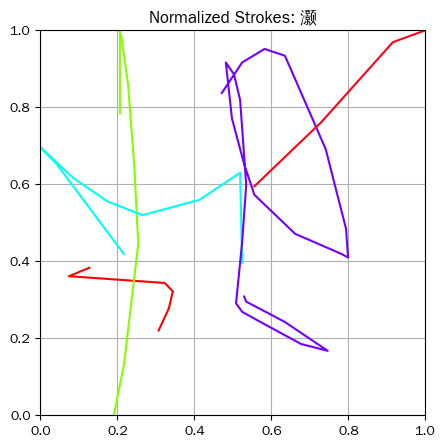

In [4]:
import struct
from pathlib import Path
import math
import numpy as np
import matplotlib.pyplot as plt

# Define Freeman direction codes (a to h for 0 to 7 directions)
DIRECTION_CODES = 'abcdefgh'

def read_pot_file(file_path):
    """Read the .pot file and extract character data and strokes."""
    characters = []
    with open(file_path, 'rb') as f:
        while True:
            sample_size_data = f.read(2)
            if len(sample_size_data) < 2:
                break
            sample_size = struct.unpack('<H', sample_size_data)[0]
            if sample_size == 0:
                break

            tag_code_data = f.read(4)
            if len(tag_code_data) < 4:
                break
            gb_code = tag_code_data[0:2]
            try:
                char = gb_code.decode('gb2312', errors='replace')
            except:
                char = '?'

            stroke_num_data = f.read(2)
            if len(stroke_num_data) < 2:
                break
            stroke_num = struct.unpack('<H', stroke_num_data)[0]

            strokes = []
            for _ in range(stroke_num):
                stroke = []
                while True:
                    point_data = f.read(4)
                    if len(point_data) < 4:
                        break
                    x, y = struct.unpack('<hh', point_data)
                    if x == -1 and y == 0:
                        break
                    stroke.append((x, y))
                if len(stroke) > 1:
                    strokes.append(stroke)

            end_marker_data = f.read(4)
            if len(end_marker_data) < 4:
                break
            end_x, end_y = struct.unpack('<hh', end_marker_data)
            if end_x != -1 or end_y != -1:
                continue

            if strokes:
                characters.append((char, strokes))
    return characters

def compute_freeman_code(stroke):
    """Compute Freeman chain code for a stroke."""
    code = []
    for i in range(len(stroke) - 1):
        x1, y1 = stroke[i]
        x2, y2 = stroke[i + 1]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0 and dy == 0:
            continue
        angle = math.degrees(math.atan2(dy, dx))
        angle = (angle + 360) % 360
        direction = int(round(angle / 45)) % 8
        code.append(DIRECTION_CODES[direction])
    return ''.join(code)

def normalize_character(strokes):
    """Normalize the entire character's strokes to [0,1] range independently for x and y."""
    all_points = [p for stroke in strokes for p in stroke]
    if not all_points:
        return strokes
    min_x = min(p[0] for p in all_points)
    max_x = max(p[0] for p in all_points)
    min_y = min(p[1] for p in all_points)
    max_y = max(p[1] for p in all_points)
    range_x = max_x - min_x if max_x > min_x else 1
    range_y = max_y - min_y if max_y > min_y else 1
    normalized_strokes = [
        [((p[0] - min_x) / range_x, (p[1] - min_y) / range_y) for p in stroke]
        for stroke in strokes
    ]
    return normalized_strokes

def plot_strokes(strokes, filename, title, is_normalized=False):
    """Plot the strokes and save to file with axes visible."""
    plt.figure(figsize=(5, 5))
    colors = plt.get_cmap('hsv')(np.linspace(0, 1, len(strokes)))
    for i, stroke in enumerate(strokes):
        if len(stroke) > 1:
            x, y = zip(*stroke)
            plt.plot(x, y, color=colors[i])
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.gca().invert_yaxis()
    if is_normalized:
        plt.xlim(0, 1)
        plt.ylim(0, 1)
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

def main():
    """Process the .pot file, compute Freeman codes, and plot characters."""
    plots_dir = Path("plots")
    plots_dir.mkdir(exist_ok=True)
    file_path = Path("/content/drive/MyDrive/competition_POT/C001-f.pot")
    if not file_path.exists():
        print(f"Error: File {file_path} not found.")
        return
    characters = read_pot_file(file_path)
    for i, (char, strokes) in enumerate(characters):
        # Compute original Freeman code
        original_freeman = [compute_freeman_code(stroke) for stroke in strokes]
        original_freeman_str = '|'.join(original_freeman)

        # Normalize strokes
        normalized_strokes = normalize_character(strokes)

        # Compute normalized Freeman code
        normalized_freeman = [compute_freeman_code(stroke) for stroke in normalized_strokes]
        normalized_freeman_str = '|'.join(normalized_freeman)

        # Plot original strokes
        plot_strokes(strokes, plots_dir / f"character_{i}_original.png", f"Original Strokes: {char}")

        # Plot normalized strokes
        plot_strokes(normalized_strokes, plots_dir / f"character_{i}_normalized.png", f"Normalized Strokes: {char}", is_normalized=True)

        # Print results
        print(f"Character: {char}")
        print(f"Original Freeman Code: {original_freeman_str}")
        print(f"Normalized Freeman Code: {normalized_freeman_str}")
        print()

if __name__ == "__main__":
    main()